# WWT project - biochar filters for onsite wastewater treatment

## set-up

In [71]:
# import stuff

# this no longer works on SLU computer & we dont know why - to be examined
#%load_ext autoreload
#%autoreload 2

import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.available
style.use('seaborn')

import numpy as np
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from collections import defaultdict, OrderedDict
import brightway2 as bw2
from bw2data.parameters import ActivityParameter, ProjectParameter, DatabaseParameter, Group
import itertools

from IPython.display import display, Math

# Custom utils defined for inter-acv
from lca_algebraic import *
from lca_algebraic.stats import * 
import lca_algebraic as la
import re

from copy import deepcopy
from os.path import isfile

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\3923257642.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


In [2]:
project = 'wwt_new'
bw2.projects.set_current(project)
# set user db here

In [3]:
# Impact categories 
## IPCC method GWP100
IPCC = [method for method in bw2.methods if "IPCC 2021" in str(method) 
        and "GWP100" in str(method) 
        and "biogenic" not in str(method)
        and "fossil" not in str(method)
        and "SLCFs" not in str(method)
        and "land use" not in str(method)
        and "LT" not in str(method)]
IPCC_unit = [r'kg $CO_2$-eq']

## Eutrophication
TRACI_eut = [method for method in bw2.methods if "TRACI" in str(method)
          and "eutrophication" in str(method)
          and "LT" not in str(method)
          ]

TRACI_eut_unit = [bw2.methods[method]['unit'] for method in TRACI_eut]

## Acidification
CML_acid = [method for method in bw2.methods if "CML v4.8" in str(method)
          and "acidification" in str(method)
          and "LT" not in str(method)
          ]

CML_acid_unit = [bw2.methods[method]['unit'] for method in CML_acid]


all_methods= IPCC + TRACI_eut + CML_acid
all_methods_units = IPCC_unit + TRACI_eut_unit + CML_acid_unit

In [4]:
USER_DB = 'wwt_db'

In [5]:
BCBed_Normal = findActivity("BCBed Normal System", db_name=USER_DB)
BCBed_Sensitive = findActivity("BCBed Sensitive System", db_name=USER_DB)
BCMod_Sensitive = findActivity("BCMod Sensitive System", db_name=USER_DB)
Sand_Normal = findActivity("Sand Normal System", db_name=USER_DB)
Sand_Sensitive = findActivity("Sand Sensitive System", db_name=USER_DB)

In [6]:
climate_label = 'kg CO'+'$_{2}$' +'-eq / m' +'$^{3}$' ' wastewater'
eutroph_label = 'kg N-eq / m' +'$^{3}$' ' wastewater'
acid_label = 'kg SO'+'$_{2}$' +'-eq / m' +'$^{3}$' ' wastewater'

In [7]:
loadParams()

10
elec_switch_param
heat_switch_param
sand_switch_param
bc_switch_param
EOL1and2_switch_param
EOL3and4_switch_param
EOL5and6_switch_param
EOL7_switch_param
bc_Seqswitch_param
bc_HLswitch_param


Om du får Value Error: 0 -> Ändra Unknown unc to No unc

### define switches (only need to run this once, when building the database)

Elec

In [19]:
elec_switch_param = newEnumParam(
    'elec_switch_param', 
    values=["elecCoal", "elecWindpower"], # If provided as list, all possibilities have te same probability
    default="elecWindpower", 
    description="Switch on electricty")

In [20]:
elecWindpower = getActByCode('cutoff391', '1d9be64d54b61ac64ba8a6f7ca220371')
elecCoal = getActByCode('cutoff391', '7bea67942b5e008ee3dc5bafec8e1614')

In [21]:
elecSwitch = newSwitchAct('wwt_db', 
    "elecSwitch", # Name
    elec_switch_param, # Switch parameter
    {
        "elecWindpower" : elecWindpower,
        "elecCoal": elecCoal
    })
elecSwitch.addExchanges({elecSwitch:1})

Heat

In [22]:
heat_switch_param = newEnumParam(
    'heat_switch_param', 
    values=["heatNaturalGas", "heatWoodchips"], # If provided as list, all possibilities have te same probability
    default="heatWoodchips", 
    description="Switch on heat")

In [23]:
heatNaturalGas=getActByCode('cutoff391', '2446fb9b2d523f6d90a47b004bb6debf')
heatWoodchips = getActByCode('cutoff391', 'ce4ad62107e686a5dd09cca3985a4f37')

In [24]:
heatSwitch = newSwitchAct('wwt_db', 
    "heatSwitch", # Name
    heat_switch_param, # Switch parameter
    {
        "heatNaturalGas" : heatNaturalGas,
        "heatWoodchips": heatWoodchips
    })
heatSwitch.addExchanges({heatSwitch:1})

Sand - material or no

In [27]:
sand_switch_param = newEnumParam(
    'sand_switch_param', 
    values=["sand", "noSand"], # If provided as list, all possibilities have te same probability
    default="sand", 
    description="Switch on sand for filter")

In [66]:
sand=getActByCode('wwt_db', 'b23795c66a984d88aa77ed3a6f7a1499')
noSand = getActByCode('wwt_db', 'c10a45c5e30b42ba82303eeca29bf3b5')

In [67]:
sandSwitch = newSwitchAct('wwt_db', 
    "sandSwitch", # Name
    sand_switch_param, # Switch parameter
    {
        "sand" : sand,
        "noSand": noSand
    })
sandSwitch.addExchanges({sandSwitch:1})

Activity 'sandSwitch' was already in 'wwt_db'. Overwriting it


Biochar type - involves prod, amount in filter, and EoL

In [41]:
bc_switch_param = newEnumParam(
    'bc_switch_param', 
    values=["bc1", "bc2", "bc3", "bc4", "bc5", "bc6", "bc7"], # If provided as list, all possibilities have te same probability
    default="bc1", 
    description="Switch on type of biochar")

In [42]:
bc1=getActByCode('wwt_db', '6d631561b8634199949da8e659a0d0c8')
bc2 = getActByCode('wwt_db', '034ccc11d9f342ca9553dcfccc3daae6')
bc3 = getActByCode('wwt_db', 'e5876ed071b54182b4ae8e36598a87fc')
bc4=getActByCode('wwt_db', 'fd5def76a8544aac8397818e2ba482aa')
bc5 = getActByCode('wwt_db', '993fe1721f4844a983301dc6a0b1949b')
bc6 = getActByCode('wwt_db', 'd9775217ae99439e9f98e923b2de9a63')
bc7 = getActByCode('wwt_db', '58d3983a6b37472eb728fd23224782ac')

In [43]:
bcSwitch = newSwitchAct('wwt_db', 
    "bcSwitch", # Name
    bc_switch_param, # Switch parameter
    {
        "bc1":bc1,
        "bc2":bc2,
        "bc3":bc3,
        "bc4":bc4,
        "bc5":bc5,
        "bc6":bc6,
        "bc7":bc7
    })
bcSwitch.addExchanges({bcSwitch:1})

Bc prod for impreg bc - includes heat losses

In [7]:
bc_HLswitch_param = newEnumParam(
    'bc_HLswitch_param', 
    values=["bc1HL", "bc2HL", "bc3HL", "bc4HL", "bc5HL", "bc7HL"], # If provided as list, all possibilities have te same probability
    default="bc1HL", 
    description="Switch on type of biochar, with heat losses for impreg bc")

Param bc_HLswitch_param was already defined : overriding


In [8]:
bc1HL = getActByCode('wwt_db', '788013939f964a8fa4c15b96acae919e')
bc2HL = getActByCode('wwt_db', 'b5068415e5164a7fbb72a4802e549932')
bc3HL = getActByCode('wwt_db', '8b170663ebcc45e195034bc7f0c0a3da')
bc4HL = getActByCode('wwt_db', 'bbf2c0226d664b3db142fc5e9784100b')
bc5HL = getActByCode('wwt_db', '818a0b0ade734a2088b34e7640114ddb')
bc7HL = getActByCode('wwt_db', '96756a2ca4e545709e1561374faacbe2')

In [9]:
bcHLSwitch = newSwitchAct('wwt_db', 
    "bcHLSwitch", # Name
    bc_HLswitch_param, # Switch parameter
    {
        "bc1HL":bc1HL,
        "bc2HL":bc2HL,
        "bc3HL":bc3HL,
        "bc4HL":bc4HL,
        "bc5HL":bc5HL,
        "bc7HL":bc7HL
    })
bcHLSwitch.addExchanges({bcHLSwitch:1})

Activity 'bcHLSwitch' was already in 'wwt_db'. Overwriting it


BC Switch for biochar left in biochar bed filter

In [65]:
bc_Seqswitch_param = newEnumParam(
    'bc_Seqswitch_param', 
    values=["bc1Seq", "bc2Seq", "bc3Seq", "bc4Seq", "bc5Seq", "bc6Seq", "bc7Seq"], # If provided as list, all possibilities have te same probability
    default="bc1Seq", 
    description="Switch on type of biochar, that stays and sequesters carbon in the filter")

Param bc_Seqswitch_param was already defined : overriding


In [66]:
bc1Seq = getActByCode('wwt_db', '9d2a9d74170e45989b8895afdf396465')
bc2Seq = getActByCode('wwt_db', 'a71ca96c26584f03b718bcbf818540a9')
bc3Seq = getActByCode('wwt_db', 'edd55311fe3b4fba842a14ce248fa09e')
bc4Seq = getActByCode('wwt_db', 'ec190fab90934a66873edcf4f25330dd')
bc5Seq = getActByCode('wwt_db', 'd0f5229de641411a8d46333a0e1b5734')
bc6Seq = getActByCode('wwt_db', 'fe3cf3eaa3e34a63906431858404b54b')
bc7Seq = getActByCode('wwt_db', '57bcea07cb204982ac972f9d791b5d48')

In [67]:
bcSeqSwitch = newSwitchAct('wwt_db', 
    "bcSeqSwitch", # Name
    bc_Seqswitch_param, # Switch parameter
    {
        "bc1Seq":bc1Seq,
        "bc2Seq":bc2Seq,
        "bc3Seq":bc3Seq,
        "bc4Seq":bc4Seq,
        "bc5Seq":bc5Seq,
        "bc6Seq":bc6Seq,
        "bc7Seq":bc7Seq
    })
bcSeqSwitch.addExchanges({bcSeqSwitch:1})

Activity 'bcSeqSwitch' was already in 'wwt_db'. Overwriting it


EoL switches

In [17]:
EOL1and2_switch_param = newEnumParam(
    'EOL1and2_switch_param', 
    values=["LS1", "CHP1", "Heat1"], # If provided as list, all possibilities have te same probability
    default="LS1", 
    description="Switch on EOL for BC 1 and 2")

In [18]:
LS1=getActByCode('wwt_db', '087691fdf57e4675abfaa66273029c39')
CHP1=getActByCode('wwt_db', '1d2e364ab3ee4de6a4371792c9cd8010')
Heat1=getActByCode('wwt_db', 'ccf9cb08bfbb4db49e232c6ad683617d')

In [19]:
EOL1and2Switch = newSwitchAct('wwt_db', 
    "EOL1and2Switch", # Name
    EOL1and2_switch_param, # Switch parameter
    {
        "LS1" : LS1,
        "CHP1": CHP1,
        "Heat1": Heat1
    })
EOL1and2Switch.addExchanges({EOL1and2Switch:1})

In [20]:
EOL3and4_switch_param = newEnumParam(
    'EOL3and4_switch_param', 
    values=["LS2", "CHP2", "Heat2"], # If provided as list, all possibilities have te same probability
    default="LS2", 
    description="Switch on EOL for BC 3 and 4")

In [21]:
LS2=getActByCode('wwt_db', '10fa0681e8ec4650b3a187e5985e1664')
CHP2=getActByCode('wwt_db', 'cca92de926d24389b93c3c35ff2f8d2c')
Heat2=getActByCode('wwt_db', 'ee6d432ad3624bc9bfd3d6d14384662e')

In [22]:
EOL3and4Switch = newSwitchAct('wwt_db', 
    "EOL3and4Switch", # Name
    EOL3and4_switch_param, # Switch parameter
    {
        "LS2" : LS2,
        "CHP2": CHP2,
        "Heat2": Heat2
    })
EOL3and4Switch.addExchanges({EOL3and4Switch:1})

In [23]:
EOL5and6_switch_param = newEnumParam(
    'EOL5and6_switch_param', 
    values=["LS3", "CHP3", "Heat3"], # If provided as list, all possibilities have te same probability
    default="LS3", 
    description="Switch on EOL for BC 5 and 6")

In [24]:
LS3=getActByCode('wwt_db', 'dbd57f8ce8b54379a1c656105b575379')
CHP3=getActByCode('wwt_db', '938586b2d6ed4b7b9f20d7850ac0b7bf')
Heat3=getActByCode('wwt_db', '2abe1ac1f157443fa51cc2a8550fa99a')

In [25]:
EOL5and6Switch = newSwitchAct('wwt_db', 
    "EOL5and6Switch", # Name
    EOL5and6_switch_param, # Switch parameter
    {
        "LS3" : LS3,
        "CHP3": CHP3,
        "Heat3": Heat3
    })
EOL5and6Switch.addExchanges({EOL5and6Switch:1})

In [26]:
EOL7_switch_param = newEnumParam(
    'EOL7_switch_param', 
    values=["LS4", "CHP4", "Heat4"], # If provided as list, all possibilities have te same probability
    default="LS4", 
    description="Switch on EOL for BC 7")

In [27]:
LS4=getActByCode('wwt_db', '49356ebdb7fa4037970b9e66c912896c')
CHP4=getActByCode('wwt_db', 'bc1eb534a5dc4017bcb0f92ec8d2d113')
Heat4=getActByCode('wwt_db', '694f5467ac1944c3b6d94b2dc21df709')

In [28]:
EOL7Switch = newSwitchAct('wwt_db', 
    "EOL7Switch", # Name
    EOL7_switch_param, # Switch parameter
    {
        "LS4" : LS4,
        "CHP4": CHP4,
        "Heat4": Heat4
    })
EOL7Switch.addExchanges({EOL7Switch:1})

### generate y:s and data

In [8]:
from lca_algebraic.stats import _stochastics

In [9]:
problem1, params, Y1 = _stochastics(BCBed_Normal, all_methods, n=10000)

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


When we've gotten the params, no need to sample them again - and make sure that we're using the same ones

In [10]:
from lca_algebraic.stats import _compute_stochastics

In [11]:
Y2 = _compute_stochastics(Sand_Normal, all_methods, params)

In [12]:
Y3 = _compute_stochastics(BCBed_Sensitive, all_methods, params)

Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


In [13]:
Y4 = _compute_stochastics(BCMod_Sensitive, all_methods, params)

Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


In [14]:
Y5 = _compute_stochastics(Sand_Sensitive, all_methods, params)

In [15]:
BCBed_Normal_minClimate = Y1['climate change - global warming potential (GWP100)'].min()
BCBed_Normal_minEutroph = Y1['eutrophication - eutrophication potential'].min()
BCBed_Normal_minAcid = Y1['acidification - acidification (incl. fate, average Europe total, A&B)'].min()

BCBed_Normal_maxClimate = Y1['climate change - global warming potential (GWP100)'].max()
BCBed_Normal_maxEutroph = Y1['eutrophication - eutrophication potential'].max()
BCBed_Normal_maxAcid = Y1['acidification - acidification (incl. fate, average Europe total, A&B)'].max()

BCBed_Normal_medianClimate = Y1['climate change - global warming potential (GWP100)'].median()
BCBed_Normal_medianEutroph = Y1['eutrophication - eutrophication potential'].median()
BCBed_Normal_medianAcid = Y1['acidification - acidification (incl. fate, average Europe total, A&B)'].median()

BCBed_Normal_errorClimate = np.array([BCBed_Normal_medianClimate-BCBed_Normal_minClimate, BCBed_Normal_maxClimate-BCBed_Normal_medianClimate]).reshape((2,1))
BCBed_Normal_errorEutroph = np.array([BCBed_Normal_medianEutroph-BCBed_Normal_minEutroph, BCBed_Normal_maxEutroph-BCBed_Normal_medianEutroph]).reshape((2,1))
BCBed_Normal_errorAcid = np.array([BCBed_Normal_medianAcid-BCBed_Normal_minAcid, BCBed_Normal_maxAcid-BCBed_Normal_medianAcid]).reshape((2,1))

In [16]:
Sand_Normal_minClimate = Y2['climate change - global warming potential (GWP100)'].min()
Sand_Normal_minEutroph = Y2['eutrophication - eutrophication potential'].min()
Sand_Normal_minAcid = Y2['acidification - acidification (incl. fate, average Europe total, A&B)'].min()

Sand_Normal_maxClimate = Y2['climate change - global warming potential (GWP100)'].max()
Sand_Normal_maxEutroph = Y2['eutrophication - eutrophication potential'].max()
Sand_Normal_maxAcid = Y2['acidification - acidification (incl. fate, average Europe total, A&B)'].max()

Sand_Normal_medianClimate = Y2['climate change - global warming potential (GWP100)'].median()
Sand_Normal_medianEutroph = Y2['eutrophication - eutrophication potential'].median()
Sand_Normal_medianAcid = Y2['acidification - acidification (incl. fate, average Europe total, A&B)'].median()

Sand_Normal_errorClimate = np.array([Sand_Normal_medianClimate-Sand_Normal_minClimate, Sand_Normal_maxClimate-Sand_Normal_medianClimate]).reshape((2,1))
Sand_Normal_errorEutroph = np.array([Sand_Normal_medianEutroph-Sand_Normal_minEutroph, Sand_Normal_maxEutroph-Sand_Normal_medianEutroph]).reshape((2,1))
Sand_Normal_errorAcid = np.array([Sand_Normal_medianAcid-Sand_Normal_minAcid, Sand_Normal_maxAcid-Sand_Normal_medianAcid]).reshape((2,1))

In [17]:
BCBed_Sensitive_minClimate = Y3['climate change - global warming potential (GWP100)'].min()
BCBed_Sensitive_minEutroph = Y3['eutrophication - eutrophication potential'].min()
BCBed_Sensitive_minAcid = Y3['acidification - acidification (incl. fate, average Europe total, A&B)'].min()

BCBed_Sensitive_maxClimate = Y3['climate change - global warming potential (GWP100)'].max()
BCBed_Sensitive_maxEutroph = Y3['eutrophication - eutrophication potential'].max()
BCBed_Sensitive_maxAcid = Y3['acidification - acidification (incl. fate, average Europe total, A&B)'].max()

BCBed_Sensitive_medianClimate = Y3['climate change - global warming potential (GWP100)'].median()
BCBed_Sensitive_medianEutroph = Y3['eutrophication - eutrophication potential'].median()
BCBed_Sensitive_medianAcid = Y3['acidification - acidification (incl. fate, average Europe total, A&B)'].median()

BCBed_Sensitive_errorClimate = np.array([BCBed_Sensitive_medianClimate-BCBed_Sensitive_minClimate, BCBed_Sensitive_maxClimate-BCBed_Sensitive_medianClimate]).reshape((2,1))
BCBed_Sensitive_errorEutroph = np.array([BCBed_Sensitive_medianEutroph-BCBed_Sensitive_minEutroph, BCBed_Sensitive_maxEutroph-BCBed_Sensitive_medianEutroph]).reshape((2,1))
BCBed_Sensitive_errorAcid = np.array([BCBed_Sensitive_medianAcid-BCBed_Sensitive_minAcid, BCBed_Sensitive_maxAcid-BCBed_Sensitive_medianAcid]).reshape((2,1))

In [18]:
BCMod_Sensitive_minClimate = Y4['climate change - global warming potential (GWP100)'].min()
BCMod_Sensitive_minEutroph = Y4['eutrophication - eutrophication potential'].min()
BCMod_Sensitive_minAcid = Y4['acidification - acidification (incl. fate, average Europe total, A&B)'].min()

BCMod_Sensitive_maxClimate = Y4['climate change - global warming potential (GWP100)'].max()
BCMod_Sensitive_maxEutroph = Y4['eutrophication - eutrophication potential'].max()
BCMod_Sensitive_maxAcid = Y4['acidification - acidification (incl. fate, average Europe total, A&B)'].max()

BCMod_Sensitive_medianClimate = Y4['climate change - global warming potential (GWP100)'].median()
BCMod_Sensitive_medianEutroph = Y4['eutrophication - eutrophication potential'].median()
BCMod_Sensitive_medianAcid = Y4['acidification - acidification (incl. fate, average Europe total, A&B)'].median()

BCMod_Sensitive_errorClimate = np.array([BCMod_Sensitive_medianClimate-BCMod_Sensitive_minClimate, BCMod_Sensitive_maxClimate-BCMod_Sensitive_medianClimate]).reshape((2,1))
BCMod_Sensitive_errorEutroph = np.array([BCMod_Sensitive_medianEutroph-BCMod_Sensitive_minEutroph, BCMod_Sensitive_maxEutroph-BCMod_Sensitive_medianEutroph]).reshape((2,1))
BCMod_Sensitive_errorAcid = np.array([BCMod_Sensitive_medianAcid-BCMod_Sensitive_minAcid, BCMod_Sensitive_maxAcid-BCMod_Sensitive_medianAcid]).reshape((2,1))

In [19]:
Sand_Sensitive_minClimate = Y5['climate change - global warming potential (GWP100)'].min()
Sand_Sensitive_minEutroph = Y5['eutrophication - eutrophication potential'].min()
Sand_Sensitive_minAcid = Y5['acidification - acidification (incl. fate, average Europe total, A&B)'].min()

Sand_Sensitive_maxClimate = Y5['climate change - global warming potential (GWP100)'].max()
Sand_Sensitive_maxEutroph = Y5['eutrophication - eutrophication potential'].max()
Sand_Sensitive_maxAcid = Y5['acidification - acidification (incl. fate, average Europe total, A&B)'].max()

Sand_Sensitive_medianClimate = Y5['climate change - global warming potential (GWP100)'].median()
Sand_Sensitive_medianEutroph = Y5['eutrophication - eutrophication potential'].median()
Sand_Sensitive_medianAcid = Y5['acidification - acidification (incl. fate, average Europe total, A&B)'].median()

Sand_Sensitive_errorClimate = np.array([Sand_Sensitive_medianClimate-Sand_Sensitive_minClimate, Sand_Sensitive_maxClimate-Sand_Sensitive_medianClimate]).reshape((2,1))
Sand_Sensitive_errorEutroph = np.array([Sand_Sensitive_medianEutroph-Sand_Sensitive_minEutroph, Sand_Sensitive_maxEutroph-Sand_Sensitive_medianEutroph]).reshape((2,1))
Sand_Sensitive_errorAcid = np.array([Sand_Sensitive_medianAcid-Sand_Sensitive_minAcid, Sand_Sensitive_maxAcid-Sand_Sensitive_medianAcid]).reshape((2,1))

#### excel sheet with all min and max

In [24]:
d = {'BedNormalClimate': [BCBed_Normal_minClimate, BCBed_Normal_maxClimate], 
     'BedNormalEutroph': [BCBed_Normal_minEutroph, BCBed_Normal_maxEutroph], 
     'BedNormalAcid': [BCBed_Normal_minAcid, BCBed_Normal_maxAcid],
     
     'BedSensitiveClimate': [BCBed_Sensitive_minClimate, BCBed_Sensitive_maxClimate], 
     'BedSensitiveEutroph': [BCBed_Sensitive_minEutroph, BCBed_Sensitive_maxEutroph], 
     'BedSensitiveAcid': [BCBed_Sensitive_minAcid, BCBed_Sensitive_maxAcid],
     
     'BedModClimate': [BCMod_Sensitive_minClimate, BCMod_Sensitive_maxClimate], 
     'BedModEutroph': [BCMod_Sensitive_minEutroph, BCMod_Sensitive_maxEutroph], 
     'BedModAcid': [BCBed_Sensitive_minAcid, BCMod_Sensitive_maxAcid]
    }
min_max_df = pd.DataFrame(data=d, index = ['min', 'max'])

In [25]:
min_max_df

BedNormalClimate  BedNormalEutroph  BedNormalAcid  BedSensitiveClimate  \
min        -21.057001          0.089101       0.017328           -18.907025   
max         42.012606          0.243504       0.157473            13.773668   

     BedSensitiveEutroph  BedSensitiveAcid  BedModClimate  BedModEutroph  \
min             0.029780          0.038981      -3.793688       0.026600   
max             0.132156          0.116933      13.611568       0.088907   

     BedModAcid  
min    0.038981  
max    0.084121

### check number for n

conclusion: 10.000 is enough

In [7]:
from lca_algebraic.stats import _stochastics

In [8]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=100) # change n

Generating samples ...
Transforming samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


(       climate change - global warming potential (GWP100) [kg CO2-Eq / kWh]  \
 median                                          -1.782404                     
 std                                              5.403781                     
 p                [-12.381994943007031, 6.483055156702864]                     
 mean                                            -2.076398                     
 var                                             -2.602478                     
 
        eutrophication - eutrophication potential [kg N-Eq / kWh]  \
 median                                           0.053878          
 std                                              0.017485          
 p              [0.03804726384794617, 0.10292951424652103]          
 mean                                             0.057804          
 var                                              0.302483          
 
        acidification - acidification (incl. fate, average Europe total, A&B) [kg SO2-Eq / kWh]  
 med

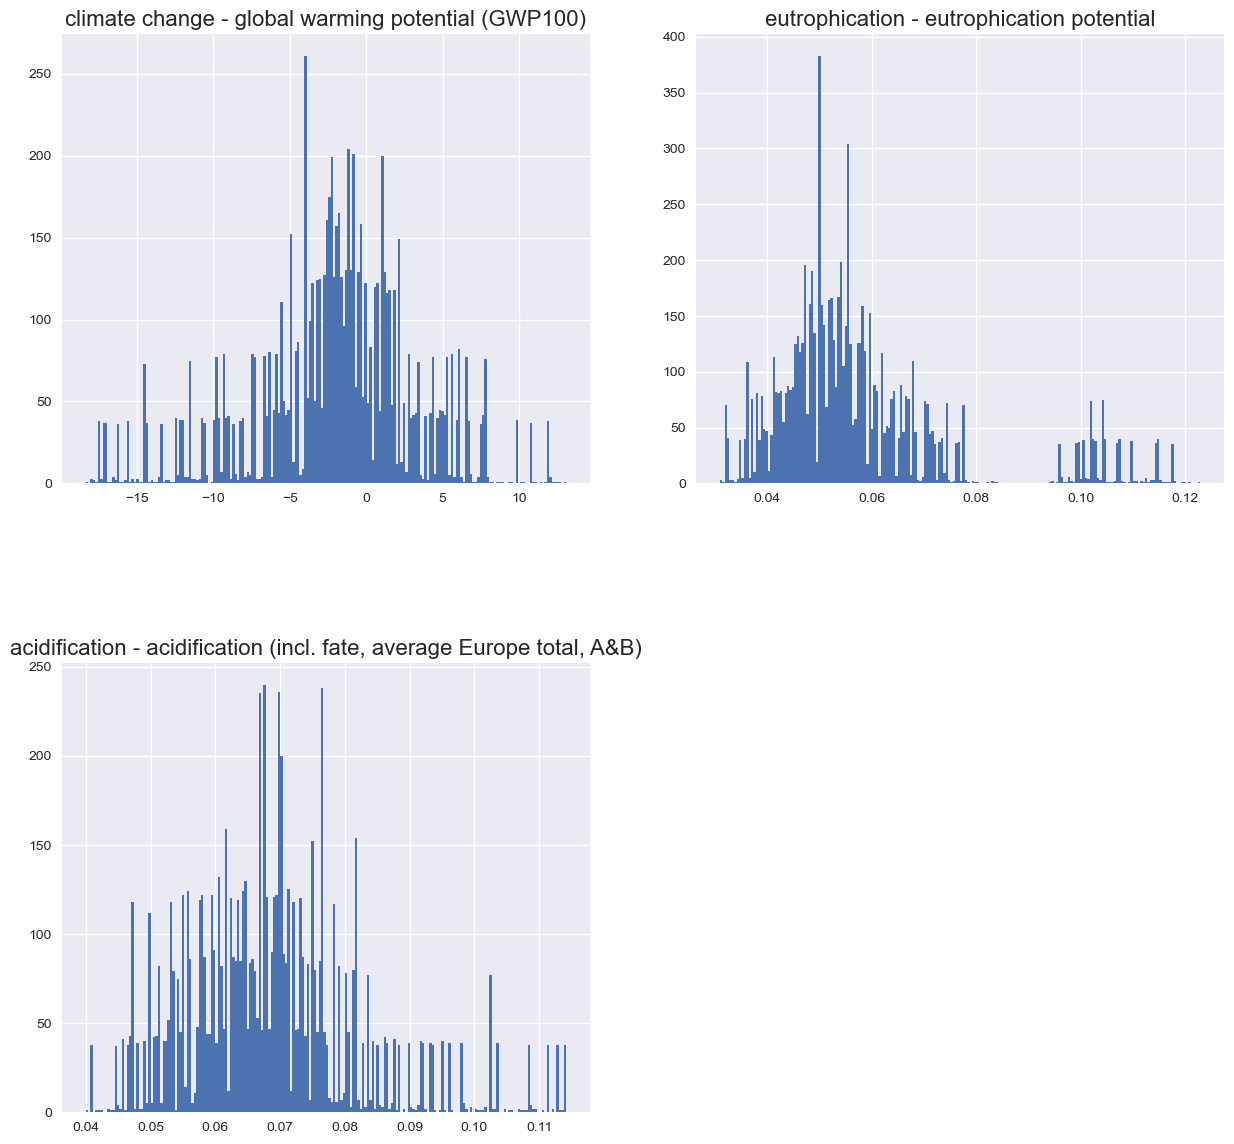

In [10]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

In [11]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=1000) # change n

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


(       climate change - global warming potential (GWP100) [kg CO2-Eq / kWh]  \
 median                                          -1.697774                     
 std                                              5.501821                     
 p                [-13.51039876523157, 6.0690175570364495]                     
 mean                                            -2.335347                     
 var                                              -2.35589                     
 
        eutrophication - eutrophication potential [kg N-Eq / kWh]  \
 median                                           0.053013          
 std                                              0.018012          
 p              [0.03818949029865521, 0.10528171052846247]          
 mean                                             0.057365          
 var                                              0.313986          
 
        acidification - acidification (incl. fate, average Europe total, A&B) [kg SO2-Eq / kWh]  
 med

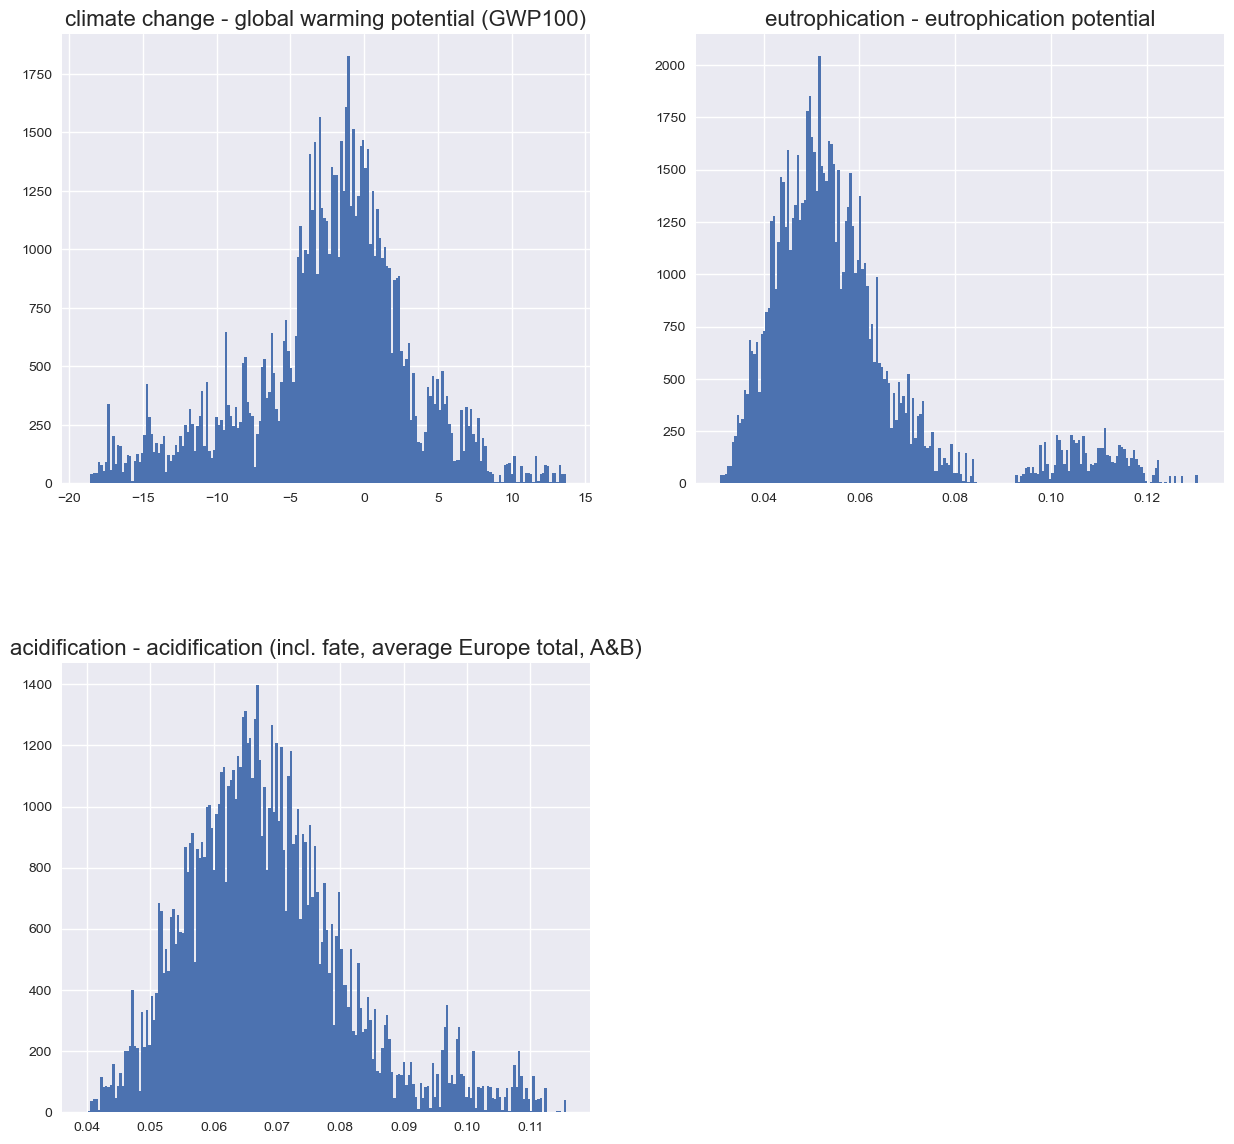

In [12]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

In [13]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=10000) # change n

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


(       climate change - global warming potential (GWP100) [kg CO2-Eq / kWh]  \
 median                                          -1.688509                     
 std                                              5.498122                     
 p                [-13.286471674732242, 6.273297889720073]                     
 mean                                            -2.307045                     
 var                                             -2.383188                     
 
        eutrophication - eutrophication potential [kg N-Eq / kWh]  \
 median                                           0.053181          
 std                                              0.018069          
 p              [0.03841604606010268, 0.10617843610169861]          
 mean                                             0.057456          
 var                                              0.314485          
 
        acidification - acidification (incl. fate, average Europe total, A&B) [kg SO2-Eq / kWh]  
 med

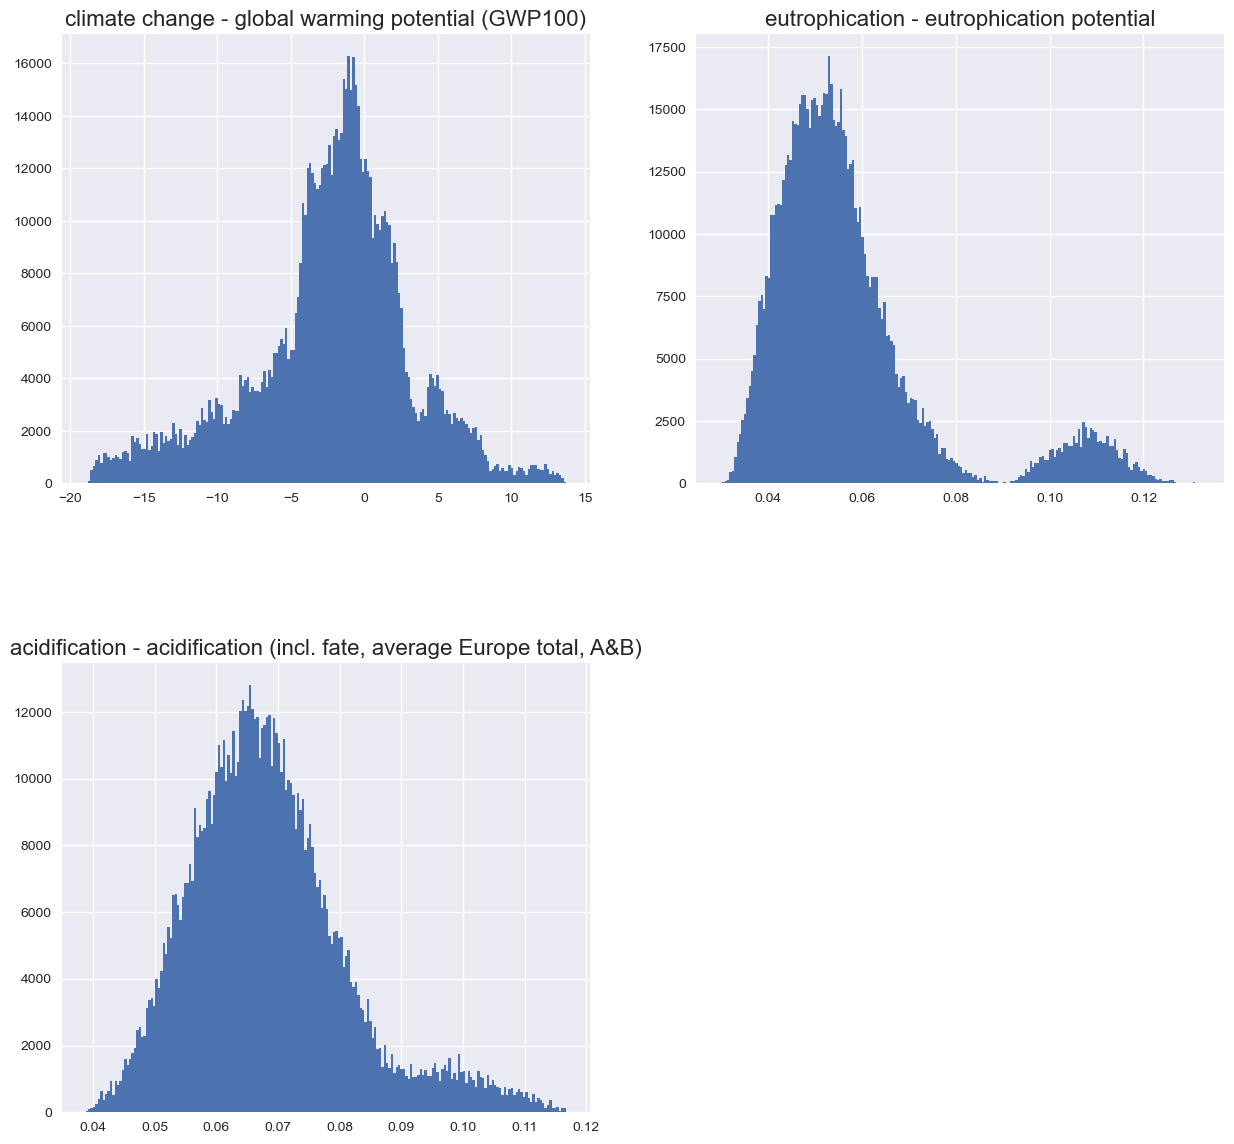

In [14]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

In [15]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=20000) # change n

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (20000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


(       climate change - global warming potential (GWP100) [kg CO2-Eq / kWh]  \
 median                                          -1.688861                     
 std                                              5.497546                     
 p                [-13.346806173778957, 6.276850257941547]                     
 mean                                            -2.312894                     
 var                                             -2.376913                     
 
        eutrophication - eutrophication potential [kg N-Eq / kWh]  \
 median                                           0.053129          
 std                                              0.018031          
 p             [0.038465260834262015, 0.10585492458756876]          
 mean                                             0.057443          
 var                                              0.313897          
 
        acidification - acidification (incl. fate, average Europe total, A&B) [kg SO2-Eq / kWh]  
 med

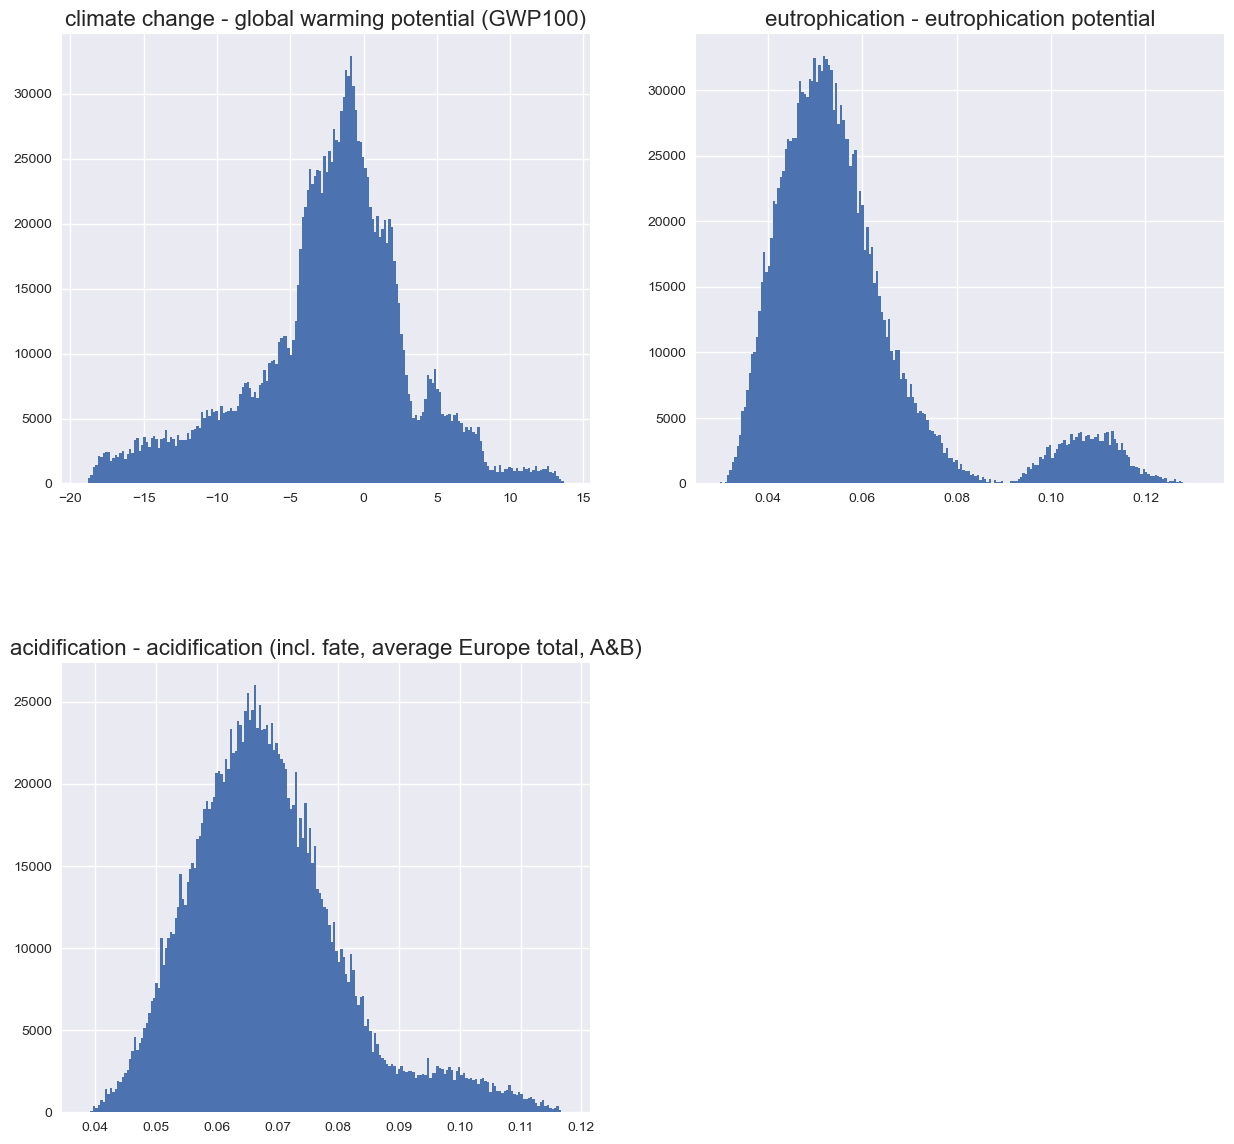

In [16]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

In [ ]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=100000) # change n

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


In [ ]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

## CA

In [101]:
from __future__ import print_function, unicode_literals
from eight import *

from bw2data import databases, methods, get_activity, Method
from bw2calc import LCA

In [102]:
fg = 'wwt_db'
fu1 = {('wwt_db', '4936df1f1c8d470380b02907bf2002c5'):1} # bc bed, normal
fu2 = {('wwt_db', '0fbe01da943e4d4aa7c3d39337be5ddf'):1} # sandfilter, normal
fu3 = {('wwt_db', '478174ce5a594287a039bdc23757b240'):1} # bc bed, sensitive
fu4 = {('wwt_db', '4c5d9a125cd84265a68dd09858eac9f4'):1} # bc mod, sensitive
fu5 = {('wwt_db', 'c4401064ed20418084f86b84ddf6bb93'):1} # sand, sensitive

In [103]:
def traverse_tagged_databases(
    functional_unit, method, label="tag", default_tag="other", secondary_tags=[],
    fg_databases=None, bio2tech=False, parent4other=False
):

    """
    ESA : allows to perform grouping as in SimaPro 
    Traverse a functional unit throughout its foreground database(s) or the    
    listed databses in fg_databses, and group impacts by tag label.

    Contribution analysis work by linking impacts to individual activities.
    However, you also might want to group impacts in other ways. For example,
    give individual biosphere exchanges their own grouping, or aggregate two
    activities together.
    
    Consider this example system, where the letters are the tag labels, and the
    numbers are exchange amounts. The functional unit is one unit of the tree
    root.

    .. image:: images/tagged-traversal.png
       :alt: Example tagged supply chain

    In this supply chain, tags are applied to activities and biosphere exchanges.
    If a biosphere exchange is not tagged, it inherits the tag of its producing
    activity. Similarly, links to other databases are assessed with the usual
    LCA machinery, and the total LCA score is tagged according to its consuming
    activity. If an activity does not have a tag, a default tag is applied.

    We can change our visualization to show the use of the default tags:
    
    .. image:: images/tagged-traversal-2.png
       :alt: Example tagged supply chain

    And then we can manually calculate the tagged impacts. Normally we would
    need to know the actual biosphere flows and their respective
    characterization factors (CF), but in this example we assume that each
    CF is one. Our result, group by tags, would therefore be:

        * **A**: :math:`6 + 27 = 33`

        * **B**: :math:`30 + 44 = 74`

        * **C**: :math:`5 + 16 + 48 = 69`

        * **D**: :math:`14`

    This function will only traverse the foreground database, i.e. the
    database of the functional unit activity. A functional unit can have
    multiple starting nodes; in this case, all foreground databases are
    traversed.

    Input arguments:
        * ``functional_unit``: A functional unit dictionary, e.g. ``{("foo", "bar"): 42}``.
        * ``method``: A method name, e.g. ``("foo", "bar")``
        * ``label``: The label of the tag classifier. Default is ``"tag"``
        * ``default_tag``: The tag classifier to use if none was given. Default is ``"other"``
        * ``secondary_tags``: List of tuples in the format (secondary_label, secondary_default_tag). Default is empty list.      
        * ``fg_databases``: a list of foreground databases to be traversed, e.g. ['foreground', 'biomass', 'machinery']
                            It's not recommended to include all databases of a project in the list to be traversed, especially not ecoinvent itself

    Returns:
        Aggregated tags dictionary from ``aggregate_tagged_graph``, and tagged supply chain graph from ``recurse_tagged_database``.


    """

    lca = LCA(functional_unit, method)
    lca.lci(factorize=True)
    lca.lcia()
    method_dict = {o[0]: o[1] for o in Method(method).load()}
    
    graph = [
        recurse_tagged_database(
            key, amount, method_dict, lca, label, default_tag, secondary_tags, fg_databases, parent4other
        )
        for key, amount in functional_unit.items()
    ]

    return aggregate_tagged_graph(graph, bio2tech), graph

In [104]:
def aggregate_tagged_graph(graph, bio2tech=False,):
    """Aggregate a graph produced by ``recurse_tagged_database`` by the provided tags.

    Outputs a dictionary with keys of tags and numeric values.
    
    If bio2tech is set to True, then biosphere exchanges are added to the tag of the parent activity (instead of direct emissions)

    .. code-block:: python

        {'a tag': summed LCIA scores}

    """

    def recursor(obj, scores):
        scores[obj["tag"]] += obj["impact"]
        if bio2tech:
            for flow in obj["biosphere"]:
                scores[obj["tag"]] += flow["impact"]
        else: # default behavior
            for flow in obj["biosphere"]:
                scores[flow["tag"]] += flow["impact"]
        for exc in obj["technosphere"]:
            scores = recursor(exc, scores)
        return scores

    scores = defaultdict(int)
    for obj in graph:
        scores = recursor(obj, scores)
    return scores

In [105]:
def recurse_tagged_database(
    activity, amount, method_dict, lca, label, default_tag, secondary_tags=[], fg_databases=None, parent4other=False
):

    """Traverse a foreground database and assess activities and biosphere flows by tags.


    Input arguments:


        * ``activity``: Activity tuple or object
        * ``amount``: float
        * ``method_dict``: Dictionary of biosphere flow tuples to CFs, e.g. ``{("biosphere", "foo"): 3}``
        * ``lca``: An ``LCA`` object that is already initialized, i.e. has already calculated LCI and LCIA with same method as in ``method_dict``
        * ``label``: string
        * ``default_tag``: string
        * ``secondary_tags``: List of tuples in the format (secondary_label, secondary_default_tag). Default is empty list.     
        * ``fg_databases``: a list of foreground databases to be traversed, e.g. ['foreground', 'biomass', 'machinery']
                            It's not recommended to include all databases of a project in the list to be traversed, especially not ecoinvent itself
        * parent4other=False : if True, untagged technosphere exchanges are aggregated with their parent .. become "outside"

  Returns:
    .. code-block:: python

        {
            'activity': activity object,
            'amount': float,
            'tag': string,
            'secondary_tags': [list of strings],
            'impact': float (impact of inputs from outside foreground database),
            'biosphere': [{
                'amount': float,
                'impact': float,
                'tag': string,
                'secondary_tags': [list of strings]
            }],
            'technosphere': [this data structure]
        }

    """

    if isinstance(activity, tuple):
        activity = get_activity(activity)
        
    if fg_databases == None: # then set the list equal to the database of the functional unit 
    
        fg_databases = [activity['database']] # list, single item
    
    elif fg_databases == list(bw2.Database(activity['database']).find_graph_dependents()): 
        # check that the list fg_databases does not include all the databases involved in the FU 
        # (otherwise, it would mean we are likely to have to recurse through ecoinvent... not funny)
        # ideally, should only on first call of recurse_tagged_database
        raise Exception('The list of databases to traverse fg_databases should not be equal to the all databases involved in the project. You risk to attempt to traverse a background database like ecoinvent - it would take too much time')

    inputs = list(activity.technosphere())
    #print('activity', activity['name'])
    #print('inputs', inputs)
    
    production = list(activity.production())
    if len(production) == 1:
        scale = production[0]["amount"]
    elif not production:
        # Assume production amount of 1
        scale = 1
    else:
        raise ValueError("Can't scale by production exchange")

    inside = [exc for exc in inputs if exc["input"][0] in fg_databases] # inside = activities in fg_databases
    #print('inside', inside)
    
    outside = {
        exc["input"]: exc["amount"] / scale * amount
        for exc in inputs
        if exc["input"][0] not in fg_databases ## calculates impacts for activities outside of fg_databases
    } # this is a dict of functional units, ready for lca score calculation

    if outside:
        lca.redo_lcia(outside)
        outside_score = lca.score

    else:
        outside_score = 0

    if parent4other:
        #if this option is set to True, will change default_tag's value to the tag
        # of the parent activity if itself was not empty 
        if activity.get(label) != None:
            default_tag = activity.get(label)
    
    #print(default_tag)
    return {
        "activity": activity,
        "amount": amount,
        "tag": activity.get(label) or default_tag,
        "secondary_tags": [activity.get(t[0]) or t[1] for t in secondary_tags],
        "impact": outside_score,
        "biosphere": [
            {
                "amount": exc["amount"] / scale * amount,
                "impact": exc["amount"]
                / scale
                * amount
                * method_dict.get(exc["input"], 0),
                "tag": exc.get(label) or activity.get(label) or default_tag,
                "secondary_tags": [
                    exc.get(t[0]) or activity.get(t[0]) or t[1] for t in secondary_tags
                ],
            }
            for exc in activity.biosphere()
        ],
        "technosphere": [
            recurse_tagged_database(
                exc.input,
                exc["amount"] / scale * amount,
                method_dict,
                lca,
                label,
                default_tag,
                secondary_tags,
                fg_databases,
                parent4other
            )
            for exc in inside
        ],
    }


In [106]:
def rewrite_tagged_database(fg_db_to_tag, new_data):
    '''
    fg_db_to_dag : name of database to be re-written in bw2
    new_data : the newly tagged database
    bw2 will raise error if new data does not correspond to target database
    '''
    val = input("Do you want to proceed (Y/N) ? ")
    if val != 'Y':
        print('Okay, we stop here')
    else:
        db = bw2.Database(fg_db_to_tag)
        db.write(new_data)

In [107]:
def conveniently_tag_database_v2(fg_db_to_tag = '', label='', ):
    '''
    Auxiliary function to conveniently assign new tag labels to a foreground database, for group analysis.
    Select a forground database to tag, via fg_db_to_tag;
    Then define the label name, via label
    Then, loop through all activities, and assign directly new attributes, using peewee functions to save

    Does not return anything. Changes are directly saved to database. Should avoid running into bugs of re-writing database. 
    
    Usage: conveniently_tag_database('fg_database', 'label_name')
    '''
    db = bw2.Database(fg_db_to_tag)
    print('There are %i items to be tagged, one by one' %(len(db)) )
    val = input("Do you want to proceed (Y/N) ? ")
    n=0
    r=0
    if val != 'Y':
        print('Okay, we stop here')
    else:
        print("Lets proceed! Type 'skip' in order to not tag the given activity or remove existing tag")
        for act in db:
            val = input(act['name'] + "... to be in the group called... ? ")
            
            if val == 'skip':
                # need to pop the key if it was defined previously
                act.pop(label, 'label was not present')
                r+=1
            if val != 'skip':
                act[label] = val
                n+=1
            
            act.save() # save back to db
    print("Number of activities tagged: %i" %(n))
    print("Number of activities skipped: %i" %(r))

In [108]:
#new_data = conveniently_tag_database_v2(fg, 'label_name')

In [109]:
def run_graphTaggedTraversal(fus, methods, methods_units, label, default_tag, fg_dbs, bio2tech=True, parent4other=True):
    '''
    For a set of functional units, and a set of impact assessment method (but slow)
    '''
    
    result_pds = pd.DataFrame()
    for fu in fus:
        #lci, lcia
        a = bw2.get_activity( list(fu.items())[0][0] ) # tuple of activity
        print(a['name'], str(list(fu.items())[0][1]))
        scores = []
        for n, m in enumerate(methods): # inefficient on methods, should use multi-method version with switch lcia
            agg_graph, graph = traverse_tagged_databases(fu, m, 
                                                         label=label, default_tag=default_tag,
                                                         fg_databases=fg_dbs,
                                                         bio2tech=bio2tech,
                                                         parent4other=parent4other
                                                        )

            result_pd = pd.DataFrame(agg_graph, index=[0])

            result_pd['Impact'] = [m]
            result_pd['Units'] = [methods_units[n]]
                       
            result_pd['FU'] = [ a['name'] ]
            result_pd['FU_amount'] = [ str(list(fu.items())[0][1]) ]
            # list(fu.items())[0][0]+'-'+str(list(fu.items())[0][1]) 

            result_pds = result_pds.append(result_pd, sort=False)

    result_pds.set_index(['FU','FU_amount', 'Impact', 'Units'], inplace=True)
    
    return result_pds

In [110]:
## contribution analysis functions, adapted for lca_agebraic, with multiple impact categories & tags
def runAlgebraicGraphTraversal(fus, methods, label="tag", default_tag="other", secondary_tags=[],
    fg_databases=None, bio2tech=False, parent4other=False
):
    '''
    Loop around multi_algebraic_traverse_tagged_databases, to perform analysis for multiple functional units at once.
    - fus : a list of fu dictionaries or a single fu dict
    - methods: a list of method tuples
    - label: name of label for grouping
    '''
    all_graphs = {}
    if(not isinstance(fus, list)):
        fus = [fus]
    for fu in fus:
        agg_graph, graph = multi_algebraic_traverse_tagged_databases(fu, methods, label, default_tag, secondary_tags, fg_databases, bio2tech, parent4other)
        all_graphs[next(iter(fu))] = {'agg_graph': agg_graph, 'graph': graph}
    return all_graphs

def multi_algebraic_traverse_tagged_databases(
    functional_unit, methods, label="tag", default_tag="other", secondary_tags=[],
    fg_databases=None, bio2tech=False, parent4other=False
):
    # is this really needed?
    lca = bw2.LCA(functional_unit, methods[0])
    lca.lci(factorize=True)
    lca.lcia()
    ###
    
    method_dicts = [{o[0]: o[1] for o in bw2.Method(method).load()} for method in methods]
    graph = [multi_algebraic_recurse_tagged_database(key, amount, methods, method_dicts, lca, label, default_tag, secondary_tags, fg_databases, parent4other)
             for key, amount in functional_unit.items()]
             
    return multi_algebraic_aggregate_tagged_graph(graph, bio2tech), graph
    
def multi_algebraic_aggregate_tagged_graph(graph, bio2tech=False):
    """Aggregate a graph produced by ``recurse_tagged_database`` by the provided tags.
    Outputs a dictionary with keys of tags and numeric values.  
    If bio2tech is set to True, then biosphere exchanges are added to the tag of the parent activity (instead of direct emissions)
    .. code-block:: python
        {'a tag': summed LCIA scores}
    """

    def recursor(obj, scores):
        if not scores.get(obj['tag']):
            scores[obj['tag']] = [x for x in obj['impact']]
        else:
            scores[obj['tag']] = [sum(x) for x in zip(scores[obj['tag']], obj['impact'])]
        
        if bio2tech:
            for flow in obj["biosphere"]:
                if not scores.get(flow['tag']):
                    scores[obj["tag"]] = [x for x in flow["impact"] ] 
                else:
                    scores[obj["tag"]] = [sum(x) for x in zip(scores[flow['tag']], flow['impact'])]
                    
        else: # default behavior
            for flow in obj["biosphere"]:
                if not scores.get(flow['tag']):
                    scores[flow['tag']] = [x for x in flow['impact']]
                else:
                    scores[flow['tag']] = [sum(x) for x in zip(scores[flow['tag']], flow['impact'])]
        
        for exc in obj["technosphere"]:
            scores = recursor(exc, scores)
            
        return scores

    scores = defaultdict(int)
    for obj in graph:
        scores = recursor(obj, scores)
    return scores


def _getAmountOrFormula(ex):
    """ Return either a fixed float value or an expression for the amount of this exchange"""
    if 'formula' in ex: # ?
        if not 'CORINE' in ex['formula']:
            try:
                return parse_expr(ex['formula'])
            except:
                error("Error while parsing formula '%s' : backing to amount" % ex['formula'])
    return ex['amount']

def multi_algebraic_recurse_tagged_database(
    activity, amount, methods, method_dicts, lca,
    label, default_tag, secondary_tags=[], fg_databases=None, parent4other=False
):
    if isinstance(activity, tuple):
        activity = bw2.get_activity(activity)
        
    if fg_databases == None: # then set the list equal to the database of the functional unit 
        fg_databases = [activity['database']] # list, single item
    elif fg_databases == list(bw2.Database(activity['database']).find_graph_dependents()): 
        # check that the list fg_databases does not include all the databases involved in the FU 
        # (otherwise, it would mean we are likely to have to recurse through ecoinvent... not funny)
        # ideally, should only on first call of recurse_tagged_database
        raise Exception('The list of databases to traverse fg_databases should not be equal to the all databases involved in the project. You risk to attempt to traverse a background database like ecoinvent - it would take too much time')

    inputs = list(activity.technosphere())  
    production = list(activity.production())
    if len(production) == 1:
        scale = production[0]["amount"]
    elif not production:
        # Assume production amount of 1
        scale = 1
    else:
        raise ValueError("Can't scale by production exchange")

    inside = [exc for exc in inputs if exc["input"][0] in fg_databases] # inside = activities in fg_databases
    
    
    outside_exch = []
    for exc in inputs:
        if exc["input"][0] not in fg_databases:
            outside_exch.append(
                {'exch': exc["input"],
                 'formula': _getAmountOrFormula(exc) / scale * amount,
                 'EFs': []}
            )
    
    outside_scores = [0]*len(methods) 
    if outside_exch:
        for out in outside_exch:
            for n,m in enumerate(methods):
                #print("Switching to method ", n)
                lca.switch_method(m)
                lca.redo_lcia( {out['exch']:1} )
                out['EFs'].append(lca.score)
        
        for i,m in enumerate(methods):
            outside_scores[i] = 0
            for out in outside_exch:
                outside_scores[i] += out['EFs'][i]*out['formula']
    else:
        outside_scores = [0]*len(methods)

    ## To be more efficient in outside_scores calculation:
    ## save background EFs and cache them
    ## for each method
    ## calc background impacts
#    def _multiLCA(activities, methods):
#        """Simple wrapper around brightway API"""
#        bw2.calculation_setups['process'] = {'inv': activities, 'ia': methods}
#        lca = bw2.MultiLCA('process')
#        
#        cols = [act for act_amount in activities for act, amount in act_amount.items()]
#        return pd.DataFrame(lca.results.T, index=[method_name(method) for method in methods], columns=cols)
#
#    bg_lca = _multiLCA(bg_act_fu, methods) # returns a df
#    # convert df to a nice useable dictionary here         
#    bg_scores = {}
#    for imethod, method in enumerate(methods) :
#        for iact, act in enumerate(bg_act_fu) :
#            col = self.A_NS_columns[list(act)[0]]
#            bg_scores[(col, list(act)[0], method)] = bg_lca.iloc[imethod, iact]
#            
#            EFs[imethod, col] = bg_lca.iloc[imethod, iact]


    if parent4other:
        #if this option is set to True, will change default_tag's value to the tag
        # of the parent activity if itself was not empty 
        if activity.get(label) != None:
            default_tag = activity.get(label)
    
   # if default_tag == 'Other':
   #    print(default_tag, amount, activity, outside_scores)
   # for exc in activity.biosphere():
   #     print(exc)
   #     print(_getAmountOrFormula(exc))
   #     print([_getAmountOrFormula(exc) / scale
   #             * amount
   #             * method_dict.get(exc["input"], 0) for method_dict in method_dicts]
   #             )
        
    return {
        "activity": activity,
        "amount": amount,
        "tag": activity.get(label) or default_tag,
        "secondary_tags": [activity.get(t[0]) or t[1] for t in secondary_tags],
        "impact": outside_scores, ## ESA
        "biosphere": [
            {
                "amount": _getAmountOrFormula(exc) / scale * amount, # 2/5 2023 need to modify?
                "impact": [ _getAmountOrFormula(exc)
                / scale
                * amount
                * method_dict.get(exc["input"], 0) for method_dict in method_dicts],
                "tag": exc.get(label) or activity.get(label) or default_tag,
                "secondary_tags": [
                    exc.get(t[0]) or activity.get(t[0]) or t[1] for t in secondary_tags
                ],
            }
            for exc in activity.biosphere()
        ],
        "technosphere": [
            multi_algebraic_recurse_tagged_database(
                exc.input,
                _getAmountOrFormula(exc) / scale * amount,
                methods,
                method_dicts,
                lca,
                label,
                default_tag,
                secondary_tags,
                fg_databases,
                parent4other
            )
            for exc in inside
        ],
    }

In [111]:
def createLambda(expr):
    '''
    Returns a lambda from a **scalar** sympy expression
    '''
    expr_symbols = [str(k) for k in expr.free_symbols]
    # params_in_use need to have the correct name for enumeration Parameters
    params_in_use = {}
    for param in lca._param_registry().values():
        for name in param.names(): # one 1 name if not enumParam, several if enumParam
            if name in expr_symbols:
                params_in_use[param.name] = param  # get the name of the enumParam or Param

    return lca.LambdaWithParamNames(expr,
                                    expanded_params=None, # is automatically created in the init via: _expand_param_names(self.params)
                                    params=params_in_use,
                                    sobols=None)

### results

KEY

fu1 = {('wwt_db', '4936df1f1c8d470380b02907bf2002c5'):1} # bc bed, normal

fu2 = {('wwt_db', '0fbe01da943e4d4aa7c3d39337be5ddf'):1} # sandfilter, normal

fu3 = {('wwt_db', '478174ce5a594287a039bdc23757b240'):1} # bc bed, sensitive

fu4 = {('wwt_db', '4c5d9a125cd84265a68dd09858eac9f4'):1} # bc mod, sensitive

fu5 = {('wwt_db', 'c4401064ed20418084f86b84ddf6bb93'):1} # sand, sensitive

#### BC Bed Normal

##### climate

In [112]:
BCBedNormalresultClimate = runAlgebraicGraphTraversal([fu1], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [113]:
BCBedNormalresultClimate

{('wwt_db',
  '4936df1f1c8d470380b02907bf2002c5'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.582000281395534*BCinFilterNormal/LifetimeWW + 289.733577645994/LifetimeWW],
               'BC prod': [-301.368726974128*BCinFilterNormal*bc_Seqswitch_param_bc1Seq*bc_density_1/LifetimeWW - 142.928149004155*BCinFilterNormal*bc_Seqswitch_param_bc2Seq*bc_density_2/LifetimeWW + 1770.61627783165*BCinFilterNormal*bc_Seqswitch_param_bc3Seq*bc_density_3/LifetimeWW - 229.177799977*BCinFilterNormal*bc_Seqswitch_param_bc4Seq*bc_density_4/LifetimeWW + 2910.96039438655*BCinFilterNormal*bc_Seqswitch_param_bc5Seq*bc_density_5/LifetimeWW + 2079.70417644412*BCinFilterNormal*bc_Seqswitch_param_bc7Seq*bc_density_7/LifetimeWW + 4315.2976921515*ImpregBCVolume*Lifetime*bc_HLswitch_param_bc1HL*bc_density_1/(ImpregBCReplNormal*LifetimeWW) + 4473.73827012147*ImpregBCVolume*Lifetime*bc_HLswitch_param_bc2HL*bc_density_2/(ImpregBCReplNormal*LifetimeWW) + 6387.28269695728*Impreg

In [114]:
BCBedNormalClimateProd = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['Prod'][0]
BCBedNormalClimateBCProd = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['BC prod'][0]
BCBedNormalClimateHeatSub = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['Heat sub'][0]
BCBedNormalClimateTransport = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['Transport'][0]
BCBedNormalClimateBCEOL = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['BC EOL'][0]
BCBedNormalClimateLSSub = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['LS sub'][0]
BCBedNormalClimateCseq = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['C seq'][0]
BCBedNormalClimateElecSub = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['Elec sub'][0]
BCBedNormalClimateWwt = BCBedNormalresultClimate[list(fu1.keys())[0]]['agg_graph']['Treatment'][0]

In [115]:
BCBedNormalClimateProdL = createLambda(BCBedNormalClimateProd)
BCBedNormalClimateBCProdL = createLambda(BCBedNormalClimateBCProd)
BCBedNormalClimateHeatSubL = createLambda(BCBedNormalClimateHeatSub)
BCBedNormalClimateTransportL = createLambda(BCBedNormalClimateTransport)
BCBedNormalClimateBCEOL_L = createLambda(BCBedNormalClimateBCEOL)
BCBedNormalClimateLSSubL = createLambda(BCBedNormalClimateLSSub)
BCBedNormalClimateCseqL = createLambda(BCBedNormalClimateCseq)
BCBedNormalClimateElecSubL = createLambda(BCBedNormalClimateElecSub)
BCBedNormalClimateWwtL = createLambda(BCBedNormalClimateWwt)

In [118]:
BCBedNormalClimateProdL

0.582000281395534*BCinFilterNormal/LifetimeWW + 289.733577645994/LifetimeWW

In [119]:
type(BCBedNormalClimateProdL)

lca_algebraic.lca.LambdaWithParamNames

In [125]:
BCBedNormalClimateProdY = _compute_stochastics(params, modelOrLambdas=[BCBedNormalClimateProdL], methods=IPCC)

TypeError: _compute_stochastics() got multiple values for argument 'modelOrLambdas'

In [126]:
BCBedNormalClimateProdY = _compute_stochastics(BCBedNormalClimateProdL, IPCC, params)

TypeError: lca_algebraic.lca.postMultiLCAAlgebric() argument after ** must be a mapping, not module

In [124]:
#BCBedNormalClimateProdY = _compute_stochastics(params, modelOrLambdas=[BCBedNormalClimateProdL], methods=IPCC)
BCBedNormalClimateProdY = _compute_stochastics([BCBedNormalClimateProdL], IPCC, params)
BCBedNormalClimateBCProdY = _compute_stochastics([BCBedNormalClimateBCProdL], IPCC, params)
BCBedNormalClimateHeatSubY = _compute_stochastics([BCBedNormalClimateHeatSubL], IPCC, params)
BCBedNormalClimateTransportY = _compute_stochastics([BCBedNormalClimateTransportL], IPCC, params)
BCBedNormalClimateBCEOL_Y = _compute_stochastics([BCBedNormalClimateBCEOL_L], IPCC, params)
BCBedNormalClimateLSSubY = _compute_stochastics([BCBedNormalClimateLSSubL], IPCC, params)
BCBedNormalClimateCseqY  = _compute_stochastics([BCBedNormalClimateCseqL], IPCC, params)
BCBedNormalClimateElecSubY = _compute_stochastics([BCBedNormalClimateElecSubL], IPCC, params)
BCBedNormalClimateWwtY = _compute_stochastics([BCBedNormalClimateWwtL], IPCC, params)

SyntaxError: positional argument follows keyword argument (1675787600.py, line 1)

In [ ]:
BCBedNormalClimateProdmin = BCBedNormalClimateProdY['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateProdmax = BCBedNormalClimateProdY['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateProdmedian = BCBedNormalClimateProdY['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateProderror = np.array([BCBedNormalClimateProdmedian-BCBedNormalClimateProdmin, BCBedNormalClimateProdmax-BCBedNormalClimateProdmedian]).reshape((2,1))

In [ ]:
BCBedNormalClimateBCProdmin = BCBedNormalClimateBCProdY['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateBCProdmax = BCBedNormalClimateBCProdY['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateBCProdmedian = BCBedNormalClimateBCProdY['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateBCProderror = np.array([BCBedNormalClimateBCProdmedian-BCBedNormalClimateBCProdmin, BCBedNormalClimateBCProdmax-BCBedNormalClimateBCProdmedian]).reshape((2,1))

In [ ]:
BCBedNormalClimateHeatSubmin = BCBedNormalClimateHeatSubY['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateHeatSubmax = BCBedNormalClimateHeatSubY['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateHeatSubmedian = BCBedNormalClimateHeatSubY['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateHeatSuberror = np.array([BCBedNormalClimateHeatSubmedian-BCBedNormalClimateHeatSubmin, BCBedNormalClimateHeatSubmax-BCBedNormalClimateHeatSubmedian]).reshape((2,1))

In [ ]:
BCBedNormalClimateTransportmin = BCBedNormalClimateTransportY['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateTransportmax = BCBedNormalClimateTransportY['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateTransportmedian = BCBedNormalClimateTransportY['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateTransporterror = np.array([BCBedNormalClimateTransportmedian-BCBedNormalClimateTransportmin, BCBedNormalClimateTransportmax-BCBedNormalClimateTransportmedian]).reshape((2,1))

In [ ]:
BCBedNormalClimateBCEOLmin = BCBedNormalClimateBCEOL_Y['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateBCEOLmax = BCBedNormalClimateBCEOL_Y['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateBCEOLmedian = BCBedNormalClimateBCEOL_Y['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateBCEOLerror = np.array([BCBedNormalClimateBCEOLmedian-BCBedNormalClimateBCEOLmin, BCBedNormalClimateBCEOLmax-BCBedNormalClimateBCEOLmedian]).reshape((2,1))

In [ ]:
BCBedNormalClimateLSSubmin = BCBedNormalClimateLSSubY['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateLSSubmax = BCBedNormalClimateLSSubY['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateLSSubmedian = BCBedNormalClimateLSSubY['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateLSSuberror = np.array([BCBedNormalClimateLSSubmedian-BCBedNormalClimateLSSubmin, BCBedNormalClimateLSSubmax-BCBedNormalClimateLSSubmedian]).reshape((2,1))

In [ ]:
BCBedNormalClimateCseqmin = BCBedNormalClimateCseqY['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateCseqmax = BCBedNormalClimateCseqY['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateCseqmedian = BCBedNormalClimateCseqY['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateCseqerror = np.array([BCBedNormalClimateCseqmedian-BCBedNormalClimateCseqmin, BCBedNormalClimateCseqmax-BCBedNormalClimateCseqmedian]).reshape((2,1))

In [ ]:
BCBedNormalClimateElecSubmin = BCBedNormalClimateElecSubY['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateElecSubmax = BCBedNormalClimateElecSubY['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateElecSubmedian = BCBedNormalClimateElecSubY['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateElecSuberror = np.array([BCBedNormalClimateElecSubmedian-BCBedNormalClimateElecSubmin, BCBedNormalClimateElecSubmax-BCBedNormalClimateElecSubmedian]).reshape((2,1))

In [ ]:
BCBedNormalClimateWwtmin = BCBedNormalClimateWwtY['climate change - global warming potential (GWP100)'].min()
BCBedNormalClimateWwtmax = BCBedNormalClimateWwtY['climate change - global warming potential (GWP100)'].max()
BCBedNormalClimateWwtmedian = BCBedNormalClimateWwtY['climate change - global warming potential (GWP100)'].median()
BCBedNormalClimateWwterror = np.array([BCBedNormalClimateWwtmedian-BCBedNormalClimateWwtmin, BCBedNormalClimateWwtmax-BCBedNormalClimateWwtmedian]).reshape((2,1))

NameError: name 'BCBedNormalClimateBCProdmedian' is not defined

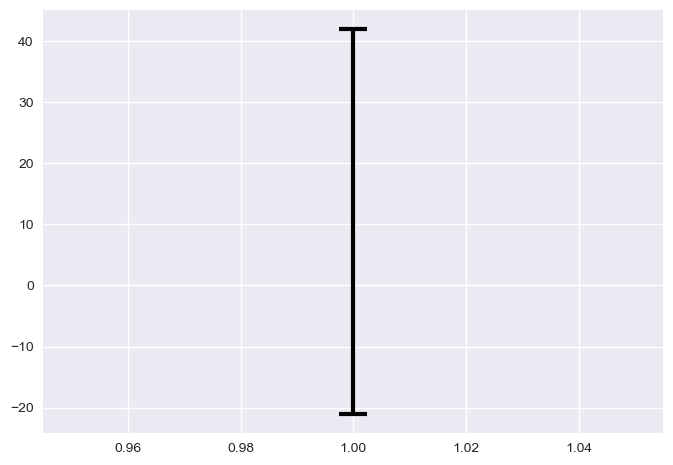

In [117]:
xlabels = ('Total', 'BC prod.', 'BC EOL', 'Wwt', 'Transport', 'Other prod.', 'LS sub.','Elec sub.', 'Heat sub.', 'C seq.')

fig, ax = plt.subplots()

#ax.bar(1, BCBed_Normal_medianClimate)
ax.errorbar(y=BCBed_Normal_medianClimate, x=1, yerr = BCBed_Normal_errorClimate, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedNormalClimateBCProdmedian)
ax.errorbar(y=BCBedNormalClimateBCProdmedian, x=2, yerr = BCBedNormalClimateBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(3, BCBedNormalClimateBCEOLmedian)
ax.errorbar(y=BCBedNormalClimateBCEOLmedian, x=3, yerr = BCBedNormalClimateBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(4, BCBedNormalClimateWwtmedian)
ax.errorbar(y=BCBedNormalClimateWwtmedian, x=4, yerr = BCBedNormalClimateWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(5, BCBedNormalClimateTransportmedian)
ax.errorbar(y=BCBedNormalClimateTransportmedian, x=5, yerr = BCBedNormalClimateTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCBedNormalClimateProdmedian)
ax.errorbar(y=BCBedNormalClimateProdmedian, x=6, yerr = BCBedNormalClimateProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(7, BCBedNormalClimateLSSubmedian)
ax.errorbar(y=BCBedNormalClimateLSSubmedian, x=7, yerr = BCBedNormalClimateLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(8, BCBedNormalClimateElecSubmedian)
ax.errorbar(y=BCBedNormalClimateElecSubmedian, x=8, yerr = BCBedNormalClimateElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

#ax.bar(9, BCBedNormalClimateHeatSubmedian)
ax.errorbar(y=BCBedNormalClimateHeatSubmedian, x=9, yerr = BCBedNormalClimateHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(10, BCBedNormalClimateCseqmedian)
ax.errorbar(y=BCBedNormalClimateCseqmedian, x=10, yerr = BCBedNormalClimateCseqerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='grey')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=10.5, linewidth=1, color='black')

ax.set_title('BC Bed, Normal area, Climate impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9,10))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(climate_label)

In [45]:
#fig.savefig('CA-BCBed-Normal-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [120]:
BCBedNormalresultEutrophication = runAlgebraicGraphTraversal([fu1], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [121]:
BCBedNormalresultEutrophication

{('wwt_db',
  '4936df1f1c8d470380b02907bf2002c5'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.000537345888708734*BCinFilterNormal/LifetimeWW + 0.41894222753009/LifetimeWW],
               'BC prod': [1.24742097144955*BCinFilterNormal*bc_Seqswitch_param_bc1Seq*bc_density_1/LifetimeWW + 1.3262412025719*BCinFilterNormal*bc_Seqswitch_param_bc2Seq*bc_density_2/LifetimeWW + 1.35653087625692*BCinFilterNormal*bc_Seqswitch_param_bc3Seq*bc_density_3/LifetimeWW + 0.863138190519769*BCinFilterNormal*bc_Seqswitch_param_bc4Seq*bc_density_4/LifetimeWW + 1.35894137514376*BCinFilterNormal*bc_Seqswitch_param_bc5Seq*bc_density_5/LifetimeWW + 2.16163889376866*BCinFilterNormal*bc_Seqswitch_param_bc7Seq*bc_density_7/LifetimeWW + 20.843800088153*ImpregBCVolume*Lifetime*bc_HLswitch_param_bc1HL*bc_density_1/(ImpregBCReplNormal*LifetimeWW) + 20.9226203192753*ImpregBCVolume*Lifetime*bc_HLswitch_param_bc2HL*bc_density_2/(ImpregBCReplNormal*LifetimeWW) + 20.9529099929604*I

In [122]:
BCBedNormalEutrophicationProd = BCBedNormalresultEutrophication[list(fu1.keys())[0]]['agg_graph']['Prod'][0]
BCBedNormalEutrophicationBCProd = BCBedNormalresultEutrophication[list(fu1.keys())[0]]['agg_graph']['BC prod'][0]
BCBedNormalEutrophicationHeatSub = BCBedNormalresultEutrophication[list(fu1.keys())[0]]['agg_graph']['Heat sub'][0]
BCBedNormalEutrophicationTransport = BCBedNormalresultEutrophication[list(fu1.keys())[0]]['agg_graph']['Transport'][0]
BCBedNormalEutrophicationBCEOL = BCBedNormalresultEutrophication[list(fu1.keys())[0]]['agg_graph']['BC EOL'][0]
BCBedNormalEutrophicationLSSub = BCBedNormalresultEutrophication[list(fu1.keys())[0]]['agg_graph']['LS sub'][0]
BCBedNormalEutrophicationElecSub = BCBedNormalresultEutrophication[list(fu1.keys())[0]]['agg_graph']['Elec sub'][0]
BCBedNormalEutrophicationWwt = BCBedNormalresultEutrophication[list(fu1.keys())[0]]['agg_graph']['Treatment'][0]

In [123]:
BCBedNormalEutrophicationProdL = createLambda(BCBedNormalEutrophicationProd)
BCBedNormalEutrophicationBCProdL = createLambda(BCBedNormalEutrophicationBCProd)
BCBedNormalEutrophicationHeatSubL = createLambda(BCBedNormalEutrophicationHeatSub)
BCBedNormalEutrophicationTransportL = createLambda(BCBedNormalEutrophicationTransport)
BCBedNormalEutrophicationBCEOL_L = createLambda(BCBedNormalEutrophicationBCEOL)
BCBedNormalEutrophicationLSSubL = createLambda(BCBedNormalEutrophicationLSSub)
BCBedNormalEutrophicationElecSubL = createLambda(BCBedNormalEutrophicationElecSub)
BCBedNormalEutrophicationWwtL = createLambda(BCBedNormalEutrophicationWwt)

BCBedNormalEutrophicationProdY = _compute_stochastics([BCBedNormalEutrophicationProdL], TRACI_eut, params)
BCBedNormalEutrophicationBCProdY = _compute_stochastics([BCBedNormalEutrophicationBCProdL], TRACI_eut, params)
BCBedNormalEutrophicationHeatSubY = _compute_stochastics([BCBedNormalEutrophicationHeatSubL], TRACI_eut, params)
BCBedNormalEutrophicationTransportY = _compute_stochastics([BCBedNormalEutrophicationTransportL], TRACI_eut, params)
BCBedNormalEutrophicationBCEOL_Y = _compute_stochastics([BCBedNormalEutrophicationBCEOL_L], TRACI_eut, params)
BCBedNormalEutrophicationLSSubY = _compute_stochastics([BCBedNormalEutrophicationLSSubL], TRACI_eut, params)
BCBedNormalEutrophicationElecSubY = _compute_stochastics([BCBedNormalEutrophicationElecSubL], TRACI_eut, params)
BCBedNormalEutrophicationWwtY = _compute_stochastics([BCBedNormalEutrophicationWwtL], TRACI_eut, params)

TypeError: lca_algebraic.lca.postMultiLCAAlgebric() argument after ** must be a mapping, not module

In [ ]:
BCBedNormalEutrophicationProdmin = BCBedNormalEutrophicationProdY['eutrophication - eutrophication potential'].min()
BCBedNormalEutrophicationProdmax = BCBedNormalEutrophicationProdY['eutrophication - eutrophication potential'].max()
BCBedNormalEutrophicationProdmedian = BCBedNormalEutrophicationProdY['eutrophication - eutrophication potential'].median()
BCBedNormalEutrophicationProderror = np.array([BCBedNormalEutrophicationProdmedian-BCBedNormalEutrophicationProdmin, BCBedNormalEutrophicationProdmax-BCBedNormalEutrophicationProdmedian]).reshape((2,1))

BCBedNormalEutrophicationBCProdmin = BCBedNormalEutrophicationBCProdY['eutrophication - eutrophication potential'].min()
BCBedNormalEutrophicationBCProdmax = BCBedNormalEutrophicationBCProdY['eutrophication - eutrophication potential'].max()
BCBedNormalEutrophicationBCProdmedian = BCBedNormalEutrophicationBCProdY['eutrophication - eutrophication potential'].median()
BCBedNormalEutrophicationBCProderror = np.array([BCBedNormalEutrophicationBCProdmedian-BCBedNormalEutrophicationBCProdmin, BCBedNormalEutrophicationBCProdmax-BCBedNormalEutrophicationBCProdmedian]).reshape((2,1))

BCBedNormalEutrophicationHeatSubmin = BCBedNormalEutrophicationHeatSubY['eutrophication - eutrophication potential'].min()
BCBedNormalEutrophicationHeatSubmax = BCBedNormalEutrophicationHeatSubY['eutrophication - eutrophication potential'].max()
BCBedNormalEutrophicationHeatSubmedian = BCBedNormalEutrophicationHeatSubY['eutrophication - eutrophication potential'].median()
BCBedNormalEutrophicationHeatSuberror = np.array([BCBedNormalEutrophicationHeatSubmedian-BCBedNormalEutrophicationHeatSubmin, BCBedNormalEutrophicationHeatSubmax-BCBedNormalEutrophicationHeatSubmedian]).reshape((2,1))

BCBedNormalEutrophicationTransportmin = BCBedNormalEutrophicationTransportY['eutrophication - eutrophication potential'].min()
BCBedNormalEutrophicationTransportmax = BCBedNormalEutrophicationTransportY['eutrophication - eutrophication potential'].max()
BCBedNormalEutrophicationTransportmedian = BCBedNormalEutrophicationTransportY['eutrophication - eutrophication potential'].median()
BCBedNormalEutrophicationTransporterror = np.array([BCBedNormalEutrophicationTransportmedian-BCBedNormalEutrophicationTransportmin, BCBedNormalEutrophicationTransportmax-BCBedNormalEutrophicationTransportmedian]).reshape((2,1))

BCBedNormalEutrophicationBCEOLmin = BCBedNormalEutrophicationBCEOL_Y['eutrophication - eutrophication potential'].min()
BCBedNormalEutrophicationBCEOLmax = BCBedNormalEutrophicationBCEOL_Y['eutrophication - eutrophication potential'].max()
BCBedNormalEutrophicationBCEOLmedian = BCBedNormalEutrophicationBCEOL_Y['eutrophication - eutrophication potential'].median()
BCBedNormalEutrophicationBCEOLerror = np.array([BCBedNormalEutrophicationBCEOLmedian-BCBedNormalEutrophicationBCEOLmin, BCBedNormalEutrophicationBCEOLmax-BCBedNormalEutrophicationBCEOLmedian]).reshape((2,1))

BCBedNormalEutrophicationLSSubmin = BCBedNormalEutrophicationLSSubY['eutrophication - eutrophication potential'].min()
BCBedNormalEutrophicationLSSubmax = BCBedNormalEutrophicationLSSubY['eutrophication - eutrophication potential'].max()
BCBedNormalEutrophicationLSSubmedian = BCBedNormalEutrophicationLSSubY['eutrophication - eutrophication potential'].median()
BCBedNormalEutrophicationLSSuberror = np.array([BCBedNormalEutrophicationLSSubmedian-BCBedNormalEutrophicationLSSubmin, BCBedNormalEutrophicationLSSubmax-BCBedNormalEutrophicationLSSubmedian]).reshape((2,1))

BCBedNormalEutrophicationElecSubmin = BCBedNormalEutrophicationElecSubY['eutrophication - eutrophication potential'].min()
BCBedNormalEutrophicationElecSubmax = BCBedNormalEutrophicationElecSubY['eutrophication - eutrophication potential'].max()
BCBedNormalEutrophicationElecSubmedian = BCBedNormalEutrophicationElecSubY['eutrophication - eutrophication potential'].median()
BCBedNormalEutrophicationElecSuberror = np.array([BCBedNormalEutrophicationElecSubmedian-BCBedNormalEutrophicationElecSubmin, BCBedNormalEutrophicationElecSubmax-BCBedNormalEutrophicationElecSubmedian]).reshape((2,1))

BCBedNormalEutrophicationWwtmin = BCBedNormalEutrophicationWwtY['eutrophication - eutrophication potential'].min()
BCBedNormalEutrophicationWwtmax = BCBedNormalEutrophicationWwtY['eutrophication - eutrophication potential'].max()
BCBedNormalEutrophicationWwtmedian = BCBedNormalEutrophicationWwtY['eutrophication - eutrophication potential'].median()
BCBedNormalEutrophicationWwterror = np.array([BCBedNormalEutrophicationWwtmedian-BCBedNormalEutrophicationWwtmin, BCBedNormalEutrophicationWwtmax-BCBedNormalEutrophicationWwtmedian]).reshape((2,1))

In [51]:
xlabels = ('Total', 'Wwt', 'BC prod.', 'Transport', 'BC EOL', 'Other prod.', 'LS sub.', 'Elec sub.', 'Heat sub.')

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

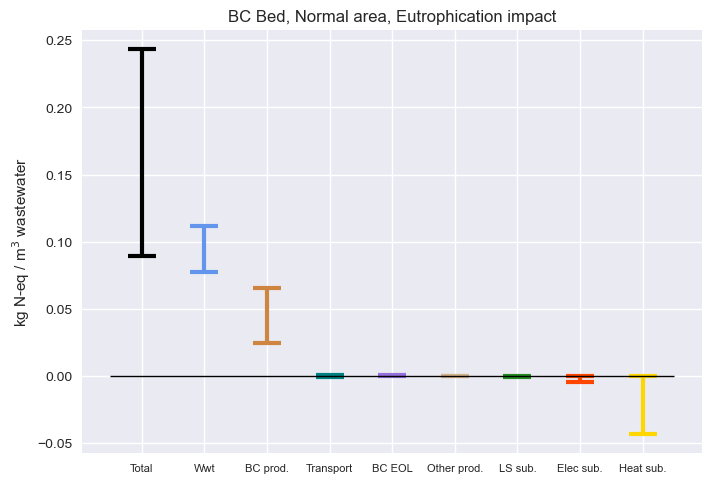

In [52]:
fig, ax = plt.subplots()

#ax.bar(1, BCBed_Normal_medianEutroph)
ax.errorbar(y=BCBed_Normal_medianEutroph, x=1, yerr = BCBed_Normal_errorEutroph, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedNormalEutrophicationWwtmedian)
ax.errorbar(y=BCBedNormalEutrophicationWwtmedian, x=2, yerr = BCBedNormalEutrophicationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCBedNormalEutrophicationBCProdmedian)
ax.errorbar(y=BCBedNormalEutrophicationBCProdmedian, x=3, yerr = BCBedNormalEutrophicationBCProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCBedNormalEutrophicationTransportmedian)
ax.errorbar(y=BCBedNormalEutrophicationTransportmedian, x=4, yerr = BCBedNormalEutrophicationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(5, BCBedNormalEutrophicationBCEOLmedian)
ax.errorbar(y=BCBedNormalEutrophicationBCEOLmedian, x=5, yerr = BCBedNormalEutrophicationBCEOLerror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(6, BCBedNormalEutrophicationProdmedian)
ax.errorbar(y=BCBedNormalEutrophicationProdmedian, x=6, yerr = BCBedNormalEutrophicationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(7, BCBedNormalEutrophicationLSSubmedian)
ax.errorbar(y=BCBedNormalEutrophicationLSSubmedian, x=7, yerr = BCBedNormalEutrophicationLSSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(8, BCBedNormalEutrophicationHeatSubmedian)
ax.errorbar(y=BCBedNormalEutrophicationHeatSubmedian, x=8, yerr = BCBedNormalEutrophicationHeatSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(9, BCBedNormalEutrophicationElecSubmedian)
ax.errorbar(y=BCBedNormalEutrophicationElecSubmedian, x=9, yerr = BCBedNormalEutrophicationElecSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_title('BC Bed, Normal area, Eutrophication impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(eutroph_label)

In [53]:
#fig.savefig('CA-BCBed-Normal-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [54]:
BCBedNormalresultAcidification= runAlgebraicGraphTraversal([fu1], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [55]:
BCBedNormalresultAcidification

{('wwt_db',
  '4936df1f1c8d470380b02907bf2002c5'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.00362462417361865*BCinFilterNormal/LifetimeWW + 0.989779577679765/LifetimeWW],
               'BC prod': [1.50143937953037*BCinFilterNormal*bc_Seqswitch_param_bc1Seq*bc_density_1/LifetimeWW + 1.73721311156945*BCinFilterNormal*bc_Seqswitch_param_bc2Seq*bc_density_2/LifetimeWW + 6.07825849490467*BCinFilterNormal*bc_Seqswitch_param_bc3Seq*bc_density_3/LifetimeWW + 0.972340242888536*BCinFilterNormal*bc_Seqswitch_param_bc4Seq*bc_density_4/LifetimeWW + 6.95273846086561*BCinFilterNormal*bc_Seqswitch_param_bc5Seq*bc_density_5/LifetimeWW + 8.04282844032353*BCinFilterNormal*bc_Seqswitch_param_bc7Seq*bc_density_7/LifetimeWW + 28.1627762057582*ImpregBCVolume*Lifetime*bc_HLswitch_param_bc1HL*bc_density_1/(ImpregBCReplNormal*LifetimeWW) + 28.3985499377973*ImpregBCVolume*Lifetime*bc_HLswitch_param_bc2HL*bc_density_2/(ImpregBCReplNormal*LifetimeWW) + 32.7395953211325

In [56]:
BCBedNormalAcidificationProd = BCBedNormalresultAcidification[list(fu1.keys())[0]]['agg_graph']['Prod'][0]
BCBedNormalAcidificationBCProd = BCBedNormalresultAcidification[list(fu1.keys())[0]]['agg_graph']['BC prod'][0]
BCBedNormalAcidificationHeatSub = BCBedNormalresultAcidification[list(fu1.keys())[0]]['agg_graph']['Heat sub'][0]
BCBedNormalAcidificationTransport = BCBedNormalresultAcidification[list(fu1.keys())[0]]['agg_graph']['Transport'][0]
BCBedNormalAcidificationBCEOL = BCBedNormalresultAcidification[list(fu1.keys())[0]]['agg_graph']['BC EOL'][0]
BCBedNormalAcidificationLSSub = BCBedNormalresultAcidification[list(fu1.keys())[0]]['agg_graph']['LS sub'][0]
BCBedNormalAcidificationElecSub = BCBedNormalresultAcidification[list(fu1.keys())[0]]['agg_graph']['Elec sub'][0]
BCBedNormalAcidificationWwt = BCBedNormalresultAcidification[list(fu1.keys())[0]]['agg_graph']['Treatment'][0]

In [57]:
BCBedNormalAcidificationProdL = createLambda(BCBedNormalAcidificationProd)
BCBedNormalAcidificationBCProdL = createLambda(BCBedNormalAcidificationBCProd)
BCBedNormalAcidificationHeatSubL = createLambda(BCBedNormalAcidificationHeatSub)
BCBedNormalAcidificationTransportL = createLambda(BCBedNormalAcidificationTransport)
BCBedNormalAcidificationBCEOL_L = createLambda(BCBedNormalAcidificationBCEOL)
BCBedNormalAcidificationLSSubL = createLambda(BCBedNormalAcidificationLSSub)
BCBedNormalAcidificationElecSubL = createLambda(BCBedNormalAcidificationElecSub)
BCBedNormalAcidificationWwtL = createLambda(BCBedNormalAcidificationWwt)

BCBedNormalAcidificationProdY = _compute_stochastics([BCBedNormalAcidificationProdL], CML_acid, params)
BCBedNormalAcidificationBCProdY = _compute_stochastics([BCBedNormalAcidificationBCProdL], CML_acid, params)
BCBedNormalAcidificationHeatSubY = _compute_stochastics([BCBedNormalAcidificationHeatSubL], CML_acid, params)
BCBedNormalAcidificationTransportY = _compute_stochastics([BCBedNormalAcidificationTransportL], CML_acid, params)
BCBedNormalAcidificationBCEOL_Y = _compute_stochastics([BCBedNormalAcidificationBCEOL_L], CML_acid, params)
BCBedNormalAcidificationLSSubY = _compute_stochastics([BCBedNormalAcidificationLSSubL], CML_acid, params)
BCBedNormalAcidificationElecSubY = _compute_stochastics([BCBedNormalAcidificationElecSubL], CML_acid, params)
BCBedNormalAcidificationWwtY = _compute_stochastics([BCBedNormalAcidificationWwtL], CML_acid, params)

In [58]:
BCBedNormalAcidificationProdmin = BCBedNormalAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedNormalAcidificationProdmax = BCBedNormalAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedNormalAcidificationProdmedian = BCBedNormalAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedNormalAcidificationProderror = np.array([BCBedNormalAcidificationProdmedian-BCBedNormalAcidificationProdmin, BCBedNormalAcidificationProdmax-BCBedNormalAcidificationProdmedian]).reshape((2,1))

BCBedNormalAcidificationBCProdmin = BCBedNormalAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedNormalAcidificationBCProdmax = BCBedNormalAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedNormalAcidificationBCProdmedian = BCBedNormalAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedNormalAcidificationBCProderror = np.array([BCBedNormalAcidificationBCProdmedian-BCBedNormalAcidificationBCProdmin, BCBedNormalAcidificationBCProdmax-BCBedNormalAcidificationBCProdmedian]).reshape((2,1))

BCBedNormalAcidificationHeatSubmin = BCBedNormalAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedNormalAcidificationHeatSubmax = BCBedNormalAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedNormalAcidificationHeatSubmedian = BCBedNormalAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedNormalAcidificationHeatSuberror = np.array([BCBedNormalAcidificationHeatSubmedian-BCBedNormalAcidificationHeatSubmin, BCBedNormalAcidificationHeatSubmax-BCBedNormalAcidificationHeatSubmedian]).reshape((2,1))

BCBedNormalAcidificationTransportmin = BCBedNormalAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedNormalAcidificationTransportmax = BCBedNormalAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedNormalAcidificationTransportmedian = BCBedNormalAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedNormalAcidificationTransporterror = np.array([BCBedNormalAcidificationTransportmedian-BCBedNormalAcidificationTransportmin, BCBedNormalAcidificationTransportmax-BCBedNormalAcidificationTransportmedian]).reshape((2,1))

BCBedNormalAcidificationBCEOLmin = BCBedNormalAcidificationBCEOL_Y['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedNormalAcidificationBCEOLmax = BCBedNormalAcidificationBCEOL_Y['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedNormalAcidificationBCEOLmedian = BCBedNormalAcidificationBCEOL_Y['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedNormalAcidificationBCEOLerror = np.array([BCBedNormalAcidificationBCEOLmedian-BCBedNormalAcidificationBCEOLmin, BCBedNormalAcidificationBCEOLmax-BCBedNormalAcidificationBCEOLmedian]).reshape((2,1))

BCBedNormalAcidificationLSSubmin = BCBedNormalAcidificationLSSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedNormalAcidificationLSSubmax = BCBedNormalAcidificationLSSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedNormalAcidificationLSSubmedian = BCBedNormalAcidificationLSSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedNormalAcidificationLSSuberror = np.array([BCBedNormalAcidificationLSSubmedian-BCBedNormalAcidificationLSSubmin, BCBedNormalAcidificationLSSubmax-BCBedNormalAcidificationLSSubmedian]).reshape((2,1))

BCBedNormalAcidificationElecSubmin = BCBedNormalAcidificationElecSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedNormalAcidificationElecSubmax = BCBedNormalAcidificationElecSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedNormalAcidificationElecSubmedian = BCBedNormalAcidificationElecSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedNormalAcidificationElecSuberror = np.array([BCBedNormalAcidificationElecSubmedian-BCBedNormalAcidificationElecSubmin, BCBedNormalAcidificationElecSubmax-BCBedNormalAcidificationElecSubmedian]).reshape((2,1))

BCBedNormalAcidificationWwtmin = BCBedNormalAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedNormalAcidificationWwtmax = BCBedNormalAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedNormalAcidificationWwtmedian = BCBedNormalAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedNormalAcidificationWwterror = np.array([BCBedNormalAcidificationWwtmedian-BCBedNormalAcidificationWwtmin, BCBedNormalAcidificationWwtmax-BCBedNormalAcidificationWwtmedian]).reshape((2,1))


In [59]:
xlabels = ('Total','BC prod.', 'Wwt','BC EOL', 'Transport', 'Other prod.','LS sub.','Heat sub.','Elec sub.')

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

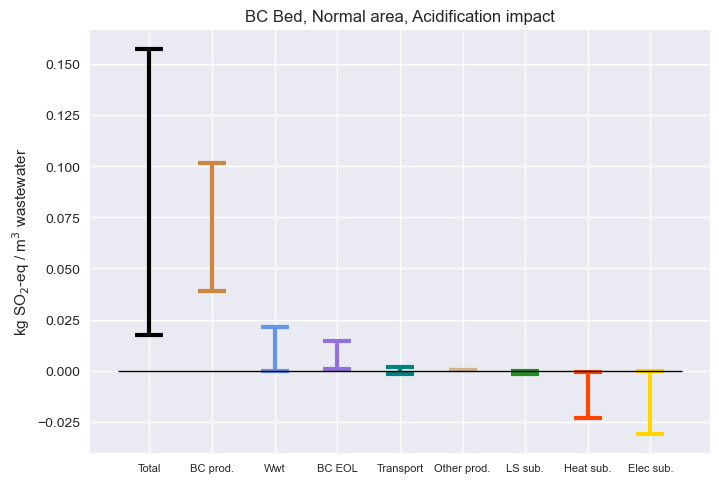

In [60]:
fig, ax = plt.subplots()

#ax.bar(1, BCBed_Normal_medianAcid)
ax.errorbar(y=BCBed_Normal_medianAcid, x=1, yerr = BCBed_Normal_errorAcid, capsize=10,
    elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedNormalAcidificationBCProdmedian)
ax.errorbar(y=BCBedNormalAcidificationBCProdmedian, x=2, yerr = BCBedNormalAcidificationBCProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(3, BCBedNormalAcidificationWwtmedian)
ax.errorbar(y=BCBedNormalAcidificationWwtmedian, x=3, yerr = BCBedNormalAcidificationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(4, BCBedNormalAcidificationBCEOLmedian)
ax.errorbar(y=BCBedNormalAcidificationBCEOLmedian, x=4, yerr = BCBedNormalAcidificationBCEOLerror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCBedNormalAcidificationTransportmedian)
ax.errorbar(y=BCBedNormalAcidificationTransportmedian, x=5, yerr = BCBedNormalAcidificationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCBedNormalAcidificationProdmedian)
ax.errorbar(y=BCBedNormalAcidificationProdmedian, x=6, yerr = BCBedNormalAcidificationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(7, BCBedNormalAcidificationLSSubmedian)
ax.errorbar(y=BCBedNormalAcidificationLSSubmedian, x=7, yerr = BCBedNormalAcidificationLSSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(8, BCBedNormalAcidificationHeatSubmedian)
ax.errorbar(y=BCBedNormalAcidificationHeatSubmedian, x=8, yerr = BCBedNormalAcidificationHeatSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(9, BCBedNormalAcidificationElecSubmedian)
ax.errorbar(y=BCBedNormalAcidificationElecSubmedian, x=9, yerr = BCBedNormalAcidificationElecSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_title('BC Bed, Normal area, Acidification impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(acid_label)

In [61]:
#fig.savefig('CA-BCBed-Normal-Acid', dpi=600, bbox_inches='tight')

#### Sand normal

##### climate

In [62]:
SandNormalresultClimate = runAlgebraicGraphTraversal([fu2], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [63]:
SandNormalresultClimate

{('wwt_db',
  '0fbe01da943e4d4aa7c3d39337be5ddf'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.582000281395534*SandFilterVolume/LifetimeWW + 289.733577645994/LifetimeWW],
               'Sand prod': [5.87125187536048e-8*SandinFilter*sand_switch_param_sand/LifetimeWW],
               'Transport': [0.000184904491741122*PlasticSTWeight*TransportDistanceST/LifetimeWW + 2.05221411477383e-9*SandinFilter*TransportDistanceFilter*sand_switch_param_sand/LifetimeWW],
               'Treatment': [0.027*CH4air + 0.273*N2Oair*NremovalSand*Ntotin*(1 - NremovalSludge)/N2Ocalc]}), 'graph': [{'activity': 'Sand Normal System' (unit, GLO, None),
    'amount': 1,
    'tag': 'other',
    'secondary_tags': [],
    'impact': [0],
    'biosphere': [],
    'technosphere': [{'activity': 'Sand Normal Prod' (unit, GLO, None),
      'amount': 1/LifetimeWW,
      'tag': 'Prod',
      'secondary_tags': [],
      'impact': [0.582000281395534*SandFilterVolume/LifetimeWW],
     

In [64]:
SandNormalClimateProd = SandNormalresultClimate[list(fu2.keys())[0]]['agg_graph']['Prod'][0]
SandNormalClimateSandProd = SandNormalresultClimate[list(fu2.keys())[0]]['agg_graph']['Sand prod'][0]
SandNormalClimateTransport = SandNormalresultClimate[list(fu2.keys())[0]]['agg_graph']['Transport'][0]
SandNormalClimateWwt = SandNormalresultClimate[list(fu2.keys())[0]]['agg_graph']['Treatment'][0]

In [65]:
SandNormalClimateProdL = createLambda(SandNormalClimateProd)
SandNormalClimateSandProdL = createLambda(SandNormalClimateSandProd)
SandNormalClimateTransportL = createLambda(SandNormalClimateTransport)
SandNormalClimateWwtL = createLambda(SandNormalClimateWwt)

In [66]:
SandNormalClimateProdY = _compute_stochastics([SandNormalClimateProdL], IPCC, params)
SandNormalClimateSandProdY = _compute_stochastics([SandNormalClimateSandProdL], IPCC, params)
SandNormalClimateTransportY = _compute_stochastics([SandNormalClimateTransportL], IPCC, params)
SandNormalClimateWwtY = _compute_stochastics([SandNormalClimateWwtL], IPCC, params)

In [67]:
SandNormalClimateProdmin = SandNormalClimateProdY['climate change - global warming potential (GWP100)'].min()
SandNormalClimateProdmax = SandNormalClimateProdY['climate change - global warming potential (GWP100)'].max()
SandNormalClimateProdmedian = SandNormalClimateProdY['climate change - global warming potential (GWP100)'].median()
SandNormalClimateProderror = np.array([SandNormalClimateProdmedian-SandNormalClimateProdmin, SandNormalClimateProdmax-SandNormalClimateProdmedian]).reshape((2,1))

In [68]:
SandNormalClimateSandProdmin = SandNormalClimateSandProdY['climate change - global warming potential (GWP100)'].min()
SandNormalClimateSandProdmax = SandNormalClimateSandProdY['climate change - global warming potential (GWP100)'].max()
SandNormalClimateSandProdmedian = SandNormalClimateSandProdY['climate change - global warming potential (GWP100)'].median()
SandNormalClimateSandProderror = np.array([SandNormalClimateSandProdmedian-SandNormalClimateSandProdmin, SandNormalClimateSandProdmax-SandNormalClimateSandProdmedian]).reshape((2,1))

In [69]:
SandNormalClimateTransportmin = SandNormalClimateTransportY['climate change - global warming potential (GWP100)'].min()
SandNormalClimateTransportmax = SandNormalClimateTransportY['climate change - global warming potential (GWP100)'].max()
SandNormalClimateTransportmedian = SandNormalClimateTransportY['climate change - global warming potential (GWP100)'].median()
SandNormalClimateTransporterror = np.array([SandNormalClimateTransportmedian-SandNormalClimateTransportmin, SandNormalClimateTransportmax-SandNormalClimateTransportmedian]).reshape((2,1))

In [70]:
SandNormalClimateWwtmin = SandNormalClimateWwtY['climate change - global warming potential (GWP100)'].min()
SandNormalClimateWwtmax = SandNormalClimateWwtY['climate change - global warming potential (GWP100)'].max()
SandNormalClimateWwtmedian = SandNormalClimateWwtY['climate change - global warming potential (GWP100)'].median()
SandNormalClimateWwterror = np.array([SandNormalClimateWwtmedian-SandNormalClimateWwtmin, SandNormalClimateWwtmax-SandNormalClimateWwtmedian]).reshape((2,1))

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

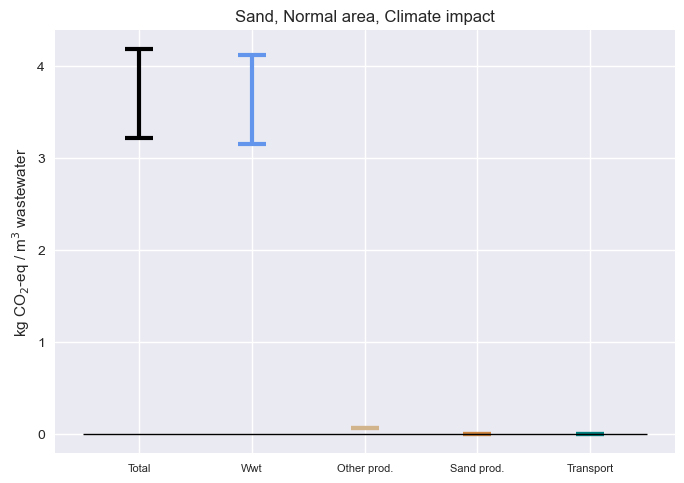

In [71]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

#ax.bar(1, Sand_Normal_medianClimate)
ax.errorbar(y=Sand_Normal_medianClimate, x=1, yerr = Sand_Normal_errorClimate, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, SandNormalClimateWwtmedian)
ax.errorbar(y=SandNormalClimateWwtmedian, x=2, yerr = SandNormalClimateWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, SandNormalClimateProdmedian)
ax.errorbar(y=SandNormalClimateProdmedian, x=3, yerr = SandNormalClimateProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(4, SandNormalClimateSandProdmedian)
ax.errorbar(y=SandNormalClimateSandProdmedian, x=4, yerr = SandNormalClimateSandProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(5, SandNormalClimateTransportmedian)
ax.errorbar(y=SandNormalClimateTransportmedian, x=5, yerr = SandNormalClimateTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Normal area, Climate impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(climate_label)

In [72]:
#fig.savefig('CA-Sand-Normal-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [73]:
SandNormalresultEutrophication= runAlgebraicGraphTraversal([fu2], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [74]:
SandNormalresultEutrophication

{('wwt_db',
  '0fbe01da943e4d4aa7c3d39337be5ddf'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.000537345888708734*SandFilterVolume/LifetimeWW + 0.41894222753009/LifetimeWW],
               'Sand prod': [7.2778846392511e-11*SandinFilter*sand_switch_param_sand/LifetimeWW],
               'Transport': [1.33589489895468e-7*PlasticSTWeight*TransportDistanceST/LifetimeWW + 1.48268024301296e-12*SandinFilter*TransportDistanceFilter*sand_switch_param_sand/LifetimeWW],
               'Treatment': [5.0e-5*BOD5in*(1 - BOD5RemovalSludge)*(1 - BOD5removalSand) + 0.000150118105922054*N2air*NremovalSand*Ntotin*(1 - NremovalSludge) + 0.0001186*NH3air*NremovalSand*Ntotin*(1 - NremovalSludge)/NH3calc + 0.00729*PorgInPoutSand*Ptotin*(1 - PremovalSand)*(1 - PremovalSludge) + 0.00238*Ptotin*(1 - PorgInPoutSand)*(1 - PremovalSand)*(1 - PremovalSludge)/PO4calc + 0.0002367*NO3water*Ntotin*(1 - NremovalSand)*(1 - NremovalSludge)/NO3calc + 0.0007793*NH4water*Ntotin*(1 - 

In [75]:
SandNormalEutrophicationProd = SandNormalresultEutrophication[list(fu2.keys())[0]]['agg_graph']['Prod'][0]
SandNormalEutrophicationSandProd = SandNormalresultEutrophication[list(fu2.keys())[0]]['agg_graph']['Sand prod'][0]
SandNormalEutrophicationTransport = SandNormalresultEutrophication[list(fu2.keys())[0]]['agg_graph']['Transport'][0]
SandNormalEutrophicationWwt = SandNormalresultEutrophication[list(fu2.keys())[0]]['agg_graph']['Treatment'][0]

In [76]:
SandNormalEutrophicationProdL = createLambda(SandNormalEutrophicationProd)
SandNormalEutrophicationSandProdL = createLambda(SandNormalEutrophicationSandProd)
SandNormalEutrophicationTransportL = createLambda(SandNormalEutrophicationTransport)
SandNormalEutrophicationWwtL = createLambda(SandNormalEutrophicationWwt)

In [77]:
SandNormalEutrophicationProdY = _compute_stochastics([SandNormalEutrophicationProdL], TRACI_eut, params)
SandNormalEutrophicationSandProdY = _compute_stochastics([SandNormalEutrophicationSandProdL], TRACI_eut, params)
SandNormalEutrophicationTransportY = _compute_stochastics([SandNormalEutrophicationTransportL], TRACI_eut, params)
SandNormalEutrophicationWwtY = _compute_stochastics([SandNormalEutrophicationWwtL], TRACI_eut, params)

In [78]:
SandNormalEutrophicationProdmin = SandNormalEutrophicationProdY['eutrophication - eutrophication potential'].min()
SandNormalEutrophicationProdmax = SandNormalEutrophicationProdY['eutrophication - eutrophication potential'].max()
SandNormalEutrophicationProdmedian = SandNormalEutrophicationProdY['eutrophication - eutrophication potential'].median()
SandNormalEutrophicationProderror = np.array([SandNormalEutrophicationProdmedian-SandNormalEutrophicationProdmin, SandNormalEutrophicationProdmax-SandNormalEutrophicationProdmedian]).reshape((2,1))

SandNormalEutrophicationSandProdmin = SandNormalEutrophicationSandProdY['eutrophication - eutrophication potential'].min()
SandNormalEutrophicationSandProdmax = SandNormalEutrophicationSandProdY['eutrophication - eutrophication potential'].max()
SandNormalEutrophicationSandProdmedian = SandNormalEutrophicationSandProdY['eutrophication - eutrophication potential'].median()
SandNormalEutrophicationSandProderror = np.array([SandNormalEutrophicationSandProdmedian-SandNormalEutrophicationSandProdmin, SandNormalEutrophicationSandProdmax-SandNormalEutrophicationSandProdmedian]).reshape((2,1))

SandNormalEutrophicationTransportmin = SandNormalEutrophicationTransportY['eutrophication - eutrophication potential'].min()
SandNormalEutrophicationTransportmax = SandNormalEutrophicationTransportY['eutrophication - eutrophication potential'].max()
SandNormalEutrophicationTransportmedian = SandNormalEutrophicationTransportY['eutrophication - eutrophication potential'].median()
SandNormalEutrophicationTransporterror = np.array([SandNormalEutrophicationTransportmedian-SandNormalEutrophicationTransportmin, SandNormalEutrophicationTransportmax-SandNormalEutrophicationTransportmedian]).reshape((2,1))

SandNormalEutrophicationWwtmin = SandNormalEutrophicationWwtY['eutrophication - eutrophication potential'].min()
SandNormalEutrophicationWwtmax = SandNormalEutrophicationWwtY['eutrophication - eutrophication potential'].max()
SandNormalEutrophicationWwtmedian = SandNormalEutrophicationWwtY['eutrophication - eutrophication potential'].median()
SandNormalEutrophicationWwterror = np.array([SandNormalEutrophicationWwtmedian-SandNormalEutrophicationWwtmin, SandNormalEutrophicationWwtmax-SandNormalEutrophicationWwtmedian]).reshape((2,1))

In [79]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

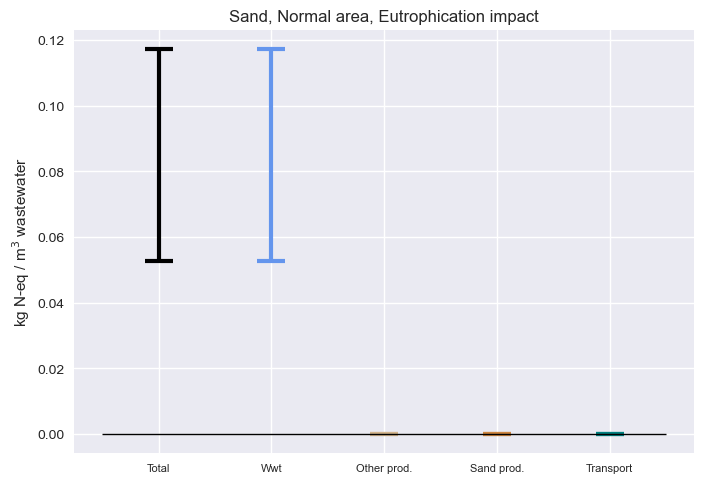

In [80]:
fig, ax = plt.subplots()

#ax.bar(1, Sand_Normal_medianEutroph)
ax.errorbar(y=Sand_Normal_medianEutroph, x=1, yerr = Sand_Normal_errorEutroph, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, SandNormalEutrophicationWwtmedian)
ax.errorbar(y=SandNormalEutrophicationWwtmedian, x=2, yerr = SandNormalEutrophicationWwterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, SandNormalEutrophicationProdmedian)
ax.errorbar(y=SandNormalEutrophicationProdmedian, x=3, yerr = SandNormalEutrophicationProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(4, SandNormalEutrophicationSandProdmedian)
ax.errorbar(y=SandNormalEutrophicationSandProdmedian, x=4, yerr = SandNormalEutrophicationSandProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(5, SandNormalEutrophicationTransportmedian)
ax.errorbar(y=SandNormalEutrophicationTransportmedian, x=5, yerr = SandNormalEutrophicationTransporterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Normal area, Eutrophication impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(eutroph_label)

In [81]:
#fig.savefig('CA-Sand-Normal-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [82]:
SandNormalresultAcidification= runAlgebraicGraphTraversal([fu2], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [83]:
SandNormalresultAcidification

{('wwt_db',
  '0fbe01da943e4d4aa7c3d39337be5ddf'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.00362462417361865*SandFilterVolume/LifetimeWW + 0.989779577679765/LifetimeWW],
               'Sand prod': [2.68235613879553e-10*SandinFilter*sand_switch_param_sand/LifetimeWW],
               'Transport': [3.24948898768936e-7*PlasticSTWeight*TransportDistanceST/LifetimeWW + 3.60653605736888e-12*SandinFilter*TransportDistanceFilter*sand_switch_param_sand/LifetimeWW],
               'Treatment': [0.0016*NH3air*NremovalSand*Ntotin*(1 - NremovalSludge)/NH3calc]}), 'graph': [{'activity': 'Sand Normal System' (unit, GLO, None),
    'amount': 1,
    'tag': 'other',
    'secondary_tags': [],
    'impact': [0],
    'biosphere': [],
    'technosphere': [{'activity': 'Sand Normal Prod' (unit, GLO, None),
      'amount': 1/LifetimeWW,
      'tag': 'Prod',
      'secondary_tags': [],
      'impact': [0.00362462417361865*SandFilterVolume/LifetimeWW],
      'biosph

In [84]:
SandNormalAcidificationProd = SandNormalresultAcidification[list(fu2.keys())[0]]['agg_graph']['Prod'][0]
SandNormalAcidificationSandProd = SandNormalresultAcidification[list(fu2.keys())[0]]['agg_graph']['Sand prod'][0]
SandNormalAcidificationTransport = SandNormalresultAcidification[list(fu2.keys())[0]]['agg_graph']['Transport'][0]
SandNormalAcidificationWwt = SandNormalresultAcidification[list(fu2.keys())[0]]['agg_graph']['Treatment'][0]

In [85]:
SandNormalAcidificationProdL = createLambda(SandNormalAcidificationProd)
SandNormalAcidificationSandProdL = createLambda(SandNormalAcidificationSandProd)
SandNormalAcidificationTransportL = createLambda(SandNormalAcidificationTransport)
SandNormalAcidificationWwtL = createLambda(SandNormalAcidificationWwt)

In [86]:
SandNormalAcidificationProdY = _compute_stochastics([SandNormalAcidificationProdL], CML_acid, params)
SandNormalAcidificationSandProdY = _compute_stochastics([SandNormalAcidificationSandProdL], CML_acid, params)
SandNormalAcidificationTransportY = _compute_stochastics([SandNormalAcidificationTransportL], CML_acid, params)
SandNormalAcidificationWwtY = _compute_stochastics([SandNormalAcidificationWwtL], CML_acid, params)

In [87]:
SandNormalAcidificationProdmin = SandNormalAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
SandNormalAcidificationProdmax = SandNormalAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
SandNormalAcidificationProdmedian = SandNormalAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
SandNormalAcidificationProderror = np.array([SandNormalAcidificationProdmedian-SandNormalAcidificationProdmin, SandNormalAcidificationProdmax-SandNormalAcidificationProdmedian]).reshape((2,1))

SandNormalAcidificationSandProdmin = SandNormalAcidificationSandProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
SandNormalAcidificationSandProdmax = SandNormalAcidificationSandProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
SandNormalAcidificationSandProdmedian = SandNormalAcidificationSandProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
SandNormalAcidificationSandProderror = np.array([SandNormalAcidificationSandProdmedian-SandNormalAcidificationSandProdmin, SandNormalAcidificationSandProdmax-SandNormalAcidificationSandProdmedian]).reshape((2,1))

SandNormalAcidificationTransportmin = SandNormalAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
SandNormalAcidificationTransportmax = SandNormalAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
SandNormalAcidificationTransportmedian = SandNormalAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
SandNormalAcidificationTransporterror = np.array([SandNormalAcidificationTransportmedian-SandNormalAcidificationTransportmin, SandNormalAcidificationTransportmax-SandNormalAcidificationTransportmedian]).reshape((2,1))

SandNormalAcidificationWwtmin = SandNormalAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
SandNormalAcidificationWwtmax = SandNormalAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
SandNormalAcidificationWwtmedian = SandNormalAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
SandNormalAcidificationWwterror = np.array([SandNormalAcidificationWwtmedian-SandNormalAcidificationWwtmin, SandNormalAcidificationWwtmax-SandNormalAcidificationWwtmedian]).reshape((2,1))

In [88]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

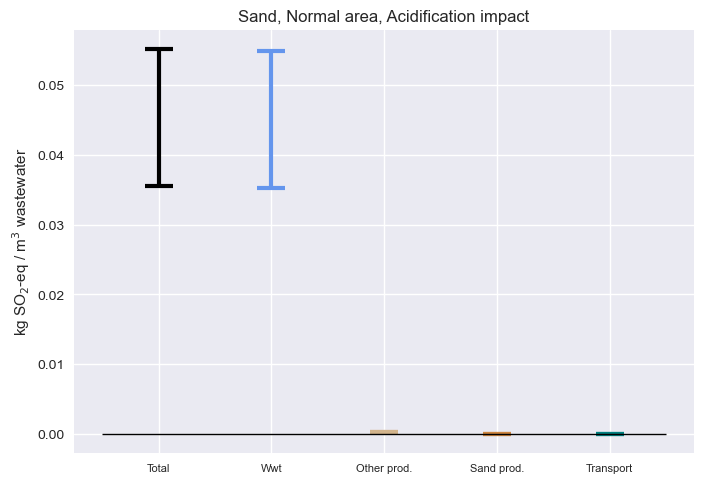

In [89]:
fig, ax = plt.subplots()

#ax.bar(1, Sand_Normal_medianAcid)
ax.errorbar(y=Sand_Normal_medianAcid, x=1, yerr = Sand_Normal_errorAcid, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, SandNormalAcidificationWwtmedian)
ax.errorbar(y=SandNormalAcidificationWwtmedian, x=2, yerr = SandNormalAcidificationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, SandNormalAcidificationProdmedian)
ax.errorbar(y=SandNormalAcidificationProdmedian, x=3, yerr = SandNormalAcidificationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(4, SandNormalAcidificationSandProdmedian)
ax.errorbar(y=SandNormalAcidificationSandProdmedian, x=4, yerr = SandNormalAcidificationSandProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(5, SandNormalAcidificationTransportmedian)
ax.errorbar(y=SandNormalAcidificationTransportmedian, x=5, yerr = SandNormalAcidificationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Normal area, Acidification impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(acid_label)

In [90]:
#fig.savefig('CA-Sand-Normal-Acid', dpi=600, bbox_inches='tight')

#### Bc Bed Sensitive

##### Climate

In [91]:
BCBedSensitiveresultClimate = runAlgebraicGraphTraversal([fu3], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [92]:
BCBedSensitiveresultClimate

{('wwt_db',
  '478174ce5a594287a039bdc23757b240'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.582000281395534*BCinFilterSensitive/LifetimeWW + 289.733577645994/LifetimeWW],
               'BC prod': [-301.368726974128*BCinFilterSensitive*bc_Seqswitch_param_bc1Seq*bc_density_1/LifetimeWW - 142.928149004155*BCinFilterSensitive*bc_Seqswitch_param_bc2Seq*bc_density_2/LifetimeWW + 1770.61627783165*BCinFilterSensitive*bc_Seqswitch_param_bc3Seq*bc_density_3/LifetimeWW - 229.177799977*BCinFilterSensitive*bc_Seqswitch_param_bc4Seq*bc_density_4/LifetimeWW + 2910.96039438655*BCinFilterSensitive*bc_Seqswitch_param_bc5Seq*bc_density_5/LifetimeWW + 2079.70417644412*BCinFilterSensitive*bc_Seqswitch_param_bc7Seq*bc_density_7/LifetimeWW],
               'Heat sub': [30.9326586747031*BCinFilterSensitive*bc_Seqswitch_param_bc1Seq*bc_density_1*heat_switch_param_heatNaturalGas*(-wps_eta_h*(-wps_LHV_bc_dry + wps_LHV_bio_dry/wps_y_bc + 3.6*wps_i_el) + wps_h_d*(1 - w

In [93]:
BCBedSensitiveClimateProd = BCBedSensitiveresultClimate[list(fu3.keys())[0]]['agg_graph']['Prod'][0]
BCBedSensitiveClimateBCProd = BCBedSensitiveresultClimate[list(fu3.keys())[0]]['agg_graph']['BC prod'][0]
BCBedSensitiveClimateHeatSub = BCBedSensitiveresultClimate[list(fu3.keys())[0]]['agg_graph']['Heat sub'][0]
BCBedSensitiveClimateTransport = BCBedSensitiveresultClimate[list(fu3.keys())[0]]['agg_graph']['Transport'][0]
BCBedSensitiveClimateCseq = BCBedSensitiveresultClimate[list(fu3.keys())[0]]['agg_graph']['C seq'][0]
BCBedSensitiveClimateWwt = BCBedSensitiveresultClimate[list(fu3.keys())[0]]['agg_graph']['Treatment'][0]

In [94]:
BCBedSensitiveClimateProdL = createLambda(BCBedSensitiveClimateProd)
BCBedSensitiveClimateBCProdL = createLambda(BCBedSensitiveClimateBCProd)
BCBedSensitiveClimateHeatSubL = createLambda(BCBedSensitiveClimateHeatSub)
BCBedSensitiveClimateTransportL = createLambda(BCBedSensitiveClimateTransport)
BCBedSensitiveClimateCseqL = createLambda(BCBedSensitiveClimateCseq)
BCBedSensitiveClimateWwtL = createLambda(BCBedSensitiveClimateWwt)

In [95]:
BCBedSensitiveClimateProdY = _compute_stochastics([BCBedSensitiveClimateProdL], IPCC, params)
BCBedSensitiveClimateBCProdY = _compute_stochastics([BCBedSensitiveClimateBCProdL], IPCC, params)
BCBedSensitiveClimateHeatSubY = _compute_stochastics([BCBedSensitiveClimateHeatSubL], IPCC, params)
BCBedSensitiveClimateTransportY = _compute_stochastics([BCBedSensitiveClimateTransportL], IPCC, params)
BCBedSensitiveClimateCseqY  = _compute_stochastics([BCBedSensitiveClimateCseqL], IPCC, params)
BCBedSensitiveClimateWwtY = _compute_stochastics([BCBedSensitiveClimateWwtL], IPCC, params)

In [96]:
BCBedSensitiveClimateProdmin = BCBedSensitiveClimateProdY['climate change - global warming potential (GWP100)'].min()
BCBedSensitiveClimateProdmax = BCBedSensitiveClimateProdY['climate change - global warming potential (GWP100)'].max()
BCBedSensitiveClimateProdmedian = BCBedSensitiveClimateProdY['climate change - global warming potential (GWP100)'].median()
BCBedSensitiveClimateProderror = np.array([BCBedSensitiveClimateProdmedian-BCBedSensitiveClimateProdmin, BCBedSensitiveClimateProdmax-BCBedSensitiveClimateProdmedian]).reshape((2,1))

In [97]:
BCBedSensitiveClimateBCProdmin = BCBedSensitiveClimateBCProdY['climate change - global warming potential (GWP100)'].min()
BCBedSensitiveClimateBCProdmax = BCBedSensitiveClimateBCProdY['climate change - global warming potential (GWP100)'].max()
BCBedSensitiveClimateBCProdmedian = BCBedSensitiveClimateBCProdY['climate change - global warming potential (GWP100)'].median()
BCBedSensitiveClimateBCProderror = np.array([BCBedSensitiveClimateBCProdmedian-BCBedSensitiveClimateBCProdmin, BCBedSensitiveClimateBCProdmax-BCBedSensitiveClimateBCProdmedian]).reshape((2,1))

In [98]:
BCBedSensitiveClimateHeatSubmin = BCBedSensitiveClimateHeatSubY['climate change - global warming potential (GWP100)'].min()
BCBedSensitiveClimateHeatSubmax = BCBedSensitiveClimateHeatSubY['climate change - global warming potential (GWP100)'].max()
BCBedSensitiveClimateHeatSubmedian = BCBedSensitiveClimateHeatSubY['climate change - global warming potential (GWP100)'].median()
BCBedSensitiveClimateHeatSuberror = np.array([BCBedSensitiveClimateHeatSubmedian-BCBedSensitiveClimateHeatSubmin, BCBedSensitiveClimateHeatSubmax-BCBedSensitiveClimateHeatSubmedian]).reshape((2,1))

In [99]:
BCBedSensitiveClimateTransportmin = BCBedSensitiveClimateTransportY['climate change - global warming potential (GWP100)'].min()
BCBedSensitiveClimateTransportmax = BCBedSensitiveClimateTransportY['climate change - global warming potential (GWP100)'].max()
BCBedSensitiveClimateTransportmedian = BCBedSensitiveClimateTransportY['climate change - global warming potential (GWP100)'].median()
BCBedSensitiveClimateTransporterror = np.array([BCBedSensitiveClimateTransportmedian-BCBedSensitiveClimateTransportmin, BCBedSensitiveClimateTransportmax-BCBedSensitiveClimateTransportmedian]).reshape((2,1))

In [100]:
BCBedSensitiveClimateCseqmin = BCBedSensitiveClimateCseqY['climate change - global warming potential (GWP100)'].min()
BCBedSensitiveClimateCseqmax = BCBedSensitiveClimateCseqY['climate change - global warming potential (GWP100)'].max()
BCBedSensitiveClimateCseqmedian = BCBedSensitiveClimateCseqY['climate change - global warming potential (GWP100)'].median()
BCBedSensitiveClimateCseqerror = np.array([BCBedSensitiveClimateCseqmedian-BCBedSensitiveClimateCseqmin, BCBedSensitiveClimateCseqmax-BCBedSensitiveClimateCseqmedian]).reshape((2,1))

In [101]:
BCBedSensitiveClimateWwtmin = BCBedSensitiveClimateWwtY['climate change - global warming potential (GWP100)'].min()
BCBedSensitiveClimateWwtmax = BCBedSensitiveClimateWwtY['climate change - global warming potential (GWP100)'].max()
BCBedSensitiveClimateWwtmedian = BCBedSensitiveClimateWwtY['climate change - global warming potential (GWP100)'].median()
BCBedSensitiveClimateWwterror = np.array([BCBedSensitiveClimateWwtmedian-BCBedSensitiveClimateWwtmin, BCBedSensitiveClimateWwtmax-BCBedSensitiveClimateWwtmedian]).reshape((2,1))

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

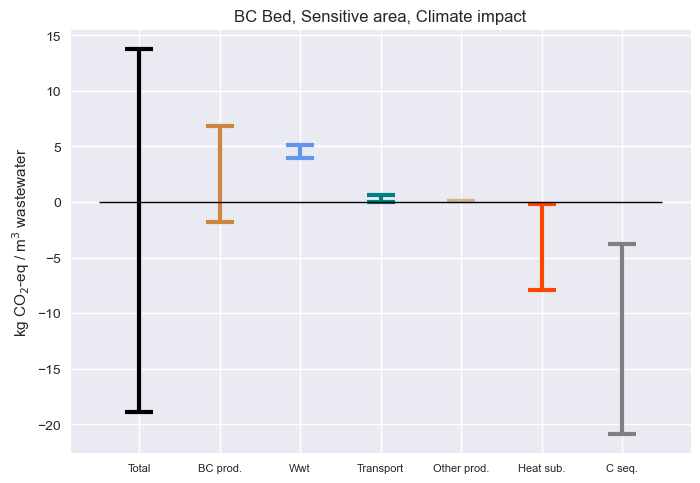

In [102]:
xlabelsBedSensitive = ('Total', 'BC prod.', 'Wwt','Transport','Other prod.',
                       'Heat sub.', 'C seq.')

fig, ax = plt.subplots()

#ax.bar(1, BCBed_Sensitive_medianClimate)
ax.errorbar(y=BCBed_Sensitive_medianClimate, x=1, yerr = BCBed_Sensitive_errorClimate, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedSensitiveClimateBCProdmedian)
ax.errorbar(y=BCBedSensitiveClimateBCProdmedian, x=2, yerr = BCBedSensitiveClimateBCProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(3, BCBedSensitiveClimateWwtmedian)
ax.errorbar(y=BCBedSensitiveClimateWwtmedian, x=3, yerr = BCBedSensitiveClimateWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(4, BCBedSensitiveClimateTransportmedian)
ax.errorbar(y=BCBedSensitiveClimateTransportmedian, x=4, yerr = BCBedSensitiveClimateTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(5, BCBedSensitiveClimateProdmedian)
ax.errorbar(y=BCBedSensitiveClimateProdmedian, x=5, yerr = BCBedSensitiveClimateProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(6, BCBedSensitiveClimateHeatSubmedian)
ax.errorbar(y=BCBedSensitiveClimateHeatSubmedian, x=6, yerr = BCBedSensitiveClimateHeatSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(7, BCBedSensitiveClimateCseqmedian)
ax.errorbar(y=BCBedSensitiveClimateCseqmedian, x=7, yerr = BCBedSensitiveClimateCseqerror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='grey')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=7.5, linewidth=1, color='black')
ax.set_title('BC Bed, Sensitive area, Climate impact')
ax.set_xticks((1,2,3,4,5,6,7))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=8)
ax.set_ylabel(climate_label)


In [103]:
#fig.savefig('CA-BCBed-Sens-Climate', dpi=600, bbox_inches='tight')

##### Eutroph

In [104]:
BCBedSensitiveresultEutrophication = runAlgebraicGraphTraversal([fu3], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [105]:
BCBedSensitiveresultEutrophication

{('wwt_db',
  '478174ce5a594287a039bdc23757b240'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.000537345888708734*BCinFilterSensitive/LifetimeWW + 0.41894222753009/LifetimeWW],
               'BC prod': [1.24742097144955*BCinFilterSensitive*bc_Seqswitch_param_bc1Seq*bc_density_1/LifetimeWW + 1.3262412025719*BCinFilterSensitive*bc_Seqswitch_param_bc2Seq*bc_density_2/LifetimeWW + 1.35653087625692*BCinFilterSensitive*bc_Seqswitch_param_bc3Seq*bc_density_3/LifetimeWW + 0.863138190519769*BCinFilterSensitive*bc_Seqswitch_param_bc4Seq*bc_density_4/LifetimeWW + 1.35894137514376*BCinFilterSensitive*bc_Seqswitch_param_bc5Seq*bc_density_5/LifetimeWW + 2.16163889376866*BCinFilterSensitive*bc_Seqswitch_param_bc7Seq*bc_density_7/LifetimeWW],
               'Heat sub': [0.00453017982328595*BCinFilterSensitive*bc_Seqswitch_param_bc1Seq*bc_density_1*heat_switch_param_heatNaturalGas*(-wps_eta_h*(-wps_LHV_bc_dry + wps_LHV_bio_dry/wps_y_bc + 3.6*wps_i_el) + wps_h_

In [106]:
BCBedSensitiveEutrophicationProd = BCBedSensitiveresultEutrophication[list(fu3.keys())[0]]['agg_graph']['Prod'][0]
BCBedSensitiveEutrophicationBCProd = BCBedSensitiveresultEutrophication[list(fu3.keys())[0]]['agg_graph']['BC prod'][0]
BCBedSensitiveEutrophicationHeatSub = BCBedSensitiveresultEutrophication[list(fu3.keys())[0]]['agg_graph']['Heat sub'][0]
BCBedSensitiveEutrophicationTransport = BCBedSensitiveresultEutrophication[list(fu3.keys())[0]]['agg_graph']['Transport'][0]
BCBedSensitiveEutrophicationWwt = BCBedSensitiveresultEutrophication[list(fu3.keys())[0]]['agg_graph']['Treatment'][0]

In [107]:
BCBedSensitiveEutrophicationProdL = createLambda(BCBedSensitiveEutrophicationProd)
BCBedSensitiveEutrophicationBCProdL = createLambda(BCBedSensitiveEutrophicationBCProd)
BCBedSensitiveEutrophicationHeatSubL = createLambda(BCBedSensitiveEutrophicationHeatSub)
BCBedSensitiveEutrophicationTransportL = createLambda(BCBedSensitiveEutrophicationTransport)
BCBedSensitiveEutrophicationWwtL = createLambda(BCBedSensitiveEutrophicationWwt)

In [108]:
BCBedSensitiveEutrophicationProdY = _compute_stochastics([BCBedSensitiveEutrophicationProdL], TRACI_eut, params)
BCBedSensitiveEutrophicationBCProdY = _compute_stochastics([BCBedSensitiveEutrophicationBCProdL], TRACI_eut, params)
BCBedSensitiveEutrophicationHeatSubY = _compute_stochastics([BCBedSensitiveEutrophicationHeatSubL], TRACI_eut, params)
BCBedSensitiveEutrophicationTransportY = _compute_stochastics([BCBedSensitiveEutrophicationTransportL], TRACI_eut, params)
BCBedSensitiveEutrophicationWwtY = _compute_stochastics([BCBedSensitiveEutrophicationWwtL], TRACI_eut, params)

In [109]:
BCBedSensitiveEutrophicationProdmin = BCBedSensitiveEutrophicationProdY['eutrophication - eutrophication potential'].min()
BCBedSensitiveEutrophicationProdmax = BCBedSensitiveEutrophicationProdY['eutrophication - eutrophication potential'].max()
BCBedSensitiveEutrophicationProdmedian = BCBedSensitiveEutrophicationProdY['eutrophication - eutrophication potential'].median()
BCBedSensitiveEutrophicationProderror = np.array([BCBedSensitiveEutrophicationProdmedian-BCBedSensitiveEutrophicationProdmin, BCBedSensitiveEutrophicationProdmax-BCBedSensitiveEutrophicationProdmedian]).reshape((2,1))

BCBedSensitiveEutrophicationBCProdmin = BCBedSensitiveEutrophicationBCProdY['eutrophication - eutrophication potential'].min()
BCBedSensitiveEutrophicationBCProdmax = BCBedSensitiveEutrophicationBCProdY['eutrophication - eutrophication potential'].max()
BCBedSensitiveEutrophicationBCProdmedian = BCBedSensitiveEutrophicationBCProdY['eutrophication - eutrophication potential'].median()
BCBedSensitiveEutrophicationBCProderror = np.array([BCBedSensitiveEutrophicationBCProdmedian-BCBedSensitiveEutrophicationBCProdmin, BCBedSensitiveEutrophicationBCProdmax-BCBedSensitiveEutrophicationBCProdmedian]).reshape((2,1))

BCBedSensitiveEutrophicationHeatSubmin = BCBedSensitiveEutrophicationHeatSubY['eutrophication - eutrophication potential'].min()
BCBedSensitiveEutrophicationHeatSubmax = BCBedSensitiveEutrophicationHeatSubY['eutrophication - eutrophication potential'].max()
BCBedSensitiveEutrophicationHeatSubmedian = BCBedSensitiveEutrophicationHeatSubY['eutrophication - eutrophication potential'].median()
BCBedSensitiveEutrophicationHeatSuberror = np.array([BCBedSensitiveEutrophicationHeatSubmedian-BCBedSensitiveEutrophicationHeatSubmin, BCBedSensitiveEutrophicationHeatSubmax-BCBedSensitiveEutrophicationHeatSubmedian]).reshape((2,1))

BCBedSensitiveEutrophicationTransportmin = BCBedSensitiveEutrophicationTransportY['eutrophication - eutrophication potential'].min()
BCBedSensitiveEutrophicationTransportmax = BCBedSensitiveEutrophicationTransportY['eutrophication - eutrophication potential'].max()
BCBedSensitiveEutrophicationTransportmedian = BCBedSensitiveEutrophicationTransportY['eutrophication - eutrophication potential'].median()
BCBedSensitiveEutrophicationTransporterror = np.array([BCBedSensitiveEutrophicationTransportmedian-BCBedSensitiveEutrophicationTransportmin, BCBedSensitiveEutrophicationTransportmax-BCBedSensitiveEutrophicationTransportmedian]).reshape((2,1))

BCBedSensitiveEutrophicationWwtmin = BCBedSensitiveEutrophicationWwtY['eutrophication - eutrophication potential'].min()
BCBedSensitiveEutrophicationWwtmax = BCBedSensitiveEutrophicationWwtY['eutrophication - eutrophication potential'].max()
BCBedSensitiveEutrophicationWwtmedian = BCBedSensitiveEutrophicationWwtY['eutrophication - eutrophication potential'].median()
BCBedSensitiveEutrophicationWwterror = np.array([BCBedSensitiveEutrophicationWwtmedian-BCBedSensitiveEutrophicationWwtmin, BCBedSensitiveEutrophicationWwtmax-BCBedSensitiveEutrophicationWwtmedian]).reshape((2,1))

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

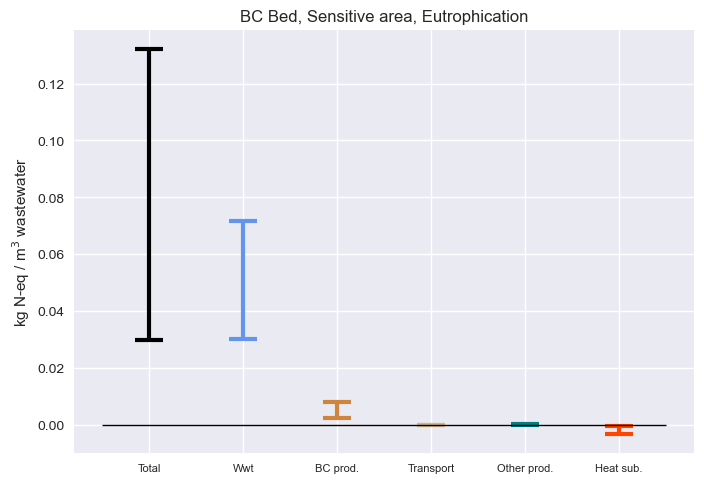

In [110]:
xlabelsBedSensitive = ('Total','Wwt', 'BC prod.', 'Transport','Other prod.', 'Heat sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCBed_Sensitive_medianEutroph)
ax.errorbar(y=BCBed_Sensitive_medianEutroph, x=1, yerr = BCBed_Sensitive_errorEutroph, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedSensitiveEutrophicationWwtmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationWwtmedian, x=2, yerr = BCBedSensitiveEutrophicationWwterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCBedSensitiveEutrophicationBCProdmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationBCProdmedian, x=3, yerr = BCBedSensitiveEutrophicationBCProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCBedSensitiveEutrophicationProdmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationProdmedian, x=4, yerr = BCBedSensitiveEutrophicationProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(5, BCBedSensitiveEutrophicationTransportmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationTransportmedian, x=5, yerr = BCBedSensitiveEutrophicationTransporterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCBedSensitiveEutrophicationHeatSubmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationHeatSubmedian, x=6, yerr = BCBedSensitiveEutrophicationHeatSuberror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=6.5, linewidth=1, color='black')
ax.set_title('BC Bed, Sensitive area, Eutrophication')
ax.set_xticks((1,2,3,4,5,6))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=8)
ax.set_ylabel(eutroph_label)

In [111]:
#fig.savefig('CA-BCBed-Sens-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [112]:
BCBedSensitiveresultAcidification = runAlgebraicGraphTraversal([fu3], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [113]:
BCBedSensitiveresultAcidification

{('wwt_db',
  '478174ce5a594287a039bdc23757b240'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.00362462417361865*BCinFilterSensitive/LifetimeWW + 0.989779577679765/LifetimeWW],
               'BC prod': [1.50143937953037*BCinFilterSensitive*bc_Seqswitch_param_bc1Seq*bc_density_1/LifetimeWW + 1.73721311156945*BCinFilterSensitive*bc_Seqswitch_param_bc2Seq*bc_density_2/LifetimeWW + 6.07825849490467*BCinFilterSensitive*bc_Seqswitch_param_bc3Seq*bc_density_3/LifetimeWW + 0.972340242888536*BCinFilterSensitive*bc_Seqswitch_param_bc4Seq*bc_density_4/LifetimeWW + 6.95273846086561*BCinFilterSensitive*bc_Seqswitch_param_bc5Seq*bc_density_5/LifetimeWW + 8.04282844032353*BCinFilterSensitive*bc_Seqswitch_param_bc7Seq*bc_density_7/LifetimeWW],
               'Heat sub': [0.0183038545422366*BCinFilterSensitive*bc_Seqswitch_param_bc1Seq*bc_density_1*heat_switch_param_heatNaturalGas*(-wps_eta_h*(-wps_LHV_bc_dry + wps_LHV_bio_dry/wps_y_bc + 3.6*wps_i_el) + wps_h_

In [114]:
BCBedSensitiveAcidificationProd = BCBedSensitiveresultAcidification[list(fu3.keys())[0]]['agg_graph']['Prod'][0]
BCBedSensitiveAcidificationBCProd = BCBedSensitiveresultAcidification[list(fu3.keys())[0]]['agg_graph']['BC prod'][0]
BCBedSensitiveAcidificationHeatSub = BCBedSensitiveresultAcidification[list(fu3.keys())[0]]['agg_graph']['Heat sub'][0]
BCBedSensitiveAcidificationTransport = BCBedSensitiveresultAcidification[list(fu3.keys())[0]]['agg_graph']['Transport'][0]
BCBedSensitiveAcidificationWwt = BCBedSensitiveresultAcidification[list(fu3.keys())[0]]['agg_graph']['Treatment'][0]

In [115]:
BCBedSensitiveAcidificationProdL = createLambda(BCBedSensitiveAcidificationProd)
BCBedSensitiveAcidificationBCProdL = createLambda(BCBedSensitiveAcidificationBCProd)
BCBedSensitiveAcidificationHeatSubL = createLambda(BCBedSensitiveAcidificationHeatSub)
BCBedSensitiveAcidificationTransportL = createLambda(BCBedSensitiveAcidificationTransport)
BCBedSensitiveAcidificationWwtL = createLambda(BCBedSensitiveAcidificationWwt)

In [116]:
BCBedSensitiveAcidificationProdY = _compute_stochastics([BCBedSensitiveAcidificationProdL], CML_acid, params)
BCBedSensitiveAcidificationBCProdY = _compute_stochastics([BCBedSensitiveAcidificationBCProdL], CML_acid, params)
BCBedSensitiveAcidificationHeatSubY = _compute_stochastics([BCBedSensitiveAcidificationHeatSubL], CML_acid, params)
BCBedSensitiveAcidificationTransportY = _compute_stochastics([BCBedSensitiveAcidificationTransportL], CML_acid, params)
BCBedSensitiveAcidificationWwtY = _compute_stochastics([BCBedSensitiveAcidificationWwtL], CML_acid, params)

In [117]:
BCBedSensitiveAcidificationProdmin = BCBedSensitiveAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedSensitiveAcidificationProdmax = BCBedSensitiveAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedSensitiveAcidificationProdmedian = BCBedSensitiveAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedSensitiveAcidificationProderror = np.array([BCBedSensitiveAcidificationProdmedian-BCBedSensitiveAcidificationProdmin, BCBedSensitiveAcidificationProdmax-BCBedSensitiveAcidificationProdmedian]).reshape((2,1))

BCBedSensitiveAcidificationBCProdmin = BCBedSensitiveAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedSensitiveAcidificationBCProdmax = BCBedSensitiveAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedSensitiveAcidificationBCProdmedian = BCBedSensitiveAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedSensitiveAcidificationBCProderror = np.array([BCBedSensitiveAcidificationBCProdmedian-BCBedSensitiveAcidificationBCProdmin, BCBedSensitiveAcidificationBCProdmax-BCBedSensitiveAcidificationBCProdmedian]).reshape((2,1))

BCBedSensitiveAcidificationHeatSubmin = BCBedSensitiveAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedSensitiveAcidificationHeatSubmax = BCBedSensitiveAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedSensitiveAcidificationHeatSubmedian = BCBedSensitiveAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedSensitiveAcidificationHeatSuberror = np.array([BCBedSensitiveAcidificationHeatSubmedian-BCBedSensitiveAcidificationHeatSubmin, BCBedSensitiveAcidificationHeatSubmax-BCBedSensitiveAcidificationHeatSubmedian]).reshape((2,1))

BCBedSensitiveAcidificationTransportmin = BCBedSensitiveAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedSensitiveAcidificationTransportmax = BCBedSensitiveAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedSensitiveAcidificationTransportmedian = BCBedSensitiveAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedSensitiveAcidificationTransporterror = np.array([BCBedSensitiveAcidificationTransportmedian-BCBedSensitiveAcidificationTransportmin, BCBedSensitiveAcidificationTransportmax-BCBedSensitiveAcidificationTransportmedian]).reshape((2,1))

BCBedSensitiveAcidificationWwtmin = BCBedSensitiveAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCBedSensitiveAcidificationWwtmax = BCBedSensitiveAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCBedSensitiveAcidificationWwtmedian = BCBedSensitiveAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCBedSensitiveAcidificationWwterror = np.array([BCBedSensitiveAcidificationWwtmedian-BCBedSensitiveAcidificationWwtmin, BCBedSensitiveAcidificationWwtmax-BCBedSensitiveAcidificationWwtmedian]).reshape((2,1))

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

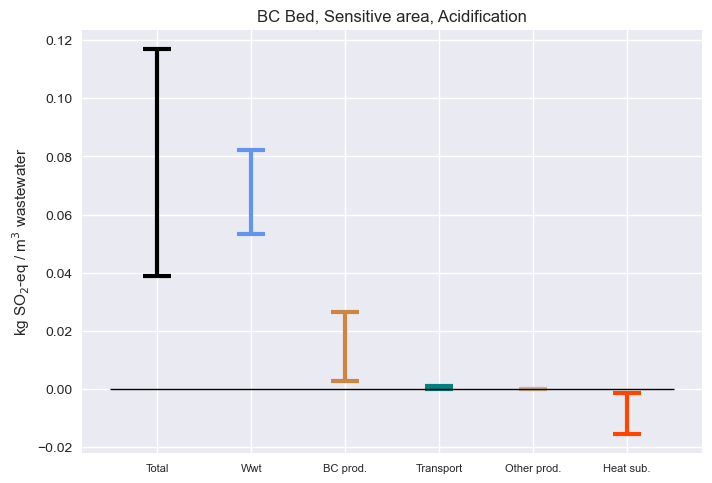

In [118]:
xlabelsBedSensitive = ('Total','Wwt', 'BC prod.', 'Transport','Other prod.', 'Heat sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCBed_Sensitive_medianAcid)
ax.errorbar(y=BCBed_Sensitive_medianAcid, x=1, yerr = BCBed_Sensitive_errorAcid, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedSensitiveAcidificationWwtmedian)
ax.errorbar(y=BCBedSensitiveAcidificationWwtmedian, x=2, yerr = BCBedSensitiveAcidificationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCBedSensitiveAcidificationBCProdmedian)
ax.errorbar(y=BCBedSensitiveAcidificationBCProdmedian, x=3, yerr = BCBedSensitiveAcidificationBCProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCBedSensitiveAcidificationTransportmedian)
ax.errorbar(y=BCBedSensitiveAcidificationTransportmedian, x=4, yerr = BCBedSensitiveAcidificationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(5, BCBedSensitiveAcidificationProdmedian)
ax.errorbar(y=BCBedSensitiveAcidificationProdmedian, x=5, yerr = BCBedSensitiveAcidificationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(6, BCBedSensitiveAcidificationHeatSubmedian)
ax.errorbar(y=BCBedSensitiveAcidificationHeatSubmedian, x=6, yerr = BCBedSensitiveAcidificationHeatSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=6.5, linewidth=1, color='black')
ax.set_title('BC Bed, Sensitive area, Acidification')
ax.set_xticks((1,2,3,4,5,6))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=8)
ax.set_ylabel(acid_label)

In [119]:
#fig.savefig('CA-BCBed-Sens-Acid', dpi=600, bbox_inches='tight')

#### BC Mod Sensitive

##### climate

In [120]:
BCModresultClimate = runAlgebraicGraphTraversal([fu4], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [121]:
BCModresultClimate

{('wwt_db',
  '4c5d9a125cd84265a68dd09858eac9f4'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [289.733577645994/LifetimeWW],
               'BC prod': [-301.368726974128*BCinModfilter*bc_density_1*bc_switch_param_bc1/LifetimeWW - 142.928149004155*BCinModfilter*bc_density_2*bc_switch_param_bc2/LifetimeWW + 1770.61627783165*BCinModfilter*bc_density_3*bc_switch_param_bc3/LifetimeWW - 229.177799977*BCinModfilter*bc_density_4*bc_switch_param_bc4/LifetimeWW + 2910.96039438655*BCinModfilter*bc_density_5*bc_switch_param_bc5/LifetimeWW + 2079.70417644412*BCinModfilter*bc_density_7*bc_switch_param_bc7/LifetimeWW],
               'Heat sub': [-30.9326586747031*BCinModfilter*CHPEfficiency*EOL1and2_switch_param_CHP1*HHVBC1and2*bc_density_1*bc_switch_param_bc1*heat_switch_param_heatNaturalGas*(1 - CHPElecRatio)/LifetimeWW - 2.5481363144204*BCinModfilter*CHPEfficiency*EOL1and2_switch_param_CHP1*HHVBC1and2*bc_density_1*bc_switch_param_bc1*heat_switch_param_heatW

In [122]:
BCModClimateBCProd = BCModresultClimate[list(fu4.keys())[0]]['agg_graph']['BC prod'][0]
BCModClimateHeatSub = BCModresultClimate[list(fu4.keys())[0]]['agg_graph']['Heat sub'][0]
BCModClimateTransport = BCModresultClimate[list(fu4.keys())[0]]['agg_graph']['Transport'][0]
BCModClimateBCEOL = BCModresultClimate[list(fu4.keys())[0]]['agg_graph']['BC EOL'][0]
BCModClimateLSSub = BCModresultClimate[list(fu4.keys())[0]]['agg_graph']['LS sub'][0]
BCModClimateCseq = BCModresultClimate[list(fu4.keys())[0]]['agg_graph']['C seq'][0]
BCModClimateElecSub = BCModresultClimate[list(fu4.keys())[0]]['agg_graph']['Elec sub'][0]
BCModClimateWwt = BCModresultClimate[list(fu4.keys())[0]]['agg_graph']['Treatment'][0]

In [123]:
BCModClimateBCProdL = createLambda(BCModClimateBCProd)
BCModClimateHeatSubL = createLambda(BCModClimateHeatSub)
BCModClimateTransportL = createLambda(BCModClimateTransport)
BCModClimateBCEOL_L = createLambda(BCModClimateBCEOL)
BCModClimateLSSubL = createLambda(BCModClimateLSSub)
BCModClimateCseqL = createLambda(BCModClimateCseq)
BCModClimateElecSubL = createLambda(BCModClimateElecSub)
BCModClimateWwtL = createLambda(BCModClimateWwt)

In [124]:
BCModClimateBCProdY = _compute_stochastics([BCModClimateBCProdL], IPCC, params)
BCModClimateHeatSubY = _compute_stochastics([BCModClimateHeatSubL], IPCC, params)
BCModClimateTransportY = _compute_stochastics([BCModClimateTransportL], IPCC, params)
BCModClimateBCEOL_Y = _compute_stochastics([BCModClimateBCEOL_L], IPCC, params)
BCModClimateLSSubY = _compute_stochastics([BCModClimateLSSubL], IPCC, params)
BCModClimateCseqY  = _compute_stochastics([BCModClimateCseqL], IPCC, params)
BCModClimateElecSubY = _compute_stochastics([BCModClimateElecSubL], IPCC, params)
BCModClimateWwtY = _compute_stochastics([BCModClimateWwtL], IPCC, params)

In [125]:
BCModClimateBCProdmin = BCModClimateBCProdY['climate change - global warming potential (GWP100)'].min()
BCModClimateBCProdmax = BCModClimateBCProdY['climate change - global warming potential (GWP100)'].max()
BCModClimateBCProdmedian = BCModClimateBCProdY['climate change - global warming potential (GWP100)'].median()
BCModClimateBCProderror = np.array([BCModClimateBCProdmedian-BCModClimateBCProdmin, BCModClimateBCProdmax-BCModClimateBCProdmedian]).reshape((2,1))

BCModClimateHeatSubmin = BCModClimateHeatSubY['climate change - global warming potential (GWP100)'].min()
BCModClimateHeatSubmax = BCModClimateHeatSubY['climate change - global warming potential (GWP100)'].max()
BCModClimateHeatSubmedian = BCModClimateHeatSubY['climate change - global warming potential (GWP100)'].median()
BCModClimateHeatSuberror = np.array([BCModClimateHeatSubmedian-BCModClimateHeatSubmin, BCModClimateHeatSubmax-BCModClimateHeatSubmedian]).reshape((2,1))

BCModClimateTransportmin = BCModClimateTransportY['climate change - global warming potential (GWP100)'].min()
BCModClimateTransportmax = BCModClimateTransportY['climate change - global warming potential (GWP100)'].max()
BCModClimateTransportmedian = BCModClimateTransportY['climate change - global warming potential (GWP100)'].median()
BCModClimateTransporterror = np.array([BCModClimateTransportmedian-BCModClimateTransportmin, BCModClimateTransportmax-BCModClimateTransportmedian]).reshape((2,1))

BCModClimateBCEOLmin = BCModClimateBCEOL_Y['climate change - global warming potential (GWP100)'].min()
BCModClimateBCEOLmax = BCModClimateBCEOL_Y['climate change - global warming potential (GWP100)'].max()
BCModClimateBCEOLmedian = BCModClimateBCEOL_Y['climate change - global warming potential (GWP100)'].median()
BCModClimateBCEOLerror = np.array([BCModClimateBCEOLmedian-BCModClimateBCEOLmin, BCModClimateBCEOLmax-BCModClimateBCEOLmedian]).reshape((2,1))

BCModClimateLSSubmin = BCModClimateLSSubY['climate change - global warming potential (GWP100)'].min()
BCModClimateLSSubmax = BCModClimateLSSubY['climate change - global warming potential (GWP100)'].max()
BCModClimateLSSubmedian = BCModClimateLSSubY['climate change - global warming potential (GWP100)'].median()
BCModClimateLSSuberror = np.array([BCModClimateLSSubmedian-BCModClimateLSSubmin, BCModClimateLSSubmax-BCModClimateLSSubmedian]).reshape((2,1))

BCModClimateCseqmin = BCModClimateCseqY['climate change - global warming potential (GWP100)'].min()
BCModClimateCseqmax = BCModClimateCseqY['climate change - global warming potential (GWP100)'].max()
BCModClimateCseqmedian = BCModClimateCseqY['climate change - global warming potential (GWP100)'].median()
BCModClimateCseqerror = np.array([BCModClimateCseqmedian-BCModClimateCseqmin, BCModClimateCseqmax-BCModClimateCseqmedian]).reshape((2,1))

BCModClimateElecSubmin = BCModClimateElecSubY['climate change - global warming potential (GWP100)'].min()
BCModClimateElecSubmax = BCModClimateElecSubY['climate change - global warming potential (GWP100)'].max()
BCModClimateElecSubmedian = BCModClimateElecSubY['climate change - global warming potential (GWP100)'].median()
BCModClimateElecSuberror = np.array([BCModClimateElecSubmedian-BCModClimateElecSubmin, BCModClimateElecSubmax-BCModClimateElecSubmedian]).reshape((2,1))

BCModClimateWwtmin = BCModClimateWwtY['climate change - global warming potential (GWP100)'].min()
BCModClimateWwtmax = BCModClimateWwtY['climate change - global warming potential (GWP100)'].max()
BCModClimateWwtmedian = BCModClimateWwtY['climate change - global warming potential (GWP100)'].median()
BCModClimateWwterror = np.array([BCModClimateWwtmedian-BCModClimateWwtmin, BCModClimateWwtmax-BCModClimateWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

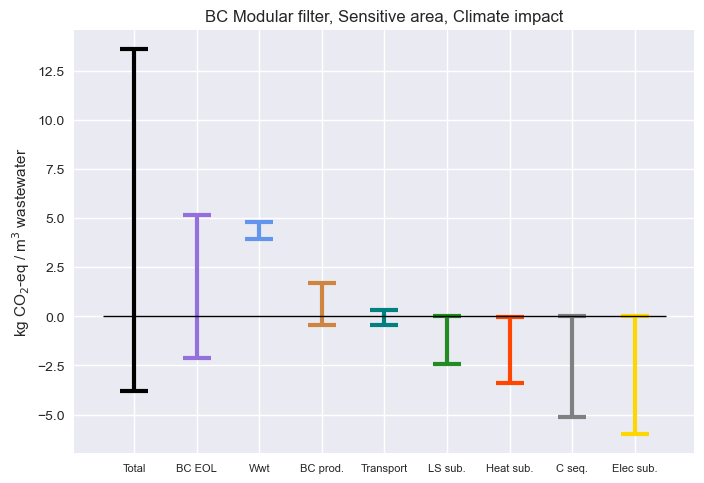

In [126]:
xlabels = ('Total','BC EOL','Wwt','BC prod.','Transport','LS sub.',
             'Heat sub.', 'C seq.','Elec sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCMod_Sensitive_medianClimate)
ax.errorbar(y=BCMod_Sensitive_medianClimate, x=1, yerr = BCMod_Sensitive_errorClimate, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModClimateBCEOLmedian)
ax.errorbar(y=BCModClimateBCEOLmedian, x=2, yerr = BCModClimateBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(3, BCModClimateWwtmedian)
ax.errorbar(y=BCModClimateWwtmedian, x=3, yerr = BCModClimateWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(4, BCModClimateBCProdmedian)
ax.errorbar(y=BCModClimateBCProdmedian, x=4, yerr = BCModClimateBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(5, BCModClimateTransportmedian)
ax.errorbar(y=BCModClimateTransportmedian, x=5, yerr = BCModClimateTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCModClimateLSSubmedian)
ax.errorbar(y=BCModClimateLSSubmedian, x=6, yerr = BCModClimateLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(7, BCModClimateHeatSubmedian)
ax.errorbar(y=BCModClimateHeatSubmedian, x=7, yerr = BCModClimateHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModClimateCseqmedian)
ax.errorbar(y=BCModClimateCseqmedian, x=8, yerr = BCModClimateCseqerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='grey')

#ax.bar(9, BCModClimateElecSubmedian)
ax.errorbar(y=BCModClimateElecSubmedian, x=9, yerr = BCModClimateElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_title('BC Modular filter, Sensitive area, Climate impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(climate_label)

In [127]:
#fig.savefig('CA-BCMod-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [128]:
BCModresultEutrophication = runAlgebraicGraphTraversal([fu4], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [129]:
BCModresultEutrophication

{('wwt_db',
  '4c5d9a125cd84265a68dd09858eac9f4'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.41894222753009/LifetimeWW],
               'BC prod': [1.24742097144955*BCinModfilter*bc_density_1*bc_switch_param_bc1/LifetimeWW + 1.3262412025719*BCinModfilter*bc_density_2*bc_switch_param_bc2/LifetimeWW + 1.35653087625692*BCinModfilter*bc_density_3*bc_switch_param_bc3/LifetimeWW + 0.863138190519769*BCinModfilter*bc_density_4*bc_switch_param_bc4/LifetimeWW + 1.35894137514376*BCinModfilter*bc_density_5*bc_switch_param_bc5/LifetimeWW + 2.16163889376866*BCinModfilter*bc_density_7*bc_switch_param_bc7/LifetimeWW],
               'Heat sub': [-0.00453017982328595*BCinModfilter*CHPEfficiency*EOL1and2_switch_param_CHP1*HHVBC1and2*bc_density_1*bc_switch_param_bc1*heat_switch_param_heatNaturalGas*(1 - CHPElecRatio)/LifetimeWW - 0.0124016398860314*BCinModfilter*CHPEfficiency*EOL1and2_switch_param_CHP1*HHVBC1and2*bc_density_1*bc_switch_param_bc1*heat_switch_par

In [130]:
BCModEutrophicationBCProd = BCModresultEutrophication[list(fu4.keys())[0]]['agg_graph']['BC prod'][0]
BCModEutrophicationHeatSub = BCModresultEutrophication[list(fu4.keys())[0]]['agg_graph']['Heat sub'][0]
BCModEutrophicationTransport = BCModresultEutrophication[list(fu4.keys())[0]]['agg_graph']['Transport'][0]
BCModEutrophicationBCEOL = BCModresultEutrophication[list(fu4.keys())[0]]['agg_graph']['BC EOL'][0]
BCModEutrophicationLSSub = BCModresultEutrophication[list(fu4.keys())[0]]['agg_graph']['LS sub'][0]
BCModEutrophicationElecSub = BCModresultEutrophication[list(fu4.keys())[0]]['agg_graph']['Elec sub'][0]
BCModEutrophicationWwt = BCModresultEutrophication[list(fu4.keys())[0]]['agg_graph']['Treatment'][0]

In [131]:
BCModEutrophicationBCProdL = createLambda(BCModEutrophicationBCProd)
BCModEutrophicationHeatSubL = createLambda(BCModEutrophicationHeatSub)
BCModEutrophicationTransportL = createLambda(BCModEutrophicationTransport)
BCModEutrophicationBCEOL_L = createLambda(BCModEutrophicationBCEOL)
BCModEutrophicationLSSubL = createLambda(BCModEutrophicationLSSub)
BCModEutrophicationElecSubL = createLambda(BCModEutrophicationElecSub)
BCModEutrophicationWwtL = createLambda(BCModEutrophicationWwt)

In [132]:
BCModEutrophicationBCProdY = _compute_stochastics([BCModEutrophicationBCProdL], TRACI_eut, params)
BCModEutrophicationHeatSubY = _compute_stochastics([BCModEutrophicationHeatSubL], TRACI_eut, params)
BCModEutrophicationTransportY = _compute_stochastics([BCModEutrophicationTransportL], TRACI_eut, params)
BCModEutrophicationBCEOL_Y = _compute_stochastics([BCModEutrophicationBCEOL_L], TRACI_eut, params)
BCModEutrophicationLSSubY = _compute_stochastics([BCModEutrophicationLSSubL], TRACI_eut, params)
BCModEutrophicationElecSubY = _compute_stochastics([BCModEutrophicationElecSubL], TRACI_eut, params)
BCModEutrophicationWwtY = _compute_stochastics([BCModEutrophicationWwtL], TRACI_eut, params)

In [133]:
BCModEutrophicationBCProdmin = BCModEutrophicationBCProdY['eutrophication - eutrophication potential'].min()
BCModEutrophicationBCProdmax = BCModEutrophicationBCProdY['eutrophication - eutrophication potential'].max()
BCModEutrophicationBCProdmedian = BCModEutrophicationBCProdY['eutrophication - eutrophication potential'].median()
BCModEutrophicationBCProderror = np.array([BCModEutrophicationBCProdmedian-BCModEutrophicationBCProdmin, BCModEutrophicationBCProdmax-BCModEutrophicationBCProdmedian]).reshape((2,1))

BCModEutrophicationHeatSubmin = BCModEutrophicationHeatSubY['eutrophication - eutrophication potential'].min()
BCModEutrophicationHeatSubmax = BCModEutrophicationHeatSubY['eutrophication - eutrophication potential'].max()
BCModEutrophicationHeatSubmedian = BCModEutrophicationHeatSubY['eutrophication - eutrophication potential'].median()
BCModEutrophicationHeatSuberror = np.array([BCModEutrophicationHeatSubmedian-BCModEutrophicationHeatSubmin, BCModEutrophicationHeatSubmax-BCModEutrophicationHeatSubmedian]).reshape((2,1))

BCModEutrophicationTransportmin = BCModEutrophicationTransportY['eutrophication - eutrophication potential'].min()
BCModEutrophicationTransportmax = BCModEutrophicationTransportY['eutrophication - eutrophication potential'].max()
BCModEutrophicationTransportmedian = BCModEutrophicationTransportY['eutrophication - eutrophication potential'].median()
BCModEutrophicationTransporterror = np.array([BCModEutrophicationTransportmedian-BCModEutrophicationTransportmin, BCModEutrophicationTransportmax-BCModEutrophicationTransportmedian]).reshape((2,1))

BCModEutrophicationBCEOLmin = BCModEutrophicationBCEOL_Y['eutrophication - eutrophication potential'].min()
BCModEutrophicationBCEOLmax = BCModEutrophicationBCEOL_Y['eutrophication - eutrophication potential'].max()
BCModEutrophicationBCEOLmedian = BCModEutrophicationBCEOL_Y['eutrophication - eutrophication potential'].median()
BCModEutrophicationBCEOLerror = np.array([BCModEutrophicationBCEOLmedian-BCModEutrophicationBCEOLmin, BCModEutrophicationBCEOLmax-BCModEutrophicationBCEOLmedian]).reshape((2,1))

BCModEutrophicationLSSubmin = BCModEutrophicationLSSubY['eutrophication - eutrophication potential'].min()
BCModEutrophicationLSSubmax = BCModEutrophicationLSSubY['eutrophication - eutrophication potential'].max()
BCModEutrophicationLSSubmedian = BCModEutrophicationLSSubY['eutrophication - eutrophication potential'].median()
BCModEutrophicationLSSuberror = np.array([BCModEutrophicationLSSubmedian-BCModEutrophicationLSSubmin, BCModEutrophicationLSSubmax-BCModEutrophicationLSSubmedian]).reshape((2,1))

BCModEutrophicationElecSubmin = BCModEutrophicationElecSubY['eutrophication - eutrophication potential'].min()
BCModEutrophicationElecSubmax = BCModEutrophicationElecSubY['eutrophication - eutrophication potential'].max()
BCModEutrophicationElecSubmedian = BCModEutrophicationElecSubY['eutrophication - eutrophication potential'].median()
BCModEutrophicationElecSuberror = np.array([BCModEutrophicationElecSubmedian-BCModEutrophicationElecSubmin, BCModEutrophicationElecSubmax-BCModEutrophicationElecSubmedian]).reshape((2,1))

BCModEutrophicationWwtmin = BCModEutrophicationWwtY['eutrophication - eutrophication potential'].min()
BCModEutrophicationWwtmax = BCModEutrophicationWwtY['eutrophication - eutrophication potential'].max()
BCModEutrophicationWwtmedian = BCModEutrophicationWwtY['eutrophication - eutrophication potential'].median()
BCModEutrophicationWwterror = np.array([BCModEutrophicationWwtmedian-BCModEutrophicationWwtmin, BCModEutrophicationWwtmax-BCModEutrophicationWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

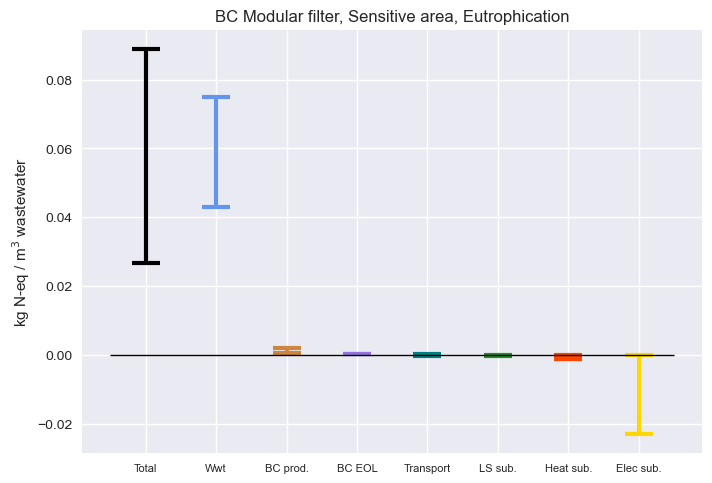

In [134]:
xlabels = ('Total','Wwt','BC prod.','BC EOL','Transport','LS sub.',
             'Heat sub.', 'Elec sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCMod_Sensitive_medianEutroph)
ax.errorbar(y=BCMod_Sensitive_medianEutroph, x=1, yerr = BCMod_Sensitive_errorEutroph, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModEutrophicationWwtmedian)
ax.errorbar(y=BCModEutrophicationWwtmedian, x=2, yerr = BCModEutrophicationWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCModEutrophicationBCProdmedian)
ax.errorbar(y=BCModEutrophicationBCProdmedian, x=3, yerr = BCModEutrophicationBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCModEutrophicationBCEOLmedian)
ax.errorbar(y=BCModEutrophicationBCEOLmedian, x=4, yerr = BCModEutrophicationBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCModEutrophicationTransportmedian)
ax.errorbar(y=BCModEutrophicationTransportmedian, x=5, yerr = BCModEutrophicationTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCModEutrophicationLSSubmedian)
ax.errorbar(y=BCModEutrophicationLSSubmedian, x=6, yerr = BCModEutrophicationLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(7, BCModEutrophicationHeatSubmedian)
ax.errorbar(y=BCModEutrophicationHeatSubmedian, x=7, yerr = BCModEutrophicationHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModEutrophicationElecSubmedian)
ax.errorbar(y=BCModEutrophicationElecSubmedian, x=8, yerr = BCModEutrophicationElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_title('BC Modular filter, Sensitive area, Eutrophication')
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(eutroph_label)

In [135]:
#fig.savefig('CA-BCMod-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [136]:
BCModresultAcidification = runAlgebraicGraphTraversal([fu4], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [137]:
BCModresultAcidification

{('wwt_db',
  '4c5d9a125cd84265a68dd09858eac9f4'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.989779577679765/LifetimeWW],
               'BC prod': [1.50143937953037*BCinModfilter*bc_density_1*bc_switch_param_bc1/LifetimeWW + 1.73721311156945*BCinModfilter*bc_density_2*bc_switch_param_bc2/LifetimeWW + 6.07825849490467*BCinModfilter*bc_density_3*bc_switch_param_bc3/LifetimeWW + 0.972340242888536*BCinModfilter*bc_density_4*bc_switch_param_bc4/LifetimeWW + 6.95273846086561*BCinModfilter*bc_density_5*bc_switch_param_bc5/LifetimeWW + 8.04282844032353*BCinModfilter*bc_density_7*bc_switch_param_bc7/LifetimeWW],
               'Heat sub': [-0.0183038545422366*BCinModfilter*CHPEfficiency*EOL1and2_switch_param_CHP1*HHVBC1and2*bc_density_1*bc_switch_param_bc1*heat_switch_param_heatNaturalGas*(1 - CHPElecRatio)/LifetimeWW - 0.0598605545926978*BCinModfilter*CHPEfficiency*EOL1and2_switch_param_CHP1*HHVBC1and2*bc_density_1*bc_switch_param_bc1*heat_switch_pa

In [138]:
BCModAcidificationBCProd = BCModresultAcidification[list(fu4.keys())[0]]['agg_graph']['BC prod'][0]
BCModAcidificationHeatSub = BCModresultAcidification[list(fu4.keys())[0]]['agg_graph']['Heat sub'][0]
BCModAcidificationTransport = BCModresultAcidification[list(fu4.keys())[0]]['agg_graph']['Transport'][0]
BCModAcidificationBCEOL = BCModresultAcidification[list(fu4.keys())[0]]['agg_graph']['BC EOL'][0]
BCModAcidificationLSSub = BCModresultAcidification[list(fu4.keys())[0]]['agg_graph']['LS sub'][0]
BCModAcidificationElecSub = BCModresultAcidification[list(fu4.keys())[0]]['agg_graph']['Elec sub'][0]
BCModAcidificationWwt = BCModresultAcidification[list(fu4.keys())[0]]['agg_graph']['Treatment'][0]

In [139]:
BCModAcidificationBCProdL = createLambda(BCModAcidificationBCProd)
BCModAcidificationHeatSubL = createLambda(BCModAcidificationHeatSub)
BCModAcidificationTransportL = createLambda(BCModAcidificationTransport)
BCModAcidificationBCEOL_L = createLambda(BCModAcidificationBCEOL)
BCModAcidificationLSSubL = createLambda(BCModAcidificationLSSub)
BCModAcidificationElecSubL = createLambda(BCModAcidificationElecSub)
BCModAcidificationWwtL = createLambda(BCModAcidificationWwt)

In [140]:
BCModAcidificationBCProdY = _compute_stochastics([BCModAcidificationBCProdL], CML_acid, params)
BCModAcidificationHeatSubY = _compute_stochastics([BCModAcidificationHeatSubL], CML_acid, params)
BCModAcidificationTransportY = _compute_stochastics([BCModAcidificationTransportL], CML_acid, params)
BCModAcidificationBCEOL_Y = _compute_stochastics([BCModAcidificationBCEOL_L], CML_acid, params)
BCModAcidificationLSSubY = _compute_stochastics([BCModAcidificationLSSubL], CML_acid, params)
BCModAcidificationElecSubY = _compute_stochastics([BCModAcidificationElecSubL], CML_acid, params)
BCModAcidificationWwtY = _compute_stochastics([BCModAcidificationWwtL], CML_acid, params)

In [141]:
BCModAcidificationBCProdmin = BCModAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCModAcidificationBCProdmax = BCModAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCModAcidificationBCProdmedian = BCModAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCModAcidificationBCProderror = np.array([BCModAcidificationBCProdmedian-BCModAcidificationBCProdmin, BCModAcidificationBCProdmax-BCModAcidificationBCProdmedian]).reshape((2,1))

BCModAcidificationHeatSubmin = BCModAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCModAcidificationHeatSubmax = BCModAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCModAcidificationHeatSubmedian = BCModAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCModAcidificationHeatSuberror = np.array([BCModAcidificationHeatSubmedian-BCModAcidificationHeatSubmin, BCModAcidificationHeatSubmax-BCModAcidificationHeatSubmedian]).reshape((2,1))

BCModAcidificationTransportmin = BCModAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCModAcidificationTransportmax = BCModAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCModAcidificationTransportmedian = BCModAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCModAcidificationTransporterror = np.array([BCModAcidificationTransportmedian-BCModAcidificationTransportmin, BCModAcidificationTransportmax-BCModAcidificationTransportmedian]).reshape((2,1))

BCModAcidificationBCEOLmin = BCModAcidificationBCEOL_Y['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCModAcidificationBCEOLmax = BCModAcidificationBCEOL_Y['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCModAcidificationBCEOLmedian = BCModAcidificationBCEOL_Y['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCModAcidificationBCEOLerror = np.array([BCModAcidificationBCEOLmedian-BCModAcidificationBCEOLmin, BCModAcidificationBCEOLmax-BCModAcidificationBCEOLmedian]).reshape((2,1))

BCModAcidificationLSSubmin = BCModAcidificationLSSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCModAcidificationLSSubmax = BCModAcidificationLSSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCModAcidificationLSSubmedian = BCModAcidificationLSSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCModAcidificationLSSuberror = np.array([BCModAcidificationLSSubmedian-BCModAcidificationLSSubmin, BCModAcidificationLSSubmax-BCModAcidificationLSSubmedian]).reshape((2,1))

BCModAcidificationElecSubmin = BCModAcidificationElecSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCModAcidificationElecSubmax = BCModAcidificationElecSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCModAcidificationElecSubmedian = BCModAcidificationElecSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCModAcidificationElecSuberror = np.array([BCModAcidificationElecSubmedian-BCModAcidificationElecSubmin, BCModAcidificationElecSubmax-BCModAcidificationElecSubmedian]).reshape((2,1))

BCModAcidificationWwtmin = BCModAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
BCModAcidificationWwtmax = BCModAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
BCModAcidificationWwtmedian = BCModAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
BCModAcidificationWwterror = np.array([BCModAcidificationWwtmedian-BCModAcidificationWwtmin, BCModAcidificationWwtmax-BCModAcidificationWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

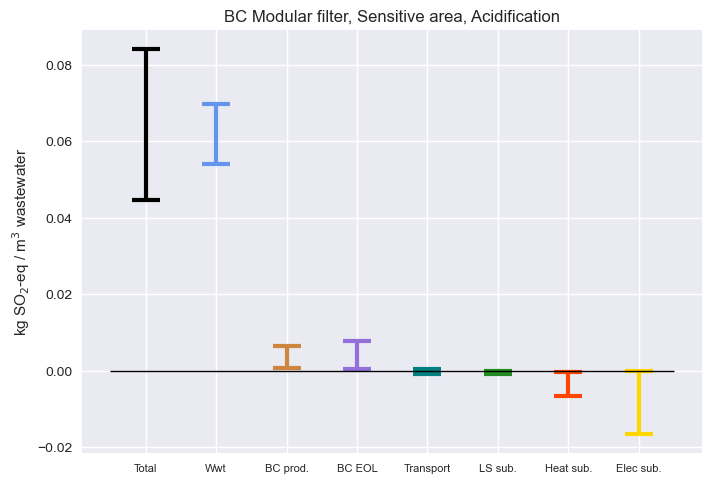

In [142]:
xlabels = ('Total','Wwt', 'BC prod.','BC EOL',
           'Transport','LS sub.',
             'Heat sub.', 'Elec sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCMod_Sensitive_medianAcid)
ax.errorbar(y=BCMod_Sensitive_medianAcid, x=1, yerr = BCMod_Sensitive_errorAcid, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModAcidificationWwtmedian)
ax.errorbar(y=BCModAcidificationWwtmedian, x=2, yerr = BCModAcidificationWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCModAcidificationBCProdmedian)
ax.errorbar(y=BCModAcidificationBCProdmedian, x=3, yerr = BCModAcidificationBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCModAcidificationBCEOLmedian)
ax.errorbar(y=BCModAcidificationBCEOLmedian, x=4, yerr = BCModAcidificationBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCModAcidificationTransportmedian)
ax.errorbar(y=BCModAcidificationTransportmedian, x=5, yerr = BCModAcidificationTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCModAcidificationLSSubmedian)
ax.errorbar(y=BCModAcidificationLSSubmedian, x=6, yerr = BCModAcidificationLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(7, BCModAcidificationHeatSubmedian)
ax.errorbar(y=BCModAcidificationHeatSubmedian, x=7, yerr = BCModAcidificationHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModAcidificationElecSubmedian)
ax.errorbar(y=BCModAcidificationElecSubmedian, x=8, yerr = BCModAcidificationElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_title('BC Modular filter, Sensitive area, Acidification')
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(acid_label)

In [143]:
#fig.savefig('CA-BCMod-Acid', dpi=600, bbox_inches='tight')

#### Sand sensitive

##### climate

In [144]:
SandSensitiveresultClimate = runAlgebraicGraphTraversal([fu5], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [145]:
SandSensitiveresultClimate

{('wwt_db',
  'c4401064ed20418084f86b84ddf6bb93'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.582000281395534*SandFilterVolume/LifetimeWW + 289.733577645994/LifetimeWW],
               'Sand prod': [5.87125187536048e-8*SandinFilter*sand_switch_param_sand/LifetimeWW],
               'Transport': [0.000184904491741122*PlasticSTWeight*TransportDistanceST/LifetimeWW + 2.05221411477383e-9*SandinFilter*TransportDistanceFilter*sand_switch_param_sand/LifetimeWW],
               'Treatment': [0.027*CH4air + 0.273*N2Oair*NremovalSand*Ntotin*(1 - NremovalSludge)/N2Ocalc + 1.74229216331207*PACdosage]}), 'graph': [{'activity': 'Sand Sensitive System' (unit, GLO, None),
    'amount': 1,
    'tag': 'other',
    'secondary_tags': [],
    'impact': [0],
    'biosphere': [],
    'technosphere': [{'activity': 'Sand Sensitive Prod' (unit, GLO, None),
      'amount': 1/LifetimeWW,
      'tag': 'Prod',
      'secondary_tags': [],
      'impact': [0.582000281395534*

In [146]:
SandSensitiveClimateProd = SandSensitiveresultClimate[list(fu5.keys())[0]]['agg_graph']['Prod'][0]
SandSensitiveClimateSandProd = SandSensitiveresultClimate[list(fu5.keys())[0]]['agg_graph']['Sand prod'][0]
SandSensitiveClimateTransport = SandSensitiveresultClimate[list(fu5.keys())[0]]['agg_graph']['Transport'][0]
SandSensitiveClimateWwt = SandSensitiveresultClimate[list(fu5.keys())[0]]['agg_graph']['Treatment'][0]

In [147]:
SandSensitiveClimateProdL = createLambda(SandSensitiveClimateProd)
SandSensitiveClimateSandProdL = createLambda(SandSensitiveClimateSandProd)
SandSensitiveClimateTransportL = createLambda(SandSensitiveClimateTransport)
SandSensitiveClimateWwtL = createLambda(SandSensitiveClimateWwt)

In [148]:
SandSensitiveClimateProdY = _compute_stochastics([SandSensitiveClimateProdL], IPCC, params)
SandSensitiveClimateSandProdY = _compute_stochastics([SandSensitiveClimateSandProdL], IPCC, params)
SandSensitiveClimateTransportY = _compute_stochastics([SandSensitiveClimateTransportL], IPCC, params)
SandSensitiveClimateWwtY = _compute_stochastics([SandSensitiveClimateWwtL], IPCC, params)

In [149]:
SandSensitiveClimateProdmin = SandSensitiveClimateProdY['climate change - global warming potential (GWP100)'].min()
SandSensitiveClimateProdmax = SandSensitiveClimateProdY['climate change - global warming potential (GWP100)'].max()
SandSensitiveClimateProdmedian = SandSensitiveClimateProdY['climate change - global warming potential (GWP100)'].median()
SandSensitiveClimateProderror = np.array([SandSensitiveClimateProdmedian-SandSensitiveClimateProdmin, SandSensitiveClimateProdmax-SandSensitiveClimateProdmedian]).reshape((2,1))

In [150]:
SandSensitiveClimateSandProdmin = SandSensitiveClimateSandProdY['climate change - global warming potential (GWP100)'].min()
SandSensitiveClimateSandProdmax = SandSensitiveClimateSandProdY['climate change - global warming potential (GWP100)'].max()
SandSensitiveClimateSandProdmedian = SandSensitiveClimateSandProdY['climate change - global warming potential (GWP100)'].median()
SandSensitiveClimateSandProderror = np.array([SandSensitiveClimateSandProdmedian-SandSensitiveClimateSandProdmin, SandSensitiveClimateSandProdmax-SandSensitiveClimateSandProdmedian]).reshape((2,1))

In [151]:
SandSensitiveClimateTransportmin = SandSensitiveClimateTransportY['climate change - global warming potential (GWP100)'].min()
SandSensitiveClimateTransportmax = SandSensitiveClimateTransportY['climate change - global warming potential (GWP100)'].max()
SandSensitiveClimateTransportmedian = SandSensitiveClimateTransportY['climate change - global warming potential (GWP100)'].median()
SandSensitiveClimateTransporterror = np.array([SandSensitiveClimateTransportmedian-SandSensitiveClimateTransportmin, SandSensitiveClimateTransportmax-SandSensitiveClimateTransportmedian]).reshape((2,1))

In [152]:
SandSensitiveClimateWwtmin = SandSensitiveClimateWwtY['climate change - global warming potential (GWP100)'].min()
SandSensitiveClimateWwtmax = SandSensitiveClimateWwtY['climate change - global warming potential (GWP100)'].max()
SandSensitiveClimateWwtmedian = SandSensitiveClimateWwtY['climate change - global warming potential (GWP100)'].median()
SandSensitiveClimateWwterror = np.array([SandSensitiveClimateWwtmedian-SandSensitiveClimateWwtmin, SandSensitiveClimateWwtmax-SandSensitiveClimateWwtmedian]).reshape((2,1))

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

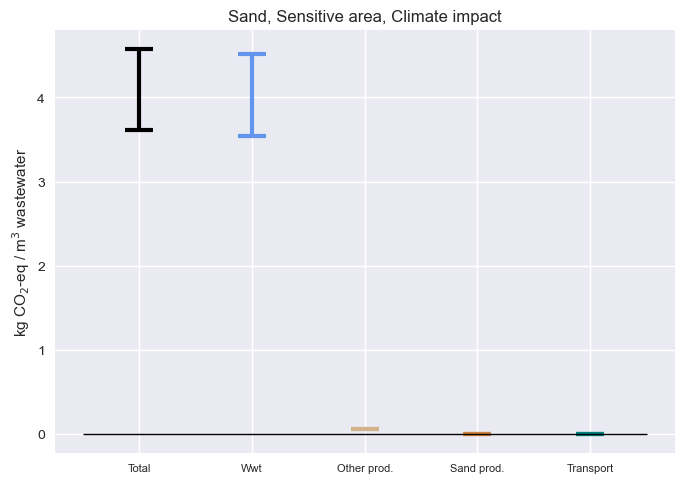

In [153]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

#ax.bar(1, Sand_Sensitive_medianClimate)
ax.errorbar(y=Sand_Sensitive_medianClimate, x=1, yerr = Sand_Sensitive_errorClimate, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, SandSensitiveClimateWwtmedian)
ax.errorbar(y=SandSensitiveClimateWwtmedian, x=2, yerr = SandSensitiveClimateWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, SandSensitiveClimateProdmedian)
ax.errorbar(y=SandSensitiveClimateProdmedian, x=3, yerr = SandSensitiveClimateProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(4, SandSensitiveClimateSandProdmedian)
ax.errorbar(y=SandSensitiveClimateSandProdmedian, x=4, yerr = SandSensitiveClimateSandProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(5, SandSensitiveClimateTransportmedian)
ax.errorbar(y=SandSensitiveClimateTransportmedian, x=5, yerr = SandSensitiveClimateTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Sensitive area, Climate impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(climate_label)

In [154]:
fig.savefig('CA-Sand-Sensitive-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [155]:
SandSensitiveresultEutrophication= runAlgebraicGraphTraversal([fu5], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [156]:
SandSensitiveresultEutrophication

{('wwt_db',
  'c4401064ed20418084f86b84ddf6bb93'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.000537345888708734*SandFilterVolume/LifetimeWW + 0.41894222753009/LifetimeWW],
               'Sand prod': [7.2778846392511e-11*SandinFilter*sand_switch_param_sand/LifetimeWW],
               'Transport': [1.33589489895468e-7*PlasticSTWeight*TransportDistanceST/LifetimeWW + 1.48268024301296e-12*SandinFilter*TransportDistanceFilter*sand_switch_param_sand/LifetimeWW],
               'Treatment': [5.0e-5*BOD5in*(1 - BOD5removalSand)*(-BOD5RemovalSludge - BODremovalPAC + 1) + 0.000150118105922054*N2air*NremovalSand*Ntotin*(1 - NremovalSludge) + 0.0001186*NH3air*NremovalSand*Ntotin*(1 - NremovalSludge)/NH3calc + 0.0104343067890593*PACdosage + 0.00729*PorgInPoutSand*Ptotin*(1 - PremovalPAC)*(1 - PremovalSand) + 0.00238*Ptotin*(1 - PorgInPoutSand)*(1 - PremovalPAC)*(1 - PremovalSand)/PO4calc + 0.0002367*NO3water*Ntotin*(1 - NremovalSand)*(1 - NremovalSludge)

In [157]:
SandSensitiveEutrophicationProd = SandSensitiveresultEutrophication[list(fu5.keys())[0]]['agg_graph']['Prod'][0]
SandSensitiveEutrophicationSandProd = SandSensitiveresultEutrophication[list(fu5.keys())[0]]['agg_graph']['Sand prod'][0]
SandSensitiveEutrophicationTransport = SandSensitiveresultEutrophication[list(fu5.keys())[0]]['agg_graph']['Transport'][0]
SandSensitiveEutrophicationWwt = SandSensitiveresultEutrophication[list(fu5.keys())[0]]['agg_graph']['Treatment'][0]

In [158]:
SandSensitiveEutrophicationProdL = createLambda(SandSensitiveEutrophicationProd)
SandSensitiveEutrophicationSandProdL = createLambda(SandSensitiveEutrophicationSandProd)
SandSensitiveEutrophicationTransportL = createLambda(SandSensitiveEutrophicationTransport)
SandSensitiveEutrophicationWwtL = createLambda(SandSensitiveEutrophicationWwt)

In [159]:
SandSensitiveEutrophicationProdY = _compute_stochastics([SandSensitiveEutrophicationProdL], TRACI_eut, params)
SandSensitiveEutrophicationSandProdY = _compute_stochastics([SandSensitiveEutrophicationSandProdL], TRACI_eut, params)
SandSensitiveEutrophicationTransportY = _compute_stochastics([SandSensitiveEutrophicationTransportL], TRACI_eut, params)
SandSensitiveEutrophicationWwtY = _compute_stochastics([SandSensitiveEutrophicationWwtL], TRACI_eut, params)

In [160]:
SandSensitiveEutrophicationProdmin = SandSensitiveEutrophicationProdY['eutrophication - eutrophication potential'].min()
SandSensitiveEutrophicationProdmax = SandSensitiveEutrophicationProdY['eutrophication - eutrophication potential'].max()
SandSensitiveEutrophicationProdmedian = SandSensitiveEutrophicationProdY['eutrophication - eutrophication potential'].median()
SandSensitiveEutrophicationProderror = np.array([SandSensitiveEutrophicationProdmedian-SandSensitiveEutrophicationProdmin, SandSensitiveEutrophicationProdmax-SandSensitiveEutrophicationProdmedian]).reshape((2,1))

SandSensitiveEutrophicationSandProdmin = SandSensitiveEutrophicationSandProdY['eutrophication - eutrophication potential'].min()
SandSensitiveEutrophicationSandProdmax = SandSensitiveEutrophicationSandProdY['eutrophication - eutrophication potential'].max()
SandSensitiveEutrophicationSandProdmedian = SandSensitiveEutrophicationSandProdY['eutrophication - eutrophication potential'].median()
SandSensitiveEutrophicationSandProderror = np.array([SandSensitiveEutrophicationSandProdmedian-SandSensitiveEutrophicationSandProdmin, SandSensitiveEutrophicationSandProdmax-SandSensitiveEutrophicationSandProdmedian]).reshape((2,1))

SandSensitiveEutrophicationTransportmin = SandSensitiveEutrophicationTransportY['eutrophication - eutrophication potential'].min()
SandSensitiveEutrophicationTransportmax = SandSensitiveEutrophicationTransportY['eutrophication - eutrophication potential'].max()
SandSensitiveEutrophicationTransportmedian = SandSensitiveEutrophicationTransportY['eutrophication - eutrophication potential'].median()
SandSensitiveEutrophicationTransporterror = np.array([SandSensitiveEutrophicationTransportmedian-SandSensitiveEutrophicationTransportmin, SandSensitiveEutrophicationTransportmax-SandSensitiveEutrophicationTransportmedian]).reshape((2,1))

SandSensitiveEutrophicationWwtmin = SandSensitiveEutrophicationWwtY['eutrophication - eutrophication potential'].min()
SandSensitiveEutrophicationWwtmax = SandSensitiveEutrophicationWwtY['eutrophication - eutrophication potential'].max()
SandSensitiveEutrophicationWwtmedian = SandSensitiveEutrophicationWwtY['eutrophication - eutrophication potential'].median()
SandSensitiveEutrophicationWwterror = np.array([SandSensitiveEutrophicationWwtmedian-SandSensitiveEutrophicationWwtmin, SandSensitiveEutrophicationWwtmax-SandSensitiveEutrophicationWwtmedian]).reshape((2,1))

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

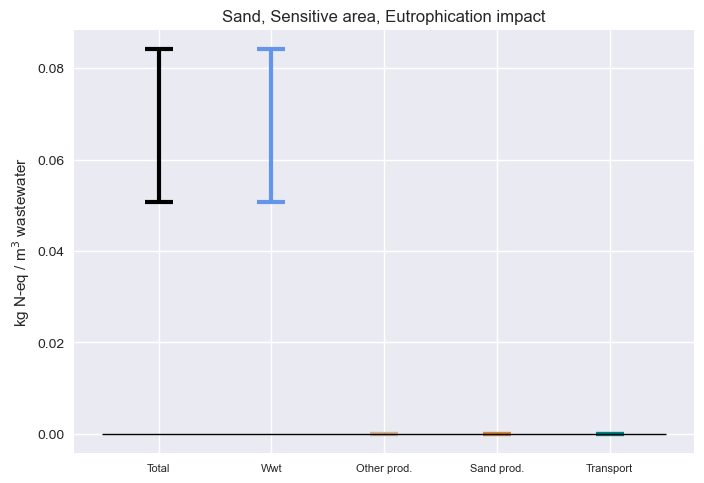

In [161]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

#ax.bar(1, Sand_Sensitive_medianEutroph)
ax.errorbar(y=Sand_Sensitive_medianEutroph, x=1, yerr = Sand_Sensitive_errorEutroph, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, SandSensitiveEutrophicationWwtmedian)
ax.errorbar(y=SandSensitiveEutrophicationWwtmedian, x=2, yerr = SandSensitiveEutrophicationWwterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, SandSensitiveEutrophicationProdmedian)
ax.errorbar(y=SandSensitiveEutrophicationProdmedian, x=3, yerr = SandSensitiveEutrophicationProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(4, SandSensitiveEutrophicationSandProdmedian)
ax.errorbar(y=SandSensitiveEutrophicationSandProdmedian, x=4, yerr = SandSensitiveEutrophicationSandProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(5, SandSensitiveEutrophicationTransportmedian)
ax.errorbar(y=SandSensitiveEutrophicationTransportmedian, x=5, yerr = SandSensitiveEutrophicationTransporterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Sensitive area, Eutrophication impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(eutroph_label)

In [163]:
#fig.savefig('CA-Sand-Sensitive-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [164]:
SandSensitiveresultAcidification= runAlgebraicGraphTraversal([fu5], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [165]:
SandSensitiveresultAcidification

{('wwt_db',
  'c4401064ed20418084f86b84ddf6bb93'): {'agg_graph': defaultdict(int,
              {'other': [0],
               'Prod': [0.00362462417361865*SandFilterVolume/LifetimeWW + 0.989779577679765/LifetimeWW],
               'Sand prod': [2.68235613879553e-10*SandinFilter*sand_switch_param_sand/LifetimeWW],
               'Transport': [3.24948898768936e-7*PlasticSTWeight*TransportDistanceST/LifetimeWW + 3.60653605736888e-12*SandinFilter*TransportDistanceFilter*sand_switch_param_sand/LifetimeWW],
               'Treatment': [0.0016*NH3air*NremovalSand*Ntotin*(1 - NremovalSludge)/NH3calc + 0.0110071666301348*PACdosage]}), 'graph': [{'activity': 'Sand Sensitive System' (unit, GLO, None),
    'amount': 1,
    'tag': 'other',
    'secondary_tags': [],
    'impact': [0],
    'biosphere': [],
    'technosphere': [{'activity': 'Sand Sensitive Prod' (unit, GLO, None),
      'amount': 1/LifetimeWW,
      'tag': 'Prod',
      'secondary_tags': [],
      'impact': [0.00362462417361865*SandFi

In [166]:
SandSensitiveAcidificationProd = SandSensitiveresultAcidification[list(fu5.keys())[0]]['agg_graph']['Prod'][0]
SandSensitiveAcidificationSandProd = SandSensitiveresultAcidification[list(fu5.keys())[0]]['agg_graph']['Sand prod'][0]
SandSensitiveAcidificationTransport = SandSensitiveresultAcidification[list(fu5.keys())[0]]['agg_graph']['Transport'][0]
SandSensitiveAcidificationWwt = SandSensitiveresultAcidification[list(fu5.keys())[0]]['agg_graph']['Treatment'][0]

In [167]:
SandSensitiveAcidificationProdL = createLambda(SandSensitiveAcidificationProd)
SandSensitiveAcidificationSandProdL = createLambda(SandSensitiveAcidificationSandProd)
SandSensitiveAcidificationTransportL = createLambda(SandSensitiveAcidificationTransport)
SandSensitiveAcidificationWwtL = createLambda(SandSensitiveAcidificationWwt)

In [168]:
SandSensitiveAcidificationProdY = _compute_stochastics([SandSensitiveAcidificationProdL], CML_acid, params)
SandSensitiveAcidificationSandProdY = _compute_stochastics([SandSensitiveAcidificationSandProdL], CML_acid, params)
SandSensitiveAcidificationTransportY = _compute_stochastics([SandSensitiveAcidificationTransportL], CML_acid, params)
SandSensitiveAcidificationWwtY = _compute_stochastics([SandSensitiveAcidificationWwtL], CML_acid, params)

In [169]:
SandSensitiveAcidificationProdmin = SandSensitiveAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
SandSensitiveAcidificationProdmax = SandSensitiveAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
SandSensitiveAcidificationProdmedian = SandSensitiveAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
SandSensitiveAcidificationProderror = np.array([SandSensitiveAcidificationProdmedian-SandSensitiveAcidificationProdmin, SandSensitiveAcidificationProdmax-SandSensitiveAcidificationProdmedian]).reshape((2,1))

SandSensitiveAcidificationSandProdmin = SandSensitiveAcidificationSandProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
SandSensitiveAcidificationSandProdmax = SandSensitiveAcidificationSandProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
SandSensitiveAcidificationSandProdmedian = SandSensitiveAcidificationSandProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
SandSensitiveAcidificationSandProderror = np.array([SandSensitiveAcidificationSandProdmedian-SandSensitiveAcidificationSandProdmin, SandSensitiveAcidificationSandProdmax-SandSensitiveAcidificationSandProdmedian]).reshape((2,1))

SandSensitiveAcidificationTransportmin = SandSensitiveAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
SandSensitiveAcidificationTransportmax = SandSensitiveAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
SandSensitiveAcidificationTransportmedian = SandSensitiveAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
SandSensitiveAcidificationTransporterror = np.array([SandSensitiveAcidificationTransportmedian-SandSensitiveAcidificationTransportmin, SandSensitiveAcidificationTransportmax-SandSensitiveAcidificationTransportmedian]).reshape((2,1))

SandSensitiveAcidificationWwtmin = SandSensitiveAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].min()
SandSensitiveAcidificationWwtmax = SandSensitiveAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].max()
SandSensitiveAcidificationWwtmedian = SandSensitiveAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].median()
SandSensitiveAcidificationWwterror = np.array([SandSensitiveAcidificationWwtmedian-SandSensitiveAcidificationWwtmin, SandSensitiveAcidificationWwtmax-SandSensitiveAcidificationWwtmedian]).reshape((2,1))

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

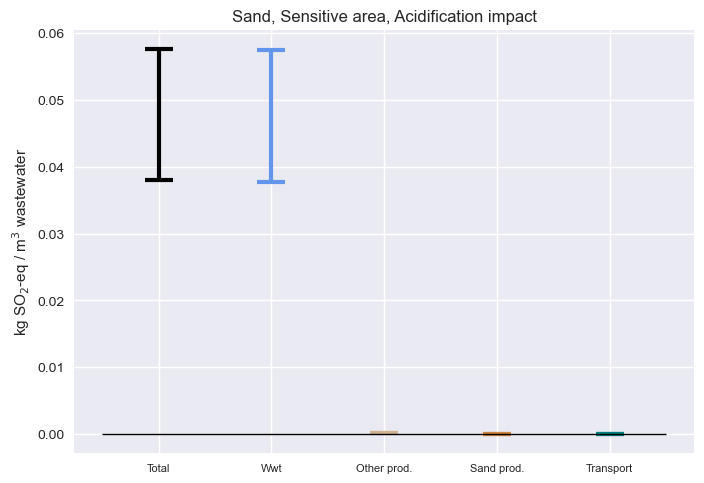

In [170]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

#ax.bar(1, Sand_Sensitive_medianAcid)
ax.errorbar(y=Sand_Sensitive_medianAcid, x=1, yerr = Sand_Sensitive_errorAcid, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, SandSensitiveAcidificationWwtmedian)
ax.errorbar(y=SandSensitiveAcidificationWwtmedian, x=2, yerr = SandSensitiveAcidificationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, SandSensitiveAcidificationProdmedian)
ax.errorbar(y=SandSensitiveAcidificationProdmedian, x=3, yerr = SandSensitiveAcidificationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(4, SandSensitiveAcidificationSandProdmedian)
ax.errorbar(y=SandSensitiveAcidificationSandProdmedian, x=4, yerr = SandSensitiveAcidificationSandProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(5, SandSensitiveAcidificationTransportmedian)
ax.errorbar(y=SandSensitiveAcidificationTransportmedian, x=5, yerr = SandSensitiveAcidificationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Sensitive area, Acidification impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(acid_label)

In [171]:
#fig.savefig('CA-Sand-Sensitive-Acid', dpi=600, bbox_inches='tight')

### scenario results (fig 6, good examples)

Before we run this - define Y:s for each bc system and impact cat (not sands though we already have them)

Which scenarios are interesting?

- BC Bed, normal, renewable, LS, LR (100% climate, 0.52% eutroph, 88.19% acid)
- BC Bed, sensitive, GW-S, fossil. (100% climate, 91.42% eutroph, 9.63% acid)
- BC Mod, fossil, LS, GW-S (100% climate, 96.45% eutroph, 0% acid)

#### BC Bed Normal

In [183]:
BCBedNormal_scenario_df = pd.DataFrame.from_dict(params)

In [184]:
BCBedNormal_scenario_df['BCBedNormal_ClimateImpact'] = Y1['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormal_Eutrophication'] = Y1['eutrophication - eutrophication potential'].values
BCBedNormal_scenario_df['BCBedNormal_Acidification'] = Y1['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [185]:
BCBedNormal_scenario_df['BCBedNormalClimateProd'] = BCBedNormalClimateProdY['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormalClimateBCProd'] = BCBedNormalClimateBCProdY['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormalClimateHeatSub'] = BCBedNormalClimateHeatSubY['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormalClimateTransport'] = BCBedNormalClimateTransportY['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormalClimateBCEOL'] = BCBedNormalClimateBCEOL_Y['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormalClimateLSSub'] = BCBedNormalClimateLSSubY['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormalClimateCseq'] = BCBedNormalClimateCseqY['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormalClimateElecSub'] = BCBedNormalClimateElecSubY['climate change - global warming potential (GWP100)'].values
BCBedNormal_scenario_df['BCBedNormalClimateWwt'] = BCBedNormalClimateWwtY['climate change - global warming potential (GWP100)'].values

In [186]:
BCBedNormal_scenario_df['BCBedNormalEutrophicationProd'] = BCBedNormalEutrophicationProdY['eutrophication - eutrophication potential'].values
BCBedNormal_scenario_df['BCBedNormalEutrophicationBCProd'] = BCBedNormalEutrophicationBCProdY['eutrophication - eutrophication potential'].values
BCBedNormal_scenario_df['BCBedNormalEutrophicationHeatSub'] = BCBedNormalEutrophicationHeatSubY['eutrophication - eutrophication potential'].values
BCBedNormal_scenario_df['BCBedNormalEutrophicationTransport'] = BCBedNormalEutrophicationTransportY['eutrophication - eutrophication potential'].values
BCBedNormal_scenario_df['BCBedNormalEutrophicationBCEOL'] = BCBedNormalEutrophicationBCEOL_Y['eutrophication - eutrophication potential'].values
BCBedNormal_scenario_df['BCBedNormalEutrophicationLSSub'] = BCBedNormalEutrophicationLSSubY['eutrophication - eutrophication potential'].values
BCBedNormal_scenario_df['BCBedNormalEutrophicationElecSub'] = BCBedNormalEutrophicationElecSubY['eutrophication - eutrophication potential'].values
BCBedNormal_scenario_df['BCBedNormalEutrophicationWwt'] = BCBedNormalEutrophicationWwtY['eutrophication - eutrophication potential'].values

In [187]:
BCBedNormal_scenario_df['BCBedNormalAcidificationProd'] = BCBedNormalAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedNormal_scenario_df['BCBedNormalAcidificationBCProd'] = BCBedNormalAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedNormal_scenario_df['BCBedNormalAcidificationHeatSub'] = BCBedNormalAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedNormal_scenario_df['BCBedNormalAcidificationTransport'] = BCBedNormalAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedNormal_scenario_df['BCBedNormalAcidificationBCEOL'] = BCBedNormalAcidificationBCEOL_Y['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedNormal_scenario_df['BCBedNormalAcidificationLSSub'] = BCBedNormalAcidificationLSSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedNormal_scenario_df['BCBedNormalAcidificationElecSub'] = BCBedNormalAcidificationElecSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedNormal_scenario_df['BCBedNormalAcidificationWwt'] = BCBedNormalAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [188]:
# bc5
BCBedNormal1_bc5 = BCBedNormal_scenario_df[BCBedNormal_scenario_df['bc_switch_param'] == 'bc5']
BCBedNormal2_bc5 = BCBedNormal1_bc5[BCBedNormal1_bc5['bc_HLswitch_param'] == 'bc5HL']
BCBedNormal_bc5 = BCBedNormal2_bc5[BCBedNormal2_bc5['bc_Seqswitch_param'] == 'bc5Seq']

In [189]:
# renewable energy
BCBedNormal_bc5_renewable_heat = BCBedNormal_bc5[BCBedNormal_bc5['heat_switch_param'] == 'heatWoodchips']
BCBedNormal_bc5_renewable = BCBedNormal_bc5_renewable_heat[BCBedNormal_bc5_renewable_heat['elec_switch_param'] == 'elecWindpower']

In [190]:
# EOL LS
BCBedNormal_scenario = BCBedNormal_bc5_renewable[BCBedNormal_bc5_renewable['EOL5and6_switch_param'] == 'LS3']

In [191]:
BCBedNormal_scenario['Climate_sum'] = BCBedNormal_scenario['BCBedNormalClimateProd'] + BCBedNormal_scenario['BCBedNormalClimateBCProd'] + BCBedNormal_scenario['BCBedNormalClimateHeatSub'] +BCBedNormal_scenario['BCBedNormalClimateTransport'] + BCBedNormal_scenario['BCBedNormalClimateBCEOL'] + BCBedNormal_scenario['BCBedNormalClimateLSSub'] + BCBedNormal_scenario['BCBedNormalClimateCseq'] +BCBedNormal_scenario['BCBedNormalClimateElecSub'] + BCBedNormal_scenario['BCBedNormalClimateWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\2366188693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCBedNormal_scenario['Climate_sum'] = BCBedNormal_scenario['BCBedNormalClimateProd'] + BCBedNormal_scenario['BCBedNormalClimateBCProd'] + BCBedNormal_scenario['BCBedNormalClimateHeatSub'] +BCBedNormal_scenario['BCBedNormalClimateTransport'] + BCBedNormal_scenario['BCBedNormalClimateBCEOL'] + BCBedNormal_scenario['BCBedNormalClimateLSSub'] + BCBedNormal_scenario['BCBedNormalClimateCseq'] +BCBedNormal_scenario['BCBedNormalClimateElecSub'] + BCBedNormal_scenario['BCBedNormalClimateWwt']


In [192]:
BCBedNormal_scenario['Eutrophication_sum'] = BCBedNormal_scenario['BCBedNormalEutrophicationProd'] + BCBedNormal_scenario['BCBedNormalEutrophicationBCProd'] + BCBedNormal_scenario['BCBedNormalEutrophicationHeatSub'] +BCBedNormal_scenario['BCBedNormalEutrophicationTransport'] + BCBedNormal_scenario['BCBedNormalEutrophicationBCEOL'] + BCBedNormal_scenario['BCBedNormalEutrophicationLSSub'] +BCBedNormal_scenario['BCBedNormalEutrophicationElecSub'] + BCBedNormal_scenario['BCBedNormalEutrophicationWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\4194779432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCBedNormal_scenario['Eutrophication_sum'] = BCBedNormal_scenario['BCBedNormalEutrophicationProd'] + BCBedNormal_scenario['BCBedNormalEutrophicationBCProd'] + BCBedNormal_scenario['BCBedNormalEutrophicationHeatSub'] +BCBedNormal_scenario['BCBedNormalEutrophicationTransport'] + BCBedNormal_scenario['BCBedNormalEutrophicationBCEOL'] + BCBedNormal_scenario['BCBedNormalEutrophicationLSSub'] +BCBedNormal_scenario['BCBedNormalEutrophicationElecSub'] + BCBedNormal_scenario['BCBedNormalEutrophicationWwt']


In [193]:
BCBedNormal_scenario['Acidification_sum'] = BCBedNormal_scenario['BCBedNormalAcidificationProd'] + BCBedNormal_scenario['BCBedNormalAcidificationBCProd'] + BCBedNormal_scenario['BCBedNormalAcidificationHeatSub'] +BCBedNormal_scenario['BCBedNormalAcidificationTransport'] + BCBedNormal_scenario['BCBedNormalAcidificationBCEOL'] + BCBedNormal_scenario['BCBedNormalAcidificationLSSub'] +BCBedNormal_scenario['BCBedNormalAcidificationElecSub'] + BCBedNormal_scenario['BCBedNormalAcidificationWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\656024773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCBedNormal_scenario['Acidification_sum'] = BCBedNormal_scenario['BCBedNormalAcidificationProd'] + BCBedNormal_scenario['BCBedNormalAcidificationBCProd'] + BCBedNormal_scenario['BCBedNormalAcidificationHeatSub'] +BCBedNormal_scenario['BCBedNormalAcidificationTransport'] + BCBedNormal_scenario['BCBedNormalAcidificationBCEOL'] + BCBedNormal_scenario['BCBedNormalAcidificationLSSub'] +BCBedNormal_scenario['BCBedNormalAcidificationElecSub'] + BCBedNormal_scenario['BCBedNormalAcidificationWwt']


##### climate

In [194]:
BCBedNormalClimateTotmin = BCBedNormal_scenario['Climate_sum'].min()
BCBedNormalClimateTotmax = BCBedNormal_scenario['Climate_sum'].max()
BCBedNormalClimateTotmedian = BCBedNormal_scenario['Climate_sum'].median()
BCBedNormalClimateToterror = np.array([BCBedNormalClimateTotmedian-BCBedNormalClimateTotmin, BCBedNormalClimateTotmax-BCBedNormalClimateTotmedian]).reshape((2,1))

In [266]:
#BCBedNormalClimateTotmin = BCBedNormal_scenario['BCBedNormal_ClimateImpact'].min()
#BCBedNormalClimateTotmax = BCBedNormal_scenario['BCBedNormal_ClimateImpact'].max()
#BCBedNormalClimateTotmedian = BCBedNormal_scenario['BCBedNormal_ClimateImpact'].median()
#BCBedNormalClimateToterror = np.array([BCBedNormalClimateTotmedian-BCBedNormalClimateTotmin, BCBedNormalClimateTotmax-BCBedNormalClimateTotmedian]).reshape((2,1))

In [195]:
BCBedNormalClimateProdmin = BCBedNormal_scenario['BCBedNormalClimateProd'].min()
BCBedNormalClimateProdmax = BCBedNormal_scenario['BCBedNormalClimateProd'].max()
BCBedNormalClimateProdmedian = BCBedNormal_scenario['BCBedNormalClimateProd'].median()
BCBedNormalClimateProderror = np.array([BCBedNormalClimateProdmedian-BCBedNormalClimateProdmin, BCBedNormalClimateProdmax-BCBedNormalClimateProdmedian]).reshape((2,1))

In [196]:
BCBedNormalClimateBCProdmin = BCBedNormal_scenario['BCBedNormalClimateBCProd'].min()
BCBedNormalClimateBCProdmax = BCBedNormal_scenario['BCBedNormalClimateBCProd'].max()
BCBedNormalClimateBCProdmedian = BCBedNormal_scenario['BCBedNormalClimateBCProd'].median()
BCBedNormalClimateBCProderror = np.array([BCBedNormalClimateBCProdmedian-BCBedNormalClimateBCProdmin, BCBedNormalClimateBCProdmax-BCBedNormalClimateBCProdmedian]).reshape((2,1))

In [197]:
BCBedNormalClimateHeatSubmin = BCBedNormal_scenario['BCBedNormalClimateHeatSub'].min()
BCBedNormalClimateHeatSubmax = BCBedNormal_scenario['BCBedNormalClimateHeatSub'].max()
BCBedNormalClimateHeatSubmedian = BCBedNormal_scenario['BCBedNormalClimateHeatSub'].median()
BCBedNormalClimateHeatSuberror = np.array([BCBedNormalClimateHeatSubmedian-BCBedNormalClimateHeatSubmin, BCBedNormalClimateHeatSubmax-BCBedNormalClimateHeatSubmedian]).reshape((2,1))

In [198]:
BCBedNormalClimateTransportmin = BCBedNormal_scenario['BCBedNormalClimateTransport'].min()
BCBedNormalClimateTransportmax = BCBedNormal_scenario['BCBedNormalClimateTransport'].max()
BCBedNormalClimateTransportmedian = BCBedNormal_scenario['BCBedNormalClimateTransport'].median()
BCBedNormalClimateTransporterror = np.array([BCBedNormalClimateTransportmedian-BCBedNormalClimateTransportmin, BCBedNormalClimateTransportmax-BCBedNormalClimateTransportmedian]).reshape((2,1))

In [199]:
BCBedNormalClimateBCEOLmin = BCBedNormal_scenario['BCBedNormalClimateBCEOL'].min()
BCBedNormalClimateBCEOLmax = BCBedNormal_scenario['BCBedNormalClimateBCEOL'].max()
BCBedNormalClimateBCEOLmedian = BCBedNormal_scenario['BCBedNormalClimateBCEOL'].median()
BCBedNormalClimateBCEOLerror = np.array([BCBedNormalClimateBCEOLmedian-BCBedNormalClimateBCEOLmin, BCBedNormalClimateBCEOLmax-BCBedNormalClimateBCEOLmedian]).reshape((2,1))

In [200]:
BCBedNormalClimateLSSubmin = BCBedNormal_scenario['BCBedNormalClimateLSSub'].min()
BCBedNormalClimateLSSubmax = BCBedNormal_scenario['BCBedNormalClimateLSSub'].max()
BCBedNormalClimateLSSubmedian = BCBedNormal_scenario['BCBedNormalClimateLSSub'].median()
BCBedNormalClimateLSSuberror = np.array([BCBedNormalClimateLSSubmedian-BCBedNormalClimateLSSubmin, BCBedNormalClimateLSSubmax-BCBedNormalClimateLSSubmedian]).reshape((2,1))

In [201]:
BCBedNormalClimateCseqmin = BCBedNormal_scenario['BCBedNormalClimateCseq'].min()
BCBedNormalClimateCseqmax = BCBedNormal_scenario['BCBedNormalClimateCseq'].max()
BCBedNormalClimateCseqmedian = BCBedNormal_scenario['BCBedNormalClimateCseq'].median()
BCBedNormalClimateCseqerror = np.array([BCBedNormalClimateCseqmedian-BCBedNormalClimateCseqmin, BCBedNormalClimateCseqmax-BCBedNormalClimateCseqmedian]).reshape((2,1))

In [202]:
BCBedNormalClimateElecSubmin = BCBedNormal_scenario['BCBedNormalClimateElecSub'].min()
BCBedNormalClimateElecSubmax = BCBedNormal_scenario['BCBedNormalClimateElecSub'].max()
BCBedNormalClimateElecSubmedian = BCBedNormal_scenario['BCBedNormalClimateElecSub'].median()
BCBedNormalClimateElecSuberror = np.array([BCBedNormalClimateElecSubmedian-BCBedNormalClimateElecSubmin, BCBedNormalClimateElecSubmax-BCBedNormalClimateElecSubmedian]).reshape((2,1))

In [203]:
BCBedNormalClimateWwtmin = BCBedNormal_scenario['BCBedNormalClimateWwt'].min()
BCBedNormalClimateWwtmax = BCBedNormal_scenario['BCBedNormalClimateWwt'].max()
BCBedNormalClimateWwtmedian = BCBedNormal_scenario['BCBedNormalClimateWwt'].median()
BCBedNormalClimateWwterror = np.array([BCBedNormalClimateWwtmedian-BCBedNormalClimateWwtmin, BCBedNormalClimateWwtmax-BCBedNormalClimateWwtmedian]).reshape((2,1))

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

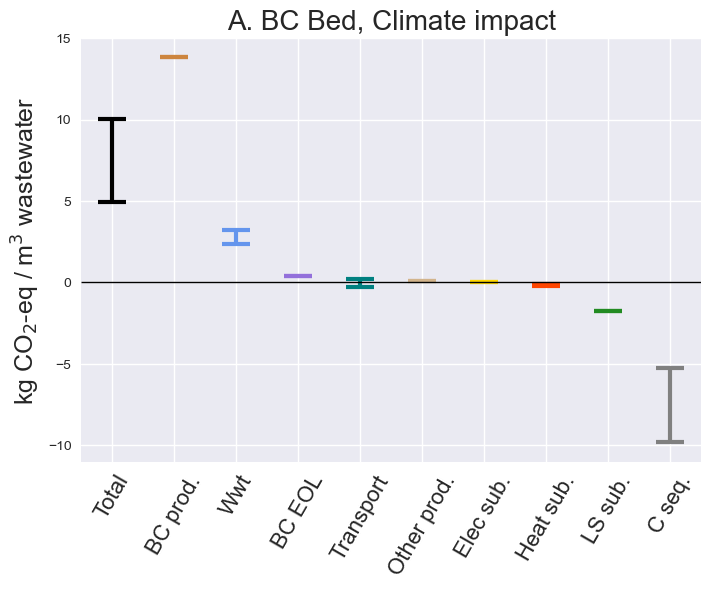

In [259]:
fig, ax = plt.subplots()

xlabels = ('Total', 'BC prod.', 'Wwt', 'BC EOL', 'Transport', 'Other prod.', 'Elec sub.', 'Heat sub.','LS sub.', 'C seq.')

#ax.bar(1, BCBedNormalClimateTotmedian)
ax.errorbar(y=BCBedNormalClimateTotmedian, x=1, yerr = BCBedNormalClimateToterror, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedNormalClimateBCProdmedian)
ax.errorbar(y=BCBedNormalClimateBCProdmedian, x=2, yerr = BCBedNormalClimateBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(3, BCBedNormalClimateWwtmedian)
ax.errorbar(y=BCBedNormalClimateWwtmedian, x=3, yerr = BCBedNormalClimateWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(4, BCBedNormalClimateBCEOLmedian)
ax.errorbar(y=BCBedNormalClimateBCEOLmedian, x=4, yerr = BCBedNormalClimateBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCBedNormalClimateTransportmedian)
ax.errorbar(y=BCBedNormalClimateTransportmedian, x=5, yerr = BCBedNormalClimateTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCBedNormalClimateProdmedian)
ax.errorbar(y=BCBedNormalClimateProdmedian, x=6, yerr = BCBedNormalClimateProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(7, BCBedNormalClimateElecSubmedian)
ax.errorbar(y=BCBedNormalClimateElecSubmedian, x=7, yerr = BCBedNormalClimateElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

#ax.bar(8, BCBedNormalClimateHeatSubmedian)
ax.errorbar(y=BCBedNormalClimateHeatSubmedian, x=8, yerr = BCBedNormalClimateHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(9, BCBedNormalClimateLSSubmedian)
ax.errorbar(y=BCBedNormalClimateLSSubmedian, x=9, yerr = BCBedNormalClimateLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(10, BCBedNormalClimateCseqmedian)
ax.errorbar(y=BCBedNormalClimateCseqmedian, x=10, yerr = BCBedNormalClimateCseqerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='grey')


ax.hlines(y=0, xmin=0.5, xmax=10.5, linewidth=1, color='black')
ax.set_xlim(0.5,10.5)

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.set_title('A. BC Bed, Climate impact', fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.set_ylabel(climate_label, fontsize=18)

In [211]:
#fig.savefig('Scenario-GraphAbs', dpi=600, bbox_inches='tight')

In [260]:
fig.savefig('Scenario-BCBed-Normal-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [214]:
BCBedNormalEutrophicationTotmin = BCBedNormal_scenario['Eutrophication_sum'].min()
BCBedNormalEutrophicationTotmax = BCBedNormal_scenario['Eutrophication_sum'].max()
BCBedNormalEutrophicationTotmedian = BCBedNormal_scenario['Eutrophication_sum'].median()
BCBedNormalEutrophicationToterror = np.array([BCBedNormalEutrophicationTotmedian-BCBedNormalEutrophicationTotmin, BCBedNormalEutrophicationTotmax-BCBedNormalEutrophicationTotmedian]).reshape((2,1))

#BCBedNormalEutrophicationTotmin = BCBedNormal_scenario['BCBedNormal_Eutrophication'].min()
#BCBedNormalEutrophicationTotmax = BCBedNormal_scenario['BCBedNormal_Eutrophication'].max()
#BCBedNormalEutrophicationTotmedian = BCBedNormal_scenario['BCBedNormal_Eutrophication'].median()
#BCBedNormalEutrophicationToterror = np.array([BCBedNormalEutrophicationTotmedian-BCBedNormalEutrophicationTotmin, BCBedNormalEutrophicationTotmax-BCBedNormalEutrophicationTotmedian]).reshape((2,1))

BCBedNormalEutrophicationProdmin = BCBedNormal_scenario['BCBedNormalEutrophicationProd'].min()
BCBedNormalEutrophicationProdmax = BCBedNormal_scenario['BCBedNormalEutrophicationProd'].max()
BCBedNormalEutrophicationProdmedian = BCBedNormal_scenario['BCBedNormalEutrophicationProd'].median()
BCBedNormalEutrophicationProderror = np.array([BCBedNormalEutrophicationProdmedian-BCBedNormalEutrophicationProdmin, BCBedNormalEutrophicationProdmax-BCBedNormalEutrophicationProdmedian]).reshape((2,1))

BCBedNormalEutrophicationBCProdmin = BCBedNormal_scenario['BCBedNormalEutrophicationBCProd'].min()
BCBedNormalEutrophicationBCProdmax = BCBedNormal_scenario['BCBedNormalEutrophicationBCProd'].max()
BCBedNormalEutrophicationBCProdmedian = BCBedNormal_scenario['BCBedNormalEutrophicationBCProd'].median()
BCBedNormalEutrophicationBCProderror = np.array([BCBedNormalEutrophicationBCProdmedian-BCBedNormalEutrophicationBCProdmin, BCBedNormalEutrophicationBCProdmax-BCBedNormalEutrophicationBCProdmedian]).reshape((2,1))

BCBedNormalEutrophicationHeatSubmin = BCBedNormal_scenario['BCBedNormalEutrophicationHeatSub'].min()
BCBedNormalEutrophicationHeatSubmax = BCBedNormal_scenario['BCBedNormalEutrophicationHeatSub'].max()
BCBedNormalEutrophicationHeatSubmedian = BCBedNormal_scenario['BCBedNormalEutrophicationHeatSub'].median()
BCBedNormalEutrophicationHeatSuberror = np.array([BCBedNormalEutrophicationHeatSubmedian-BCBedNormalEutrophicationHeatSubmin, BCBedNormalEutrophicationHeatSubmax-BCBedNormalEutrophicationHeatSubmedian]).reshape((2,1))

BCBedNormalEutrophicationTransportmin = BCBedNormal_scenario['BCBedNormalEutrophicationTransport'].min()
BCBedNormalEutrophicationTransportmax = BCBedNormal_scenario['BCBedNormalEutrophicationTransport'].max()
BCBedNormalEutrophicationTransportmedian = BCBedNormal_scenario['BCBedNormalEutrophicationTransport'].median()
BCBedNormalEutrophicationTransporterror = np.array([BCBedNormalEutrophicationTransportmedian-BCBedNormalEutrophicationTransportmin, BCBedNormalEutrophicationTransportmax-BCBedNormalEutrophicationTransportmedian]).reshape((2,1))

BCBedNormalEutrophicationBCEOLmin = BCBedNormal_scenario['BCBedNormalEutrophicationBCEOL'].min()
BCBedNormalEutrophicationBCEOLmax = BCBedNormal_scenario['BCBedNormalEutrophicationBCEOL'].max()
BCBedNormalEutrophicationBCEOLmedian = BCBedNormal_scenario['BCBedNormalEutrophicationBCEOL'].median()
BCBedNormalEutrophicationBCEOLerror = np.array([BCBedNormalEutrophicationBCEOLmedian-BCBedNormalEutrophicationBCEOLmin, BCBedNormalEutrophicationBCEOLmax-BCBedNormalEutrophicationBCEOLmedian]).reshape((2,1))

BCBedNormalEutrophicationLSSubmin = BCBedNormal_scenario['BCBedNormalEutrophicationLSSub'].min()
BCBedNormalEutrophicationLSSubmax = BCBedNormal_scenario['BCBedNormalEutrophicationLSSub'].max()
BCBedNormalEutrophicationLSSubmedian = BCBedNormal_scenario['BCBedNormalEutrophicationLSSub'].median()
BCBedNormalEutrophicationLSSuberror = np.array([BCBedNormalEutrophicationLSSubmedian-BCBedNormalEutrophicationLSSubmin, BCBedNormalEutrophicationLSSubmax-BCBedNormalEutrophicationLSSubmedian]).reshape((2,1))

BCBedNormalEutrophicationElecSubmin = BCBedNormal_scenario['BCBedNormalEutrophicationElecSub'].min()
BCBedNormalEutrophicationElecSubmax = BCBedNormal_scenario['BCBedNormalEutrophicationElecSub'].max()
BCBedNormalEutrophicationElecSubmedian = BCBedNormal_scenario['BCBedNormalEutrophicationElecSub'].median()
BCBedNormalEutrophicationElecSuberror = np.array([BCBedNormalEutrophicationElecSubmedian-BCBedNormalEutrophicationElecSubmin, BCBedNormalEutrophicationElecSubmax-BCBedNormalEutrophicationElecSubmedian]).reshape((2,1))

BCBedNormalEutrophicationWwtmin = BCBedNormal_scenario['BCBedNormalEutrophicationWwt'].min()
BCBedNormalEutrophicationWwtmax = BCBedNormal_scenario['BCBedNormalEutrophicationWwt'].max()
BCBedNormalEutrophicationWwtmedian = BCBedNormal_scenario['BCBedNormalEutrophicationWwt'].median()
BCBedNormalEutrophicationWwterror = np.array([BCBedNormalEutrophicationWwtmedian-BCBedNormalEutrophicationWwtmin, BCBedNormalEutrophicationWwtmax-BCBedNormalEutrophicationWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

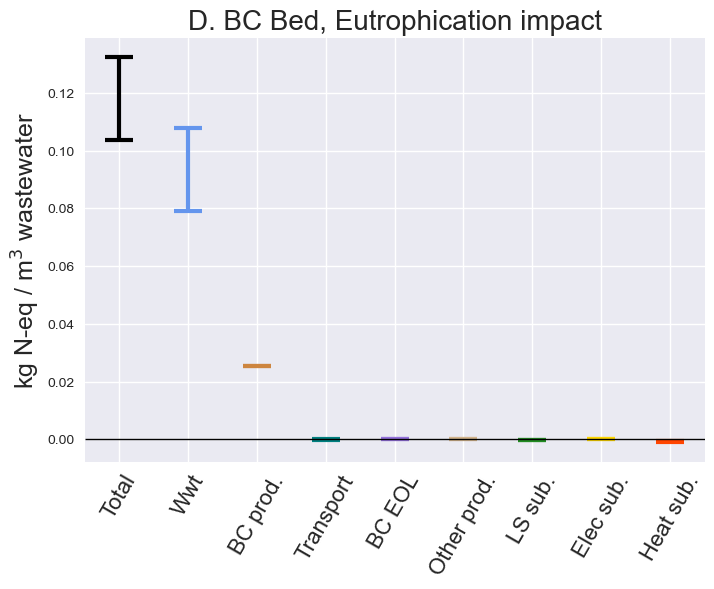

In [277]:
fig, ax = plt.subplots()

xlabels = ('Total', 'Wwt', 'BC prod.', 'Transport', 'BC EOL', 'Other prod.', 'LS sub.', 'Elec sub.','Heat sub.')

#ax.bar(1, BCBedNormalEutrophicationTotmedian)
ax.errorbar(y=BCBedNormalEutrophicationTotmedian, x=1, yerr = BCBedNormalEutrophicationToterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedNormalEutrophicationWwtmedian)
ax.errorbar(y=BCBedNormalEutrophicationWwtmedian, x=2, yerr = BCBedNormalEutrophicationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCBedNormalEutrophicationBCProdmedian)
ax.errorbar(y=BCBedNormalEutrophicationBCProdmedian, x=3, yerr = BCBedNormalEutrophicationBCProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCBedNormalEutrophicationTransportmedian)
ax.errorbar(y=BCBedNormalEutrophicationTransportmedian, x=4, yerr = BCBedNormalEutrophicationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(5, BCBedNormalEutrophicationBCEOLmedian)
ax.errorbar(y=BCBedNormalEutrophicationBCEOLmedian, x=5, yerr = BCBedNormalEutrophicationBCEOLerror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(6, BCBedNormalEutrophicationProdmedian)
ax.errorbar(y=BCBedNormalEutrophicationProdmedian, x=6, yerr = BCBedNormalEutrophicationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(7, BCBedNormalEutrophicationLSSubmedian)
ax.errorbar(y=BCBedNormalEutrophicationLSSubmedian, x=7, yerr = BCBedNormalEutrophicationLSSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(8, BCBedNormalEutrophicationElecSubmedian)
ax.errorbar(y=BCBedNormalEutrophicationElecSubmedian, x=8, yerr = BCBedNormalEutrophicationElecSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='gold')

#ax.bar(9, BCBedNormalEutrophicationHeatSubmedian)
ax.errorbar(y=BCBedNormalEutrophicationHeatSubmedian, x=9, yerr = BCBedNormalEutrophicationHeatSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_xlim(0.5,9.5)
ax.set_title('D. BC Bed, Eutrophication impact',fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.set_ylabel(eutroph_label,fontsize=18)

In [278]:
fig.savefig('Scenario-BCBed-Normal-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [217]:
BCBedNormalAcidificationTotmin = BCBedNormal_scenario['Acidification_sum'].min()
BCBedNormalAcidificationTotmax = BCBedNormal_scenario['Acidification_sum'].max()
BCBedNormalAcidificationTotmedian = BCBedNormal_scenario['Acidification_sum'].median()
BCBedNormalAcidificationToterror = np.array([BCBedNormalAcidificationTotmedian-BCBedNormalAcidificationTotmin, BCBedNormalAcidificationTotmax-BCBedNormalAcidificationTotmedian]).reshape((2,1))

#BCBedNormalAcidificationTotmin = BCBedNormal_scenario['BCBedNormal_Acidification'].min()
#BCBedNormalAcidificationTotmax = BCBedNormal_scenario['BCBedNormal_Acidification'].max()
#BCBedNormalAcidificationTotmedian = BCBedNormal_scenario['BCBedNormal_Acidification'].median()
#BCBedNormalAcidificationToterror = np.array([BCBedNormalAcidificationTotmedian-BCBedNormalAcidificationTotmin, BCBedNormalAcidificationTotmax-BCBedNormalAcidificationTotmedian]).reshape((2,1))

BCBedNormalAcidificationProdmin = BCBedNormal_scenario['BCBedNormalAcidificationProd'].min()
BCBedNormalAcidificationProdmax = BCBedNormal_scenario['BCBedNormalAcidificationProd'].max()
BCBedNormalAcidificationProdmedian = BCBedNormal_scenario['BCBedNormalAcidificationProd'].median()
BCBedNormalAcidificationProderror = np.array([BCBedNormalAcidificationProdmedian-BCBedNormalAcidificationProdmin, BCBedNormalAcidificationProdmax-BCBedNormalAcidificationProdmedian]).reshape((2,1))

BCBedNormalAcidificationBCProdmin = BCBedNormal_scenario['BCBedNormalAcidificationBCProd'].min()
BCBedNormalAcidificationBCProdmax = BCBedNormal_scenario['BCBedNormalAcidificationBCProd'].max()
BCBedNormalAcidificationBCProdmedian = BCBedNormal_scenario['BCBedNormalAcidificationBCProd'].median()
BCBedNormalAcidificationBCProderror = np.array([BCBedNormalAcidificationBCProdmedian-BCBedNormalAcidificationBCProdmin, BCBedNormalAcidificationBCProdmax-BCBedNormalAcidificationBCProdmedian]).reshape((2,1))

BCBedNormalAcidificationHeatSubmin = BCBedNormal_scenario['BCBedNormalAcidificationHeatSub'].min()
BCBedNormalAcidificationHeatSubmax = BCBedNormal_scenario['BCBedNormalAcidificationHeatSub'].max()
BCBedNormalAcidificationHeatSubmedian = BCBedNormal_scenario['BCBedNormalAcidificationHeatSub'].median()
BCBedNormalAcidificationHeatSuberror = np.array([BCBedNormalAcidificationHeatSubmedian-BCBedNormalAcidificationHeatSubmin, BCBedNormalAcidificationHeatSubmax-BCBedNormalAcidificationHeatSubmedian]).reshape((2,1))

BCBedNormalAcidificationTransportmin = BCBedNormal_scenario['BCBedNormalAcidificationTransport'].min()
BCBedNormalAcidificationTransportmax = BCBedNormal_scenario['BCBedNormalAcidificationTransport'].max()
BCBedNormalAcidificationTransportmedian = BCBedNormal_scenario['BCBedNormalAcidificationTransport'].median()
BCBedNormalAcidificationTransporterror = np.array([BCBedNormalAcidificationTransportmedian-BCBedNormalAcidificationTransportmin, BCBedNormalAcidificationTransportmax-BCBedNormalAcidificationTransportmedian]).reshape((2,1))

BCBedNormalAcidificationBCEOLmin = BCBedNormal_scenario['BCBedNormalAcidificationBCEOL'].min()
BCBedNormalAcidificationBCEOLmax = BCBedNormal_scenario['BCBedNormalAcidificationBCEOL'].max()
BCBedNormalAcidificationBCEOLmedian = BCBedNormal_scenario['BCBedNormalAcidificationBCEOL'].median()
BCBedNormalAcidificationBCEOLerror = np.array([BCBedNormalAcidificationBCEOLmedian-BCBedNormalAcidificationBCEOLmin, BCBedNormalAcidificationBCEOLmax-BCBedNormalAcidificationBCEOLmedian]).reshape((2,1))

BCBedNormalAcidificationLSSubmin = BCBedNormal_scenario['BCBedNormalAcidificationLSSub'].min()
BCBedNormalAcidificationLSSubmax = BCBedNormal_scenario['BCBedNormalAcidificationLSSub'].max()
BCBedNormalAcidificationLSSubmedian = BCBedNormal_scenario['BCBedNormalAcidificationLSSub'].median()
BCBedNormalAcidificationLSSuberror = np.array([BCBedNormalAcidificationLSSubmedian-BCBedNormalAcidificationLSSubmin, BCBedNormalAcidificationLSSubmax-BCBedNormalAcidificationLSSubmedian]).reshape((2,1))

BCBedNormalAcidificationElecSubmin = BCBedNormal_scenario['BCBedNormalAcidificationElecSub'].min()
BCBedNormalAcidificationElecSubmax = BCBedNormal_scenario['BCBedNormalAcidificationElecSub'].max()
BCBedNormalAcidificationElecSubmedian = BCBedNormal_scenario['BCBedNormalAcidificationElecSub'].median()
BCBedNormalAcidificationElecSuberror = np.array([BCBedNormalAcidificationElecSubmedian-BCBedNormalAcidificationElecSubmin, BCBedNormalAcidificationElecSubmax-BCBedNormalAcidificationElecSubmedian]).reshape((2,1))

BCBedNormalAcidificationWwtmin = BCBedNormal_scenario['BCBedNormalAcidificationWwt'].min()
BCBedNormalAcidificationWwtmax = BCBedNormal_scenario['BCBedNormalAcidificationWwt'].max()
BCBedNormalAcidificationWwtmedian = BCBedNormal_scenario['BCBedNormalAcidificationWwt'].median()
BCBedNormalAcidificationWwterror = np.array([BCBedNormalAcidificationWwtmedian-BCBedNormalAcidificationWwtmin, BCBedNormalAcidificationWwtmax-BCBedNormalAcidificationWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

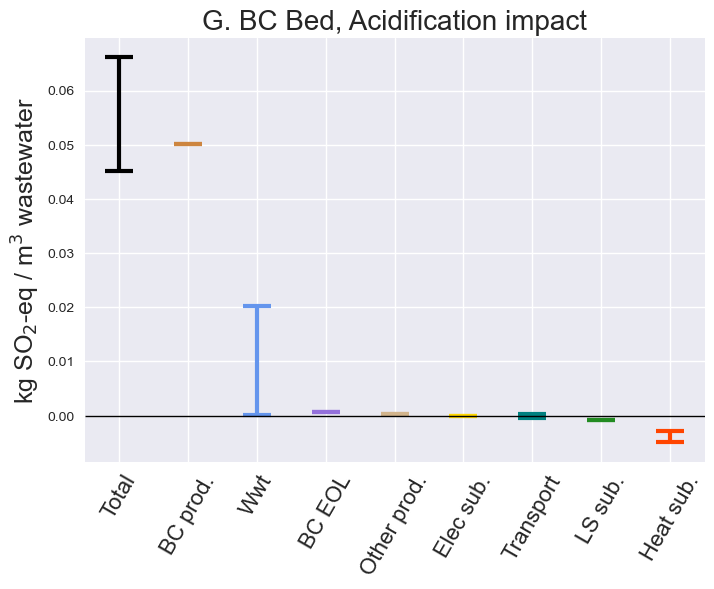

In [293]:
xlabels = ('Total','BC prod.', 'Wwt','BC EOL','Other prod.','Elec sub.', 'Transport', 'LS sub.', 'Heat sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCBedNormalAcidificationTotmedian)
ax.errorbar(y=BCBedNormalAcidificationTotmedian, x=1, yerr = BCBedNormalAcidificationToterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedNormalAcidificationBCProdmedian)
ax.errorbar(y=BCBedNormalAcidificationBCProdmedian, x=2, yerr = BCBedNormalAcidificationBCProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(3, BCBedNormalAcidificationWwtmedian)
ax.errorbar(y=BCBedNormalAcidificationWwtmedian, x=3, yerr = BCBedNormalAcidificationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(4, BCBedNormalAcidificationBCEOLmedian)
ax.errorbar(y=BCBedNormalAcidificationBCEOLmedian, x=4, yerr = BCBedNormalAcidificationBCEOLerror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCBedNormalAcidificationProdmedian)
ax.errorbar(y=BCBedNormalAcidificationProdmedian, x=5, yerr = BCBedNormalAcidificationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(6, BCBedNormalAcidificationElecSubmedian)
ax.errorbar(y=BCBedNormalAcidificationElecSubmedian, x=6, yerr = BCBedNormalAcidificationElecSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='gold')

#ax.bar(7, BCBedNormalAcidificationTransportmedian)
ax.errorbar(y=BCBedNormalAcidificationTransportmedian, x=7, yerr = BCBedNormalAcidificationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(8, BCBedNormalAcidificationLSSubmedian)
ax.errorbar(y=BCBedNormalAcidificationLSSubmedian, x=8, yerr = BCBedNormalAcidificationLSSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(9, BCBedNormalAcidificationHeatSubmedian)
ax.errorbar(y=BCBedNormalAcidificationHeatSubmedian, x=9, yerr = BCBedNormalAcidificationHeatSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_xlim(0.5,9.5)
ax.set_title('G. BC Bed, Acidification impact',fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.set_ylabel(acid_label,fontsize=18)

In [294]:
fig.savefig('Scenario-BCBed-Normal-Acid', dpi=600, bbox_inches='tight')

#### BC Bed Sensitive

In [220]:
BCBedSensitive_scenario_df = pd.DataFrame.from_dict(params)

In [221]:
BCBedSensitive_scenario_df['BCBedSensitive_ClimateImpact'] = Y3['climate change - global warming potential (GWP100)'].values
BCBedSensitive_scenario_df['BCBedSensitive_Eutrophication'] = Y3['eutrophication - eutrophication potential'].values
BCBedSensitive_scenario_df['BCBedSensitive_Acidification'] = Y3['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [222]:
BCBedSensitive_scenario_df['BCBedSensitiveClimateProd'] = BCBedSensitiveClimateProdY['climate change - global warming potential (GWP100)'].values
BCBedSensitive_scenario_df['BCBedSensitiveClimateBCProd'] = BCBedSensitiveClimateBCProdY['climate change - global warming potential (GWP100)'].values
BCBedSensitive_scenario_df['BCBedSensitiveClimateHeatSub'] = BCBedSensitiveClimateHeatSubY['climate change - global warming potential (GWP100)'].values
BCBedSensitive_scenario_df['BCBedSensitiveClimateTransport'] = BCBedSensitiveClimateTransportY['climate change - global warming potential (GWP100)'].values
BCBedSensitive_scenario_df['BCBedSensitiveClimateCseq'] = BCBedSensitiveClimateCseqY['climate change - global warming potential (GWP100)'].values
BCBedSensitive_scenario_df['BCBedSensitiveClimateWwt'] = BCBedSensitiveClimateWwtY['climate change - global warming potential (GWP100)'].values

In [223]:
BCBedSensitive_scenario_df['BCBedSensitiveEutrophicationProd'] = BCBedSensitiveEutrophicationProdY['eutrophication - eutrophication potential'].values
BCBedSensitive_scenario_df['BCBedSensitiveEutrophicationBCProd'] = BCBedSensitiveEutrophicationBCProdY['eutrophication - eutrophication potential'].values
BCBedSensitive_scenario_df['BCBedSensitiveEutrophicationHeatSub'] = BCBedSensitiveEutrophicationHeatSubY['eutrophication - eutrophication potential'].values
BCBedSensitive_scenario_df['BCBedSensitiveEutrophicationTransport'] = BCBedSensitiveEutrophicationTransportY['eutrophication - eutrophication potential'].values
BCBedSensitive_scenario_df['BCBedSensitiveEutrophicationWwt'] = BCBedSensitiveEutrophicationWwtY['eutrophication - eutrophication potential'].values

In [224]:
BCBedSensitive_scenario_df['BCBedSensitiveAcidificationProd'] = BCBedSensitiveAcidificationProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedSensitive_scenario_df['BCBedSensitiveAcidificationBCProd'] = BCBedSensitiveAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedSensitive_scenario_df['BCBedSensitiveAcidificationHeatSub'] = BCBedSensitiveAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedSensitive_scenario_df['BCBedSensitiveAcidificationTransport'] = BCBedSensitiveAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCBedSensitive_scenario_df['BCBedSensitiveAcidificationWwt'] = BCBedSensitiveAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [225]:
BCBedSensitive1_bc3 = BCBedSensitive_scenario_df[BCBedSensitive_scenario_df['bc_switch_param'] == 'bc3']
BCBedSensitive2_bc3 = BCBedSensitive1_bc3[BCBedSensitive1_bc3['bc_HLswitch_param'] == 'bc3HL']
BCBedSensitive_bc3 = BCBedSensitive2_bc3[BCBedSensitive2_bc3['bc_Seqswitch_param'] == 'bc3Seq']

In [226]:
# fossil energy
BCBedSensitive_bc3_fossil_heat = BCBedSensitive_bc3[BCBedSensitive_bc3['heat_switch_param'] == 'heatNaturalGas']
BCBedSensitive_scenario = BCBedSensitive_bc3_fossil_heat[BCBedSensitive_bc3_fossil_heat['elec_switch_param'] == 'elecCoal']

In [227]:
BCBedSensitive_scenario['Climate_sum'] = BCBedSensitive_scenario['BCBedSensitiveClimateProd'] + BCBedSensitive_scenario['BCBedSensitiveClimateBCProd'] + BCBedSensitive_scenario['BCBedSensitiveClimateHeatSub'] +BCBedSensitive_scenario['BCBedSensitiveClimateTransport'] + BCBedSensitive_scenario['BCBedSensitiveClimateCseq'] + BCBedSensitive_scenario['BCBedSensitiveClimateWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\1513440255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCBedSensitive_scenario['Climate_sum'] = BCBedSensitive_scenario['BCBedSensitiveClimateProd'] + BCBedSensitive_scenario['BCBedSensitiveClimateBCProd'] + BCBedSensitive_scenario['BCBedSensitiveClimateHeatSub'] +BCBedSensitive_scenario['BCBedSensitiveClimateTransport'] + BCBedSensitive_scenario['BCBedSensitiveClimateCseq'] + BCBedSensitive_scenario['BCBedSensitiveClimateWwt']


In [228]:
BCBedSensitive_scenario['Eutrophication_sum'] = BCBedSensitive_scenario['BCBedSensitiveEutrophicationProd'] + BCBedSensitive_scenario['BCBedSensitiveEutrophicationBCProd'] + BCBedSensitive_scenario['BCBedSensitiveEutrophicationHeatSub'] +BCBedSensitive_scenario['BCBedSensitiveEutrophicationTransport'] + BCBedSensitive_scenario['BCBedSensitiveEutrophicationWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\1680466525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCBedSensitive_scenario['Eutrophication_sum'] = BCBedSensitive_scenario['BCBedSensitiveEutrophicationProd'] + BCBedSensitive_scenario['BCBedSensitiveEutrophicationBCProd'] + BCBedSensitive_scenario['BCBedSensitiveEutrophicationHeatSub'] +BCBedSensitive_scenario['BCBedSensitiveEutrophicationTransport'] + BCBedSensitive_scenario['BCBedSensitiveEutrophicationWwt']


In [229]:
BCBedSensitive_scenario['Acidification_sum'] = BCBedSensitive_scenario['BCBedSensitiveAcidificationProd'] + BCBedSensitive_scenario['BCBedSensitiveAcidificationBCProd'] + BCBedSensitive_scenario['BCBedSensitiveAcidificationHeatSub'] +BCBedSensitive_scenario['BCBedSensitiveAcidificationTransport'] + BCBedSensitive_scenario['BCBedSensitiveAcidificationWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\3035539364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCBedSensitive_scenario['Acidification_sum'] = BCBedSensitive_scenario['BCBedSensitiveAcidificationProd'] + BCBedSensitive_scenario['BCBedSensitiveAcidificationBCProd'] + BCBedSensitive_scenario['BCBedSensitiveAcidificationHeatSub'] +BCBedSensitive_scenario['BCBedSensitiveAcidificationTransport'] + BCBedSensitive_scenario['BCBedSensitiveAcidificationWwt']


##### climate

In [230]:
BCBedSensitiveClimateTotmin = BCBedSensitive_scenario['Climate_sum'].min()
BCBedSensitiveClimateTotmax = BCBedSensitive_scenario['Climate_sum'].max()
BCBedSensitiveClimateTotmedian = BCBedSensitive_scenario['Climate_sum'].median()
BCBedSensitiveClimateToterror = np.array([BCBedSensitiveClimateTotmedian-BCBedSensitiveClimateTotmin, BCBedSensitiveClimateTotmax-BCBedSensitiveClimateTotmedian]).reshape((2,1))

#BCBedSensitiveClimateTotmin = BCBedSensitive_scenario['BCBedSensitive_ClimateImpact'].min()
#BCBedSensitiveClimateTotmax = BCBedSensitive_scenario['BCBedSensitive_ClimateImpact'].max()
#BCBedSensitiveClimateTotmedian = BCBedSensitive_scenario['BCBedSensitive_ClimateImpact'].median()
BCBedSensitiveClimateToterror = np.array([BCBedSensitiveClimateTotmedian-BCBedSensitiveClimateTotmin, BCBedSensitiveClimateTotmax-BCBedSensitiveClimateTotmedian]).reshape((2,1))

BCBedSensitiveClimateProdmin = BCBedSensitive_scenario['BCBedSensitiveClimateProd'].min()
BCBedSensitiveClimateProdmax = BCBedSensitive_scenario['BCBedSensitiveClimateProd'].max()
BCBedSensitiveClimateProdmedian = BCBedSensitive_scenario['BCBedSensitiveClimateProd'].median()
BCBedSensitiveClimateProderror = np.array([BCBedSensitiveClimateProdmedian-BCBedSensitiveClimateProdmin, BCBedSensitiveClimateProdmax-BCBedSensitiveClimateProdmedian]).reshape((2,1))

BCBedSensitiveClimateBCProdmin = BCBedSensitive_scenario['BCBedSensitiveClimateBCProd'].min()
BCBedSensitiveClimateBCProdmax = BCBedSensitive_scenario['BCBedSensitiveClimateBCProd'].max()
BCBedSensitiveClimateBCProdmedian = BCBedSensitive_scenario['BCBedSensitiveClimateBCProd'].median()
BCBedSensitiveClimateBCProderror = np.array([BCBedSensitiveClimateBCProdmedian-BCBedSensitiveClimateBCProdmin, BCBedSensitiveClimateBCProdmax-BCBedSensitiveClimateBCProdmedian]).reshape((2,1))

BCBedSensitiveClimateHeatSubmin = BCBedSensitive_scenario['BCBedSensitiveClimateHeatSub'].min()
BCBedSensitiveClimateHeatSubmax = BCBedSensitive_scenario['BCBedSensitiveClimateHeatSub'].max()
BCBedSensitiveClimateHeatSubmedian = BCBedSensitive_scenario['BCBedSensitiveClimateHeatSub'].median()
BCBedSensitiveClimateHeatSuberror = np.array([BCBedSensitiveClimateHeatSubmedian-BCBedSensitiveClimateHeatSubmin, BCBedSensitiveClimateHeatSubmax-BCBedSensitiveClimateHeatSubmedian]).reshape((2,1))

BCBedSensitiveClimateTransportmin = BCBedSensitive_scenario['BCBedSensitiveClimateTransport'].min()
BCBedSensitiveClimateTransportmax = BCBedSensitive_scenario['BCBedSensitiveClimateTransport'].max()
BCBedSensitiveClimateTransportmedian = BCBedSensitive_scenario['BCBedSensitiveClimateTransport'].median()
BCBedSensitiveClimateTransporterror = np.array([BCBedSensitiveClimateTransportmedian-BCBedSensitiveClimateTransportmin, BCBedSensitiveClimateTransportmax-BCBedSensitiveClimateTransportmedian]).reshape((2,1))

BCBedSensitiveClimateCseqmin = BCBedSensitive_scenario['BCBedSensitiveClimateCseq'].min()
BCBedSensitiveClimateCseqmax = BCBedSensitive_scenario['BCBedSensitiveClimateCseq'].max()
BCBedSensitiveClimateCseqmedian = BCBedSensitive_scenario['BCBedSensitiveClimateCseq'].median()
BCBedSensitiveClimateCseqerror = np.array([BCBedSensitiveClimateCseqmedian-BCBedSensitiveClimateCseqmin, BCBedSensitiveClimateCseqmax-BCBedSensitiveClimateCseqmedian]).reshape((2,1))

BCBedSensitiveClimateWwtmin = BCBedSensitive_scenario['BCBedSensitiveClimateWwt'].min()
BCBedSensitiveClimateWwtmax = BCBedSensitive_scenario['BCBedSensitiveClimateWwt'].max()
BCBedSensitiveClimateWwtmedian = BCBedSensitive_scenario['BCBedSensitiveClimateWwt'].median()
BCBedSensitiveClimateWwterror = np.array([BCBedSensitiveClimateWwtmedian-BCBedSensitiveClimateWwtmin, BCBedSensitiveClimateWwtmax-BCBedSensitiveClimateWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

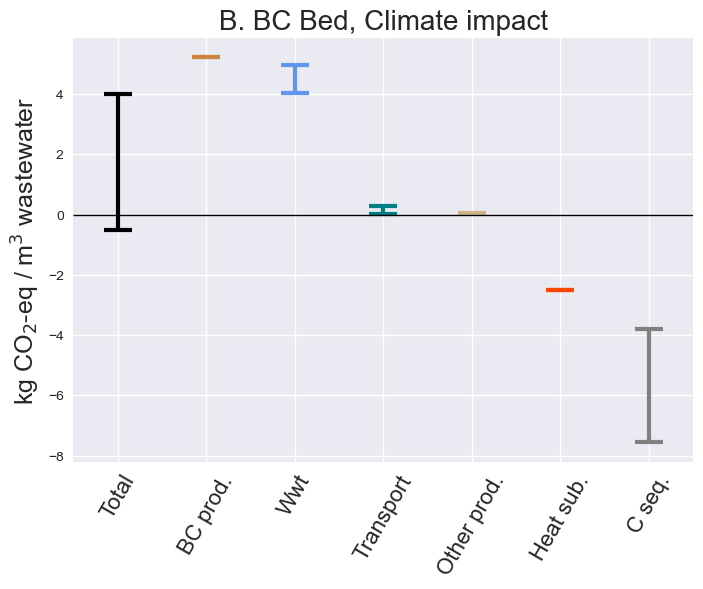

In [281]:
xlabelsBedSensitive = ('Total', 'BC prod.', 'Wwt','Transport','Other prod.',
                       'Heat sub.', 'C seq.')

fig, ax = plt.subplots()

#ax.bar(1, BCBedSensitiveClimateTotmedian)
ax.errorbar(y=BCBedSensitiveClimateTotmedian, x=1, yerr = BCBedSensitiveClimateToterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedSensitiveClimateBCProdmedian)
ax.errorbar(y=BCBedSensitiveClimateBCProdmedian, x=2, yerr = BCBedSensitiveClimateBCProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(3, BCBedSensitiveClimateWwtmedian)
ax.errorbar(y=BCBedSensitiveClimateWwtmedian, x=3, yerr = BCBedSensitiveClimateWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(4, BCBedSensitiveClimateTransportmedian)
ax.errorbar(y=BCBedSensitiveClimateTransportmedian, x=4, yerr = BCBedSensitiveClimateTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(5, BCBedSensitiveClimateProdmedian)
ax.errorbar(y=BCBedSensitiveClimateProdmedian, x=5, yerr = BCBedSensitiveClimateProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(6, BCBedSensitiveClimateHeatSubmedian)
ax.errorbar(y=BCBedSensitiveClimateHeatSubmedian, x=6, yerr = BCBedSensitiveClimateHeatSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(7, BCBedSensitiveClimateCseqmedian)
ax.errorbar(y=BCBedSensitiveClimateCseqmedian, x=7, yerr = BCBedSensitiveClimateCseqerror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='grey')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=7.5, linewidth=1, color='black')
ax.set_xlim(0.5,7.5)
ax.set_title('B. BC Bed, Climate impact', fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=16,rotation=60)
ax.set_ylabel(climate_label, fontsize=18)

In [282]:
fig.savefig('Scenario-BCBed-Sens-Climate', dpi=600, bbox_inches='tight')

##### with sand

(0.5, 12.5)

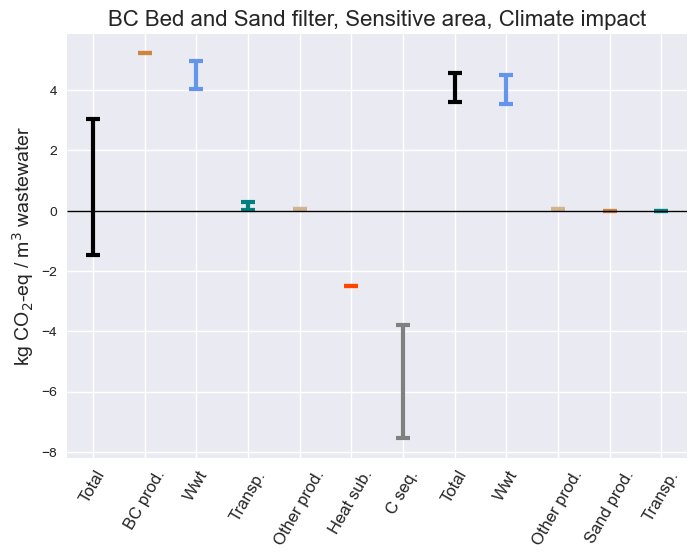

In [378]:
xlabels = ('Total', 'BC prod.', 'Wwt','Transp.','Other prod.',
                       'Heat sub.', 'C seq.', 'Total','Wwt', 'Other prod.', 'Sand prod.', 'Transp.')

fig, ax = plt.subplots()

#ax.bar(1, BCBedSensitiveClimateTotmedian)
ax.errorbar(y=BCBedSensitiveClimateTotmedian, x=1, yerr = BCBedSensitiveClimateToterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedSensitiveClimateBCProdmedian)
ax.errorbar(y=BCBedSensitiveClimateBCProdmedian, x=2, yerr = BCBedSensitiveClimateBCProderror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(3, BCBedSensitiveClimateWwtmedian)
ax.errorbar(y=BCBedSensitiveClimateWwtmedian, x=3, yerr = BCBedSensitiveClimateWwterror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(4, BCBedSensitiveClimateTransportmedian)
ax.errorbar(y=BCBedSensitiveClimateTransportmedian, x=4, yerr = BCBedSensitiveClimateTransporterror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(5, BCBedSensitiveClimateProdmedian)
ax.errorbar(y=BCBedSensitiveClimateProdmedian, x=5, yerr = BCBedSensitiveClimateProderror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(6, BCBedSensitiveClimateHeatSubmedian)
ax.errorbar(y=BCBedSensitiveClimateHeatSubmedian, x=6, yerr = BCBedSensitiveClimateHeatSuberror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(7, BCBedSensitiveClimateCseqmedian)
ax.errorbar(y=BCBedSensitiveClimateCseqmedian, x=7, yerr = BCBedSensitiveClimateCseqerror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='grey')

#ax.bar(8, Sand_Sensitive_medianClimate)
ax.errorbar(y=Sand_Sensitive_medianClimate, x=8, yerr = Sand_Sensitive_errorClimate, capsize=5,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(9, SandSensitiveClimateWwtmedian)
ax.errorbar(y=SandSensitiveClimateWwtmedian, x=9, yerr = SandSensitiveClimateWwterror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(10, SandSensitiveClimateProdmedian)
ax.errorbar(y=SandSensitiveClimateProdmedian, x=10, yerr = SandSensitiveClimateProderror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(11, SandSensitiveClimateSandProdmedian)
ax.errorbar(y=SandSensitiveClimateSandProdmedian, x=11, yerr = SandSensitiveClimateSandProderror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(12, SandSensitiveClimateTransportmedian)
ax.errorbar(y=SandSensitiveClimateTransportmedian, x=12, yerr = SandSensitiveClimateTransporterror, capsize=5,
    elinewidth=3, markeredgewidth=3, color='teal')

ax.hlines(y=0, xmin=0.5, xmax=12.5, linewidth=1, color='black')
ax.set_title('BC Bed and Sand filter, Sensitive area, Climate impact',fontsize=16)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12))
ax.set_xticklabels(xlabels, fontsize=12, rotation=60)
ax.set_ylabel(climate_label,fontsize=14)
ax.set_xlim(0.5,12.5)


In [379]:
fig.savefig('Scenario-BCBed-Sens-Climate-wSand', dpi=600, bbox_inches='tight')

##### eutrophication

In [233]:
BCBedSensitiveEutrophicationTotmin = BCBedSensitive_scenario['Eutrophication_sum'].min()
BCBedSensitiveEutrophicationTotmax = BCBedSensitive_scenario['Eutrophication_sum'].max()
BCBedSensitiveEutrophicationTotmedian = BCBedSensitive_scenario['Eutrophication_sum'].median()
BCBedSensitiveEutrophicationToterror = np.array([BCBedSensitiveEutrophicationTotmedian-BCBedSensitiveEutrophicationTotmin, BCBedSensitiveEutrophicationTotmax-BCBedSensitiveEutrophicationTotmedian]).reshape((2,1))

#BCBedSensitiveEutrophicationTotmin = BCBedSensitive_scenario['BCBedSensitive_Eutrophication'].min()
#BCBedSensitiveEutrophicationTotmax = BCBedSensitive_scenario['BCBedSensitive_Eutrophication'].max()
#BCBedSensitiveEutrophicationTotmedian = BCBedSensitive_scenario['BCBedSensitive_Eutrophication'].median()
#BCBedSensitiveEutrophicationToterror = np.array([BCBedSensitiveEutrophicationTotmedian-BCBedSensitiveEutrophicationTotmin, BCBedSensitiveEutrophicationTotmax-BCBedSensitiveEutrophicationTotmedian]).reshape((2,1))

BCBedSensitiveEutrophicationProdmin = BCBedSensitive_scenario['BCBedSensitiveEutrophicationProd'].min()
BCBedSensitiveEutrophicationProdmax = BCBedSensitive_scenario['BCBedSensitiveEutrophicationProd'].max()
BCBedSensitiveEutrophicationProdmedian = BCBedSensitive_scenario['BCBedSensitiveEutrophicationProd'].median()
BCBedSensitiveEutrophicationProderror = np.array([BCBedSensitiveEutrophicationProdmedian-BCBedSensitiveEutrophicationProdmin, BCBedSensitiveEutrophicationProdmax-BCBedSensitiveEutrophicationProdmedian]).reshape((2,1))

BCBedSensitiveEutrophicationBCProdmin = BCBedSensitive_scenario['BCBedSensitiveEutrophicationBCProd'].min()
BCBedSensitiveEutrophicationBCProdmax = BCBedSensitive_scenario['BCBedSensitiveEutrophicationBCProd'].max()
BCBedSensitiveEutrophicationBCProdmedian = BCBedSensitive_scenario['BCBedSensitiveEutrophicationBCProd'].median()
BCBedSensitiveEutrophicationBCProderror = np.array([BCBedSensitiveEutrophicationBCProdmedian-BCBedSensitiveEutrophicationBCProdmin, BCBedSensitiveEutrophicationBCProdmax-BCBedSensitiveEutrophicationBCProdmedian]).reshape((2,1))

BCBedSensitiveEutrophicationHeatSubmin = BCBedSensitive_scenario['BCBedSensitiveEutrophicationHeatSub'].min()
BCBedSensitiveEutrophicationHeatSubmax = BCBedSensitive_scenario['BCBedSensitiveEutrophicationHeatSub'].max()
BCBedSensitiveEutrophicationHeatSubmedian = BCBedSensitive_scenario['BCBedSensitiveEutrophicationHeatSub'].median()
BCBedSensitiveEutrophicationHeatSuberror = np.array([BCBedSensitiveEutrophicationHeatSubmedian-BCBedSensitiveEutrophicationHeatSubmin, BCBedSensitiveEutrophicationHeatSubmax-BCBedSensitiveEutrophicationHeatSubmedian]).reshape((2,1))

BCBedSensitiveEutrophicationTransportmin = BCBedSensitive_scenario['BCBedSensitiveEutrophicationTransport'].min()
BCBedSensitiveEutrophicationTransportmax = BCBedSensitive_scenario['BCBedSensitiveEutrophicationTransport'].max()
BCBedSensitiveEutrophicationTransportmedian = BCBedSensitive_scenario['BCBedSensitiveEutrophicationTransport'].median()
BCBedSensitiveEutrophicationTransporterror = np.array([BCBedSensitiveEutrophicationTransportmedian-BCBedSensitiveEutrophicationTransportmin, BCBedSensitiveEutrophicationTransportmax-BCBedSensitiveEutrophicationTransportmedian]).reshape((2,1))

BCBedSensitiveEutrophicationWwtmin = BCBedSensitive_scenario['BCBedSensitiveEutrophicationWwt'].min()
BCBedSensitiveEutrophicationWwtmax = BCBedSensitive_scenario['BCBedSensitiveEutrophicationWwt'].max()
BCBedSensitiveEutrophicationWwtmedian = BCBedSensitive_scenario['BCBedSensitiveEutrophicationWwt'].median()
BCBedSensitiveEutrophicationWwterror = np.array([BCBedSensitiveEutrophicationWwtmedian-BCBedSensitiveEutrophicationWwtmin, BCBedSensitiveEutrophicationWwtmax-BCBedSensitiveEutrophicationWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

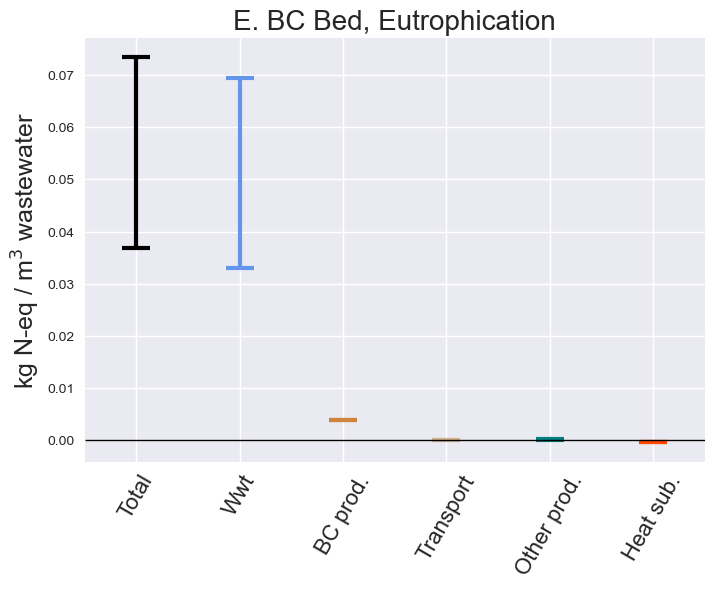

In [283]:
xlabelsBedSensitive = ('Total','Wwt', 'BC prod.', 'Transport','Other prod.', 'Heat sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCBedSensitiveEutrophicationTotmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationTotmedian, x=1, yerr = BCBedSensitiveEutrophicationToterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedSensitiveEutrophicationWwtmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationWwtmedian, x=2, yerr = BCBedSensitiveEutrophicationWwterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCBedSensitiveEutrophicationBCProdmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationBCProdmedian, x=3, yerr = BCBedSensitiveEutrophicationBCProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCBedSensitiveEutrophicationProdmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationProdmedian, x=4, yerr = BCBedSensitiveEutrophicationProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(5, BCBedSensitiveEutrophicationTransportmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationTransportmedian, x=5, yerr = BCBedSensitiveEutrophicationTransporterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCBedSensitiveEutrophicationHeatSubmedian)
ax.errorbar(y=BCBedSensitiveEutrophicationHeatSubmedian, x=6, yerr = BCBedSensitiveEutrophicationHeatSuberror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=6.5, linewidth=1, color='black')
ax.set_xlim(0.5,6.5)
ax.set_title('E. BC Bed, Eutrophication', fontsize=20)
ax.set_xticks((1,2,3,4,5,6))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=16,rotation=60)
ax.set_ylabel(eutroph_label, fontsize=18)

In [284]:
fig.savefig('Scenario-BCBed-Sens-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [236]:
BCBedSensitiveAcidificationTotmin = BCBedSensitive_scenario['Acidification_sum'].min()
BCBedSensitiveAcidificationTotmax = BCBedSensitive_scenario['Acidification_sum'].max()
BCBedSensitiveAcidificationTotmedian = BCBedSensitive_scenario['Acidification_sum'].median()
BCBedSensitiveAcidificationToterror = np.array([BCBedSensitiveAcidificationTotmedian-BCBedSensitiveAcidificationTotmin, BCBedSensitiveAcidificationTotmax-BCBedSensitiveAcidificationTotmedian]).reshape((2,1))

#BCBedSensitiveAcidificationTotmin = BCBedSensitive_scenario['BCBedSensitive_Acidification'].min()
#BCBedSensitiveAcidificationTotmax = BCBedSensitive_scenario['BCBedSensitive_Acidification'].max()
#BCBedSensitiveAcidificationTotmedian = BCBedSensitive_scenario['BCBedSensitive_Acidification'].median()
#BCBedSensitiveAcidificationToterror = np.array([BCBedSensitiveAcidificationTotmedian-BCBedSensitiveAcidificationTotmin, BCBedSensitiveAcidificationTotmax-BCBedSensitiveAcidificationTotmedian]).reshape((2,1))

BCBedSensitiveAcidificationProdmin = BCBedSensitive_scenario['BCBedSensitiveAcidificationProd'].min()
BCBedSensitiveAcidificationProdmax = BCBedSensitive_scenario['BCBedSensitiveAcidificationProd'].max()
BCBedSensitiveAcidificationProdmedian = BCBedSensitive_scenario['BCBedSensitiveAcidificationProd'].median()
BCBedSensitiveAcidificationProderror = np.array([BCBedSensitiveAcidificationProdmedian-BCBedSensitiveAcidificationProdmin, BCBedSensitiveAcidificationProdmax-BCBedSensitiveAcidificationProdmedian]).reshape((2,1))

BCBedSensitiveAcidificationBCProdmin = BCBedSensitive_scenario['BCBedSensitiveAcidificationBCProd'].min()
BCBedSensitiveAcidificationBCProdmax = BCBedSensitive_scenario['BCBedSensitiveAcidificationBCProd'].max()
BCBedSensitiveAcidificationBCProdmedian = BCBedSensitive_scenario['BCBedSensitiveAcidificationBCProd'].median()
BCBedSensitiveAcidificationBCProderror = np.array([BCBedSensitiveAcidificationBCProdmedian-BCBedSensitiveAcidificationBCProdmin, BCBedSensitiveAcidificationBCProdmax-BCBedSensitiveAcidificationBCProdmedian]).reshape((2,1))

BCBedSensitiveAcidificationHeatSubmin = BCBedSensitive_scenario['BCBedSensitiveAcidificationHeatSub'].min()
BCBedSensitiveAcidificationHeatSubmax = BCBedSensitive_scenario['BCBedSensitiveAcidificationHeatSub'].max()
BCBedSensitiveAcidificationHeatSubmedian = BCBedSensitive_scenario['BCBedSensitiveAcidificationHeatSub'].median()
BCBedSensitiveAcidificationHeatSuberror = np.array([BCBedSensitiveAcidificationHeatSubmedian-BCBedSensitiveAcidificationHeatSubmin, BCBedSensitiveAcidificationHeatSubmax-BCBedSensitiveAcidificationHeatSubmedian]).reshape((2,1))

BCBedSensitiveAcidificationTransportmin = BCBedSensitive_scenario['BCBedSensitiveAcidificationTransport'].min()
BCBedSensitiveAcidificationTransportmax = BCBedSensitive_scenario['BCBedSensitiveAcidificationTransport'].max()
BCBedSensitiveAcidificationTransportmedian = BCBedSensitive_scenario['BCBedSensitiveAcidificationTransport'].median()
BCBedSensitiveAcidificationTransporterror = np.array([BCBedSensitiveAcidificationTransportmedian-BCBedSensitiveAcidificationTransportmin, BCBedSensitiveAcidificationTransportmax-BCBedSensitiveAcidificationTransportmedian]).reshape((2,1))

BCBedSensitiveAcidificationWwtmin = BCBedSensitive_scenario['BCBedSensitiveAcidificationWwt'].min()
BCBedSensitiveAcidificationWwtmax = BCBedSensitive_scenario['BCBedSensitiveAcidificationWwt'].max()
BCBedSensitiveAcidificationWwtmedian = BCBedSensitive_scenario['BCBedSensitiveAcidificationWwt'].median()
BCBedSensitiveAcidificationWwterror = np.array([BCBedSensitiveAcidificationWwtmedian-BCBedSensitiveAcidificationWwtmin, BCBedSensitiveAcidificationWwtmax-BCBedSensitiveAcidificationWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

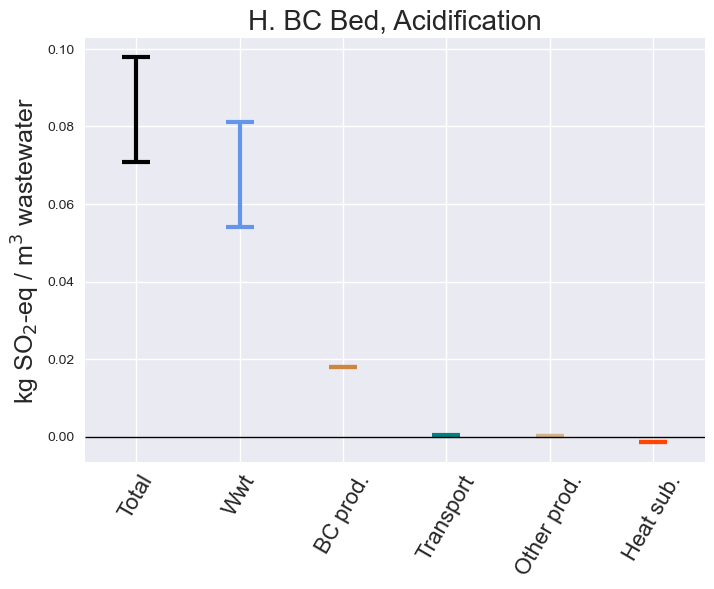

In [285]:
xlabelsBedSensitive = ('Total','Wwt', 'BC prod.', 'Transport','Other prod.', 'Heat sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCBedSensitiveAcidificationTotmedian)
ax.errorbar(y=BCBedSensitiveAcidificationTotmedian, x=1, yerr = BCBedSensitiveAcidificationToterror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCBedSensitiveAcidificationWwtmedian)
ax.errorbar(y=BCBedSensitiveAcidificationWwtmedian, x=2, yerr = BCBedSensitiveAcidificationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCBedSensitiveAcidificationBCProdmedian)
ax.errorbar(y=BCBedSensitiveAcidificationBCProdmedian, x=3, yerr = BCBedSensitiveAcidificationBCProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCBedSensitiveAcidificationTransportmedian)
ax.errorbar(y=BCBedSensitiveAcidificationTransportmedian, x=4, yerr = BCBedSensitiveAcidificationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(5, BCBedSensitiveAcidificationProdmedian)
ax.errorbar(y=BCBedSensitiveAcidificationProdmedian, x=5, yerr = BCBedSensitiveAcidificationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(6, BCBedSensitiveAcidificationHeatSubmedian)
ax.errorbar(y=BCBedSensitiveAcidificationHeatSubmedian, x=6, yerr = BCBedSensitiveAcidificationHeatSuberror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=6.5, linewidth=1, color='black')
ax.set_xlim(0.5,6.5)
ax.set_title('H. BC Bed, Acidification', fontsize=20)
ax.set_xticks((1,2,3,4,5,6))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=16,rotation=60)
ax.set_ylabel(acid_label, fontsize=18)

In [286]:
fig.savefig('Scenario-BCBed-Sens-Acid', dpi=600, bbox_inches='tight')

#### BC Mod

In [239]:
BCMod_scenario_df = pd.DataFrame.from_dict(params)

In [240]:
BCMod_scenario_df['BCModSensitive_ClimateImpact'] = Y4['climate change - global warming potential (GWP100)'].values
BCMod_scenario_df['BCModSensitive_Eutrophication'] = Y4['eutrophication - eutrophication potential'].values
BCMod_scenario_df['BCModSensitive_Acidification'] = Y4['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [241]:
BCMod_scenario_df['BCModClimateBCProd'] = BCModClimateBCProdY['climate change - global warming potential (GWP100)'].values
BCMod_scenario_df['BCModClimateHeatSub'] = BCModClimateHeatSubY['climate change - global warming potential (GWP100)'].values
BCMod_scenario_df['BCModClimateTransport'] = BCModClimateTransportY['climate change - global warming potential (GWP100)'].values
BCMod_scenario_df['BCModClimateBCEOL'] = BCModClimateBCEOL_Y['climate change - global warming potential (GWP100)'].values
BCMod_scenario_df['BCModClimateLSSub'] = BCModClimateLSSubY['climate change - global warming potential (GWP100)'].values
BCMod_scenario_df['BCModClimateCseq'] = BCModClimateCseqY['climate change - global warming potential (GWP100)'].values
BCMod_scenario_df['BCModClimateElecSub'] = BCModClimateElecSubY['climate change - global warming potential (GWP100)'].values
BCMod_scenario_df['BCModClimateWwt'] = BCModClimateWwtY['climate change - global warming potential (GWP100)'].values

In [242]:
BCMod_scenario_df['BCModEutrophicationBCProd'] = BCModEutrophicationBCProdY['eutrophication - eutrophication potential'].values
BCMod_scenario_df['BCModEutrophicationHeatSub'] = BCModEutrophicationHeatSubY['eutrophication - eutrophication potential'].values
BCMod_scenario_df['BCModEutrophicationTransport'] = BCModEutrophicationTransportY['eutrophication - eutrophication potential'].values
BCMod_scenario_df['BCModEutrophicationBCEOL'] = BCModEutrophicationBCEOL_Y['eutrophication - eutrophication potential'].values
BCMod_scenario_df['BCModEutrophicationLSSub'] = BCModEutrophicationLSSubY['eutrophication - eutrophication potential'].values
BCMod_scenario_df['BCModEutrophicationElecSub'] = BCModEutrophicationElecSubY['eutrophication - eutrophication potential'].values
BCMod_scenario_df['BCModEutrophicationWwt'] = BCModEutrophicationWwtY['eutrophication - eutrophication potential'].values

In [243]:
BCMod_scenario_df['BCModAcidificationBCProd'] = BCModAcidificationBCProdY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCMod_scenario_df['BCModAcidificationHeatSub'] = BCModAcidificationHeatSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCMod_scenario_df['BCModAcidificationTransport'] = BCModAcidificationTransportY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCMod_scenario_df['BCModAcidificationBCEOL'] = BCModAcidificationBCEOL_Y['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCMod_scenario_df['BCModAcidificationLSSub'] = BCModAcidificationLSSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCMod_scenario_df['BCModAcidificationElecSub'] = BCModAcidificationElecSubY['acidification - acidification (incl. fate, average Europe total, A&B)'].values
BCMod_scenario_df['BCModAcidificationWwt'] = BCModAcidificationWwtY['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [244]:
BCMod1_bc3 = BCMod_scenario_df[BCMod_scenario_df['bc_switch_param'] == 'bc3']
BCMod2_bc3 = BCMod1_bc3[BCMod1_bc3['bc_HLswitch_param'] == 'bc3HL']
BCMod_bc3 = BCMod2_bc3[BCMod2_bc3['bc_Seqswitch_param'] == 'bc3Seq']

In [245]:
# fossil energy
BCMod_bc3_fossil_heat = BCMod_bc3[BCMod_bc3['heat_switch_param'] == 'heatNaturalGas']
BCMod_bc3_fossil = BCMod_bc3_fossil_heat[BCMod_bc3_fossil_heat['elec_switch_param'] == 'elecCoal']

In [246]:
# EOL LS
BCMod_scenario = BCMod_bc3_fossil[BCMod_bc3_fossil['EOL3and4_switch_param'] == 'LS2']

In [247]:
BCMod_scenario['Climate_sum'] = BCMod_scenario['BCModClimateBCProd'] + BCMod_scenario['BCModClimateHeatSub'] +BCMod_scenario['BCModClimateTransport'] + BCMod_scenario['BCModClimateBCEOL'] + BCMod_scenario['BCModClimateLSSub'] + BCMod_scenario['BCModClimateCseq'] +BCMod_scenario['BCModClimateElecSub'] + BCMod_scenario['BCModClimateWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\1362443036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCMod_scenario['Climate_sum'] = BCMod_scenario['BCModClimateBCProd'] + BCMod_scenario['BCModClimateHeatSub'] +BCMod_scenario['BCModClimateTransport'] + BCMod_scenario['BCModClimateBCEOL'] + BCMod_scenario['BCModClimateLSSub'] + BCMod_scenario['BCModClimateCseq'] +BCMod_scenario['BCModClimateElecSub'] + BCMod_scenario['BCModClimateWwt']


In [248]:
BCMod_scenario['Eutrophication_sum'] = BCMod_scenario['BCModEutrophicationBCProd'] + BCMod_scenario['BCModEutrophicationHeatSub'] +BCMod_scenario['BCModEutrophicationTransport'] + BCMod_scenario['BCModEutrophicationBCEOL'] + BCMod_scenario['BCModEutrophicationLSSub']+BCMod_scenario['BCModEutrophicationElecSub'] + BCMod_scenario['BCModEutrophicationWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\1465206144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCMod_scenario['Eutrophication_sum'] = BCMod_scenario['BCModEutrophicationBCProd'] + BCMod_scenario['BCModEutrophicationHeatSub'] +BCMod_scenario['BCModEutrophicationTransport'] + BCMod_scenario['BCModEutrophicationBCEOL'] + BCMod_scenario['BCModEutrophicationLSSub']+BCMod_scenario['BCModEutrophicationElecSub'] + BCMod_scenario['BCModEutrophicationWwt']


In [249]:
BCMod_scenario['Acidification_sum'] = BCMod_scenario['BCModAcidificationBCProd'] + BCMod_scenario['BCModAcidificationHeatSub'] +BCMod_scenario['BCModAcidificationTransport'] + BCMod_scenario['BCModAcidificationBCEOL'] + BCMod_scenario['BCModAcidificationLSSub']+BCMod_scenario['BCModAcidificationElecSub'] + BCMod_scenario['BCModAcidificationWwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_28796\1226334014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCMod_scenario['Acidification_sum'] = BCMod_scenario['BCModAcidificationBCProd'] + BCMod_scenario['BCModAcidificationHeatSub'] +BCMod_scenario['BCModAcidificationTransport'] + BCMod_scenario['BCModAcidificationBCEOL'] + BCMod_scenario['BCModAcidificationLSSub']+BCMod_scenario['BCModAcidificationElecSub'] + BCMod_scenario['BCModAcidificationWwt']


##### climate

In [250]:
BCModClimateTotmin = BCMod_scenario['Climate_sum'].min()
BCModClimateTotmax = BCMod_scenario['Climate_sum'].max()
BCModClimateTotmedian = BCMod_scenario['Climate_sum'].median()
BCModClimateToterror = np.array([BCModClimateTotmedian-BCModClimateTotmin, BCModClimateTotmax-BCModClimateTotmedian]).reshape((2,1))

#BCModClimateTotmin = BCMod_scenario['BCModSensitive_ClimateImpact'].min()
#BCModClimateTotmax = BCMod_scenario['BCModSensitive_ClimateImpact'].max()
#BCModClimateTotmedian = BCMod_scenario['BCModSensitive_ClimateImpact'].median()
#BCModClimateToterror = np.array([BCModClimateTotmedian-BCModClimateTotmin, BCModClimateTotmax-BCModClimateTotmedian]).reshape((2,1))

BCModClimateBCProdmin = BCMod_scenario['BCModClimateBCProd'].min()
BCModClimateBCProdmax = BCMod_scenario['BCModClimateBCProd'].max()
BCModClimateBCProdmedian = BCMod_scenario['BCModClimateBCProd'].median()
BCModClimateBCProderror = np.array([BCModClimateBCProdmedian-BCModClimateBCProdmin, BCModClimateBCProdmax-BCModClimateBCProdmedian]).reshape((2,1))

BCModClimateHeatSubmin = BCMod_scenario['BCModClimateHeatSub'].min()
BCModClimateHeatSubmax = BCMod_scenario['BCModClimateHeatSub'].max()
BCModClimateHeatSubmedian = BCMod_scenario['BCModClimateHeatSub'].median()
BCModClimateHeatSuberror = np.array([BCModClimateHeatSubmedian-BCModClimateHeatSubmin, BCModClimateHeatSubmax-BCModClimateHeatSubmedian]).reshape((2,1))

BCModClimateTransportmin = BCMod_scenario['BCModClimateTransport'].min()
BCModClimateTransportmax = BCMod_scenario['BCModClimateTransport'].max()
BCModClimateTransportmedian = BCMod_scenario['BCModClimateTransport'].median()
BCModClimateTransporterror = np.array([BCModClimateTransportmedian-BCModClimateTransportmin, BCModClimateTransportmax-BCModClimateTransportmedian]).reshape((2,1))

BCModClimateBCEOLmin = BCMod_scenario['BCModClimateBCEOL'].min()
BCModClimateBCEOLmax = BCMod_scenario['BCModClimateBCEOL'].max()
BCModClimateBCEOLmedian = BCMod_scenario['BCModClimateBCEOL'].median()
BCModClimateBCEOLerror = np.array([BCModClimateBCEOLmedian-BCModClimateBCEOLmin, BCModClimateBCEOLmax-BCModClimateBCEOLmedian]).reshape((2,1))

BCModClimateLSSubmin = BCMod_scenario['BCModClimateLSSub'].min()
BCModClimateLSSubmax = BCMod_scenario['BCModClimateLSSub'].max()
BCModClimateLSSubmedian = BCMod_scenario['BCModClimateLSSub'].median()
BCModClimateLSSuberror = np.array([BCModClimateLSSubmedian-BCModClimateLSSubmin, BCModClimateLSSubmax-BCModClimateLSSubmedian]).reshape((2,1))

BCModClimateCseqmin = BCMod_scenario['BCModClimateCseq'].min()
BCModClimateCseqmax = BCMod_scenario['BCModClimateCseq'].max()
BCModClimateCseqmedian = BCMod_scenario['BCModClimateCseq'].median()
BCModClimateCseqerror = np.array([BCModClimateCseqmedian-BCModClimateCseqmin, BCModClimateCseqmax-BCModClimateCseqmedian]).reshape((2,1))

BCModClimateElecSubmin = BCMod_scenario['BCModClimateElecSub'].min()
BCModClimateElecSubmax = BCMod_scenario['BCModClimateElecSub'].max()
BCModClimateElecSubmedian = BCMod_scenario['BCModClimateElecSub'].median()
BCModClimateElecSuberror = np.array([BCModClimateElecSubmedian-BCModClimateElecSubmin, BCModClimateElecSubmax-BCModClimateElecSubmedian]).reshape((2,1))

BCModClimateWwtmin = BCMod_scenario['BCModClimateWwt'].min()
BCModClimateWwtmax = BCMod_scenario['BCModClimateWwt'].max()
BCModClimateWwtmedian = BCMod_scenario['BCModClimateWwt'].median()
BCModClimateWwterror = np.array([BCModClimateWwtmedian-BCModClimateWwtmin, BCModClimateWwtmax-BCModClimateWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

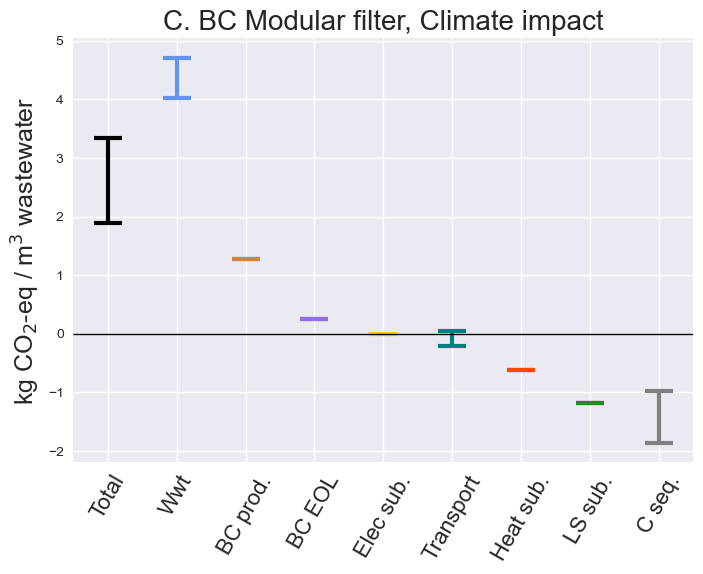

In [287]:
xlabels = ('Total','Wwt','BC prod.','BC EOL','Elec sub.','Transport','Heat sub.','LS sub.',
              'C seq.')

fig, ax = plt.subplots()

#ax.bar(1, BCModClimateTotmedian)
ax.errorbar(y=BCModClimateTotmedian, x=1, yerr = BCModClimateToterror, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModClimateWwtmedian)
ax.errorbar(y=BCModClimateWwtmedian, x=2, yerr = BCModClimateWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCModClimateBCProdmedian)
ax.errorbar(y=BCModClimateBCProdmedian, x=3, yerr = BCModClimateBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCModClimateBCEOLmedian)
ax.errorbar(y=BCModClimateBCEOLmedian, x=4, yerr = BCModClimateBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCModClimateElecSubmedian)
ax.errorbar(y=BCModClimateElecSubmedian, x=5, yerr = BCModClimateElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

#ax.bar(6, BCModClimateTransportmedian)
ax.errorbar(y=BCModClimateTransportmedian, x=6, yerr = BCModClimateTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(7, BCModClimateHeatSubmedian)
ax.errorbar(y=BCModClimateHeatSubmedian, x=7, yerr = BCModClimateHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModClimateLSSubmedian)
ax.errorbar(y=BCModClimateLSSubmedian, x=8, yerr = BCModClimateLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(9, BCModClimateCseqmedian)
ax.errorbar(y=BCModClimateCseqmedian, x=9, yerr = BCModClimateCseqerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='grey')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_xlim(0.5,9.5)
ax.set_title('C. BC Modular filter, Climate impact', fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.set_ylabel(climate_label,fontsize=18)

In [288]:
fig.savefig('Scenario-BCMod-Climate', dpi=600, bbox_inches='tight')

##### with sand

(-2.0, 5.0)

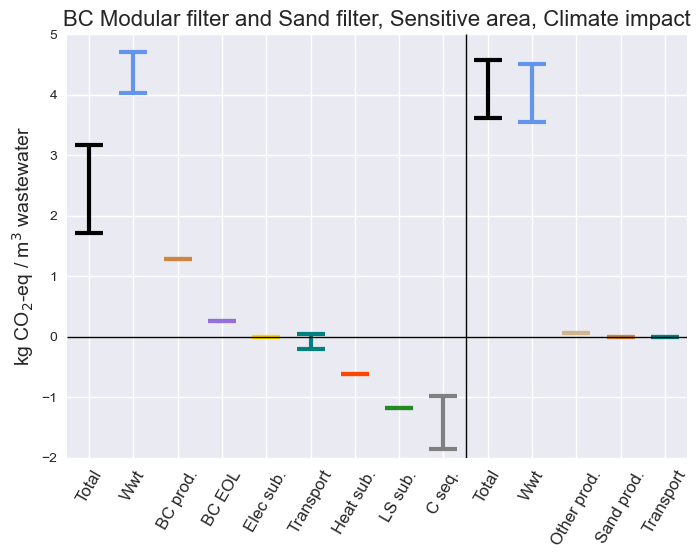

In [401]:
xlabels = ('Total','Wwt','BC prod.','BC EOL','Elec sub.','Transport','Heat sub.','LS sub.',
              'C seq.', 'Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

#ax.bar(1, BCModClimateTotmedian)
ax.errorbar(y=BCModClimateTotmedian, x=1, yerr = BCModClimateToterror, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModClimateWwtmedian)
ax.errorbar(y=BCModClimateWwtmedian, x=2, yerr = BCModClimateWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCModClimateBCProdmedian)
ax.errorbar(y=BCModClimateBCProdmedian, x=3, yerr = BCModClimateBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCModClimateBCEOLmedian)
ax.errorbar(y=BCModClimateBCEOLmedian, x=4, yerr = BCModClimateBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCModClimateElecSubmedian)
ax.errorbar(y=BCModClimateElecSubmedian, x=5, yerr = BCModClimateElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

#ax.bar(6, BCModClimateTransportmedian)
ax.errorbar(y=BCModClimateTransportmedian, x=6, yerr = BCModClimateTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(7, BCModClimateHeatSubmedian)
ax.errorbar(y=BCModClimateHeatSubmedian, x=7, yerr = BCModClimateHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModClimateLSSubmedian)
ax.errorbar(y=BCModClimateLSSubmedian, x=8, yerr = BCModClimateLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(9, BCModClimateCseqmedian)
ax.errorbar(y=BCModClimateCseqmedian, x=9, yerr = BCModClimateCseqerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='grey')

#ax.bar(10, Sand_Sensitive_medianClimate)
ax.errorbar(y=Sand_Sensitive_medianClimate, x=10, yerr = Sand_Sensitive_errorClimate, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(11, SandSensitiveClimateWwtmedian)
ax.errorbar(y=SandSensitiveClimateWwtmedian, x=11, yerr = SandSensitiveClimateWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(12, SandSensitiveClimateProdmedian)
ax.errorbar(y=SandSensitiveClimateProdmedian, x=12, yerr = SandSensitiveClimateProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(13, SandSensitiveClimateSandProdmedian)
ax.errorbar(y=SandSensitiveClimateSandProdmedian, x=13, yerr = SandSensitiveClimateSandProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(14, SandSensitiveClimateTransportmedian)
ax.errorbar(y=SandSensitiveClimateTransportmedian, x=14, yerr = SandSensitiveClimateTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

ax.hlines(y=0, xmin=0.5, xmax=14.5, linewidth=1, color='black')
ax.vlines(x=9.5, ymin=-2, ymax=5, linewidth=1, color='black')
ax.set_title('BC Modular filter and Sand filter, Sensitive area, Climate impact', fontsize=16)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13,14))
ax.set_xticklabels(xlabels, fontsize=12,rotation=60)
ax.set_ylabel(climate_label,fontsize=14)
ax.set_xlim(0.5,14.5)
ax.set_ylim(-2,5)

In [402]:
fig.savefig('Scenario-BCMod-Climate-sand', dpi=600, bbox_inches='tight')

##### eutroph

In [253]:
BCModEutrophicationTotmin = BCMod_scenario['Eutrophication_sum'].min()
BCModEutrophicationTotmax = BCMod_scenario['Eutrophication_sum'].max()
BCModEutrophicationTotmedian = BCMod_scenario['Eutrophication_sum'].median()
BCModEutrophicationToterror = np.array([BCModEutrophicationTotmedian-BCModEutrophicationTotmin, BCModEutrophicationTotmax-BCModEutrophicationTotmedian]).reshape((2,1))

#BCModEutrophicationTotmin = BCMod_scenario['BCModSensitive_Eutrophication'].min()
#BCModEutrophicationTotmax = BCMod_scenario['BCModSensitive_Eutrophication'].max()
#BCModEutrophicationTotmedian = BCMod_scenario['BCModSensitive_Eutrophication'].median()
#BCModEutrophicationToterror = np.array([BCModEutrophicationTotmedian-BCModEutrophicationTotmin, BCModEutrophicationTotmax-BCModEutrophicationTotmedian]).reshape((2,1))

BCModEutrophicationBCProdmin = BCMod_scenario['BCModEutrophicationBCProd'].min()
BCModEutrophicationBCProdmax = BCMod_scenario['BCModEutrophicationBCProd'].max()
BCModEutrophicationBCProdmedian = BCMod_scenario['BCModEutrophicationBCProd'].median()
BCModEutrophicationBCProderror = np.array([BCModEutrophicationBCProdmedian-BCModEutrophicationBCProdmin, BCModEutrophicationBCProdmax-BCModEutrophicationBCProdmedian]).reshape((2,1))

BCModEutrophicationHeatSubmin = BCMod_scenario['BCModEutrophicationHeatSub'].min()
BCModEutrophicationHeatSubmax = BCMod_scenario['BCModEutrophicationHeatSub'].max()
BCModEutrophicationHeatSubmedian = BCMod_scenario['BCModEutrophicationHeatSub'].median()
BCModEutrophicationHeatSuberror = np.array([BCModEutrophicationHeatSubmedian-BCModEutrophicationHeatSubmin, BCModEutrophicationHeatSubmax-BCModEutrophicationHeatSubmedian]).reshape((2,1))

BCModEutrophicationTransportmin = BCMod_scenario['BCModEutrophicationTransport'].min()
BCModEutrophicationTransportmax = BCMod_scenario['BCModEutrophicationTransport'].max()
BCModEutrophicationTransportmedian = BCMod_scenario['BCModEutrophicationTransport'].median()
BCModEutrophicationTransporterror = np.array([BCModEutrophicationTransportmedian-BCModEutrophicationTransportmin, BCModEutrophicationTransportmax-BCModEutrophicationTransportmedian]).reshape((2,1))

BCModEutrophicationBCEOLmin = BCMod_scenario['BCModEutrophicationBCEOL'].min()
BCModEutrophicationBCEOLmax = BCMod_scenario['BCModEutrophicationBCEOL'].max()
BCModEutrophicationBCEOLmedian = BCMod_scenario['BCModEutrophicationBCEOL'].median()
BCModEutrophicationBCEOLerror = np.array([BCModEutrophicationBCEOLmedian-BCModEutrophicationBCEOLmin, BCModEutrophicationBCEOLmax-BCModEutrophicationBCEOLmedian]).reshape((2,1))

BCModEutrophicationLSSubmin = BCMod_scenario['BCModEutrophicationLSSub'].min()
BCModEutrophicationLSSubmax = BCMod_scenario['BCModEutrophicationLSSub'].max()
BCModEutrophicationLSSubmedian = BCMod_scenario['BCModEutrophicationLSSub'].median()
BCModEutrophicationLSSuberror = np.array([BCModEutrophicationLSSubmedian-BCModEutrophicationLSSubmin, BCModEutrophicationLSSubmax-BCModEutrophicationLSSubmedian]).reshape((2,1))

BCModEutrophicationElecSubmin = BCMod_scenario['BCModEutrophicationElecSub'].min()
BCModEutrophicationElecSubmax = BCMod_scenario['BCModEutrophicationElecSub'].max()
BCModEutrophicationElecSubmedian = BCMod_scenario['BCModEutrophicationElecSub'].median()
BCModEutrophicationElecSuberror = np.array([BCModEutrophicationElecSubmedian-BCModEutrophicationElecSubmin, BCModEutrophicationElecSubmax-BCModEutrophicationElecSubmedian]).reshape((2,1))

BCModEutrophicationWwtmin = BCMod_scenario['BCModEutrophicationWwt'].min()
BCModEutrophicationWwtmax = BCMod_scenario['BCModEutrophicationWwt'].max()
BCModEutrophicationWwtmedian = BCMod_scenario['BCModEutrophicationWwt'].median()
BCModEutrophicationWwterror = np.array([BCModEutrophicationWwtmedian-BCModEutrophicationWwtmin, BCModEutrophicationWwtmax-BCModEutrophicationWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

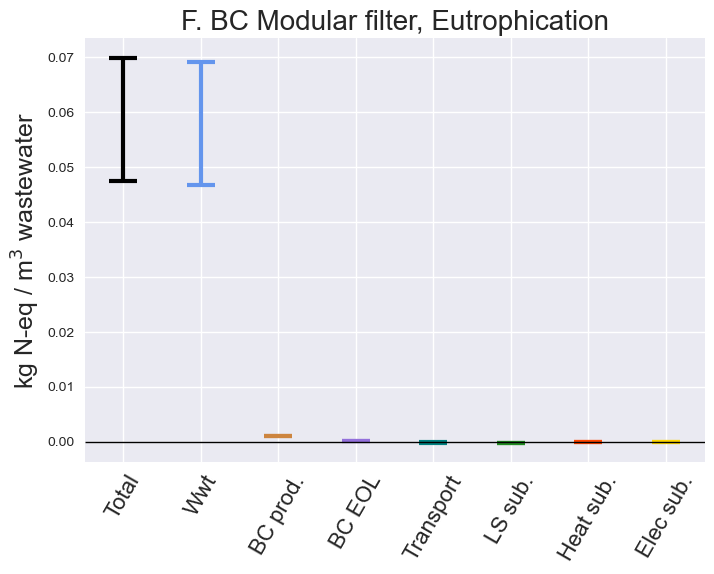

In [289]:
xlabels = ('Total','Wwt','BC prod.','BC EOL','Transport','LS sub.',
             'Heat sub.', 'Elec sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCModEutrophicationTotmedian)
ax.errorbar(y=BCModEutrophicationTotmedian, x=1, yerr = BCModEutrophicationToterror, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModEutrophicationWwtmedian)
ax.errorbar(y=BCModEutrophicationWwtmedian, x=2, yerr = BCModEutrophicationWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCModEutrophicationBCProdmedian)
ax.errorbar(y=BCModEutrophicationBCProdmedian, x=3, yerr = BCModEutrophicationBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCModEutrophicationBCEOLmedian)
ax.errorbar(y=BCModEutrophicationBCEOLmedian, x=4, yerr = BCModEutrophicationBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCModEutrophicationTransportmedian)
ax.errorbar(y=BCModEutrophicationTransportmedian, x=5, yerr = BCModEutrophicationTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCModEutrophicationLSSubmedian)
ax.errorbar(y=BCModEutrophicationLSSubmedian, x=6, yerr = BCModEutrophicationLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(7, BCModEutrophicationHeatSubmedian)
ax.errorbar(y=BCModEutrophicationHeatSubmedian, x=7, yerr = BCModEutrophicationHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModEutrophicationElecSubmedian)
ax.errorbar(y=BCModEutrophicationElecSubmedian, x=8, yerr = BCModEutrophicationElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_xlim(0.5,8.5)
ax.set_title('F. BC Modular filter, Eutrophication', fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.set_ylabel(eutroph_label,fontsize=18)

In [290]:
fig.savefig('Scenario-BCMod-Eutroph', dpi=600, bbox_inches='tight')

##### with sand

(-0.01, 0.087)

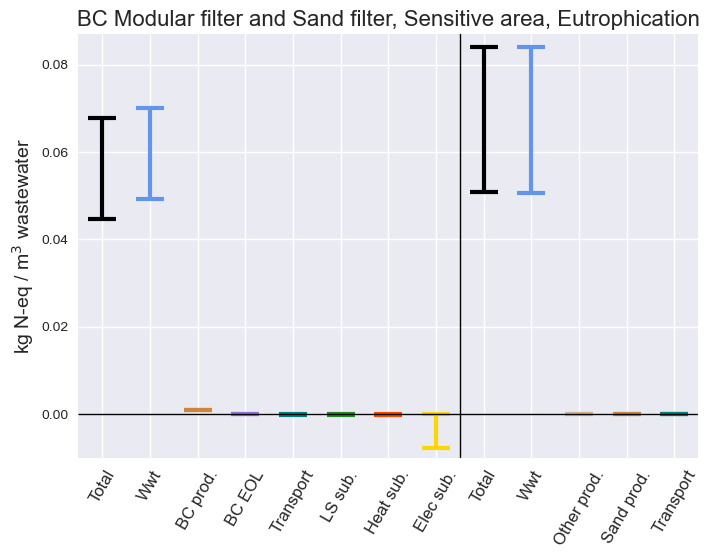

In [408]:
xlabels = ('Total','Wwt','BC prod.','BC EOL','Transport','LS sub.',
             'Heat sub.', 'Elec sub.','Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

#ax.bar(1, BCModEutrophicationTotmedian)
ax.errorbar(y=BCModEutrophicationTotmedian, x=1, yerr = BCModEutrophicationToterror, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModEutrophicationWwtmedian)
ax.errorbar(y=BCModEutrophicationWwtmedian, x=2, yerr = BCModEutrophicationWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCModEutrophicationBCProdmedian)
ax.errorbar(y=BCModEutrophicationBCProdmedian, x=3, yerr = BCModEutrophicationBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCModEutrophicationBCEOLmedian)
ax.errorbar(y=BCModEutrophicationBCEOLmedian, x=4, yerr = BCModEutrophicationBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCModEutrophicationTransportmedian)
ax.errorbar(y=BCModEutrophicationTransportmedian, x=5, yerr = BCModEutrophicationTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCModEutrophicationLSSubmedian)
ax.errorbar(y=BCModEutrophicationLSSubmedian, x=6, yerr = BCModEutrophicationLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(7, BCModEutrophicationHeatSubmedian)
ax.errorbar(y=BCModEutrophicationHeatSubmedian, x=7, yerr = BCModEutrophicationHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModEutrophicationElecSubmedian)
ax.errorbar(y=BCModEutrophicationElecSubmedian, x=8, yerr = BCModEutrophicationElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

#ax.bar(9, Sand_Sensitive_medianEutroph)
ax.errorbar(y=Sand_Sensitive_medianEutroph, x=9, yerr = Sand_Sensitive_errorEutroph, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(10, SandSensitiveEutrophicationWwtmedian)
ax.errorbar(y=SandSensitiveEutrophicationWwtmedian, x=10, yerr = SandSensitiveEutrophicationWwterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(11, SandSensitiveEutrophicationProdmedian)
ax.errorbar(y=SandSensitiveEutrophicationProdmedian, x=11, yerr = SandSensitiveEutrophicationProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(12, SandSensitiveEutrophicationSandProdmedian)
ax.errorbar(y=SandSensitiveEutrophicationSandProdmedian, x=12, yerr = SandSensitiveEutrophicationSandProderror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(13, SandSensitiveEutrophicationTransportmedian)
ax.errorbar(y=SandSensitiveEutrophicationTransportmedian, x=13, yerr = SandSensitiveEutrophicationTransporterror, capsize=10,
	elinewidth=3, markeredgewidth=3, color='teal')

ax.hlines(y=0, xmin=0.5, xmax=14.5, linewidth=1, color='black')
ax.vlines(x=8.5, ymin=-0.02, ymax=0.09, linewidth=1, color='black')
ax.set_title('BC Modular filter and Sand filter, Sensitive area, Eutrophication', fontsize=16)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13))
ax.set_xticklabels(xlabels, fontsize=12,rotation=60)
ax.set_ylabel(eutroph_label,fontsize=14)
ax.set_xlim(0.5,13.5)
ax.set_ylim(-0.01,0.087)

In [409]:
fig.savefig('Scenario-BCMod-Eutroph-sand', dpi=600, bbox_inches='tight')

##### acid

In [256]:
BCModAcidificationTotmin = BCMod_scenario['Acidification_sum'].min()
BCModAcidificationTotmax = BCMod_scenario['Acidification_sum'].max()
BCModAcidificationTotmedian = BCMod_scenario['Acidification_sum'].median()
BCModAcidificationToterror = np.array([BCModAcidificationTotmedian-BCModAcidificationTotmin, BCModAcidificationTotmax-BCModAcidificationTotmedian]).reshape((2,1))

#BCModAcidificationTotmin = BCMod_scenario['BCModSensitive_Acidification'].min()
#BCModAcidificationTotmax = BCMod_scenario['BCModSensitive_Acidification'].max()
#BCModAcidificationTotmedian = BCMod_scenario['BCModSensitive_Acidification'].median()
#BCModAcidificationToterror = np.array([BCModAcidificationTotmedian-BCModAcidificationTotmin, BCModAcidificationTotmax-BCModAcidificationTotmedian]).reshape((2,1))

BCModAcidificationBCProdmin = BCMod_scenario['BCModAcidificationBCProd'].min()
BCModAcidificationBCProdmax = BCMod_scenario['BCModAcidificationBCProd'].max()
BCModAcidificationBCProdmedian = BCMod_scenario['BCModAcidificationBCProd'].median()
BCModAcidificationBCProderror = np.array([BCModAcidificationBCProdmedian-BCModAcidificationBCProdmin, BCModAcidificationBCProdmax-BCModAcidificationBCProdmedian]).reshape((2,1))

BCModAcidificationHeatSubmin = BCMod_scenario['BCModAcidificationHeatSub'].min()
BCModAcidificationHeatSubmax = BCMod_scenario['BCModAcidificationHeatSub'].max()
BCModAcidificationHeatSubmedian = BCMod_scenario['BCModAcidificationHeatSub'].median()
BCModAcidificationHeatSuberror = np.array([BCModAcidificationHeatSubmedian-BCModAcidificationHeatSubmin, BCModAcidificationHeatSubmax-BCModAcidificationHeatSubmedian]).reshape((2,1))

BCModAcidificationTransportmin = BCMod_scenario['BCModAcidificationTransport'].min()
BCModAcidificationTransportmax = BCMod_scenario['BCModAcidificationTransport'].max()
BCModAcidificationTransportmedian = BCMod_scenario['BCModAcidificationTransport'].median()
BCModAcidificationTransporterror = np.array([BCModAcidificationTransportmedian-BCModAcidificationTransportmin, BCModAcidificationTransportmax-BCModAcidificationTransportmedian]).reshape((2,1))

BCModAcidificationBCEOLmin = BCMod_scenario['BCModAcidificationBCEOL'].min()
BCModAcidificationBCEOLmax = BCMod_scenario['BCModAcidificationBCEOL'].max()
BCModAcidificationBCEOLmedian = BCMod_scenario['BCModAcidificationBCEOL'].median()
BCModAcidificationBCEOLerror = np.array([BCModAcidificationBCEOLmedian-BCModAcidificationBCEOLmin, BCModAcidificationBCEOLmax-BCModAcidificationBCEOLmedian]).reshape((2,1))

BCModAcidificationLSSubmin = BCMod_scenario['BCModAcidificationLSSub'].min()
BCModAcidificationLSSubmax = BCMod_scenario['BCModAcidificationLSSub'].max()
BCModAcidificationLSSubmedian = BCMod_scenario['BCModAcidificationLSSub'].median()
BCModAcidificationLSSuberror = np.array([BCModAcidificationLSSubmedian-BCModAcidificationLSSubmin, BCModAcidificationLSSubmax-BCModAcidificationLSSubmedian]).reshape((2,1))

BCModAcidificationElecSubmin = BCMod_scenario['BCModAcidificationElecSub'].min()
BCModAcidificationElecSubmax = BCMod_scenario['BCModAcidificationElecSub'].max()
BCModAcidificationElecSubmedian = BCMod_scenario['BCModAcidificationElecSub'].median()
BCModAcidificationElecSuberror = np.array([BCModAcidificationElecSubmedian-BCModAcidificationElecSubmin, BCModAcidificationElecSubmax-BCModAcidificationElecSubmedian]).reshape((2,1))

BCModAcidificationWwtmin = BCMod_scenario['BCModAcidificationWwt'].min()
BCModAcidificationWwtmax = BCMod_scenario['BCModAcidificationWwt'].max()
BCModAcidificationWwtmedian = BCMod_scenario['BCModAcidificationWwt'].median()
BCModAcidificationWwterror = np.array([BCModAcidificationWwtmedian-BCModAcidificationWwtmin, BCModAcidificationWwtmax-BCModAcidificationWwtmedian]).reshape((2,1))


Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

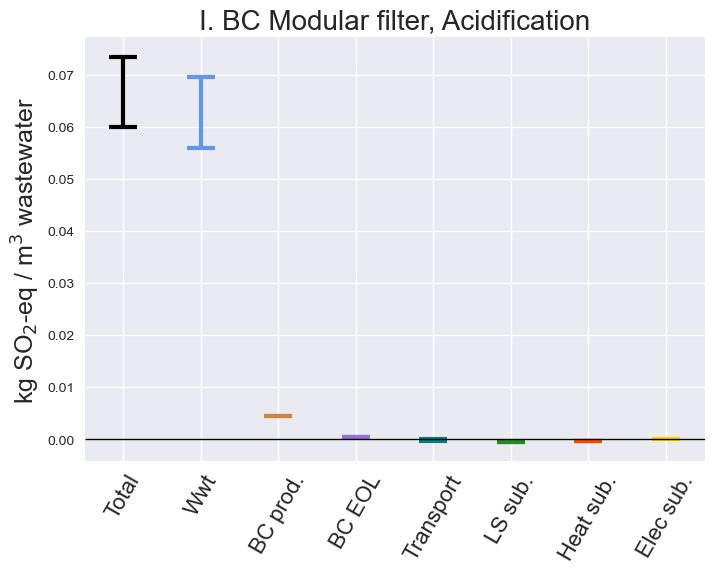

In [291]:
xlabels = ('Total','Wwt', 'BC prod.','BC EOL',
           'Transport','LS sub.',
             'Heat sub.', 'Elec sub.')

fig, ax = plt.subplots()

#ax.bar(1, BCModAcidificationTotmedian)
ax.errorbar(y=BCModAcidificationTotmedian, x=1, yerr = BCModAcidificationToterror, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModAcidificationWwtmedian)
ax.errorbar(y=BCModAcidificationWwtmedian, x=2, yerr = BCModAcidificationWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCModAcidificationBCProdmedian)
ax.errorbar(y=BCModAcidificationBCProdmedian, x=3, yerr = BCModAcidificationBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCModAcidificationBCEOLmedian)
ax.errorbar(y=BCModAcidificationBCEOLmedian, x=4, yerr = BCModAcidificationBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCModAcidificationTransportmedian)
ax.errorbar(y=BCModAcidificationTransportmedian, x=5, yerr = BCModAcidificationTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCModAcidificationLSSubmedian)
ax.errorbar(y=BCModAcidificationLSSubmedian, x=6, yerr = BCModAcidificationLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(7, BCModAcidificationHeatSubmedian)
ax.errorbar(y=BCModAcidificationHeatSubmedian, x=7, yerr = BCModAcidificationHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModAcidificationElecSubmedian)
ax.errorbar(y=BCModAcidificationElecSubmedian, x=8, yerr = BCModAcidificationElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('snow')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_xlim(0.5,8.5)
ax.set_title('I. BC Modular filter, Acidification',fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.set_ylabel(acid_label,fontsize=18)

In [292]:
fig.savefig('Scenario-BCMod-Acid', dpi=600, bbox_inches='tight')

##### with sand

(-0.01, 0.07)

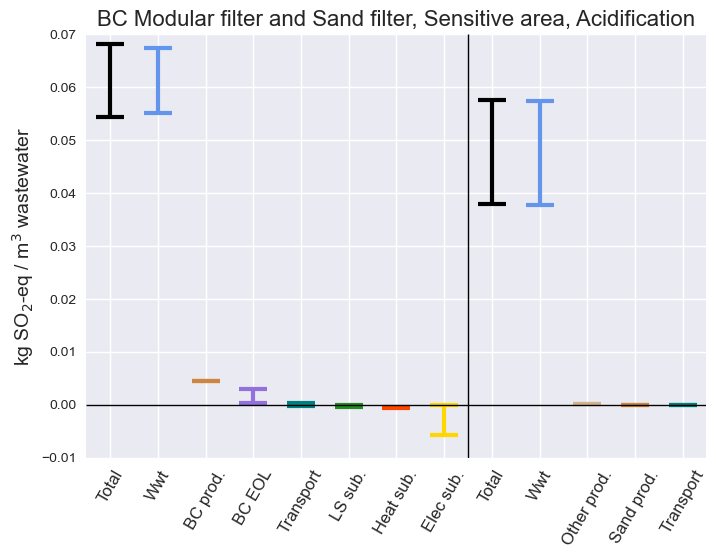

In [412]:
xlabels = ('Total','Wwt', 'BC prod.','BC EOL',
           'Transport','LS sub.',
             'Heat sub.', 'Elec sub.','Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

#ax.bar(1, BCModAcidificationTotmedian)
ax.errorbar(y=BCModAcidificationTotmedian, x=1, yerr = BCModAcidificationToterror, capsize=10, 
            elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(2, BCModAcidificationWwtmedian)
ax.errorbar(y=BCModAcidificationWwtmedian, x=2, yerr = BCModAcidificationWwterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(3, BCModAcidificationBCProdmedian)
ax.errorbar(y=BCModAcidificationBCProdmedian, x=3, yerr = BCModAcidificationBCProderror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(4, BCModAcidificationBCEOLmedian)
ax.errorbar(y=BCModAcidificationBCEOLmedian, x=4, yerr = BCModAcidificationBCEOLerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='mediumpurple')

#ax.bar(5, BCModAcidificationTransportmedian)
ax.errorbar(y=BCModAcidificationTransportmedian, x=5, yerr = BCModAcidificationTransporterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='teal')

#ax.bar(6, BCModAcidificationLSSubmedian)
ax.errorbar(y=BCModAcidificationLSSubmedian, x=6, yerr = BCModAcidificationLSSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(7, BCModAcidificationHeatSubmedian)
ax.errorbar(y=BCModAcidificationHeatSubmedian, x=7, yerr = BCModAcidificationHeatSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='orangered')

#ax.bar(8, BCModAcidificationElecSubmedian)
ax.errorbar(y=BCModAcidificationElecSubmedian, x=8, yerr = BCModAcidificationElecSuberror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='gold')

#ax.bar(9, Sand_Sensitive_medianAcid)
ax.errorbar(y=Sand_Sensitive_medianAcid, x=9, yerr = Sand_Sensitive_errorAcid, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

#ax.bar(10, SandSensitiveAcidificationWwtmedian)
ax.errorbar(y=SandSensitiveAcidificationWwtmedian, x=10, yerr = SandSensitiveAcidificationWwterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

#ax.bar(11, SandSensitiveAcidificationProdmedian)
ax.errorbar(y=SandSensitiveAcidificationProdmedian, x=11, yerr = SandSensitiveAcidificationProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

#ax.bar(12, SandSensitiveAcidificationSandProdmedian)
ax.errorbar(y=SandSensitiveAcidificationSandProdmedian, x=12, yerr = SandSensitiveAcidificationSandProderror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(13, SandSensitiveAcidificationTransportmedian)
ax.errorbar(y=SandSensitiveAcidificationTransportmedian, x=13, yerr = SandSensitiveAcidificationTransporterror, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

ax.hlines(y=0, xmin=0.5, xmax=13.5, linewidth=1, color='black')
ax.vlines(x=8.5, ymin=-0.01, ymax=0.07, linewidth=1, color='black')
ax.set_title('BC Modular filter and Sand filter, Sensitive area, Acidification',fontsize=16)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13))
ax.set_xticklabels(xlabels, fontsize=12,rotation=60)
ax.set_ylabel(acid_label,fontsize=14)
ax.set_xlim(0.5,13.5)
ax.set_ylim(-0.01,0.07)

In [413]:
fig.savefig('Scenario-BCMod-Acid-sand', dpi=600, bbox_inches='tight')

### create function (unfinished ideas)

In [ ]:
# define a helping funtion
def getMedianAndError(df, colname):
    '''
    From a df, return median and error, that can be directly used in bar charts to visualize median and error bar
    colname = string w name of col of interest
    '''
    median = df[colname].median()
    error = np.array([median-df[colname].min(),
                     df[colname].max()-median]).reshape((2,1))
    
    return median, error

In [ ]:
def plot_CA(cols, x_labels, title, y_label, colors='black'):
    '''
    UNFINISHED
    Input: Df columns with CA-groups (as an array?), X-labels, Title, Y-axis label, colors 
    Output: figure showing ca with errorbars of min and max of every group
    '''
    
    # step 1 - create errorbars for each col - use helping function i created earlier... it's here somewhere...
    medians = []
    errors = []
    for col in cols:
        median, error = getMedianAndError(col, colname) # how to get colname? should be a way...
        medians.append(median)
        errors.append(error)
    
    # step 2 - sort the cols - if pos max, according to max, if neg min and max zero, accoding to min
    
    # step 3 - set up fig
    
    fig, ax = plt.subplots()
    
    for i in range(cols):
        ax.errorbar(y=medians[i], x=i, yerr = errors[i], capsize=20,
                 elinewidth=3, markeredgewidth=3, color=colors[i])
        
    ax.hlines(y=0, xmin=0, xmax=range(cols)+0.5, linewidth=1, color='black')
    ax.set_title(title)
    ax.set_xticks(range(cols))
    ax.set_xticklabels(x_labels)
    ax.set_ylabel(y_label)
    
    return fig

May use this piece of code do separate between the impacts

In [120]:
# list of impacts - in case several ones - 0 is climate impact (here)
bcProd = result[list(fu1.keys())[0]]['agg_graph']['BC Bed Normal Prod'][0]

## scenarios

### basic bar charts

#### simple barcharts - normal areas

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

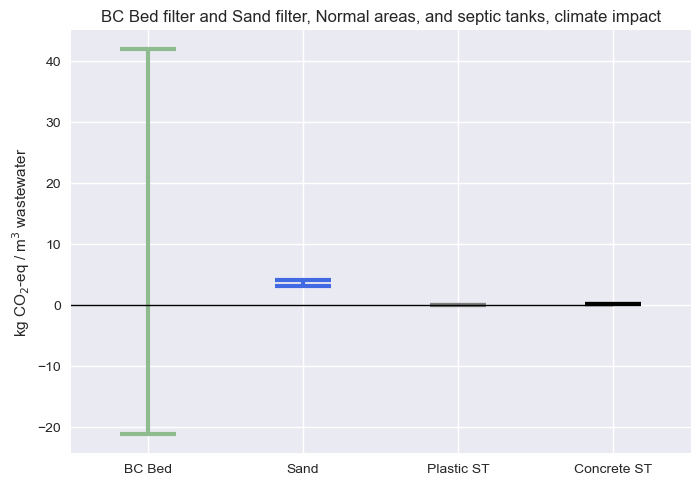

In [39]:
fig, ax = plt.subplots()
# ax.bar(1, BCBed_Normal_medianClimate, color='darkseagreen')
ax.errorbar(y=BCBed_Normal_medianClimate, x=1, yerr = BCBed_Normal_errorClimate, capsize=20, 
            elinewidth=3, markeredgewidth=3, color='darkseagreen')
# ax.bar(2, Sand_Normal_medianClimate, color='royalblue')
ax.errorbar(y=Sand_Normal_medianClimate, x=2, yerr = Sand_Normal_errorClimate, capsize=20,
        elinewidth=3, markeredgewidth=3, color='royalblue')

ax.errorbar(y=plasticST_medianClimate, x=3, yerr = plasticST_errorClimate, capsize=20,
        elinewidth=3, markeredgewidth=3, color='grey')

ax.errorbar(y=concreteST_medianClimate, x=4, yerr = concreteST_errorClimate, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.set_xlim(0.5,4.5)
ax.set_title('BC Bed filter and Sand filter, Normal areas, and septic tanks, climate impact')
ax.set_xticks((1,2,3,4))
ax.set_xticklabels(('BC Bed', 'Sand', 'Plastic ST', 'Concrete ST'))
ax.hlines(y=0, xmin=0, xmax=4, linewidth=1, color='black')
ax.set_ylabel(climate_label)

In [40]:
fig.savefig('BasicBar_Bed_Climate', dpi=600)

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

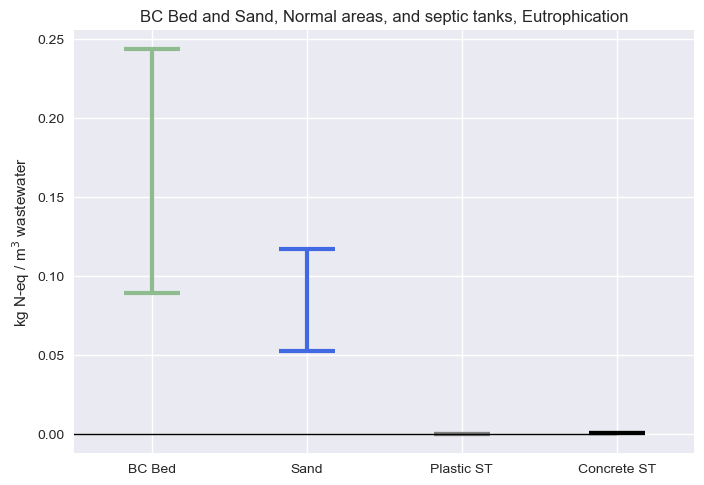

In [41]:
fig, ax = plt.subplots()
#ax.bar(1, BCBed_Normal_medianEutroph, color='darkseagreen')
ax.errorbar(y=BCBed_Normal_medianEutroph, x=1, yerr = BCBed_Normal_errorEutroph, capsize=20,
        	elinewidth=3, markeredgewidth=3, color='darkseagreen')
#ax.bar(2, Sand_Normal_medianEutroph, color='royalblue')
ax.errorbar(y=Sand_Normal_medianEutroph, x=2, yerr = Sand_Normal_errorEutroph, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='royalblue')

ax.errorbar(y=plasticST_medianEutroph, x=3, yerr = plasticST_errorEutroph, capsize=20,
        elinewidth=3, markeredgewidth=3, color='grey')

ax.errorbar(y=concreteST_medianEutroph, x=4, yerr = concreteST_errorEutroph, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.set_xlim(0.5,4.5)
ax.set_title('BC Bed and Sand, Normal areas, and septic tanks, Eutrophication')
ax.set_xticks((1,2,3,4))
ax.set_xticklabels(('BC Bed', 'Sand', 'Plastic ST', 'Concrete ST'))
ax.hlines(y=0, xmin=0, xmax=4, linewidth=1, color='black')
ax.set_ylabel(eutroph_label)

In [42]:
fig.savefig('BasicBar_Bed_Eutroph', dpi=600)

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

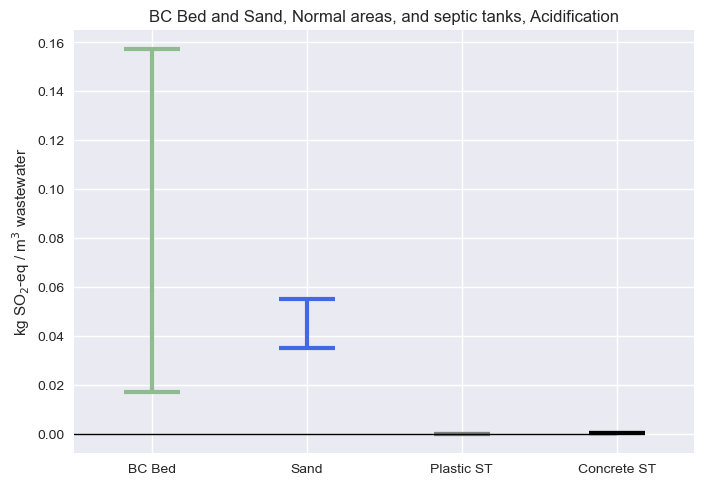

In [43]:
fig, ax = plt.subplots()
#ax.bar(1, BCBed_Normal_medianAcid, color='darkseagreen')
ax.errorbar(y=BCBed_Normal_medianAcid, x=1, yerr = BCBed_Normal_errorAcid, capsize=20,
   elinewidth=3, markeredgewidth=3, color='darkseagreen')
#ax.bar(2, Sand_Normal_medianAcid, color='royalblue')
ax.errorbar(y=Sand_Normal_medianAcid, x=2, yerr = Sand_Normal_errorAcid, capsize=20,
   elinewidth=3, markeredgewidth=3, color='royalblue')

ax.errorbar(y=plasticST_medianAcid, x=3, yerr = plasticST_errorAcid, capsize=20,
        elinewidth=3, markeredgewidth=3, color='grey')

ax.errorbar(y=concreteST_medianAcid, x=4, yerr = concreteST_errorAcid, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.set_xlim(0.5,4.5)
ax.set_title('BC Bed and Sand, Normal areas, and septic tanks, Acidification')
ax.set_xticks((1,2,3,4))
ax.set_xticklabels(('BC Bed', 'Sand', 'Plastic ST', 'Concrete ST'))
ax.hlines(y=0, xmin=0, xmax=4, linewidth=1, color='black')
ax.set_ylabel(acid_label)

In [44]:
fig.savefig('BasicBar_Bed_Acid', dpi=600)

#### simple barcharts - sensitive areas

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

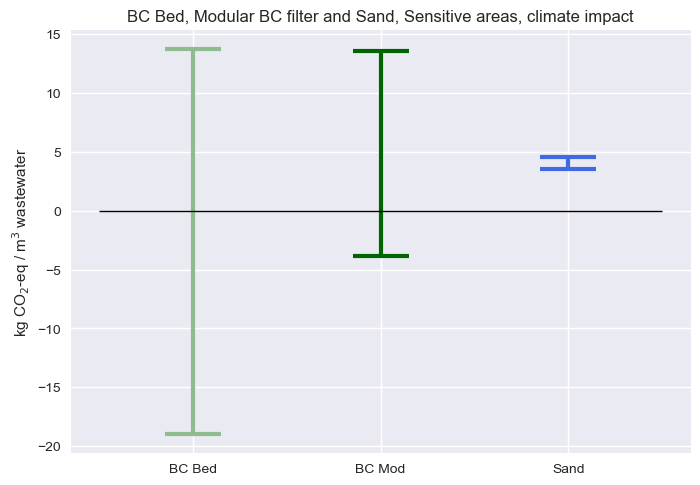

In [46]:
fig, ax = plt.subplots()
#ax.bar(1, BCBed_Sensitive_medianClimate, color='darkseagreen')
ax.errorbar(y=BCBed_Sensitive_medianClimate, x=1, yerr = BCBed_Sensitive_errorClimate, capsize=20,
        elinewidth=3, markeredgewidth=3, color='darkseagreen')
#ax.bar(2, BCMod_Sensitive_medianClimate, color='darkgreen')
ax.errorbar(y=BCMod_Sensitive_medianClimate, x=2, yerr = BCMod_Sensitive_errorClimate, capsize=20,
        elinewidth=3, markeredgewidth=3, color='darkgreen')
#ax.bar(3, Sand_Sensitive_medianClimate, color='royalblue')
ax.errorbar(y=Sand_Sensitive_medianClimate, x=3, yerr = Sand_Sensitive_errorClimate, capsize=20,
        elinewidth=3, markeredgewidth=3, color='royalblue')
ax.set_title('BC Bed, Modular BC filter and Sand, Sensitive areas, climate impact')
ax.set_xticks((1,2,3))
ax.set_xticklabels(('BC Bed', 'BC Mod', 'Sand'))
ax.hlines(y=0, xmin=0.5, xmax=3.5, linewidth=1, color='black')
ax.set_ylabel(climate_label)

In [47]:
fig.savefig('BasicBar_Sens_Climate', dpi=600)

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

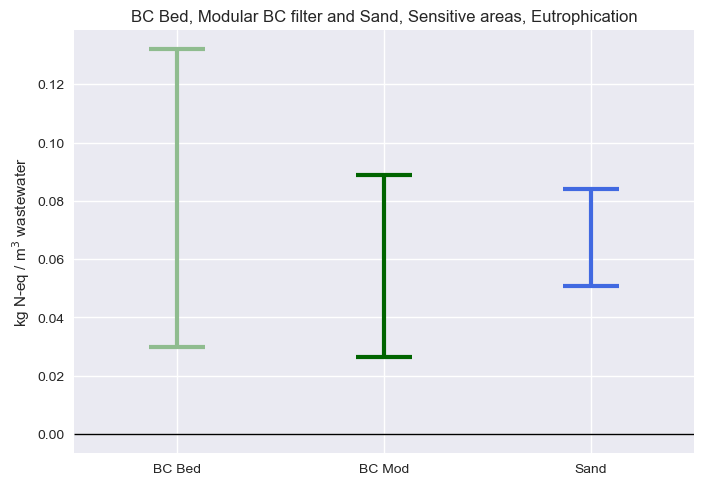

In [52]:
fig, ax = plt.subplots()
#ax.bar(1, BCBed_Sensitive_medianEutroph, color='darkseagreen')
ax.errorbar(y=BCBed_Sensitive_medianEutroph, x=1, yerr = BCBed_Sensitive_errorEutroph, capsize=20,
    elinewidth=3, markeredgewidth=3, color='darkseagreen')
#ax.bar(2, BCMod_Sensitive_medianEutroph, color='darkgreen')
ax.errorbar(y=BCMod_Sensitive_medianEutroph, x=2, yerr = BCMod_Sensitive_errorEutroph, capsize=20,
    elinewidth=3, markeredgewidth=3, color='darkgreen')
#ax.bar(3, Sand_Sensitive_medianEutroph, color='royalblue')
ax.errorbar(y=Sand_Sensitive_medianEutroph, x=3, yerr = Sand_Sensitive_errorEutroph, capsize=20,
    elinewidth=3, markeredgewidth=3, color='royalblue')
ax.set_title('BC Bed, Modular BC filter and Sand, Sensitive areas, Eutrophication')
ax.set_xticks((1,2,3))
ax.set_xticklabels(('BC Bed', 'BC Mod', 'Sand'))
ax.set_xlim(0.5,3.5)
ax.hlines(y=0, xmin=0.5, xmax=3.5, linewidth=1, color='black')
ax.set_ylabel(eutroph_label)

In [53]:
fig.savefig('BasicBar_Sens_Eutroph', dpi=600)

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

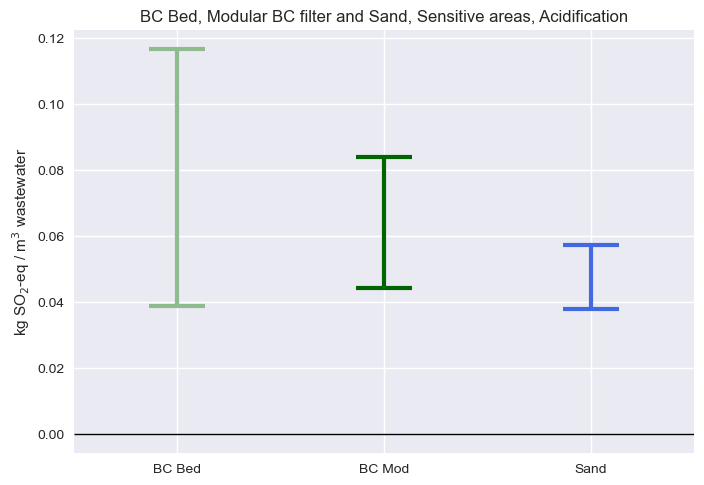

In [54]:
fig, ax = plt.subplots()
#ax.bar(1, BCBed_Sensitive_medianAcid, color='darkseagreen')
ax.errorbar(y=BCBed_Sensitive_medianAcid, x=1, yerr = BCBed_Sensitive_errorAcid, capsize=20,
    elinewidth=3, markeredgewidth=3, color='darkseagreen')
#ax.bar(2, BCMod_Sensitive_medianAcid, color='darkgreen')
ax.errorbar(y=BCMod_Sensitive_medianAcid, x=2, yerr = BCMod_Sensitive_errorAcid, capsize=20,
    elinewidth=3, markeredgewidth=3, color='darkgreen')
#ax.bar(3, Sand_Sensitive_medianAcid, color='royalblue')
ax.errorbar(y=Sand_Sensitive_medianAcid, x=3, yerr = Sand_Sensitive_errorAcid, capsize=20,
    elinewidth=3, markeredgewidth=3, color='royalblue')
ax.set_title('BC Bed, Modular BC filter and Sand, Sensitive areas, Acidification')
ax.set_xticks((1,2,3))
ax.set_xticklabels(('BC Bed', 'BC Mod', 'Sand'))
ax.set_xlim(0.5,3.5)
ax.hlines(y=0, xmin=0.5, xmax=3.5, linewidth=1, color='black')
ax.set_ylabel(acid_label)

In [55]:
fig.savefig('BasicBar_Sens_Acid', dpi=600)

### Create and filter through the df:s

In [20]:
big_df = pd.DataFrame.from_dict(params)

In [21]:
big_df['BCBedNormal_ClimateImpact'] = Y1['climate change - global warming potential (GWP100)'].values
big_df['BCBedNormal_Eutrophication'] = Y1['eutrophication - eutrophication potential'].values
big_df['BCBedNormal_Acidification'] = Y1['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [22]:
big_df['SandNormal_ClimateImpact'] = Y2['climate change - global warming potential (GWP100)'].values
big_df['SandNormal_Eutrophication'] = Y2['eutrophication - eutrophication potential'].values
big_df['SandNormal_Acidification'] = Y2['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [23]:
big_df['BCBedSensitive_ClimateImpact'] = Y3['climate change - global warming potential (GWP100)'].values
big_df['BCBedSensitive_Eutrophication'] = Y3['eutrophication - eutrophication potential'].values
big_df['BCBedSensitive_Acidification'] = Y3['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [24]:
big_df['BCModSensitive_ClimateImpact'] = Y4['climate change - global warming potential (GWP100)'].values
big_df['BCModSensitive_Eutrophication'] = Y4['eutrophication - eutrophication potential'].values
big_df['BCModSensitive_Acidification'] = Y4['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [25]:
big_df['SandSensitive_ClimateImpact'] = Y5['climate change - global warming potential (GWP100)'].values
big_df['SandSensitive_Eutrophication'] = Y5['eutrophication - eutrophication potential'].values
big_df['SandSensitive_Acidification'] = Y5['acidification - acidification (incl. fate, average Europe total, A&B)'].values

In [26]:
# remove rows that are duplicates (but keep one of them)
export_df = big_df.drop_duplicates(keep='first')

In [27]:
export_df

TransportDistanceST  TransportDistanceFilter  BOD5RemovalSludge  \
0                 50.041199               229.997253           0.345843   
1                498.393250               229.997253           0.345843   
2                 50.041199               238.017273           0.345843   
3                 50.041199               229.997253           0.462806   
4                 50.041199               229.997253           0.345843   
...                     ...                      ...                ...   
839993           249.305725               149.440002           0.092583   
839994           249.305725               149.440002           0.092583   
839995           249.305725               149.440002           0.092583   
839997           249.305725               149.440002           0.092583   
839998           249.305725               149.440002           0.092583   

        NremovalSludge  PremovalSludge  BOD5removalBCBedNormal  \
0             0.071115        0.236444                0.861385   
1             0.071115        0.236444                0.861385   
2             0.071115        0.236444                0.861385   
3             0.071115        0.236444                0.861385   
4             0.058383        0.236444                0.861385   
...                ...             ...                     ...   
839993        0.145328        0.102545                0.911837   
839994        0.145328        0.102545                0.911837   
839995        0.145328        0.102545                0.911837   
839997        0.145328        0.102545                0.911837   
839998        0.145328        0.102545                0.911837   

        NremovalBCBedNormal  PremovalBCBed  BOD5removalSand  NremovalSand  \
0                  0.027292       0.649277         0.980447      0.565260   
1                  0.027292       0.649277         0.980447      0.565260   
2                  0.027292       0.649277         0.980447      0.565260   
3                  0.027292       0.649277         0.980447      0.565260   
4                  0.027292       0.649277         0.980447      0.565260   
...                     ...            ...              ...           ...   
839993             0.170646       0.562012         0.976058      0.562305   
839994             0.170646       0.562012         0.976058      0.562305   
839995             0.170646       0.562012         0.976058      0.562305   
839997             0.170646       0.562012         0.976058      0.562305   
839998             0.170646       0.562012         0.976058      0.562305   

        ...  SandNormal_Acidification  BCBedSensitive_ClimateImpact  \
0       ...                  0.053377                      0.089720   
1       ...                  0.053381                      0.091554   
2       ...                  0.053377                      0.094530   
3       ...                  0.053377                      0.089720   
4       ...                  0.054106                      0.108660   
...     ...                       ...                           ...   
839993  ...                  0.048876                     -4.282962   
839994  ...                  0.048876                     -4.282962   
839995  ...                  0.048876                     -4.282962   
839997  ...                  0.048876                    -15.003594   
839998  ...                  0.048876                     -4.282962   

        BCBedSensitive_Eutrophication  BCBedSensitive_Acidification  \
0                            0.054891                      0.051451   
1                            0.054892                      0.051455   
2                            0.054895                      0.051460   
3                            0.054625                      0.051451   
4                            0.055549                      0.052242   
...                               ...                           ...   
839993                       0.043952  

In [28]:
# Many of the params are constants! drop all cols that have same values?
for col in export_df.columns:
    if len(export_df[col].unique()) == 1:
        export_df.drop(col,inplace=True,axis=1)

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.drop(col,inplace=True,axis=1)
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_18516\1863325900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df.d

In [29]:
export_df

TransportDistanceST  TransportDistanceFilter  BOD5RemovalSludge  \
0                 50.041199               229.997253           0.345843   
1                498.393250               229.997253           0.345843   
2                 50.041199               238.017273           0.345843   
3                 50.041199               229.997253           0.462806   
4                 50.041199               229.997253           0.345843   
...                     ...                      ...                ...   
839993           249.305725               149.440002           0.092583   
839994           249.305725               149.440002           0.092583   
839995           249.305725               149.440002           0.092583   
839997           249.305725               149.440002           0.092583   
839998           249.305725               149.440002           0.092583   

        NremovalSludge  PremovalSludge  BOD5removalBCBedNormal  \
0             0.071115        0.236444                0.861385   
1             0.071115        0.236444                0.861385   
2             0.071115        0.236444                0.861385   
3             0.071115        0.236444                0.861385   
4             0.058383        0.236444                0.861385   
...                ...             ...                     ...   
839993        0.145328        0.102545                0.911837   
839994        0.145328        0.102545                0.911837   
839995        0.145328        0.102545                0.911837   
839997        0.145328        0.102545                0.911837   
839998        0.145328        0.102545                0.911837   

        NremovalBCBedNormal  PremovalBCBed  BOD5removalSand  NremovalSand  \
0                  0.027292       0.649277         0.980447      0.565260   
1                  0.027292       0.649277         0.980447      0.565260   
2                  0.027292       0.649277         0.980447      0.565260   
3                  0.027292       0.649277         0.980447      0.565260   
4                  0.027292       0.649277         0.980447      0.565260   
...                     ...            ...              ...           ...   
839993             0.170646       0.562012         0.976058      0.562305   
839994             0.170646       0.562012         0.976058      0.562305   
839995             0.170646       0.562012         0.976058      0.562305   
839997             0.170646       0.562012         0.976058      0.562305   
839998             0.170646       0.562012         0.976058      0.562305   

        ...  SandNormal_Acidification  BCBedSensitive_ClimateImpact  \
0       ...                  0.053377                      0.089720   
1       ...                  0.053381                      0.091554   
2       ...                  0.053377                      0.094530   
3       ...                  0.053377                      0.089720   
4       ...                  0.054106                      0.108660   
...     ...                       ...                           ...   
839993  ...                  0.048876                     -4.282962   
839994  ...                  0.048876                     -4.282962   
839995  ...                  0.048876                     -4.282962   
839997  ...                  0.048876                    -15.003594   
839998  ...                  0.048876                     -4.282962   

        BCBedSensitive_Eutrophication  BCBedSensitive_Acidification  \
0                            0.054891                      0.051451   
1                            0.054892                      0.051455   
2                            0.054895                      0.051460   
3                            0.054625                      0.051451   
4                            0.055549                      0.052242   
...                               ...                           ...   
839993                       0.043952  

#### different bc

In [30]:
first_bc1 = export_df[export_df['bc_switch_param'] == 'bc1']
second_bc1 = first_bc1[first_bc1['bc_HLswitch_param'] == 'bc1HL']
bc1 = second_bc1[second_bc1['bc_Seqswitch_param'] == 'bc1Seq']

In [31]:
first_bc2 = export_df[export_df['bc_switch_param'] == 'bc2']
second_bc2 = first_bc2[first_bc2['bc_HLswitch_param'] == 'bc2HL']
bc2 = second_bc2[second_bc2['bc_Seqswitch_param'] == 'bc2Seq']

In [32]:
first_bc3 = export_df[export_df['bc_switch_param'] == 'bc3']
second_bc3 = first_bc3[first_bc3['bc_HLswitch_param'] == 'bc3HL']
bc3 = second_bc3[second_bc3['bc_Seqswitch_param'] == 'bc3Seq']

first_bc4 = export_df[export_df['bc_switch_param'] == 'bc4']
second_bc4 = first_bc4[first_bc4['bc_HLswitch_param'] == 'bc4HL']
bc4 = second_bc4[second_bc4['bc_Seqswitch_param'] == 'bc4Seq']

first_bc5 = export_df[export_df['bc_switch_param'] == 'bc5']
second_bc5 = first_bc5[first_bc5['bc_HLswitch_param'] == 'bc5HL']
bc5 = second_bc5[second_bc5['bc_Seqswitch_param'] == 'bc5Seq']

# bc 6 not in study

first_bc7 = export_df[export_df['bc_switch_param'] == 'bc7']
second_bc7 = first_bc7[first_bc7['bc_HLswitch_param'] == 'bc7HL']
bc7 = second_bc7[second_bc7['bc_Seqswitch_param'] == 'bc7Seq']

#### different energy

In [33]:
renewable_heat_df = export_df[export_df['heat_switch_param'] == 'heatWoodchips']
fossil_heat_df = export_df[export_df['heat_switch_param'] == 'heatNaturalGas']

renewable_energy_df = renewable_heat_df[renewable_heat_df['elec_switch_param'] == 'elecWindpower']
fossil_energy_df = fossil_heat_df[fossil_heat_df['elec_switch_param'] == 'elecCoal']

#### different EOL

In [34]:
CHP1 = export_df[export_df['EOL1and2_switch_param'] == 'CHP1']
CHP2 = CHP1[CHP1['EOL3and4_switch_param'] == 'CHP2']
CHP3 = CHP2[CHP2['EOL5and6_switch_param'] == 'CHP3']
data_CHP = CHP3[CHP3['EOL7_switch_param'] == 'CHP4']

In [35]:
Heat1 = export_df[export_df['EOL1and2_switch_param'] == 'Heat1']
Heat2 = Heat1[Heat1['EOL3and4_switch_param'] == 'Heat2']
Heat3 = Heat2[Heat2['EOL5and6_switch_param'] == 'Heat3']
data_heat = Heat3[Heat3['EOL7_switch_param'] == 'Heat4']

In [36]:
LS1 = export_df[export_df['EOL1and2_switch_param'] == 'LS1']
LS2 = LS1[LS1['EOL3and4_switch_param'] == 'LS2']
LS3 = LS2[LS2['EOL5and6_switch_param'] == 'LS3']
data_LS = LS3[LS3['EOL7_switch_param'] == 'LS4']

#### (sand)

In [37]:
# sand
sand_normal_climate = export_df['SandNormal_ClimateImpact']
sand_normal_eutrophication = export_df['SandNormal_Eutrophication']
sand_normal_acidification = export_df['SandNormal_Acidification']

sand_sensitive_climate = export_df['SandSensitive_ClimateImpact']
sand_sensitive_eutrophication = export_df['SandSensitive_Eutrophication']
sand_sensitive_acidification = export_df['SandSensitive_Acidification']

#### combine them all together

In [38]:
bc1andfossilheat = bc1[bc1['heat_switch_param'] == 'heatNaturalGas']
bc1andrenewableheat = bc1[bc1['heat_switch_param'] == 'heatWoodchips']
bc2andfossilheat = bc2[bc2['heat_switch_param'] == 'heatNaturalGas']
bc2andrenewableheat = bc2[bc2['heat_switch_param'] == 'heatWoodchips']
bc3andfossilheat = bc3[bc3['heat_switch_param'] == 'heatNaturalGas']
bc3andrenewableheat = bc3[bc3['heat_switch_param'] == 'heatWoodchips']
bc4andfossilheat = bc4[bc4['heat_switch_param'] == 'heatNaturalGas']
bc4andrenewableheat = bc4[bc4['heat_switch_param'] == 'heatWoodchips']
bc5andfossilheat = bc5[bc5['heat_switch_param'] == 'heatNaturalGas']
bc5andrenewableheat = bc5[bc5['heat_switch_param'] == 'heatWoodchips']
bc7andfossilheat = bc7[bc7['heat_switch_param'] == 'heatNaturalGas']
bc7andrenewableheat = bc7[bc7['heat_switch_param'] == 'heatWoodchips']

In [39]:
bc1andfossil = bc1andfossilheat[bc1andfossilheat['elec_switch_param'] == 'elecCoal']
bc1andrenewable = bc1andrenewableheat[bc1andrenewableheat['elec_switch_param'] == 'elecWindpower']
bc2andfossil = bc2andfossilheat[bc2andfossilheat['elec_switch_param'] == 'elecCoal']
bc2andrenewable = bc2andrenewableheat[bc2andrenewableheat['elec_switch_param'] == 'elecWindpower']
bc3andfossil = bc3andfossilheat[bc3andfossilheat['elec_switch_param'] == 'elecCoal']
bc3andrenewable = bc3andrenewableheat[bc3andrenewableheat['elec_switch_param'] == 'elecWindpower']
bc4andfossil = bc4andfossilheat[bc4andfossilheat['elec_switch_param'] == 'elecCoal']
bc4andrenewable = bc4andrenewableheat[bc4andrenewableheat['elec_switch_param'] == 'elecWindpower']
bc5andfossil = bc5andfossilheat[bc5andfossilheat['elec_switch_param'] == 'elecCoal']
bc5andrenewable = bc5andrenewableheat[bc5andrenewableheat['elec_switch_param'] == 'elecWindpower']
bc7andfossil = bc7andfossilheat[bc7andfossilheat['elec_switch_param'] == 'elecCoal']
bc7andrenewable = bc7andrenewableheat[bc7andrenewableheat['elec_switch_param'] == 'elecWindpower']

OBS for bc bed in sensitive areas, all bc stays in the bed, so different eol won't matter - for this bc, just use the bc and energy combination

In [40]:
# combine w EoL
bc1andfossilCHP = bc1andfossil[bc1andfossil['EOL1and2_switch_param'] == 'CHP1']
bc1andrenewableCHP = bc1andrenewable[bc1andrenewable['EOL1and2_switch_param'] == 'CHP1']
bc1andfossilHeat = bc1andfossil[bc1andfossil['EOL1and2_switch_param'] == 'Heat1']
bc1andrenewableHeat = bc1andrenewable[bc1andrenewable['EOL1and2_switch_param'] == 'Heat1']
bc1andfossilLS = bc1andfossil[bc1andfossil['EOL1and2_switch_param'] == 'LS1']
bc1andrenewableLS = bc1andrenewable[bc1andrenewable['EOL1and2_switch_param'] == 'LS1']

bc2andfossilCHP = bc2andfossil[bc2andfossil['EOL1and2_switch_param'] == 'CHP1']
bc2andrenewableCHP = bc2andrenewable[bc2andrenewable['EOL1and2_switch_param'] == 'CHP1']
bc2andfossilHeat = bc2andfossil[bc2andfossil['EOL1and2_switch_param'] == 'Heat1']
bc2andrenewableHeat = bc2andrenewable[bc2andrenewable['EOL1and2_switch_param'] == 'Heat1']
bc2andfossilLS = bc2andfossil[bc2andfossil['EOL1and2_switch_param'] == 'LS1']
bc2andrenewableLS = bc2andrenewable[bc2andrenewable['EOL1and2_switch_param'] == 'LS1']

bc3andfossilCHP = bc3andfossil[bc3andfossil['EOL3and4_switch_param'] == 'CHP2']
bc3andrenewableCHP = bc3andrenewable[bc3andrenewable['EOL3and4_switch_param'] == 'CHP2']
bc3andfossilHeat = bc3andfossil[bc3andfossil['EOL3and4_switch_param'] == 'Heat2']
bc3andrenewableHeat = bc3andrenewable[bc3andrenewable['EOL3and4_switch_param'] == 'Heat2']
bc3andfossilLS = bc3andfossil[bc3andfossil['EOL3and4_switch_param'] == 'LS2']
bc3andrenewableLS = bc3andrenewable[bc3andrenewable['EOL3and4_switch_param'] == 'LS2']

bc4andfossilCHP = bc4andfossil[bc4andfossil['EOL3and4_switch_param'] == 'CHP2']
bc4andrenewableCHP = bc4andrenewable[bc4andrenewable['EOL3and4_switch_param'] == 'CHP2']
bc4andfossilHeat = bc4andfossil[bc4andfossil['EOL3and4_switch_param'] == 'Heat2']
bc4andrenewableHeat = bc4andrenewable[bc4andrenewable['EOL3and4_switch_param'] == 'Heat2']
bc4andfossilLS = bc4andfossil[bc4andfossil['EOL3and4_switch_param'] == 'LS2']
bc4andrenewableLS = bc4andrenewable[bc4andrenewable['EOL3and4_switch_param'] == 'LS2']

bc5andfossilCHP = bc5andfossil[bc5andfossil['EOL5and6_switch_param'] == 'CHP3']
bc5andrenewableCHP = bc5andrenewable[bc5andrenewable['EOL5and6_switch_param'] == 'CHP3']
bc5andfossilHeat = bc5andfossil[bc5andfossil['EOL5and6_switch_param'] == 'Heat3']
bc5andrenewableHeat = bc5andrenewable[bc5andrenewable['EOL5and6_switch_param'] == 'Heat3']
bc5andfossilLS = bc5andfossil[bc5andfossil['EOL5and6_switch_param'] == 'LS3']
bc5andrenewableLS = bc5andrenewable[bc5andrenewable['EOL5and6_switch_param'] == 'LS3']

bc7andfossilCHP = bc7andfossil[bc7andfossil['EOL7_switch_param'] == 'CHP4']
bc7andrenewableCHP = bc7andrenewable[bc7andrenewable['EOL7_switch_param'] == 'CHP4']
bc7andfossilHeat = bc7andfossil[bc7andfossil['EOL7_switch_param'] == 'LS4']
bc7andrenewableHeat = bc7andrenewable[bc7andrenewable['EOL7_switch_param'] == 'LS4']
bc7andfossilLS = bc7andfossil[bc7andfossil['EOL7_switch_param'] == 'LS4']
bc7andrenewableLS = bc7andrenewable[bc7andrenewable['EOL7_switch_param'] == 'LS4']

##### calculate %

In [319]:
def calculate_delta(col1, col2):
    
    '''
    input: two df columns
    returns: percentage of how many times col2 was lower
    '''
    
    delta = col1 - col2
    
    alt1 = 0
    alt2 = 0
    
    for row in delta:
        if row > 0:
            alt2 += 1
        elif row < 0:
            alt1 += 1
    
    perc = alt2 / (alt1+alt2)
    
    return perc

###### BC Bed sensitive

In [320]:
BCBed_Sensitive_Climate_bc1andfossil_d = calculate_delta(
    bc1andfossil['SandSensitive_ClimateImpact'],bc1andfossil['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc1andfossil_d * 100

100.0

In [321]:
BCBed_Sensitive_Climate_bc1andrenewable_d = calculate_delta(
    bc1andrenewable['SandSensitive_ClimateImpact'],bc1andrenewable['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc1andrenewable_d * 100

100.0

In [322]:
BCBed_Sensitive_Climate_bc2andfossil_d = calculate_delta(
    bc2andfossil['SandSensitive_ClimateImpact'],bc2andfossil['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc2andfossil_d * 100

6.948109058927001

In [323]:
BCBed_Sensitive_Climate_bc2andrenewable_d = calculate_delta(
    bc2andrenewable['SandSensitive_ClimateImpact'],bc2andrenewable['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc2andrenewable_d * 100

100.0

In [324]:
BCBed_Sensitive_Climate_bc3andfossil_d = calculate_delta(
    bc3andfossil['SandSensitive_ClimateImpact'],bc3andfossil['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc3andfossil_d * 100

100.0

In [325]:
BCBed_Sensitive_Climate_bc3andrenewable_d = calculate_delta(
    bc3andrenewable['SandSensitive_ClimateImpact'],bc3andrenewable['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc3andrenewable_d * 100

100.0

In [326]:
BCBed_Sensitive_Climate_bc4andfossil_d = calculate_delta(
    bc4andfossil['SandSensitive_ClimateImpact'],bc4andfossil['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc4andfossil_d * 100

0.0

In [327]:
BCBed_Sensitive_Climate_bc4andrenewable_d = calculate_delta(
    bc4andrenewable['SandSensitive_ClimateImpact'],bc4andrenewable['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc4andrenewable_d * 100

100.0

In [328]:
BCBed_Sensitive_Climate_bc5andfossil_d = calculate_delta(
    bc5andfossil['SandSensitive_ClimateImpact'],bc5andfossil['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc5andfossil_d * 100

100.0

In [329]:
BCBed_Sensitive_Climate_bc5andrenewable_d = calculate_delta(
    bc5andrenewable['SandSensitive_ClimateImpact'],bc5andrenewable['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc5andrenewable_d * 100

100.0

In [330]:
BCBed_Sensitive_Climate_bc7andfossil_d = calculate_delta(
    bc7andfossil['SandSensitive_ClimateImpact'],bc7andfossil['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc7andfossil_d * 100

100.0

In [331]:
BCBed_Sensitive_Climate_bc7andrenewable_d = calculate_delta(
    bc7andrenewable['SandSensitive_ClimateImpact'],bc7andrenewable['BCBedSensitive_ClimateImpact'])
BCBed_Sensitive_Climate_bc7andrenewable_d * 100

100.0

###### Eutrophication

In [177]:
BCBed_Sensitive_Eutrophication_bc1andfossil_d = calculate_delta(
    bc1andfossil['SandSensitive_Eutrophication'],bc1andfossil['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc1andfossil_d * 100

71.9560878243513

In [175]:
BCBed_Sensitive_Eutrophication_bc1andrenewable_d = calculate_delta(
    bc1andrenewable['SandSensitive_Eutrophication'],bc1andrenewable['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc1andrenewable_d * 100

98.95104895104895

In [176]:
BCBed_Sensitive_Eutrophication_bc2andfossil_d = calculate_delta(
    bc2andfossil['SandSensitive_Eutrophication'],bc2andfossil['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc2andfossil_d * 100

0.0

In [178]:
BCBed_Sensitive_Eutrophication_bc2andrenewable_d = calculate_delta(
    bc2andrenewable['SandSensitive_Eutrophication'],bc2andrenewable['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc2andrenewable_d * 100

88.55072463768116

In [179]:
BCBed_Sensitive_Eutrophication_bc3andfossil_d = calculate_delta(
    bc3andfossil['SandSensitive_Eutrophication'],bc3andfossil['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc3andfossil_d * 100

91.42480211081794

In [180]:
BCBed_Sensitive_Eutrophication_bc3andrenewable_d = calculate_delta(
    bc3andrenewable['SandSensitive_Eutrophication'],bc3andrenewable['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc3andrenewable_d * 100

100.0

In [181]:
BCBed_Sensitive_Eutrophication_bc4andfossil_d = calculate_delta(
    bc4andfossil['SandSensitive_Eutrophication'],bc4andfossil['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc4andfossil_d * 100

14.25260718424102

In [182]:
BCBed_Sensitive_Eutrophication_bc4andrenewable_d = calculate_delta(
    bc4andrenewable['SandSensitive_Eutrophication'],bc4andrenewable['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc4andrenewable_d * 100

99.40476190476191

In [183]:
BCBed_Sensitive_Eutrophication_bc5andfossil_d = calculate_delta(
    bc5andfossil['SandSensitive_Eutrophication'],bc5andfossil['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc5andfossil_d * 100

98.69753979739508

In [184]:
BCBed_Sensitive_Eutrophication_bc5andrenewable_d = calculate_delta(
    bc5andrenewable['SandSensitive_Eutrophication'],bc5andrenewable['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc5andrenewable_d * 100

99.73568281938327

In [185]:
BCBed_Sensitive_Eutrophication_bc7andfossil_d = calculate_delta(
    bc7andfossil['SandSensitive_Eutrophication'],bc7andfossil['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc7andfossil_d * 100

84.76190476190476

In [186]:
BCBed_Sensitive_Eutrophication_bc7andrenewable_d = calculate_delta(
    bc7andrenewable['SandSensitive_Eutrophication'],bc7andrenewable['BCBedSensitive_Eutrophication'])
BCBed_Sensitive_Eutrophication_bc7andrenewable_d * 100

99.73368841544608

###### acid

In [187]:
BCBed_Sensitive_Acidification_bc1andfossil_d = calculate_delta(
    bc1andfossil['SandSensitive_Acidification'],bc1andfossil['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc1andfossil_d * 100

3.6926147704590817

In [188]:
BCBed_Sensitive_Acidification_bc1andrenewable_d = calculate_delta(
    bc1andrenewable['SandSensitive_Acidification'],bc1andrenewable['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc1andrenewable_d * 100

0.0

In [189]:
BCBed_Sensitive_Acidification_bc2andfossil_d = calculate_delta(
    bc2andfossil['SandSensitive_Acidification'],bc2andfossil['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc2andfossil_d * 100

0.0

In [190]:
BCBed_Sensitive_Acidification_bc2andrenewable_d = calculate_delta(
    bc2andrenewable['SandSensitive_Acidification'],bc2andrenewable['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc2andrenewable_d * 100

0.14492753623188406

In [191]:
BCBed_Sensitive_Acidification_bc3andfossil_d = calculate_delta(
    bc3andfossil['SandSensitive_Acidification'],bc3andfossil['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc3andfossil_d * 100

9.630606860158311

In [192]:
BCBed_Sensitive_Acidification_bc3andrenewable_d = calculate_delta(
    bc3andrenewable['SandSensitive_Acidification'],bc3andrenewable['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc3andrenewable_d * 100

0.0

In [193]:
BCBed_Sensitive_Acidification_bc4andfossil_d = calculate_delta(
    bc4andfossil['SandSensitive_Acidification'],bc4andfossil['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc4andfossil_d * 100

0.0

In [194]:
BCBed_Sensitive_Acidification_bc4andrenewable_d = calculate_delta(
    bc4andrenewable['SandSensitive_Acidification'],bc4andrenewable['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc4andrenewable_d * 100

0.1984126984126984

In [195]:
BCBed_Sensitive_Acidification_bc5andfossil_d = calculate_delta(
    bc5andfossil['SandSensitive_Acidification'],bc5andfossil['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc5andfossil_d * 100

0.0

In [196]:
BCBed_Sensitive_Acidification_bc5andrenewable_d = calculate_delta(
    bc5andrenewable['SandSensitive_Acidification'],bc5andrenewable['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc5andrenewable_d * 100

0.0

In [197]:
BCBed_Sensitive_Acidification_bc7andfossil_d = calculate_delta(
    bc7andfossil['SandSensitive_Acidification'],bc7andfossil['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc7andfossil_d * 100

0.0

In [198]:
BCBed_Sensitive_Acidification_bc7andrenewable_d = calculate_delta(
    bc7andrenewable['SandSensitive_Acidification'],bc7andrenewable['BCBedSensitive_Acidification'])
BCBed_Sensitive_Acidification_bc7andrenewable_d * 100

0.0

###### Normal BC Bed

Climate, BC1

In [200]:
BCBed_Normal_Climate_bc1andfossilCHP_d = calculate_delta(
    bc1andfossilCHP['SandNormal_ClimateImpact'],bc1andfossilCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc1andfossilCHP_d * 100

0.0

In [201]:
BCBed_Normal_Climate_bc1andrenewableCHP_d = calculate_delta(
    bc1andrenewableCHP['SandNormal_ClimateImpact'],bc1andrenewableCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc1andrenewableCHP_d * 100

0.0

In [202]:
BCBed_Normal_Climate_bc1andfossilHeat_d = calculate_delta(
    bc1andfossilHeat['SandNormal_ClimateImpact'],bc1andfossilHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc1andfossilHeat_d * 100

0.0

In [203]:
BCBed_Normal_Climate_bc1andrenewableHeat_d = calculate_delta(
    bc1andrenewableHeat['SandNormal_ClimateImpact'],bc1andrenewableHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc1andrenewableHeat_d * 100

0.0

In [204]:
BCBed_Normal_Climate_bc1andfossilLS_d = calculate_delta(
    bc1andfossilLS['SandNormal_ClimateImpact'],bc1andfossilLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc1andfossilLS_d * 100

74.46236559139786

In [205]:
BCBed_Normal_Climate_bc1andrenewableLS_d = calculate_delta(
    bc1andrenewableLS['SandNormal_ClimateImpact'],bc1andrenewableLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc1andrenewableLS_d * 100

100.0

Climate, BC2

In [206]:
BCBed_Normal_Climate_bc2andfossilCHP_d = calculate_delta(
    bc2andfossilCHP['SandNormal_ClimateImpact'],bc2andfossilCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc2andfossilCHP_d * 100

0.0

In [207]:
BCBed_Normal_Climate_bc2andrenewableCHP_d = calculate_delta(
    bc2andrenewableCHP['SandNormal_ClimateImpact'],bc2andrenewableCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc2andrenewableCHP_d * 100

0.0

In [208]:
BCBed_Normal_Climate_bc2andfossilHeat_d = calculate_delta(
    bc2andfossilHeat['SandNormal_ClimateImpact'],bc2andfossilHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc2andfossilHeat_d * 100

0.0

In [209]:
BCBed_Normal_Climate_bc2andrenewableHeat_d = calculate_delta(
    bc2andrenewableHeat['SandNormal_ClimateImpact'],bc2andrenewableHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc2andrenewableHeat_d * 100

0.0

In [210]:
BCBed_Normal_Climate_bc2andfossilLS_d = calculate_delta(
    bc2andfossilLS['SandNormal_ClimateImpact'],bc2andfossilLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc2andfossilLS_d * 100

0.0

In [211]:
BCBed_Normal_Climate_bc2andrenewableLS_d = calculate_delta(
    bc2andrenewableLS['SandNormal_ClimateImpact'],bc2andrenewableLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc2andrenewableLS_d * 100

100.0

Climate, BC3

In [212]:
BCBed_Normal_Climate_bc3andfossilCHP_d = calculate_delta(
    bc3andfossilCHP['SandNormal_ClimateImpact'],bc3andfossilCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc3andfossilCHP_d * 100

0.0

In [213]:
BCBed_Normal_Climate_bc3andrenewableCHP_d = calculate_delta(
    bc3andrenewableCHP['SandNormal_ClimateImpact'],bc3andrenewableCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc3andrenewableCHP_d * 100

0.0

In [214]:
BCBed_Normal_Climate_bc3andfossilHeat_d = calculate_delta(
    bc3andfossilHeat['SandNormal_ClimateImpact'],bc3andfossilHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc3andfossilHeat_d * 100

0.0

In [215]:
BCBed_Normal_Climate_bc3andrenewableHeat_d = calculate_delta(
    bc3andrenewableHeat['SandNormal_ClimateImpact'],bc3andrenewableHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc3andrenewableHeat_d * 100

0.0

In [216]:
BCBed_Normal_Climate_bc3andfossilLS_d = calculate_delta(
    bc3andfossilLS['SandNormal_ClimateImpact'],bc3andfossilLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc3andfossilLS_d * 100

50.645161290322584

In [217]:
BCBed_Normal_Climate_bc3andrenewableLS_d = calculate_delta(
    bc3andrenewableLS['SandNormal_ClimateImpact'],bc3andrenewableLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc3andrenewableLS_d * 100

100.0

Climate, BC4

In [218]:
BCBed_Normal_Climate_bc4andfossilCHP_d = calculate_delta(
    bc4andfossilCHP['SandNormal_ClimateImpact'],bc4andfossilCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc4andfossilCHP_d * 100

0.0

In [219]:
BCBed_Normal_Climate_bc4andrenewableCHP_d = calculate_delta(
    bc4andrenewableCHP['SandNormal_ClimateImpact'],bc4andrenewableCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc4andrenewableCHP_d * 100

0.0

In [220]:
BCBed_Normal_Climate_bc4andfossilHeat_d = calculate_delta(
    bc4andfossilHeat['SandNormal_ClimateImpact'],bc4andfossilHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc4andfossilHeat_d * 100

0.0

In [221]:
BCBed_Normal_Climate_bc4andrenewableHeat_d = calculate_delta(
    bc4andrenewableHeat['SandNormal_ClimateImpact'],bc4andrenewableHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc4andrenewableHeat_d * 100

0.0

In [222]:
BCBed_Normal_Climate_bc4andfossilLS_d = calculate_delta(
    bc4andfossilLS['SandNormal_ClimateImpact'],bc4andfossilLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc4andfossilLS_d * 100

0.0

In [223]:
BCBed_Normal_Climate_bc4andrenewableLS_d = calculate_delta(
    bc4andrenewableLS['SandNormal_ClimateImpact'],bc4andrenewableLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc4andrenewableLS_d * 100

100.0

Climate, BC5

In [224]:
BCBed_Normal_Climate_bc5andfossilCHP_d = calculate_delta(
    bc5andfossilCHP['SandNormal_ClimateImpact'],bc5andfossilCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc5andfossilCHP_d * 100

55.5956678700361

In [225]:
BCBed_Normal_Climate_bc5andrenewableCHP_d = calculate_delta(
    bc5andrenewableCHP['SandNormal_ClimateImpact'],bc5andrenewableCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc5andrenewableCHP_d * 100

0.0

In [226]:
BCBed_Normal_Climate_bc5andfossilHeat_d = calculate_delta(
    bc5andfossilHeat['SandNormal_ClimateImpact'],bc5andfossilHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc5andfossilHeat_d * 100

0.0

In [227]:
BCBed_Normal_Climate_bc5andrenewableHeat_d = calculate_delta(
    bc5andrenewableHeat['SandNormal_ClimateImpact'],bc5andrenewableHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc5andrenewableHeat_d * 100

0.0

In [228]:
BCBed_Normal_Climate_bc5andfossilLS_d = calculate_delta(
    bc5andfossilLS['SandNormal_ClimateImpact'],bc5andfossilLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc5andfossilLS_d * 100

100.0

In [229]:
BCBed_Normal_Climate_bc5andrenewableLS_d = calculate_delta(
    bc5andrenewableLS['SandNormal_ClimateImpact'],bc5andrenewableLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc5andrenewableLS_d * 100

100.0

Climate, BC7

In [230]:
BCBed_Normal_Climate_bc7andfossilCHP_d = calculate_delta(
    bc7andfossilCHP['SandNormal_ClimateImpact'],bc7andfossilCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc7andfossilCHP_d * 100

99.01719901719902

In [231]:
BCBed_Normal_Climate_bc7andrenewableCHP_d = calculate_delta(
    bc7andrenewableCHP['SandNormal_ClimateImpact'],bc7andrenewableCHP['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc7andrenewableCHP_d * 100

0.0

In [232]:
BCBed_Normal_Climate_bc7andfossilHeat_d = calculate_delta(
    bc7andfossilHeat['SandNormal_ClimateImpact'],bc7andfossilHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc7andfossilHeat_d * 100

100.0

In [233]:
BCBed_Normal_Climate_bc7andrenewableHeat_d = calculate_delta(
    bc7andrenewableHeat['SandNormal_ClimateImpact'],bc7andrenewableHeat['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc7andrenewableHeat_d * 100

100.0

In [234]:
BCBed_Normal_Climate_bc7andfossilLS_d = calculate_delta(
    bc7andfossilLS['SandNormal_ClimateImpact'],bc7andfossilLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc7andfossilLS_d * 100

100.0

In [235]:
BCBed_Normal_Climate_bc7andrenewableLS_d = calculate_delta(
    bc7andrenewableLS['SandNormal_ClimateImpact'],bc7andrenewableLS['BCBedNormal_ClimateImpact'])
BCBed_Normal_Climate_bc7andrenewableLS_d * 100

100.0

###### Eutrophication

Eutrophication, BC1

In [236]:
BCBed_Normal_Eutrophication_bc1andfossilCHP_d = calculate_delta(
    bc1andfossilCHP['SandNormal_Eutrophication'],bc1andfossilCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc1andfossilCHP_d * 100

0.0

In [237]:
BCBed_Normal_Eutrophication_bc1andrenewableCHP_d = calculate_delta(
    bc1andrenewableCHP['SandNormal_Eutrophication'],bc1andrenewableCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc1andrenewableCHP_d * 100

0.0

In [238]:
BCBed_Normal_Eutrophication_bc1andfossilHeat_d = calculate_delta(
    bc1andfossilHeat['SandNormal_Eutrophication'],bc1andfossilHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc1andfossilHeat_d * 100

0.0

In [239]:
BCBed_Normal_Eutrophication_bc1andrenewableHeat_d = calculate_delta(
    bc1andrenewableHeat['SandNormal_Eutrophication'],bc1andrenewableHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc1andrenewableHeat_d * 100

0.0

In [240]:
BCBed_Normal_Eutrophication_bc1andfossilLS_d = calculate_delta(
    bc1andfossilLS['SandNormal_Eutrophication'],bc1andfossilLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc1andfossilLS_d * 100

0.0

In [241]:
BCBed_Normal_Eutrophication_bc1andrenewableLS_d = calculate_delta(
    bc1andrenewableLS['SandNormal_Eutrophication'],bc1andrenewableLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc1andrenewableLS_d * 100

0.0

Eutrophication, BC2

In [242]:
BCBed_Normal_Eutrophication_bc2andfossilCHP_d = calculate_delta(
    bc2andfossilCHP['SandNormal_Eutrophication'],bc2andfossilCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc2andfossilCHP_d * 100

0.0

In [243]:
BCBed_Normal_Eutrophication_bc2andrenewableCHP_d = calculate_delta(
    bc2andrenewableCHP['SandNormal_Eutrophication'],bc2andrenewableCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc2andrenewableCHP_d * 100

0.0

In [244]:
BCBed_Normal_Eutrophication_bc2andfossilHeat_d = calculate_delta(
    bc2andfossilHeat['SandNormal_Eutrophication'],bc2andfossilHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc2andfossilHeat_d * 100

0.0

In [245]:
BCBed_Normal_Eutrophication_bc2andrenewableHeat_d = calculate_delta(
    bc2andrenewableHeat['SandNormal_Eutrophication'],bc2andrenewableHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc2andrenewableHeat_d * 100

0.0

In [246]:
BCBed_Normal_Eutrophication_bc2andfossilLS_d = calculate_delta(
    bc2andfossilLS['SandNormal_Eutrophication'],bc2andfossilLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc2andfossilLS_d * 100

0.0

In [247]:
BCBed_Normal_Eutrophication_bc2andrenewableLS_d = calculate_delta(
    bc2andrenewableLS['SandNormal_Eutrophication'],bc2andrenewableLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc2andrenewableLS_d * 100

0.0

Eutrophication, BC3

In [248]:
BCBed_Normal_Eutrophication_bc3andfossilCHP_d = calculate_delta(
    bc3andfossilCHP['SandNormal_Eutrophication'],bc3andfossilCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc3andfossilCHP_d * 100

24.637681159420293

In [249]:
BCBed_Normal_Eutrophication_bc3andrenewableCHP_d = calculate_delta(
    bc3andrenewableCHP['SandNormal_Eutrophication'],bc3andrenewableCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc3andrenewableCHP_d * 100

0.0

In [250]:
BCBed_Normal_Eutrophication_bc3andfossilHeat_d = calculate_delta(
    bc3andfossilHeat['SandNormal_Eutrophication'],bc3andfossilHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc3andfossilHeat_d * 100

0.0

In [251]:
BCBed_Normal_Eutrophication_bc3andrenewableHeat_d = calculate_delta(
    bc3andrenewableHeat['SandNormal_Eutrophication'],bc3andrenewableHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc3andrenewableHeat_d * 100

0.0

In [252]:
BCBed_Normal_Eutrophication_bc3andfossilLS_d = calculate_delta(
    bc3andfossilLS['SandNormal_Eutrophication'],bc3andfossilLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc3andfossilLS_d * 100

0.0

In [253]:
BCBed_Normal_Eutrophication_bc3andrenewableLS_d = calculate_delta(
    bc3andrenewableLS['SandNormal_Eutrophication'],bc3andrenewableLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc3andrenewableLS_d * 100

0.0

Eutrophication, BC4

In [254]:
BCBed_Normal_Eutrophication_bc4andfossilCHP_d = calculate_delta(
    bc4andfossilCHP['SandNormal_Eutrophication'],bc4andfossilCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc4andfossilCHP_d * 100

0.0

In [255]:
BCBed_Normal_Eutrophication_bc4andrenewableCHP_d = calculate_delta(
    bc4andrenewableCHP['SandNormal_Eutrophication'],bc4andrenewableCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc4andrenewableCHP_d * 100

0.0

In [256]:
BCBed_Normal_Eutrophication_bc4andfossilHeat_d = calculate_delta(
    bc4andfossilHeat['SandNormal_Eutrophication'],bc4andfossilHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc4andfossilHeat_d * 100

0.0

In [257]:
BCBed_Normal_Eutrophication_bc4andrenewableHeat_d = calculate_delta(
    bc4andrenewableHeat['SandNormal_Eutrophication'],bc4andrenewableHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc4andrenewableHeat_d * 100

0.0

In [258]:
BCBed_Normal_Eutrophication_bc4andfossilLS_d = calculate_delta(
    bc4andfossilLS['SandNormal_Eutrophication'],bc4andfossilLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc4andfossilLS_d * 100

0.0

In [259]:
BCBed_Normal_Eutrophication_bc4andrenewableLS_d = calculate_delta(
    bc4andrenewableLS['SandNormal_Eutrophication'],bc4andrenewableLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc4andrenewableLS_d * 100

0.0

Eutrophication, BC5

In [260]:
BCBed_Normal_Eutrophication_bc5andfossilCHP_d = calculate_delta(
    bc5andfossilCHP['SandNormal_Eutrophication'],bc5andfossilCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc5andfossilCHP_d * 100

0.7220216606498195

In [261]:
BCBed_Normal_Eutrophication_bc5andrenewableCHP_d = calculate_delta(
    bc5andrenewableCHP['SandNormal_Eutrophication'],bc5andrenewableCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc5andrenewableCHP_d * 100

0.0

In [262]:
BCBed_Normal_Eutrophication_bc5andfossilHeat_d = calculate_delta(
    bc5andfossilHeat['SandNormal_Eutrophication'],bc5andfossilHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc5andfossilHeat_d * 100

0.0

In [263]:
BCBed_Normal_Eutrophication_bc5andrenewableHeat_d = calculate_delta(
    bc5andrenewableHeat['SandNormal_Eutrophication'],bc5andrenewableHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc5andrenewableHeat_d * 100

0.0

In [264]:
BCBed_Normal_Eutrophication_bc5andfossilLS_d = calculate_delta(
    bc5andfossilLS['SandNormal_Eutrophication'],bc5andfossilLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc5andfossilLS_d * 100

0.0

In [266]:
BCBed_Normal_Eutrophication_bc5andrenewableLS_d = calculate_delta(
    bc5andrenewableLS['SandNormal_Eutrophication'],bc5andrenewableLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc5andrenewableLS_d * 100

0.5249343832020997

Eutrophication, BC7

In [267]:
BCBed_Normal_Eutrophication_bc7andfossilCHP_d = calculate_delta(
    bc7andfossilCHP['SandNormal_Eutrophication'],bc7andfossilCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc7andfossilCHP_d * 100

0.0

In [268]:
BCBed_Normal_Eutrophication_bc7andrenewableCHP_d = calculate_delta(
    bc7andrenewableCHP['SandNormal_Eutrophication'],bc7andrenewableCHP['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc7andrenewableCHP_d * 100

0.0

In [269]:
BCBed_Normal_Eutrophication_bc7andfossilHeat_d = calculate_delta(
    bc7andfossilHeat['SandNormal_Eutrophication'],bc7andfossilHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc7andfossilHeat_d * 100

0.0

In [270]:
BCBed_Normal_Eutrophication_bc7andrenewableHeat_d = calculate_delta(
    bc7andrenewableHeat['SandNormal_Eutrophication'],bc7andrenewableHeat['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc7andrenewableHeat_d * 100

0.0

In [271]:
BCBed_Normal_Eutrophication_bc7andfossilLS_d = calculate_delta(
    bc7andfossilLS['SandNormal_Eutrophication'],bc7andfossilLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc7andfossilLS_d * 100

0.0

In [272]:
BCBed_Normal_Eutrophication_bc7andrenewableLS_d = calculate_delta(
    bc7andrenewableLS['SandNormal_Eutrophication'],bc7andrenewableLS['BCBedNormal_Eutrophication'])
BCBed_Normal_Eutrophication_bc7andrenewableLS_d * 100

0.0

###### BC Bed Normal, Acid

Acidification, BC1

In [273]:
BCBed_Normal_Acidification_bc1andfossilCHP_d = calculate_delta(
    bc1andfossilCHP['SandNormal_Acidification'],bc1andfossilCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc1andfossilCHP_d * 100

0.0

In [274]:
BCBed_Normal_Acidification_bc1andrenewableCHP_d = calculate_delta(
    bc1andrenewableCHP['SandNormal_Acidification'],bc1andrenewableCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc1andrenewableCHP_d * 100

0.0

In [275]:
BCBed_Normal_Acidification_bc1andfossilHeat_d = calculate_delta(
    bc1andfossilHeat['SandNormal_Acidification'],bc1andfossilHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc1andfossilHeat_d * 100

0.0

In [276]:
BCBed_Normal_Acidification_bc1andrenewableHeat_d = calculate_delta(
    bc1andrenewableHeat['SandNormal_Acidification'],bc1andrenewableHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc1andrenewableHeat_d * 100

0.0

In [277]:
BCBed_Normal_Acidification_bc1andfossilLS_d = calculate_delta(
    bc1andfossilLS['SandNormal_Acidification'],bc1andfossilLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc1andfossilLS_d * 100

0.0

In [278]:
BCBed_Normal_Acidification_bc1andrenewableLS_d = calculate_delta(
    bc1andrenewableLS['SandNormal_Acidification'],bc1andrenewableLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc1andrenewableLS_d * 100

0.0

Acidification, BC2

In [279]:
BCBed_Normal_Acidification_bc2andfossilCHP_d = calculate_delta(
    bc2andfossilCHP['SandNormal_Acidification'],bc2andfossilCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc2andfossilCHP_d * 100

0.0

In [280]:
BCBed_Normal_Acidification_bc2andrenewableCHP_d = calculate_delta(
    bc2andrenewableCHP['SandNormal_Acidification'],bc2andrenewableCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc2andrenewableCHP_d * 100

0.0

In [281]:
BCBed_Normal_Acidification_bc2andfossilHeat_d = calculate_delta(
    bc2andfossilHeat['SandNormal_Acidification'],bc2andfossilHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc2andfossilHeat_d * 100

0.0

In [282]:
BCBed_Normal_Acidification_bc2andrenewableHeat_d = calculate_delta(
    bc2andrenewableHeat['SandNormal_Acidification'],bc2andrenewableHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc2andrenewableHeat_d * 100

0.0

In [283]:
BCBed_Normal_Acidification_bc2andfossilLS_d = calculate_delta(
    bc2andfossilLS['SandNormal_Acidification'],bc2andfossilLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc2andfossilLS_d * 100

0.0

In [284]:
BCBed_Normal_Acidification_bc2andrenewableLS_d = calculate_delta(
    bc2andrenewableLS['SandNormal_Acidification'],bc2andrenewableLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc2andrenewableLS_d * 100

0.0

Acidification, BC3

In [285]:
BCBed_Normal_Acidification_bc3andfossilCHP_d = calculate_delta(
    bc3andfossilCHP['SandNormal_Acidification'],bc3andfossilCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc3andfossilCHP_d * 100

100.0

In [286]:
BCBed_Normal_Acidification_bc3andrenewableCHP_d = calculate_delta(
    bc3andrenewableCHP['SandNormal_Acidification'],bc3andrenewableCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc3andrenewableCHP_d * 100

29.7029702970297

In [287]:
BCBed_Normal_Acidification_bc3andfossilHeat_d = calculate_delta(
    bc3andfossilHeat['SandNormal_Acidification'],bc3andfossilHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc3andfossilHeat_d * 100

84.51612903225806

In [288]:
BCBed_Normal_Acidification_bc3andrenewableHeat_d = calculate_delta(
    bc3andrenewableHeat['SandNormal_Acidification'],bc3andrenewableHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc3andrenewableHeat_d * 100

61.50627615062761

In [289]:
BCBed_Normal_Acidification_bc3andfossilLS_d = calculate_delta(
    bc3andfossilLS['SandNormal_Acidification'],bc3andfossilLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc3andfossilLS_d * 100

87.74193548387098

In [290]:
BCBed_Normal_Acidification_bc3andrenewableLS_d = calculate_delta(
    bc3andrenewableLS['SandNormal_Acidification'],bc3andrenewableLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc3andrenewableLS_d * 100

63.66666666666667

Acidification, BC4

In [291]:
BCBed_Normal_Acidification_bc4andfossilCHP_d = calculate_delta(
    bc4andfossilCHP['SandNormal_Acidification'],bc4andfossilCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc4andfossilCHP_d * 100

34.294871794871796

In [292]:
BCBed_Normal_Acidification_bc4andrenewableCHP_d = calculate_delta(
    bc4andrenewableCHP['SandNormal_Acidification'],bc4andrenewableCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc4andrenewableCHP_d * 100

45.38834951456311

In [293]:
BCBed_Normal_Acidification_bc4andfossilHeat_d = calculate_delta(
    bc4andfossilHeat['SandNormal_Acidification'],bc4andfossilHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc4andfossilHeat_d * 100

0.0

In [294]:
BCBed_Normal_Acidification_bc4andrenewableHeat_d = calculate_delta(
    bc4andrenewableHeat['SandNormal_Acidification'],bc4andrenewableHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc4andrenewableHeat_d * 100

33.137829912023456

In [295]:
BCBed_Normal_Acidification_bc4andfossilLS_d = calculate_delta(
    bc4andfossilLS['SandNormal_Acidification'],bc4andfossilLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc4andfossilLS_d * 100

1.8382352941176472

In [296]:
BCBed_Normal_Acidification_bc4andrenewableLS_d = calculate_delta(
    bc4andrenewableLS['SandNormal_Acidification'],bc4andrenewableLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc4andrenewableLS_d * 100

80.0

Acidification, BC5

In [297]:
BCBed_Normal_Acidification_bc5andfossilCHP_d = calculate_delta(
    bc5andfossilCHP['SandNormal_Acidification'],bc5andfossilCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc5andfossilCHP_d * 100

85.1985559566787

In [298]:
BCBed_Normal_Acidification_bc5andrenewableCHP_d = calculate_delta(
    bc5andrenewableCHP['SandNormal_Acidification'],bc5andrenewableCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc5andrenewableCHP_d * 100

50.63694267515923

In [299]:
BCBed_Normal_Acidification_bc5andfossilHeat_d = calculate_delta(
    bc5andfossilHeat['SandNormal_Acidification'],bc5andfossilHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc5andfossilHeat_d * 100

8.433734939759036

In [300]:
BCBed_Normal_Acidification_bc5andrenewableHeat_d = calculate_delta(
    bc5andrenewableHeat['SandNormal_Acidification'],bc5andrenewableHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc5andrenewableHeat_d * 100

58.63636363636363

In [301]:
BCBed_Normal_Acidification_bc5andfossilLS_d = calculate_delta(
    bc5andfossilLS['SandNormal_Acidification'],bc5andfossilLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc5andfossilLS_d * 100

51.20967741935484

In [302]:
BCBed_Normal_Acidification_bc5andrenewableLS_d = calculate_delta(
    bc5andrenewableLS['SandNormal_Acidification'],bc5andrenewableLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc5andrenewableLS_d * 100

88.18897637795276

Acidification, BC7

In [303]:
BCBed_Normal_Acidification_bc7andfossilCHP_d = calculate_delta(
    bc7andfossilCHP['SandNormal_Acidification'],bc7andfossilCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc7andfossilCHP_d * 100

0.9828009828009828

In [304]:
BCBed_Normal_Acidification_bc7andrenewableCHP_d = calculate_delta(
    bc7andrenewableCHP['SandNormal_Acidification'],bc7andrenewableCHP['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc7andrenewableCHP_d * 100

1.048951048951049

In [305]:
BCBed_Normal_Acidification_bc7andfossilHeat_d = calculate_delta(
    bc7andfossilHeat['SandNormal_Acidification'],bc7andfossilHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc7andfossilHeat_d * 100

0.0

In [306]:
BCBed_Normal_Acidification_bc7andrenewableHeat_d = calculate_delta(
    bc7andrenewableHeat['SandNormal_Acidification'],bc7andrenewableHeat['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc7andrenewableHeat_d * 100

3.0

In [307]:
BCBed_Normal_Acidification_bc7andfossilLS_d = calculate_delta(
    bc7andfossilLS['SandNormal_Acidification'],bc7andfossilLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc7andfossilLS_d * 100

0.0

In [308]:
BCBed_Normal_Acidification_bc7andrenewableLS_d = calculate_delta(
    bc7andrenewableLS['SandNormal_Acidification'],bc7andrenewableLS['BCBedNormal_Acidification'])
BCBed_Normal_Acidification_bc7andrenewableLS_d * 100

3.0

###### BC Mod

Climate, BC1

In [309]:
BCMod_Sensitive_Climate_bc1andfossilCHP_d = calculate_delta(
    bc1andfossilCHP['SandSensitive_ClimateImpact'],bc1andfossilCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc1andfossilCHP_d * 100

0.0

In [310]:
BCMod_Sensitive_Climate_bc1andrenewableCHP_d = calculate_delta(
    bc1andrenewableCHP['SandSensitive_ClimateImpact'],bc1andrenewableCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc1andrenewableCHP_d * 100

0.0

In [311]:
BCMod_Sensitive_Climate_bc1andfossilHeat_d = calculate_delta(
    bc1andfossilHeat['SandSensitive_ClimateImpact'],bc1andfossilHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc1andfossilHeat_d * 100

0.0

In [312]:
BCMod_Sensitive_Climate_bc1andrenewableHeat_d = calculate_delta(
    bc1andrenewableHeat['SandSensitive_ClimateImpact'],bc1andrenewableHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc1andrenewableHeat_d * 100

0.0

In [313]:
BCMod_Sensitive_Climate_bc1andfossilLS_d = calculate_delta(
    bc1andfossilLS['SandSensitive_ClimateImpact'],bc1andfossilLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc1andfossilLS_d * 100

100.0

In [314]:
BCMod_Sensitive_Climate_bc1andrenewableLS_d = calculate_delta(
    bc1andrenewableLS['SandSensitive_ClimateImpact'],bc1andrenewableLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc1andrenewableLS_d * 100

100.0

Climate, BC2

In [315]:
BCMod_Sensitive_Climate_bc2andfossilCHP_d = calculate_delta(
    bc2andfossilCHP['SandSensitive_ClimateImpact'],bc2andfossilCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc2andfossilCHP_d * 100

0.0

In [316]:
BCMod_Sensitive_Climate_bc2andrenewableCHP_d = calculate_delta(
    bc2andrenewableCHP['SandSensitive_ClimateImpact'],bc2andrenewableCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc2andrenewableCHP_d * 100

0.0

In [317]:
BCMod_Sensitive_Climate_bc2andfossilHeat_d = calculate_delta(
    bc2andfossilHeat['SandSensitive_ClimateImpact'],bc2andfossilHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc2andfossilHeat_d * 100

0.0

In [318]:
BCMod_Sensitive_Climate_bc2andrenewableHeat_d = calculate_delta(
    bc2andrenewableHeat['SandSensitive_ClimateImpact'],bc2andrenewableHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc2andrenewableHeat_d * 100

0.0

In [319]:
BCMod_Sensitive_Climate_bc2andfossilLS_d = calculate_delta(
    bc2andfossilLS['SandSensitive_ClimateImpact'],bc2andfossilLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc2andfossilLS_d * 100

88.28828828828829

In [320]:
BCMod_Sensitive_Climate_bc2andrenewableLS_d = calculate_delta(
    bc2andrenewableLS['SandSensitive_ClimateImpact'],bc2andrenewableLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc2andrenewableLS_d * 100

100.0

Climate, BC3

In [321]:
BCMod_Sensitive_Climate_bc3andfossilCHP_d = calculate_delta(
    bc3andfossilCHP['SandSensitive_ClimateImpact'],bc3andfossilCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc3andfossilCHP_d * 100

0.0

In [322]:
BCMod_Sensitive_Climate_bc3andrenewableCHP_d = calculate_delta(
    bc3andrenewableCHP['SandSensitive_ClimateImpact'],bc3andrenewableCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc3andrenewableCHP_d * 100

0.0

In [323]:
BCMod_Sensitive_Climate_bc3andfossilHeat_d = calculate_delta(
    bc3andfossilHeat['SandSensitive_ClimateImpact'],bc3andfossilHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc3andfossilHeat_d * 100

0.0

In [324]:
BCMod_Sensitive_Climate_bc3andrenewableHeat_d = calculate_delta(
    bc3andrenewableHeat['SandSensitive_ClimateImpact'],bc3andrenewableHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc3andrenewableHeat_d * 100

0.0

In [325]:
BCMod_Sensitive_Climate_bc3andfossilLS_d = calculate_delta(
    bc3andfossilLS['SandSensitive_ClimateImpact'],bc3andfossilLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc3andfossilLS_d * 100

100.0

In [326]:
BCMod_Sensitive_Climate_bc3andrenewableLS_d = calculate_delta(
    bc3andrenewableLS['SandSensitive_ClimateImpact'],bc3andrenewableLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc3andrenewableLS_d * 100

100.0

Climate, BC4

In [327]:
BCMod_Sensitive_Climate_bc4andfossilCHP_d = calculate_delta(
    bc4andfossilCHP['SandSensitive_ClimateImpact'],bc4andfossilCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc4andfossilCHP_d * 100

0.0

In [328]:
BCMod_Sensitive_Climate_bc4andrenewableCHP_d = calculate_delta(
    bc4andrenewableCHP['SandSensitive_ClimateImpact'],bc4andrenewableCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc4andrenewableCHP_d * 100

0.0

In [329]:
BCMod_Sensitive_Climate_bc4andfossilHeat_d = calculate_delta(
    bc4andfossilHeat['SandSensitive_ClimateImpact'],bc4andfossilHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc4andfossilHeat_d * 100

0.0

In [330]:
BCMod_Sensitive_Climate_bc4andrenewableHeat_d = calculate_delta(
    bc4andrenewableHeat['SandSensitive_ClimateImpact'],bc4andrenewableHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc4andrenewableHeat_d * 100

0.0

In [331]:
BCMod_Sensitive_Climate_bc4andfossilLS_d = calculate_delta(
    bc4andfossilLS['SandSensitive_ClimateImpact'],bc4andfossilLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc4andfossilLS_d * 100

72.05882352941177

In [332]:
BCMod_Sensitive_Climate_bc4andrenewableLS_d = calculate_delta(
    bc4andrenewableLS['SandSensitive_ClimateImpact'],bc4andrenewableLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc4andrenewableLS_d * 100

100.0

Climate, BC5

In [333]:
BCMod_Sensitive_Climate_bc5andfossilCHP_d = calculate_delta(
    bc5andfossilCHP['SandSensitive_ClimateImpact'],bc5andfossilCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc5andfossilCHP_d * 100

12.274368231046932

In [334]:
BCMod_Sensitive_Climate_bc5andrenewableCHP_d = calculate_delta(
    bc5andrenewableCHP['SandSensitive_ClimateImpact'],bc5andrenewableCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc5andrenewableCHP_d * 100

0.0

In [335]:
BCMod_Sensitive_Climate_bc5andfossilHeat_d = calculate_delta(
    bc5andfossilHeat['SandSensitive_ClimateImpact'],bc5andfossilHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc5andfossilHeat_d * 100

0.0

In [336]:
BCMod_Sensitive_Climate_bc5andrenewableHeat_d = calculate_delta(
    bc5andrenewableHeat['SandSensitive_ClimateImpact'],bc5andrenewableHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc5andrenewableHeat_d * 100

0.0

In [337]:
BCMod_Sensitive_Climate_bc5andfossilLS_d = calculate_delta(
    bc5andfossilLS['SandSensitive_ClimateImpact'],bc5andfossilLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc5andfossilLS_d * 100

100.0

In [338]:
BCMod_Sensitive_Climate_bc5andrenewableLS_d = calculate_delta(
    bc5andrenewableLS['SandSensitive_ClimateImpact'],bc5andrenewableLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc5andrenewableLS_d * 100

100.0

Climate, BC7

In [339]:
BCMod_Sensitive_Climate_bc7andfossilCHP_d = calculate_delta(
    bc7andfossilCHP['SandSensitive_ClimateImpact'],bc7andfossilCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc7andfossilCHP_d * 100

92.13759213759214

In [340]:
BCMod_Sensitive_Climate_bc7andrenewableCHP_d = calculate_delta(
    bc7andrenewableCHP['SandSensitive_ClimateImpact'],bc7andrenewableCHP['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc7andrenewableCHP_d * 100

0.0

In [341]:
BCMod_Sensitive_Climate_bc7andfossilHeat_d = calculate_delta(
    bc7andfossilHeat['SandSensitive_ClimateImpact'],bc7andfossilHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc7andfossilHeat_d * 100

100.0

In [342]:
BCMod_Sensitive_Climate_bc7andrenewableHeat_d = calculate_delta(
    bc7andrenewableHeat['SandSensitive_ClimateImpact'],bc7andrenewableHeat['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc7andrenewableHeat_d * 100

100.0

In [343]:
BCMod_Sensitive_Climate_bc7andfossilLS_d = calculate_delta(
    bc7andfossilLS['SandSensitive_ClimateImpact'],bc7andfossilLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc7andfossilLS_d * 100

100.0

In [344]:
BCMod_Sensitive_Climate_bc7andrenewableLS_d = calculate_delta(
    bc7andrenewableLS['SandSensitive_ClimateImpact'],bc7andrenewableLS['BCModSensitive_ClimateImpact'])
BCMod_Sensitive_Climate_bc7andrenewableLS_d * 100

100.0

###### Eutrophication

Eutrophication, BC1

In [345]:
BCMod_Sensitive_Eutrophication_bc1andfossilCHP_d = calculate_delta(
    bc1andfossilCHP['SandSensitive_Eutrophication'],bc1andfossilCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc1andfossilCHP_d * 100

100.0

In [346]:
BCMod_Sensitive_Eutrophication_bc1andrenewableCHP_d = calculate_delta(
    bc1andrenewableCHP['SandSensitive_Eutrophication'],bc1andrenewableCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc1andrenewableCHP_d * 100

89.29440389294405

In [347]:
BCMod_Sensitive_Eutrophication_bc1andfossilHeat_d = calculate_delta(
    bc1andfossilHeat['SandSensitive_Eutrophication'],bc1andfossilHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc1andfossilHeat_d * 100

53.135313531353134

In [348]:
BCMod_Sensitive_Eutrophication_bc1andrenewableHeat_d = calculate_delta(
    bc1andrenewableHeat['SandSensitive_Eutrophication'],bc1andrenewableHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc1andrenewableHeat_d * 100

79.90654205607477

In [349]:
BCMod_Sensitive_Eutrophication_bc1andfossilLS_d = calculate_delta(
    bc1andfossilLS['SandSensitive_Eutrophication'],bc1andfossilLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc1andfossilLS_d * 100

70.16129032258065

In [350]:
BCMod_Sensitive_Eutrophication_bc1andrenewableLS_d = calculate_delta(
    bc1andrenewableLS['SandSensitive_Eutrophication'],bc1andrenewableLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc1andrenewableLS_d * 100

84.97854077253218

Eutrophication, BC2

In [351]:
BCMod_Sensitive_Eutrophication_bc2andfossilCHP_d = calculate_delta(
    bc2andfossilCHP['SandSensitive_Eutrophication'],bc2andfossilCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc2andfossilCHP_d * 100

92.27373068432672

In [352]:
BCMod_Sensitive_Eutrophication_bc2andrenewableCHP_d = calculate_delta(
    bc2andrenewableCHP['SandSensitive_Eutrophication'],bc2andrenewableCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc2andrenewableCHP_d * 100

78.71720116618076

In [353]:
BCMod_Sensitive_Eutrophication_bc2andfossilHeat_d = calculate_delta(
    bc2andfossilHeat['SandSensitive_Eutrophication'],bc2andfossilHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc2andfossilHeat_d * 100

1.1396011396011396

In [354]:
BCMod_Sensitive_Eutrophication_bc2andrenewableHeat_d = calculate_delta(
    bc2andrenewableHeat['SandSensitive_Eutrophication'],bc2andrenewableHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc2andrenewableHeat_d * 100

81.42857142857143

In [355]:
BCMod_Sensitive_Eutrophication_bc2andfossilLS_d = calculate_delta(
    bc2andfossilLS['SandSensitive_Eutrophication'],bc2andfossilLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc2andfossilLS_d * 100

1.8018018018018018

In [356]:
BCMod_Sensitive_Eutrophication_bc2andrenewableLS_d = calculate_delta(
    bc2andrenewableLS['SandSensitive_Eutrophication'],bc2andrenewableLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc2andrenewableLS_d * 100

74.0072202166065

Eutrophication, BC3

In [357]:
BCMod_Sensitive_Eutrophication_bc3andfossilCHP_d = calculate_delta(
    bc3andfossilCHP['SandSensitive_Eutrophication'],bc3andfossilCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc3andfossilCHP_d * 100

99.27536231884058

In [358]:
BCMod_Sensitive_Eutrophication_bc3andrenewableCHP_d = calculate_delta(
    bc3andrenewableCHP['SandSensitive_Eutrophication'],bc3andrenewableCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc3andrenewableCHP_d * 100

90.5940594059406

In [359]:
BCMod_Sensitive_Eutrophication_bc3andfossilHeat_d = calculate_delta(
    bc3andfossilHeat['SandSensitive_Eutrophication'],bc3andfossilHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc3andfossilHeat_d * 100

88.06451612903226

In [360]:
BCMod_Sensitive_Eutrophication_bc3andrenewableHeat_d = calculate_delta(
    bc3andrenewableHeat['SandSensitive_Eutrophication'],bc3andrenewableHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc3andrenewableHeat_d * 100

95.81589958158996

In [361]:
BCMod_Sensitive_Eutrophication_bc3andfossilLS_d = calculate_delta(
    bc3andfossilLS['SandSensitive_Eutrophication'],bc3andfossilLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc3andfossilLS_d * 100

96.45161290322581

In [362]:
BCMod_Sensitive_Eutrophication_bc3andrenewableLS_d = calculate_delta(
    bc3andrenewableLS['SandSensitive_Eutrophication'],bc3andrenewableLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc3andrenewableLS_d * 100

86.0

Eutrophication, BC4

In [363]:
BCMod_Sensitive_Eutrophication_bc4andfossilCHP_d = calculate_delta(
    bc4andfossilCHP['SandSensitive_Eutrophication'],bc4andfossilCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc4andfossilCHP_d * 100

86.21794871794873

In [364]:
BCMod_Sensitive_Eutrophication_bc4andrenewableCHP_d = calculate_delta(
    bc4andrenewableCHP['SandSensitive_Eutrophication'],bc4andrenewableCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc4andrenewableCHP_d * 100

90.0485436893204

In [365]:
BCMod_Sensitive_Eutrophication_bc4andfossilHeat_d = calculate_delta(
    bc4andfossilHeat['SandSensitive_Eutrophication'],bc4andfossilHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc4andfossilHeat_d * 100

52.32974910394266

In [366]:
BCMod_Sensitive_Eutrophication_bc4andrenewableHeat_d = calculate_delta(
    bc4andrenewableHeat['SandSensitive_Eutrophication'],bc4andrenewableHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc4andrenewableHeat_d * 100

51.61290322580645

In [367]:
BCMod_Sensitive_Eutrophication_bc4andfossilLS_d = calculate_delta(
    bc4andfossilLS['SandSensitive_Eutrophication'],bc4andfossilLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc4andfossilLS_d * 100

34.19117647058824

In [368]:
BCMod_Sensitive_Eutrophication_bc4andrenewableLS_d = calculate_delta(
    bc4andrenewableLS['SandSensitive_Eutrophication'],bc4andrenewableLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc4andrenewableLS_d * 100

83.52941176470588

Eutrophication, BC5

In [369]:
BCMod_Sensitive_Eutrophication_bc5andfossilCHP_d = calculate_delta(
    bc5andfossilCHP['SandSensitive_Eutrophication'],bc5andfossilCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc5andfossilCHP_d * 100

99.27797833935018

In [370]:
BCMod_Sensitive_Eutrophication_bc5andrenewableCHP_d = calculate_delta(
    bc5andrenewableCHP['SandSensitive_Eutrophication'],bc5andrenewableCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc5andrenewableCHP_d * 100

65.92356687898089

In [371]:
BCMod_Sensitive_Eutrophication_bc5andfossilHeat_d = calculate_delta(
    bc5andfossilHeat['SandSensitive_Eutrophication'],bc5andfossilHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc5andfossilHeat_d * 100

75.30120481927712

In [372]:
BCMod_Sensitive_Eutrophication_bc5andrenewableHeat_d = calculate_delta(
    bc5andrenewableHeat['SandSensitive_Eutrophication'],bc5andrenewableHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc5andrenewableHeat_d * 100

91.13636363636364

In [373]:
BCMod_Sensitive_Eutrophication_bc5andfossilLS_d = calculate_delta(
    bc5andfossilLS['SandSensitive_Eutrophication'],bc5andfossilLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc5andfossilLS_d * 100

69.75806451612904

In [374]:
BCMod_Sensitive_Eutrophication_bc5andrenewableLS_d = calculate_delta(
    bc5andrenewableLS['SandSensitive_Eutrophication'],bc5andrenewableLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc5andrenewableLS_d * 100

83.46456692913385

Eutrophication, BC7

In [375]:
BCMod_Sensitive_Eutrophication_bc7andfossilCHP_d = calculate_delta(
    bc7andfossilCHP['SandSensitive_Eutrophication'],bc7andfossilCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc7andfossilCHP_d * 100

91.64619164619164

In [376]:
BCMod_Sensitive_Eutrophication_bc7andrenewableCHP_d = calculate_delta(
    bc7andrenewableCHP['SandSensitive_Eutrophication'],bc7andrenewableCHP['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc7andrenewableCHP_d * 100

61.18881118881119

In [377]:
BCMod_Sensitive_Eutrophication_bc7andfossilHeat_d = calculate_delta(
    bc7andfossilHeat['SandSensitive_Eutrophication'],bc7andfossilHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc7andfossilHeat_d * 100

76.5

In [378]:
BCMod_Sensitive_Eutrophication_bc7andrenewableHeat_d = calculate_delta(
    bc7andrenewableHeat['SandSensitive_Eutrophication'],bc7andrenewableHeat['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc7andrenewableHeat_d * 100

62.5

In [379]:
BCMod_Sensitive_Eutrophication_bc7andfossilLS_d = calculate_delta(
    bc7andfossilLS['SandSensitive_Eutrophication'],bc7andfossilLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc7andfossilLS_d * 100

76.5

In [380]:
BCMod_Sensitive_Eutrophication_bc7andrenewableLS_d = calculate_delta(
    bc7andrenewableLS['SandSensitive_Eutrophication'],bc7andrenewableLS['BCModSensitive_Eutrophication'])
BCMod_Sensitive_Eutrophication_bc7andrenewableLS_d * 100

62.5

###### BC Mod Sensitive, Acid

Acidification, BC1

In [381]:
BCMod_Sensitive_Acidification_bc1andfossilCHP_d = calculate_delta(
    bc1andfossilCHP['SandSensitive_Acidification'],bc1andfossilCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc1andfossilCHP_d * 100

2.4464831804281344

In [382]:
BCMod_Sensitive_Acidification_bc1andrenewableCHP_d = calculate_delta(
    bc1andrenewableCHP['SandSensitive_Acidification'],bc1andrenewableCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc1andrenewableCHP_d * 100

0.0

In [383]:
BCMod_Sensitive_Acidification_bc1andfossilHeat_d = calculate_delta(
    bc1andfossilHeat['SandSensitive_Acidification'],bc1andfossilHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc1andfossilHeat_d * 100

0.0

In [384]:
BCMod_Sensitive_Acidification_bc1andrenewableHeat_d = calculate_delta(
    bc1andrenewableHeat['SandSensitive_Acidification'],bc1andrenewableHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc1andrenewableHeat_d * 100

0.0

In [385]:
BCMod_Sensitive_Acidification_bc1andfossilLS_d = calculate_delta(
    bc1andfossilLS['SandSensitive_Acidification'],bc1andfossilLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc1andfossilLS_d * 100

0.0

In [386]:
BCMod_Sensitive_Acidification_bc1andrenewableLS_d = calculate_delta(
    bc1andrenewableLS['SandSensitive_Acidification'],bc1andrenewableLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc1andrenewableLS_d * 100

0.0

Acidification, BC2

In [387]:
BCMod_Sensitive_Acidification_bc2andfossilCHP_d = calculate_delta(
    bc2andfossilCHP['SandSensitive_Acidification'],bc2andfossilCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc2andfossilCHP_d * 100

0.0

In [388]:
BCMod_Sensitive_Acidification_bc2andrenewableCHP_d = calculate_delta(
    bc2andrenewableCHP['SandSensitive_Acidification'],bc2andrenewableCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc2andrenewableCHP_d * 100

0.0

In [389]:
BCMod_Sensitive_Acidification_bc2andfossilHeat_d = calculate_delta(
    bc2andfossilHeat['SandSensitive_Acidification'],bc2andfossilHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc2andfossilHeat_d * 100

0.0

In [390]:
BCMod_Sensitive_Acidification_bc2andrenewableHeat_d = calculate_delta(
    bc2andrenewableHeat['SandSensitive_Acidification'],bc2andrenewableHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc2andrenewableHeat_d * 100

0.0

In [391]:
BCMod_Sensitive_Acidification_bc2andfossilLS_d = calculate_delta(
    bc2andfossilLS['SandSensitive_Acidification'],bc2andfossilLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc2andfossilLS_d * 100

0.0

In [392]:
BCMod_Sensitive_Acidification_bc2andrenewableLS_d = calculate_delta(
    bc2andrenewableLS['SandSensitive_Acidification'],bc2andrenewableLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc2andrenewableLS_d * 100

0.0

Acidification, BC3

In [393]:
BCMod_Sensitive_Acidification_bc3andfossilCHP_d = calculate_delta(
    bc3andfossilCHP['SandSensitive_Acidification'],bc3andfossilCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc3andfossilCHP_d * 100

0.7246376811594203

In [394]:
BCMod_Sensitive_Acidification_bc3andrenewableCHP_d = calculate_delta(
    bc3andrenewableCHP['SandSensitive_Acidification'],bc3andrenewableCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc3andrenewableCHP_d * 100

0.0

In [395]:
BCMod_Sensitive_Acidification_bc3andfossilHeat_d = calculate_delta(
    bc3andfossilHeat['SandSensitive_Acidification'],bc3andfossilHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc3andfossilHeat_d * 100

0.0

In [396]:
BCMod_Sensitive_Acidification_bc3andrenewableHeat_d = calculate_delta(
    bc3andrenewableHeat['SandSensitive_Acidification'],bc3andrenewableHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc3andrenewableHeat_d * 100

0.0

In [397]:
BCMod_Sensitive_Acidification_bc3andfossilLS_d = calculate_delta(
    bc3andfossilLS['SandSensitive_Acidification'],bc3andfossilLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc3andfossilLS_d * 100

0.0

In [398]:
BCMod_Sensitive_Acidification_bc3andrenewableLS_d = calculate_delta(
    bc3andrenewableLS['SandSensitive_Acidification'],bc3andrenewableLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc3andrenewableLS_d * 100

0.0

Acidification, BC4

In [399]:
BCMod_Sensitive_Acidification_bc4andfossilCHP_d = calculate_delta(
    bc4andfossilCHP['SandSensitive_Acidification'],bc4andfossilCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc4andfossilCHP_d * 100

0.0

In [400]:
BCMod_Sensitive_Acidification_bc4andrenewableCHP_d = calculate_delta(
    bc4andrenewableCHP['SandSensitive_Acidification'],bc4andrenewableCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc4andrenewableCHP_d * 100

0.0

In [401]:
BCMod_Sensitive_Acidification_bc4andfossilHeat_d = calculate_delta(
    bc4andfossilHeat['SandSensitive_Acidification'],bc4andfossilHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc4andfossilHeat_d * 100

0.0

In [402]:
BCMod_Sensitive_Acidification_bc4andrenewableHeat_d = calculate_delta(
    bc4andrenewableHeat['SandSensitive_Acidification'],bc4andrenewableHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc4andrenewableHeat_d * 100

0.0

In [403]:
BCMod_Sensitive_Acidification_bc4andfossilLS_d = calculate_delta(
    bc4andfossilLS['SandSensitive_Acidification'],bc4andfossilLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc4andfossilLS_d * 100

0.0

In [404]:
BCMod_Sensitive_Acidification_bc4andrenewableLS_d = calculate_delta(
    bc4andrenewableLS['SandSensitive_Acidification'],bc4andrenewableLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc4andrenewableLS_d * 100

0.0

Acidification, BC5

In [405]:
BCMod_Sensitive_Acidification_bc5andfossilCHP_d = calculate_delta(
    bc5andfossilCHP['SandSensitive_Acidification'],bc5andfossilCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc5andfossilCHP_d * 100

0.0

In [406]:
BCMod_Sensitive_Acidification_bc5andrenewableCHP_d = calculate_delta(
    bc5andrenewableCHP['SandSensitive_Acidification'],bc5andrenewableCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc5andrenewableCHP_d * 100

0.0

In [407]:
BCMod_Sensitive_Acidification_bc5andfossilHeat_d = calculate_delta(
    bc5andfossilHeat['SandSensitive_Acidification'],bc5andfossilHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc5andfossilHeat_d * 100

0.0

In [408]:
BCMod_Sensitive_Acidification_bc5andrenewableHeat_d = calculate_delta(
    bc5andrenewableHeat['SandSensitive_Acidification'],bc5andrenewableHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc5andrenewableHeat_d * 100

0.0

In [409]:
BCMod_Sensitive_Acidification_bc5andfossilLS_d = calculate_delta(
    bc5andfossilLS['SandSensitive_Acidification'],bc5andfossilLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc5andfossilLS_d * 100

0.0

In [410]:
BCMod_Sensitive_Acidification_bc5andrenewableLS_d = calculate_delta(
    bc5andrenewableLS['SandSensitive_Acidification'],bc5andrenewableLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc5andrenewableLS_d * 100

0.0

Acidification, BC7

In [411]:
BCMod_Sensitive_Acidification_bc7andfossilCHP_d = calculate_delta(
    bc7andfossilCHP['SandSensitive_Acidification'],bc7andfossilCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc7andfossilCHP_d * 100

0.0

In [412]:
BCMod_Sensitive_Acidification_bc7andrenewableCHP_d = calculate_delta(
    bc7andrenewableCHP['SandSensitive_Acidification'],bc7andrenewableCHP['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc7andrenewableCHP_d * 100

0.0

In [413]:
BCMod_Sensitive_Acidification_bc7andfossilHeat_d = calculate_delta(
    bc7andfossilHeat['SandSensitive_Acidification'],bc7andfossilHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc7andfossilHeat_d * 100

0.0

In [414]:
BCMod_Sensitive_Acidification_bc7andrenewableHeat_d = calculate_delta(
    bc7andrenewableHeat['SandSensitive_Acidification'],bc7andrenewableHeat['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc7andrenewableHeat_d * 100

0.0

In [415]:
BCMod_Sensitive_Acidification_bc7andfossilLS_d = calculate_delta(
    bc7andfossilLS['SandSensitive_Acidification'],bc7andfossilLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc7andfossilLS_d * 100

0.0

In [416]:
BCMod_Sensitive_Acidification_bc7andrenewableLS_d = calculate_delta(
    bc7andrenewableLS['SandSensitive_Acidification'],bc7andrenewableLS['BCModSensitive_Acidification'])
BCMod_Sensitive_Acidification_bc7andrenewableLS_d * 100

0.0

##### get median and error values

In [41]:
# define a helping funtion
def getMedianAndError(df, colname):
    '''
    From a df, return median and error, that can be directly used in bar charts to visualize median and error bar
    colname = string w name of col of interest
    '''
    median = df[colname].median()
    error = np.array([median-df[colname].min(),
                     df[colname].max()-median]).reshape((2,1))
    
    return median, error

BCBed Sensitive - combinations of bc and energy

In [42]:
BCBedSensitiveClimate_bc1andfossilmedian, BCBedSensitiveClimate_bc1andfossilerror = getMedianAndError(
    df = bc1andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc1andfossilmedian, BCBedSensitiveEutrophication_bc1andfossilerror = getMedianAndError(
    df = bc1andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc1andfossilmedian, BCBedSensitiveAcidification_bc1andfossilerror = getMedianAndError(
    df = bc1andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc1andrenewablemedian, BCBedSensitiveClimate_bc1andrenewableerror = getMedianAndError(
    df = bc1andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc1andrenewablemedian, BCBedSensitiveEutrophication_bc1andrenewableerror = getMedianAndError(
    df = bc1andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc1andrenewablemedian, BCBedSensitiveAcidification_bc1andrenewableerror = getMedianAndError(
    df = bc1andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc2andfossilmedian, BCBedSensitiveClimate_bc2andfossilerror = getMedianAndError(
    df = bc2andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc2andfossilmedian, BCBedSensitiveEutrophication_bc2andfossilerror = getMedianAndError(
    df = bc2andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc2andfossilmedian, BCBedSensitiveAcidification_bc2andfossilerror = getMedianAndError(
    df = bc2andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc2andrenewablemedian, BCBedSensitiveClimate_bc2andrenewableerror = getMedianAndError(
    df = bc2andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc2andrenewablemedian, BCBedSensitiveEutrophication_bc2andrenewableerror = getMedianAndError(
    df = bc2andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc2andrenewablemedian, BCBedSensitiveAcidification_bc2andrenewableerror = getMedianAndError(
    df = bc2andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc3andfossilmedian, BCBedSensitiveClimate_bc3andfossilerror = getMedianAndError(
    df = bc3andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc3andfossilmedian, BCBedSensitiveEutrophication_bc3andfossilerror = getMedianAndError(
    df = bc3andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc3andfossilmedian, BCBedSensitiveAcidification_bc3andfossilerror = getMedianAndError(
    df = bc3andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc3andrenewablemedian, BCBedSensitiveClimate_bc3andrenewableerror = getMedianAndError(
    df = bc3andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc3andrenewablemedian, BCBedSensitiveEutrophication_bc3andrenewableerror = getMedianAndError(
    df = bc3andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc3andrenewablemedian, BCBedSensitiveAcidification_bc3andrenewableerror = getMedianAndError(
    df = bc3andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc4andfossilmedian, BCBedSensitiveClimate_bc4andfossilerror = getMedianAndError(
    df = bc4andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc4andfossilmedian, BCBedSensitiveEutrophication_bc4andfossilerror = getMedianAndError(
    df = bc4andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc4andfossilmedian, BCBedSensitiveAcidification_bc4andfossilerror = getMedianAndError(
    df = bc4andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc4andrenewablemedian, BCBedSensitiveClimate_bc4andrenewableerror = getMedianAndError(
    df = bc4andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc4andrenewablemedian, BCBedSensitiveEutrophication_bc4andrenewableerror = getMedianAndError(
    df = bc4andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc4andrenewablemedian, BCBedSensitiveAcidification_bc4andrenewableerror = getMedianAndError(
    df = bc4andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc5andfossilmedian, BCBedSensitiveClimate_bc5andfossilerror = getMedianAndError(
    df = bc5andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc5andfossilmedian, BCBedSensitiveEutrophication_bc5andfossilerror = getMedianAndError(
    df = bc5andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc5andfossilmedian, BCBedSensitiveAcidification_bc5andfossilerror = getMedianAndError(
    df = bc5andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc5andrenewablemedian, BCBedSensitiveClimate_bc5andrenewableerror = getMedianAndError(
    df = bc5andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc5andrenewablemedian, BCBedSensitiveEutrophication_bc5andrenewableerror = getMedianAndError(
    df = bc5andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc5andrenewablemedian, BCBedSensitiveAcidification_bc5andrenewableerror = getMedianAndError(
    df = bc5andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc7andfossilmedian, BCBedSensitiveClimate_bc7andfossilerror = getMedianAndError(
    df = bc7andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc7andfossilmedian, BCBedSensitiveEutrophication_bc7andfossilerror = getMedianAndError(
    df = bc7andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc7andfossilmedian, BCBedSensitiveAcidification_bc7andfossilerror = getMedianAndError(
    df = bc7andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc7andrenewablemedian, BCBedSensitiveClimate_bc7andrenewableerror = getMedianAndError(
    df = bc7andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc7andrenewablemedian, BCBedSensitiveEutrophication_bc7andrenewableerror = getMedianAndError(
    df = bc7andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc7andrenewablemedian, BCBedSensitiveAcidification_bc7andrenewableerror = getMedianAndError(
    df = bc7andrenewable,colname='BCBedSensitive_Acidification')

The rest - combinations of bc, energy, and eol

In [43]:
# BC Bed Normal - bc 1, different energy and EoL
BCBedNormalClimate_bc1andfossilCHPmedian, BCBedNormalClimate_bc1andfossilCHPerror = getMedianAndError(
    df = bc1andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andfossilCHPmedian, BCBedNormalEutrophication_bc1andfossilCHPerror = getMedianAndError(
    df = bc1andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andfossilCHPmedian, BCBedNormalAcidification_bc1andfossilCHPerror = getMedianAndError(
    df = bc1andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andrenewableCHPmedian, BCBedNormalClimate_bc1andrenewableCHPerror = getMedianAndError(
    df = bc1andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andrenewableCHPmedian, BCBedNormalEutrophication_bc1andrenewableCHPerror = getMedianAndError(
    df = bc1andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andrenewableCHPmedian, BCBedNormalAcidification_bc1andrenewableCHPerror = getMedianAndError(
    df = bc1andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andfossilHeatmedian, BCBedNormalClimate_bc1andfossilHeaterror = getMedianAndError(
	df = bc1andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andfossilHeatmedian, BCBedNormalEutrophication_bc1andfossilHeaterror = getMedianAndError(
	df = bc1andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andfossilHeatmedian, BCBedNormalAcidification_bc1andfossilHeaterror = getMedianAndError(
	df = bc1andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andrenewableHeatmedian, BCBedNormalClimate_bc1andrenewableHeaterror = getMedianAndError(
	df = bc1andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andrenewableHeatmedian, BCBedNormalEutrophication_bc1andrenewableHeaterror = getMedianAndError(
	df = bc1andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andrenewableHeatmedian, BCBedNormalAcidification_bc1andrenewableHeaterror = getMedianAndError(
	df = bc1andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andfossilLSmedian, BCBedNormalClimate_bc1andfossilLSerror = getMedianAndError(
	df = bc1andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andfossilLSmedian, BCBedNormalEutrophication_bc1andfossilLSerror = getMedianAndError(
	df = bc1andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andfossilLSmedian, BCBedNormalAcidification_bc1andfossilLSerror = getMedianAndError(
	df = bc1andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andrenewableLSmedian, BCBedNormalClimate_bc1andrenewableLSerror = getMedianAndError(
	df = bc1andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andrenewableLSmedian, BCBedNormalEutrophication_bc1andrenewableLSerror = getMedianAndError(
	df = bc1andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andrenewableLSmedian, BCBedNormalAcidification_bc1andrenewableLSerror = getMedianAndError(
	df = bc1andrenewableLS,colname='BCBedNormal_Acidification')

In [44]:
# BC Bed Normal - bc 2, different energy and EoL
BCBedNormalClimate_bc2andfossilCHPmedian, BCBedNormalClimate_bc2andfossilCHPerror = getMedianAndError(
	df = bc2andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andfossilCHPmedian, BCBedNormalEutrophication_bc2andfossilCHPerror = getMedianAndError(
	df = bc2andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andfossilCHPmedian, BCBedNormalAcidification_bc2andfossilCHPerror = getMedianAndError(
	df = bc2andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andrenewableCHPmedian, BCBedNormalClimate_bc2andrenewableCHPerror = getMedianAndError(
	df = bc2andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andrenewableCHPmedian, BCBedNormalEutrophication_bc2andrenewableCHPerror = getMedianAndError(
	df = bc2andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andrenewableCHPmedian, BCBedNormalAcidification_bc2andrenewableCHPerror = getMedianAndError(
	df = bc2andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andfossilHeatmedian, BCBedNormalClimate_bc2andfossilHeaterror = getMedianAndError(
    df = bc2andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andfossilHeatmedian, BCBedNormalEutrophication_bc2andfossilHeaterror = getMedianAndError(
    df = bc2andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andfossilHeatmedian, BCBedNormalAcidification_bc2andfossilHeaterror = getMedianAndError(
    df = bc2andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andrenewableHeatmedian, BCBedNormalClimate_bc2andrenewableHeaterror = getMedianAndError(
    df = bc2andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andrenewableHeatmedian, BCBedNormalEutrophication_bc2andrenewableHeaterror = getMedianAndError(
    df = bc2andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andrenewableHeatmedian, BCBedNormalAcidification_bc2andrenewableHeaterror = getMedianAndError(
    df = bc2andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andfossilLSmedian, BCBedNormalClimate_bc2andfossilLSerror = getMedianAndError(
    df = bc2andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andfossilLSmedian, BCBedNormalEutrophication_bc2andfossilLSerror = getMedianAndError(
    df = bc2andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andfossilLSmedian, BCBedNormalAcidification_bc2andfossilLSerror = getMedianAndError(
    df = bc2andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andrenewableLSmedian, BCBedNormalClimate_bc2andrenewableLSerror = getMedianAndError(
    df = bc2andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andrenewableLSmedian, BCBedNormalEutrophication_bc2andrenewableLSerror = getMedianAndError(
    df = bc2andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andrenewableLSmedian, BCBedNormalAcidification_bc2andrenewableLSerror = getMedianAndError(
    df = bc2andrenewableLS,colname='BCBedNormal_Acidification')

In [45]:
# BC Bed Normal - bc 3, different energy and EoL
BCBedNormalClimate_bc3andfossilCHPmedian, BCBedNormalClimate_bc3andfossilCHPerror = getMedianAndError(
	df = bc3andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andfossilCHPmedian, BCBedNormalEutrophication_bc3andfossilCHPerror = getMedianAndError(
	df = bc3andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andfossilCHPmedian, BCBedNormalAcidification_bc3andfossilCHPerror = getMedianAndError(
	df = bc3andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andrenewableCHPmedian, BCBedNormalClimate_bc3andrenewableCHPerror = getMedianAndError(
	df = bc3andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andrenewableCHPmedian, BCBedNormalEutrophication_bc3andrenewableCHPerror = getMedianAndError(
	df = bc3andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andrenewableCHPmedian, BCBedNormalAcidification_bc3andrenewableCHPerror = getMedianAndError(
	df = bc3andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andfossilHeatmedian, BCBedNormalClimate_bc3andfossilHeaterror = getMedianAndError(
    df = bc3andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andfossilHeatmedian, BCBedNormalEutrophication_bc3andfossilHeaterror = getMedianAndError(
    df = bc3andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andfossilHeatmedian, BCBedNormalAcidification_bc3andfossilHeaterror = getMedianAndError(
    df = bc3andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andrenewableHeatmedian, BCBedNormalClimate_bc3andrenewableHeaterror = getMedianAndError(
    df = bc3andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andrenewableHeatmedian, BCBedNormalEutrophication_bc3andrenewableHeaterror = getMedianAndError(
    df = bc3andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andrenewableHeatmedian, BCBedNormalAcidification_bc3andrenewableHeaterror = getMedianAndError(
    df = bc3andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andfossilLSmedian, BCBedNormalClimate_bc3andfossilLSerror = getMedianAndError(
    df = bc3andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andfossilLSmedian, BCBedNormalEutrophication_bc3andfossilLSerror = getMedianAndError(
    df = bc3andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andfossilLSmedian, BCBedNormalAcidification_bc3andfossilLSerror = getMedianAndError(
    df = bc3andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andrenewableLSmedian, BCBedNormalClimate_bc3andrenewableLSerror = getMedianAndError(
    df = bc3andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andrenewableLSmedian, BCBedNormalEutrophication_bc3andrenewableLSerror = getMedianAndError(
    df = bc3andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andrenewableLSmedian, BCBedNormalAcidification_bc3andrenewableLSerror = getMedianAndError(
    df = bc3andrenewableLS,colname='BCBedNormal_Acidification')

In [46]:
# BC Bed Normal - bc 4, different energy and EoL
BCBedNormalClimate_bc4andfossilCHPmedian, BCBedNormalClimate_bc4andfossilCHPerror = getMedianAndError(
	df = bc4andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andfossilCHPmedian, BCBedNormalEutrophication_bc4andfossilCHPerror = getMedianAndError(
	df = bc4andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andfossilCHPmedian, BCBedNormalAcidification_bc4andfossilCHPerror = getMedianAndError(
	df = bc4andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andrenewableCHPmedian, BCBedNormalClimate_bc4andrenewableCHPerror = getMedianAndError(
	df = bc4andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andrenewableCHPmedian, BCBedNormalEutrophication_bc4andrenewableCHPerror = getMedianAndError(
	df = bc4andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andrenewableCHPmedian, BCBedNormalAcidification_bc4andrenewableCHPerror = getMedianAndError(
	df = bc4andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andfossilHeatmedian, BCBedNormalClimate_bc4andfossilHeaterror = getMedianAndError(
    df = bc4andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andfossilHeatmedian, BCBedNormalEutrophication_bc4andfossilHeaterror = getMedianAndError(
    df = bc4andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andfossilHeatmedian, BCBedNormalAcidification_bc4andfossilHeaterror = getMedianAndError(
    df = bc4andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andrenewableHeatmedian, BCBedNormalClimate_bc4andrenewableHeaterror = getMedianAndError(
    df = bc4andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andrenewableHeatmedian, BCBedNormalEutrophication_bc4andrenewableHeaterror = getMedianAndError(
    df = bc4andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andrenewableHeatmedian, BCBedNormalAcidification_bc4andrenewableHeaterror = getMedianAndError(
    df = bc4andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andfossilLSmedian, BCBedNormalClimate_bc4andfossilLSerror = getMedianAndError(
    df = bc4andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andfossilLSmedian, BCBedNormalEutrophication_bc4andfossilLSerror = getMedianAndError(
    df = bc4andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andfossilLSmedian, BCBedNormalAcidification_bc4andfossilLSerror = getMedianAndError(
    df = bc4andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andrenewableLSmedian, BCBedNormalClimate_bc4andrenewableLSerror = getMedianAndError(
    df = bc4andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andrenewableLSmedian, BCBedNormalEutrophication_bc4andrenewableLSerror = getMedianAndError(
    df = bc4andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andrenewableLSmedian, BCBedNormalAcidification_bc4andrenewableLSerror = getMedianAndError(
    df = bc4andrenewableLS,colname='BCBedNormal_Acidification')

In [47]:
# BC Bed Normal - bc 5, different energy and EoL
BCBedNormalClimate_bc5andfossilCHPmedian, BCBedNormalClimate_bc5andfossilCHPerror = getMedianAndError(
	df = bc5andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andfossilCHPmedian, BCBedNormalEutrophication_bc5andfossilCHPerror = getMedianAndError(
	df = bc5andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andfossilCHPmedian, BCBedNormalAcidification_bc5andfossilCHPerror = getMedianAndError(
	df = bc5andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andrenewableCHPmedian, BCBedNormalClimate_bc5andrenewableCHPerror = getMedianAndError(
	df = bc5andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andrenewableCHPmedian, BCBedNormalEutrophication_bc5andrenewableCHPerror = getMedianAndError(
	df = bc5andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andrenewableCHPmedian, BCBedNormalAcidification_bc5andrenewableCHPerror = getMedianAndError(
	df = bc5andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andfossilHeatmedian, BCBedNormalClimate_bc5andfossilHeaterror = getMedianAndError(
    df = bc5andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andfossilHeatmedian, BCBedNormalEutrophication_bc5andfossilHeaterror = getMedianAndError(
    df = bc5andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andfossilHeatmedian, BCBedNormalAcidification_bc5andfossilHeaterror = getMedianAndError(
    df = bc5andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andrenewableHeatmedian, BCBedNormalClimate_bc5andrenewableHeaterror = getMedianAndError(
    df = bc5andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andrenewableHeatmedian, BCBedNormalEutrophication_bc5andrenewableHeaterror = getMedianAndError(
    df = bc5andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andrenewableHeatmedian, BCBedNormalAcidification_bc5andrenewableHeaterror = getMedianAndError(
    df = bc5andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andfossilLSmedian, BCBedNormalClimate_bc5andfossilLSerror = getMedianAndError(
    df = bc5andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andfossilLSmedian, BCBedNormalEutrophication_bc5andfossilLSerror = getMedianAndError(
    df = bc5andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andfossilLSmedian, BCBedNormalAcidification_bc5andfossilLSerror = getMedianAndError(
    df = bc5andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andrenewableLSmedian, BCBedNormalClimate_bc5andrenewableLSerror = getMedianAndError(
    df = bc5andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andrenewableLSmedian, BCBedNormalEutrophication_bc5andrenewableLSerror = getMedianAndError(
    df = bc5andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andrenewableLSmedian, BCBedNormalAcidification_bc5andrenewableLSerror = getMedianAndError(
    df = bc5andrenewableLS,colname='BCBedNormal_Acidification')

In [48]:
# BC Bed Normal - bc 7, different energy and EoL
BCBedNormalClimate_bc7andfossilCHPmedian, BCBedNormalClimate_bc7andfossilCHPerror = getMedianAndError(
	df = bc7andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andfossilCHPmedian, BCBedNormalEutrophication_bc7andfossilCHPerror = getMedianAndError(
	df = bc7andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andfossilCHPmedian, BCBedNormalAcidification_bc7andfossilCHPerror = getMedianAndError(
	df = bc7andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andrenewableCHPmedian, BCBedNormalClimate_bc7andrenewableCHPerror = getMedianAndError(
	df = bc7andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andrenewableCHPmedian, BCBedNormalEutrophication_bc7andrenewableCHPerror = getMedianAndError(
	df = bc7andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andrenewableCHPmedian, BCBedNormalAcidification_bc7andrenewableCHPerror = getMedianAndError(
	df = bc7andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andfossilHeatmedian, BCBedNormalClimate_bc7andfossilHeaterror = getMedianAndError(
    df = bc7andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andfossilHeatmedian, BCBedNormalEutrophication_bc7andfossilHeaterror = getMedianAndError(
    df = bc7andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andfossilHeatmedian, BCBedNormalAcidification_bc7andfossilHeaterror = getMedianAndError(
    df = bc7andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andrenewableHeatmedian, BCBedNormalClimate_bc7andrenewableHeaterror = getMedianAndError(
    df = bc7andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andrenewableHeatmedian, BCBedNormalEutrophication_bc7andrenewableHeaterror = getMedianAndError(
    df = bc7andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andrenewableHeatmedian, BCBedNormalAcidification_bc7andrenewableHeaterror = getMedianAndError(
    df = bc7andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andfossilLSmedian, BCBedNormalClimate_bc7andfossilLSerror = getMedianAndError(
    df = bc7andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andfossilLSmedian, BCBedNormalEutrophication_bc7andfossilLSerror = getMedianAndError(
    df = bc7andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andfossilLSmedian, BCBedNormalAcidification_bc7andfossilLSerror = getMedianAndError(
    df = bc7andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andrenewableLSmedian, BCBedNormalClimate_bc7andrenewableLSerror = getMedianAndError(
    df = bc7andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andrenewableLSmedian, BCBedNormalEutrophication_bc7andrenewableLSerror = getMedianAndError(
    df = bc7andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andrenewableLSmedian, BCBedNormalAcidification_bc7andrenewableLSerror = getMedianAndError(
    df = bc7andrenewableLS,colname='BCBedNormal_Acidification')

BC Mod Sensitive

In [49]:
# BC Mod Sensitive - bc 1, different energy and EoL
BCModSensitiveClimate_bc1andfossilCHPmedian, BCModSensitiveClimate_bc1andfossilCHPerror = getMedianAndError(
    df = bc1andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andfossilCHPmedian, BCModSensitiveEutrophication_bc1andfossilCHPerror = getMedianAndError(
    df = bc1andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andfossilCHPmedian, BCModSensitiveAcidification_bc1andfossilCHPerror = getMedianAndError(
    df = bc1andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andrenewableCHPmedian, BCModSensitiveClimate_bc1andrenewableCHPerror = getMedianAndError(
    df = bc1andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andrenewableCHPmedian, BCModSensitiveEutrophication_bc1andrenewableCHPerror = getMedianAndError(
    df = bc1andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andrenewableCHPmedian, BCModSensitiveAcidification_bc1andrenewableCHPerror = getMedianAndError(
    df = bc1andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andfossilHeatmedian, BCModSensitiveClimate_bc1andfossilHeaterror = getMedianAndError(
	df = bc1andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andfossilHeatmedian, BCModSensitiveEutrophication_bc1andfossilHeaterror = getMedianAndError(
	df = bc1andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andfossilHeatmedian, BCModSensitiveAcidification_bc1andfossilHeaterror = getMedianAndError(
	df = bc1andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andrenewableHeatmedian, BCModSensitiveClimate_bc1andrenewableHeaterror = getMedianAndError(
	df = bc1andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andrenewableHeatmedian, BCModSensitiveEutrophication_bc1andrenewableHeaterror = getMedianAndError(
	df = bc1andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andrenewableHeatmedian, BCModSensitiveAcidification_bc1andrenewableHeaterror = getMedianAndError(
	df = bc1andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andfossilLSmedian, BCModSensitiveClimate_bc1andfossilLSerror = getMedianAndError(
	df = bc1andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andfossilLSmedian, BCModSensitiveEutrophication_bc1andfossilLSerror = getMedianAndError(
	df = bc1andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andfossilLSmedian, BCModSensitiveAcidification_bc1andfossilLSerror = getMedianAndError(
	df = bc1andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andrenewableLSmedian, BCModSensitiveClimate_bc1andrenewableLSerror = getMedianAndError(
	df = bc1andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andrenewableLSmedian, BCModSensitiveEutrophication_bc1andrenewableLSerror = getMedianAndError(
	df = bc1andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andrenewableLSmedian, BCModSensitiveAcidification_bc1andrenewableLSerror = getMedianAndError(
	df = bc1andrenewableLS,colname='BCModSensitive_Acidification')

In [50]:
# BC Mod Sensitive - bc 2, different energy and EoL
BCModSensitiveClimate_bc2andfossilCHPmedian, BCModSensitiveClimate_bc2andfossilCHPerror = getMedianAndError(
	df = bc2andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andfossilCHPmedian, BCModSensitiveEutrophication_bc2andfossilCHPerror = getMedianAndError(
	df = bc2andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andfossilCHPmedian, BCModSensitiveAcidification_bc2andfossilCHPerror = getMedianAndError(
	df = bc2andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andrenewableCHPmedian, BCModSensitiveClimate_bc2andrenewableCHPerror = getMedianAndError(
	df = bc2andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andrenewableCHPmedian, BCModSensitiveEutrophication_bc2andrenewableCHPerror = getMedianAndError(
	df = bc2andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andrenewableCHPmedian, BCModSensitiveAcidification_bc2andrenewableCHPerror = getMedianAndError(
	df = bc2andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andfossilHeatmedian, BCModSensitiveClimate_bc2andfossilHeaterror = getMedianAndError(
    df = bc2andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andfossilHeatmedian, BCModSensitiveEutrophication_bc2andfossilHeaterror = getMedianAndError(
    df = bc2andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andfossilHeatmedian, BCModSensitiveAcidification_bc2andfossilHeaterror = getMedianAndError(
    df = bc2andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andrenewableHeatmedian, BCModSensitiveClimate_bc2andrenewableHeaterror = getMedianAndError(
    df = bc2andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andrenewableHeatmedian, BCModSensitiveEutrophication_bc2andrenewableHeaterror = getMedianAndError(
    df = bc2andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andrenewableHeatmedian, BCModSensitiveAcidification_bc2andrenewableHeaterror = getMedianAndError(
    df = bc2andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andfossilLSmedian, BCModSensitiveClimate_bc2andfossilLSerror = getMedianAndError(
    df = bc2andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andfossilLSmedian, BCModSensitiveEutrophication_bc2andfossilLSerror = getMedianAndError(
    df = bc2andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andfossilLSmedian, BCModSensitiveAcidification_bc2andfossilLSerror = getMedianAndError(
    df = bc2andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andrenewableLSmedian, BCModSensitiveClimate_bc2andrenewableLSerror = getMedianAndError(
    df = bc2andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andrenewableLSmedian, BCModSensitiveEutrophication_bc2andrenewableLSerror = getMedianAndError(
    df = bc2andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andrenewableLSmedian, BCModSensitiveAcidification_bc2andrenewableLSerror = getMedianAndError(
    df = bc2andrenewableLS,colname='BCModSensitive_Acidification')

In [51]:
# BC Mod Sensitive - bc 3, different energy and EoL
BCModSensitiveClimate_bc3andfossilCHPmedian, BCModSensitiveClimate_bc3andfossilCHPerror = getMedianAndError(
	df = bc3andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andfossilCHPmedian, BCModSensitiveEutrophication_bc3andfossilCHPerror = getMedianAndError(
	df = bc3andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andfossilCHPmedian, BCModSensitiveAcidification_bc3andfossilCHPerror = getMedianAndError(
	df = bc3andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andrenewableCHPmedian, BCModSensitiveClimate_bc3andrenewableCHPerror = getMedianAndError(
	df = bc3andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andrenewableCHPmedian, BCModSensitiveEutrophication_bc3andrenewableCHPerror = getMedianAndError(
	df = bc3andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andrenewableCHPmedian, BCModSensitiveAcidification_bc3andrenewableCHPerror = getMedianAndError(
	df = bc3andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andfossilHeatmedian, BCModSensitiveClimate_bc3andfossilHeaterror = getMedianAndError(
    df = bc3andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andfossilHeatmedian, BCModSensitiveEutrophication_bc3andfossilHeaterror = getMedianAndError(
    df = bc3andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andfossilHeatmedian, BCModSensitiveAcidification_bc3andfossilHeaterror = getMedianAndError(
    df = bc3andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andrenewableHeatmedian, BCModSensitiveClimate_bc3andrenewableHeaterror = getMedianAndError(
    df = bc3andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andrenewableHeatmedian, BCModSensitiveEutrophication_bc3andrenewableHeaterror = getMedianAndError(
    df = bc3andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andrenewableHeatmedian, BCModSensitiveAcidification_bc3andrenewableHeaterror = getMedianAndError(
    df = bc3andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andfossilLSmedian, BCModSensitiveClimate_bc3andfossilLSerror = getMedianAndError(
    df = bc3andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andfossilLSmedian, BCModSensitiveEutrophication_bc3andfossilLSerror = getMedianAndError(
    df = bc3andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andfossilLSmedian, BCModSensitiveAcidification_bc3andfossilLSerror = getMedianAndError(
    df = bc3andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andrenewableLSmedian, BCModSensitiveClimate_bc3andrenewableLSerror = getMedianAndError(
    df = bc3andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andrenewableLSmedian, BCModSensitiveEutrophication_bc3andrenewableLSerror = getMedianAndError(
    df = bc3andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andrenewableLSmedian, BCModSensitiveAcidification_bc3andrenewableLSerror = getMedianAndError(
    df = bc3andrenewableLS,colname='BCModSensitive_Acidification')

In [52]:
# BC Mod Sensitive - bc 4, different energy and EoL
BCModSensitiveClimate_bc4andfossilCHPmedian, BCModSensitiveClimate_bc4andfossilCHPerror = getMedianAndError(
	df = bc4andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andfossilCHPmedian, BCModSensitiveEutrophication_bc4andfossilCHPerror = getMedianAndError(
	df = bc4andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andfossilCHPmedian, BCModSensitiveAcidification_bc4andfossilCHPerror = getMedianAndError(
	df = bc4andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andrenewableCHPmedian, BCModSensitiveClimate_bc4andrenewableCHPerror = getMedianAndError(
	df = bc4andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andrenewableCHPmedian, BCModSensitiveEutrophication_bc4andrenewableCHPerror = getMedianAndError(
	df = bc4andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andrenewableCHPmedian, BCModSensitiveAcidification_bc4andrenewableCHPerror = getMedianAndError(
	df = bc4andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andfossilHeatmedian, BCModSensitiveClimate_bc4andfossilHeaterror = getMedianAndError(
    df = bc4andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andfossilHeatmedian, BCModSensitiveEutrophication_bc4andfossilHeaterror = getMedianAndError(
    df = bc4andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andfossilHeatmedian, BCModSensitiveAcidification_bc4andfossilHeaterror = getMedianAndError(
    df = bc4andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andrenewableHeatmedian, BCModSensitiveClimate_bc4andrenewableHeaterror = getMedianAndError(
    df = bc4andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andrenewableHeatmedian, BCModSensitiveEutrophication_bc4andrenewableHeaterror = getMedianAndError(
    df = bc4andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andrenewableHeatmedian, BCModSensitiveAcidification_bc4andrenewableHeaterror = getMedianAndError(
    df = bc4andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andfossilLSmedian, BCModSensitiveClimate_bc4andfossilLSerror = getMedianAndError(
    df = bc4andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andfossilLSmedian, BCModSensitiveEutrophication_bc4andfossilLSerror = getMedianAndError(
    df = bc4andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andfossilLSmedian, BCModSensitiveAcidification_bc4andfossilLSerror = getMedianAndError(
    df = bc4andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andrenewableLSmedian, BCModSensitiveClimate_bc4andrenewableLSerror = getMedianAndError(
    df = bc4andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andrenewableLSmedian, BCModSensitiveEutrophication_bc4andrenewableLSerror = getMedianAndError(
    df = bc4andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andrenewableLSmedian, BCModSensitiveAcidification_bc4andrenewableLSerror = getMedianAndError(
    df = bc4andrenewableLS,colname='BCModSensitive_Acidification')

In [53]:
# BC Mod Sensitive - bc 5, different energy and EoL
BCModSensitiveClimate_bc5andfossilCHPmedian, BCModSensitiveClimate_bc5andfossilCHPerror = getMedianAndError(
	df = bc5andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andfossilCHPmedian, BCModSensitiveEutrophication_bc5andfossilCHPerror = getMedianAndError(
	df = bc5andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andfossilCHPmedian, BCModSensitiveAcidification_bc5andfossilCHPerror = getMedianAndError(
	df = bc5andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andrenewableCHPmedian, BCModSensitiveClimate_bc5andrenewableCHPerror = getMedianAndError(
	df = bc5andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andrenewableCHPmedian, BCModSensitiveEutrophication_bc5andrenewableCHPerror = getMedianAndError(
	df = bc5andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andrenewableCHPmedian, BCModSensitiveAcidification_bc5andrenewableCHPerror = getMedianAndError(
	df = bc5andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andfossilHeatmedian, BCModSensitiveClimate_bc5andfossilHeaterror = getMedianAndError(
    df = bc5andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andfossilHeatmedian, BCModSensitiveEutrophication_bc5andfossilHeaterror = getMedianAndError(
    df = bc5andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andfossilHeatmedian, BCModSensitiveAcidification_bc5andfossilHeaterror = getMedianAndError(
    df = bc5andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andrenewableHeatmedian, BCModSensitiveClimate_bc5andrenewableHeaterror = getMedianAndError(
    df = bc5andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andrenewableHeatmedian, BCModSensitiveEutrophication_bc5andrenewableHeaterror = getMedianAndError(
    df = bc5andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andrenewableHeatmedian, BCModSensitiveAcidification_bc5andrenewableHeaterror = getMedianAndError(
    df = bc5andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andfossilLSmedian, BCModSensitiveClimate_bc5andfossilLSerror = getMedianAndError(
    df = bc5andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andfossilLSmedian, BCModSensitiveEutrophication_bc5andfossilLSerror = getMedianAndError(
    df = bc5andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andfossilLSmedian, BCModSensitiveAcidification_bc5andfossilLSerror = getMedianAndError(
    df = bc5andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andrenewableLSmedian, BCModSensitiveClimate_bc5andrenewableLSerror = getMedianAndError(
    df = bc5andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andrenewableLSmedian, BCModSensitiveEutrophication_bc5andrenewableLSerror = getMedianAndError(
    df = bc5andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andrenewableLSmedian, BCModSensitiveAcidification_bc5andrenewableLSerror = getMedianAndError(
    df = bc5andrenewableLS,colname='BCModSensitive_Acidification')

In [54]:
# BC Mod Sensitive - bc 7, different energy and EoL
BCModSensitiveClimate_bc7andfossilCHPmedian, BCModSensitiveClimate_bc7andfossilCHPerror = getMedianAndError(
	df = bc7andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andfossilCHPmedian, BCModSensitiveEutrophication_bc7andfossilCHPerror = getMedianAndError(
	df = bc7andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andfossilCHPmedian, BCModSensitiveAcidification_bc7andfossilCHPerror = getMedianAndError(
	df = bc7andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andrenewableCHPmedian, BCModSensitiveClimate_bc7andrenewableCHPerror = getMedianAndError(
	df = bc7andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andrenewableCHPmedian, BCModSensitiveEutrophication_bc7andrenewableCHPerror = getMedianAndError(
	df = bc7andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andrenewableCHPmedian, BCModSensitiveAcidification_bc7andrenewableCHPerror = getMedianAndError(
	df = bc7andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andfossilHeatmedian, BCModSensitiveClimate_bc7andfossilHeaterror = getMedianAndError(
    df = bc7andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andfossilHeatmedian, BCModSensitiveEutrophication_bc7andfossilHeaterror = getMedianAndError(
    df = bc7andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andfossilHeatmedian, BCModSensitiveAcidification_bc7andfossilHeaterror = getMedianAndError(
    df = bc7andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andrenewableHeatmedian, BCModSensitiveClimate_bc7andrenewableHeaterror = getMedianAndError(
    df = bc7andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andrenewableHeatmedian, BCModSensitiveEutrophication_bc7andrenewableHeaterror = getMedianAndError(
    df = bc7andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andrenewableHeatmedian, BCModSensitiveAcidification_bc7andrenewableHeaterror = getMedianAndError(
    df = bc7andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andfossilLSmedian, BCModSensitiveClimate_bc7andfossilLSerror = getMedianAndError(
    df = bc7andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andfossilLSmedian, BCModSensitiveEutrophication_bc7andfossilLSerror = getMedianAndError(
    df = bc7andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andfossilLSmedian, BCModSensitiveAcidification_bc7andfossilLSerror = getMedianAndError(
    df = bc7andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andrenewableLSmedian, BCModSensitiveClimate_bc7andrenewableLSerror = getMedianAndError(
    df = bc7andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andrenewableLSmedian, BCModSensitiveEutrophication_bc7andrenewableLSerror = getMedianAndError(
    df = bc7andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andrenewableLSmedian, BCModSensitiveAcidification_bc7andrenewableLSerror = getMedianAndError(
    df = bc7andrenewableLS,colname='BCModSensitive_Acidification')

##### get min and max values 

In [55]:
# define a helping funtion
def getminAndmax(df, colname):
    '''
    From a df, return min and max values
    colname = string w name of col of interest
    '''
    min_res = df[colname].min()
    max_res = df[colname].max()
    
    return min_res, max_res

BCBed Sensitive - combinations of bc and energy

In [56]:
BCBedSensitiveClimate_bc1andfossilmin, BCBedSensitiveClimate_bc1andfossilmax = getminAndmax(
    df = bc1andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc1andfossilmin, BCBedSensitiveEutrophication_bc1andfossilmax = getminAndmax(
    df = bc1andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc1andfossilmin, BCBedSensitiveAcidification_bc1andfossilmax = getminAndmax(
    df = bc1andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc1andrenewablemin, BCBedSensitiveClimate_bc1andrenewablemax = getminAndmax(
    df = bc1andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc1andrenewablemin, BCBedSensitiveEutrophication_bc1andrenewablemax = getminAndmax(
    df = bc1andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc1andrenewablemin, BCBedSensitiveAcidification_bc1andrenewablemax = getminAndmax(
    df = bc1andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc2andfossilmin, BCBedSensitiveClimate_bc2andfossilmax = getminAndmax(
    df = bc2andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc2andfossilmin, BCBedSensitiveEutrophication_bc2andfossilmax = getminAndmax(
    df = bc2andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc2andfossilmin, BCBedSensitiveAcidification_bc2andfossilmax = getminAndmax(
    df = bc2andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc2andrenewablemin, BCBedSensitiveClimate_bc2andrenewablemax = getminAndmax(
    df = bc2andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc2andrenewablemin, BCBedSensitiveEutrophication_bc2andrenewablemax = getminAndmax(
    df = bc2andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc2andrenewablemin, BCBedSensitiveAcidification_bc2andrenewablemax = getminAndmax(
    df = bc2andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc3andfossilmin, BCBedSensitiveClimate_bc3andfossilmax = getminAndmax(
    df = bc3andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc3andfossilmin, BCBedSensitiveEutrophication_bc3andfossilmax = getminAndmax(
    df = bc3andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc3andfossilmin, BCBedSensitiveAcidification_bc3andfossilmax = getminAndmax(
    df = bc3andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc3andrenewablemin, BCBedSensitiveClimate_bc3andrenewablemax = getminAndmax(
    df = bc3andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc3andrenewablemin, BCBedSensitiveEutrophication_bc3andrenewablemax = getminAndmax(
    df = bc3andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc3andrenewablemin, BCBedSensitiveAcidification_bc3andrenewablemax = getminAndmax(
    df = bc3andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc4andfossilmin, BCBedSensitiveClimate_bc4andfossilmax = getminAndmax(
    df = bc4andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc4andfossilmin, BCBedSensitiveEutrophication_bc4andfossilmax = getminAndmax(
    df = bc4andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc4andfossilmin, BCBedSensitiveAcidification_bc4andfossilmax = getminAndmax(
    df = bc4andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc4andrenewablemin, BCBedSensitiveClimate_bc4andrenewablemax = getminAndmax(
    df = bc4andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc4andrenewablemin, BCBedSensitiveEutrophication_bc4andrenewablemax = getminAndmax(
    df = bc4andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc4andrenewablemin, BCBedSensitiveAcidification_bc4andrenewablemax = getminAndmax(
    df = bc4andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc5andfossilmin, BCBedSensitiveClimate_bc5andfossilmax = getminAndmax(
    df = bc5andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc5andfossilmin, BCBedSensitiveEutrophication_bc5andfossilmax = getminAndmax(
    df = bc5andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc5andfossilmin, BCBedSensitiveAcidification_bc5andfossilmax = getminAndmax(
    df = bc5andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc5andrenewablemin, BCBedSensitiveClimate_bc5andrenewablemax = getminAndmax(
    df = bc5andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc5andrenewablemin, BCBedSensitiveEutrophication_bc5andrenewablemax = getminAndmax(
    df = bc5andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc5andrenewablemin, BCBedSensitiveAcidification_bc5andrenewablemax = getminAndmax(
    df = bc5andrenewable,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc7andfossilmin, BCBedSensitiveClimate_bc7andfossilmax = getminAndmax(
    df = bc7andfossil,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc7andfossilmin, BCBedSensitiveEutrophication_bc7andfossilmax = getminAndmax(
    df = bc7andfossil,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc7andfossilmin, BCBedSensitiveAcidification_bc7andfossilmax = getminAndmax(
    df = bc7andfossil,colname='BCBedSensitive_Acidification')

BCBedSensitiveClimate_bc7andrenewablemin, BCBedSensitiveClimate_bc7andrenewablemax = getminAndmax(
    df = bc7andrenewable,colname='BCBedSensitive_ClimateImpact')
BCBedSensitiveEutrophication_bc7andrenewablemin, BCBedSensitiveEutrophication_bc7andrenewablemax = getminAndmax(
    df = bc7andrenewable,colname='BCBedSensitive_Eutrophication')
BCBedSensitiveAcidification_bc7andrenewablemin, BCBedSensitiveAcidification_bc7andrenewablemax = getminAndmax(
    df = bc7andrenewable,colname='BCBedSensitive_Acidification')

The rest - combinations of bc, energy, and eol

In [57]:
# BC Bed Normal - bc 1, different energy and EoL
BCBedNormalClimate_bc1andfossilCHPmin, BCBedNormalClimate_bc1andfossilCHPmax = getminAndmax(
    df = bc1andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andfossilCHPmin, BCBedNormalEutrophication_bc1andfossilCHPmax = getminAndmax(
    df = bc1andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andfossilCHPmin, BCBedNormalAcidification_bc1andfossilCHPmax = getminAndmax(
    df = bc1andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andrenewableCHPmin, BCBedNormalClimate_bc1andrenewableCHPmax = getminAndmax(
    df = bc1andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andrenewableCHPmin, BCBedNormalEutrophication_bc1andrenewableCHPmax = getminAndmax(
    df = bc1andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andrenewableCHPmin, BCBedNormalAcidification_bc1andrenewableCHPmax = getminAndmax(
    df = bc1andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andfossilHeatmin, BCBedNormalClimate_bc1andfossilHeatmax = getminAndmax(
	df = bc1andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andfossilHeatmin, BCBedNormalEutrophication_bc1andfossilHeatmax = getminAndmax(
	df = bc1andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andfossilHeatmin, BCBedNormalAcidification_bc1andfossilHeatmax = getminAndmax(
	df = bc1andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andrenewableHeatmin, BCBedNormalClimate_bc1andrenewableHeatmax = getminAndmax(
	df = bc1andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andrenewableHeatmin, BCBedNormalEutrophication_bc1andrenewableHeatmax = getminAndmax(
	df = bc1andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andrenewableHeatmin, BCBedNormalAcidification_bc1andrenewableHeatmax = getminAndmax(
	df = bc1andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andfossilLSmin, BCBedNormalClimate_bc1andfossilLSmax = getminAndmax(
	df = bc1andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andfossilLSmin, BCBedNormalEutrophication_bc1andfossilLSmax = getminAndmax(
	df = bc1andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andfossilLSmin, BCBedNormalAcidification_bc1andfossilLSmax = getminAndmax(
	df = bc1andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc1andrenewableLSmin, BCBedNormalClimate_bc1andrenewableLSmax = getminAndmax(
	df = bc1andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc1andrenewableLSmin, BCBedNormalEutrophication_bc1andrenewableLSmax = getminAndmax(
	df = bc1andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc1andrenewableLSmin, BCBedNormalAcidification_bc1andrenewableLSmax = getminAndmax(
	df = bc1andrenewableLS,colname='BCBedNormal_Acidification')

In [58]:
# BC Bed Normal - bc 2, different energy and EoL
BCBedNormalClimate_bc2andfossilCHPmin, BCBedNormalClimate_bc2andfossilCHPmax = getminAndmax(
	df = bc2andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andfossilCHPmin, BCBedNormalEutrophication_bc2andfossilCHPmax = getminAndmax(
	df = bc2andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andfossilCHPmin, BCBedNormalAcidification_bc2andfossilCHPmax = getminAndmax(
	df = bc2andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andrenewableCHPmin, BCBedNormalClimate_bc2andrenewableCHPmax = getminAndmax(
	df = bc2andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andrenewableCHPmin, BCBedNormalEutrophication_bc2andrenewableCHPmax = getminAndmax(
	df = bc2andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andrenewableCHPmin, BCBedNormalAcidification_bc2andrenewableCHPmax = getminAndmax(
	df = bc2andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andfossilHeatmin, BCBedNormalClimate_bc2andfossilHeatmax = getminAndmax(
    df = bc2andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andfossilHeatmin, BCBedNormalEutrophication_bc2andfossilHeatmax = getminAndmax(
    df = bc2andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andfossilHeatmin, BCBedNormalAcidification_bc2andfossilHeatmax = getminAndmax(
    df = bc2andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andrenewableHeatmin, BCBedNormalClimate_bc2andrenewableHeatmax = getminAndmax(
    df = bc2andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andrenewableHeatmin, BCBedNormalEutrophication_bc2andrenewableHeatmax = getminAndmax(
    df = bc2andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andrenewableHeatmin, BCBedNormalAcidification_bc2andrenewableHeatmax = getminAndmax(
    df = bc2andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andfossilLSmin, BCBedNormalClimate_bc2andfossilLSmax = getminAndmax(
    df = bc2andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andfossilLSmin, BCBedNormalEutrophication_bc2andfossilLSmax = getminAndmax(
    df = bc2andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andfossilLSmin, BCBedNormalAcidification_bc2andfossilLSmax = getminAndmax(
    df = bc2andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc2andrenewableLSmin, BCBedNormalClimate_bc2andrenewableLSmax = getminAndmax(
    df = bc2andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc2andrenewableLSmin, BCBedNormalEutrophication_bc2andrenewableLSmax = getminAndmax(
    df = bc2andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc2andrenewableLSmin, BCBedNormalAcidification_bc2andrenewableLSmax = getminAndmax(
    df = bc2andrenewableLS,colname='BCBedNormal_Acidification')

In [59]:
# BC Bed Normal - bc 3, different energy and EoL
BCBedNormalClimate_bc3andfossilCHPmin, BCBedNormalClimate_bc3andfossilCHPmax = getminAndmax(
	df = bc3andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andfossilCHPmin, BCBedNormalEutrophication_bc3andfossilCHPmax = getminAndmax(
	df = bc3andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andfossilCHPmin, BCBedNormalAcidification_bc3andfossilCHPmax = getminAndmax(
	df = bc3andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andrenewableCHPmin, BCBedNormalClimate_bc3andrenewableCHPmax = getminAndmax(
	df = bc3andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andrenewableCHPmin, BCBedNormalEutrophication_bc3andrenewableCHPmax = getminAndmax(
	df = bc3andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andrenewableCHPmin, BCBedNormalAcidification_bc3andrenewableCHPmax = getminAndmax(
	df = bc3andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andfossilHeatmin, BCBedNormalClimate_bc3andfossilHeatmax = getminAndmax(
    df = bc3andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andfossilHeatmin, BCBedNormalEutrophication_bc3andfossilHeatmax = getminAndmax(
    df = bc3andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andfossilHeatmin, BCBedNormalAcidification_bc3andfossilHeatmax = getminAndmax(
    df = bc3andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andrenewableHeatmin, BCBedNormalClimate_bc3andrenewableHeatmax = getminAndmax(
    df = bc3andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andrenewableHeatmin, BCBedNormalEutrophication_bc3andrenewableHeatmax = getminAndmax(
    df = bc3andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andrenewableHeatmin, BCBedNormalAcidification_bc3andrenewableHeatmax = getminAndmax(
    df = bc3andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andfossilLSmin, BCBedNormalClimate_bc3andfossilLSmax = getminAndmax(
    df = bc3andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andfossilLSmin, BCBedNormalEutrophication_bc3andfossilLSmax = getminAndmax(
    df = bc3andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andfossilLSmin, BCBedNormalAcidification_bc3andfossilLSmax = getminAndmax(
    df = bc3andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc3andrenewableLSmin, BCBedNormalClimate_bc3andrenewableLSmax = getminAndmax(
    df = bc3andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc3andrenewableLSmin, BCBedNormalEutrophication_bc3andrenewableLSmax = getminAndmax(
    df = bc3andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc3andrenewableLSmin, BCBedNormalAcidification_bc3andrenewableLSmax = getminAndmax(
    df = bc3andrenewableLS,colname='BCBedNormal_Acidification')

In [60]:
# BC Bed Normal - bc 4, different energy and EoL
BCBedNormalClimate_bc4andfossilCHPmin, BCBedNormalClimate_bc4andfossilCHPmax = getminAndmax(
	df = bc4andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andfossilCHPmin, BCBedNormalEutrophication_bc4andfossilCHPmax = getminAndmax(
	df = bc4andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andfossilCHPmin, BCBedNormalAcidification_bc4andfossilCHPmax = getminAndmax(
	df = bc4andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andrenewableCHPmin, BCBedNormalClimate_bc4andrenewableCHPmax = getminAndmax(
	df = bc4andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andrenewableCHPmin, BCBedNormalEutrophication_bc4andrenewableCHPmax = getminAndmax(
	df = bc4andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andrenewableCHPmin, BCBedNormalAcidification_bc4andrenewableCHPmax = getminAndmax(
	df = bc4andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andfossilHeatmin, BCBedNormalClimate_bc4andfossilHeatmax = getminAndmax(
    df = bc4andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andfossilHeatmin, BCBedNormalEutrophication_bc4andfossilHeatmax = getminAndmax(
    df = bc4andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andfossilHeatmin, BCBedNormalAcidification_bc4andfossilHeatmax = getminAndmax(
    df = bc4andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andrenewableHeatmin, BCBedNormalClimate_bc4andrenewableHeatmax = getminAndmax(
    df = bc4andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andrenewableHeatmin, BCBedNormalEutrophication_bc4andrenewableHeatmax = getminAndmax(
    df = bc4andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andrenewableHeatmin, BCBedNormalAcidification_bc4andrenewableHeatmax = getminAndmax(
    df = bc4andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andfossilLSmin, BCBedNormalClimate_bc4andfossilLSmax = getminAndmax(
    df = bc4andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andfossilLSmin, BCBedNormalEutrophication_bc4andfossilLSmax = getminAndmax(
    df = bc4andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andfossilLSmin, BCBedNormalAcidification_bc4andfossilLSmax = getminAndmax(
    df = bc4andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc4andrenewableLSmin, BCBedNormalClimate_bc4andrenewableLSmax = getminAndmax(
    df = bc4andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc4andrenewableLSmin, BCBedNormalEutrophication_bc4andrenewableLSmax = getminAndmax(
    df = bc4andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc4andrenewableLSmin, BCBedNormalAcidification_bc4andrenewableLSmax = getminAndmax(
    df = bc4andrenewableLS,colname='BCBedNormal_Acidification')

In [61]:
# BC Bed Normal - bc 5, different energy and EoL
BCBedNormalClimate_bc5andfossilCHPmin, BCBedNormalClimate_bc5andfossilCHPmax = getminAndmax(
	df = bc5andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andfossilCHPmin, BCBedNormalEutrophication_bc5andfossilCHPmax = getminAndmax(
	df = bc5andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andfossilCHPmin, BCBedNormalAcidification_bc5andfossilCHPmax = getminAndmax(
	df = bc5andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andrenewableCHPmin, BCBedNormalClimate_bc5andrenewableCHPmax = getminAndmax(
	df = bc5andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andrenewableCHPmin, BCBedNormalEutrophication_bc5andrenewableCHPmax = getminAndmax(
	df = bc5andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andrenewableCHPmin, BCBedNormalAcidification_bc5andrenewableCHPmax = getminAndmax(
	df = bc5andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andfossilHeatmin, BCBedNormalClimate_bc5andfossilHeatmax = getminAndmax(
    df = bc5andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andfossilHeatmin, BCBedNormalEutrophication_bc5andfossilHeatmax = getminAndmax(
    df = bc5andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andfossilHeatmin, BCBedNormalAcidification_bc5andfossilHeatmax = getminAndmax(
    df = bc5andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andrenewableHeatmin, BCBedNormalClimate_bc5andrenewableHeatmax = getminAndmax(
    df = bc5andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andrenewableHeatmin, BCBedNormalEutrophication_bc5andrenewableHeatmax = getminAndmax(
    df = bc5andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andrenewableHeatmin, BCBedNormalAcidification_bc5andrenewableHeatmax = getminAndmax(
    df = bc5andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andfossilLSmin, BCBedNormalClimate_bc5andfossilLSmax = getminAndmax(
    df = bc5andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andfossilLSmin, BCBedNormalEutrophication_bc5andfossilLSmax = getminAndmax(
    df = bc5andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andfossilLSmin, BCBedNormalAcidification_bc5andfossilLSmax = getminAndmax(
    df = bc5andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc5andrenewableLSmin, BCBedNormalClimate_bc5andrenewableLSmax = getminAndmax(
    df = bc5andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc5andrenewableLSmin, BCBedNormalEutrophication_bc5andrenewableLSmax = getminAndmax(
    df = bc5andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc5andrenewableLSmin, BCBedNormalAcidification_bc5andrenewableLSmax = getminAndmax(
    df = bc5andrenewableLS,colname='BCBedNormal_Acidification')

In [62]:
# BC Bed Normal - bc 7, different energy and EoL
BCBedNormalClimate_bc7andfossilCHPmin, BCBedNormalClimate_bc7andfossilCHPmax = getminAndmax(
	df = bc7andfossilCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andfossilCHPmin, BCBedNormalEutrophication_bc7andfossilCHPmax = getminAndmax(
	df = bc7andfossilCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andfossilCHPmin, BCBedNormalAcidification_bc7andfossilCHPmax = getminAndmax(
	df = bc7andfossilCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andrenewableCHPmin, BCBedNormalClimate_bc7andrenewableCHPmax = getminAndmax(
	df = bc7andrenewableCHP,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andrenewableCHPmin, BCBedNormalEutrophication_bc7andrenewableCHPmax = getminAndmax(
	df = bc7andrenewableCHP,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andrenewableCHPmin, BCBedNormalAcidification_bc7andrenewableCHPmax = getminAndmax(
	df = bc7andrenewableCHP,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andfossilHeatmin, BCBedNormalClimate_bc7andfossilHeatmax = getminAndmax(
    df = bc7andfossilHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andfossilHeatmin, BCBedNormalEutrophication_bc7andfossilHeatmax = getminAndmax(
    df = bc7andfossilHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andfossilHeatmin, BCBedNormalAcidification_bc7andfossilHeatmax = getminAndmax(
    df = bc7andfossilHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andrenewableHeatmin, BCBedNormalClimate_bc7andrenewableHeatmax = getminAndmax(
    df = bc7andrenewableHeat,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andrenewableHeatmin, BCBedNormalEutrophication_bc7andrenewableHeatmax = getminAndmax(
    df = bc7andrenewableHeat,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andrenewableHeatmin, BCBedNormalAcidification_bc7andrenewableHeatmax = getminAndmax(
    df = bc7andrenewableHeat,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andfossilLSmin, BCBedNormalClimate_bc7andfossilLSmax = getminAndmax(
    df = bc7andfossilLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andfossilLSmin, BCBedNormalEutrophication_bc7andfossilLSmax = getminAndmax(
    df = bc7andfossilLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andfossilLSmin, BCBedNormalAcidification_bc7andfossilLSmax = getminAndmax(
    df = bc7andfossilLS,colname='BCBedNormal_Acidification')

BCBedNormalClimate_bc7andrenewableLSmin, BCBedNormalClimate_bc7andrenewableLSmax = getminAndmax(
    df = bc7andrenewableLS,colname='BCBedNormal_ClimateImpact')
BCBedNormalEutrophication_bc7andrenewableLSmin, BCBedNormalEutrophication_bc7andrenewableLSmax = getminAndmax(
    df = bc7andrenewableLS,colname='BCBedNormal_Eutrophication')
BCBedNormalAcidification_bc7andrenewableLSmin, BCBedNormalAcidification_bc7andrenewableLSmax = getminAndmax(
    df = bc7andrenewableLS,colname='BCBedNormal_Acidification')

BC Mod Sensitive

In [63]:
# BC Mod Sensitive - bc 1, different energy and EoL
BCModSensitiveClimate_bc1andfossilCHPmin, BCModSensitiveClimate_bc1andfossilCHPmax = getminAndmax(
    df = bc1andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andfossilCHPmin, BCModSensitiveEutrophication_bc1andfossilCHPmax = getminAndmax(
    df = bc1andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andfossilCHPmin, BCModSensitiveAcidification_bc1andfossilCHPmax = getminAndmax(
    df = bc1andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andrenewableCHPmin, BCModSensitiveClimate_bc1andrenewableCHPmax = getminAndmax(
    df = bc1andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andrenewableCHPmin, BCModSensitiveEutrophication_bc1andrenewableCHPmax = getminAndmax(
    df = bc1andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andrenewableCHPmin, BCModSensitiveAcidification_bc1andrenewableCHPmax = getminAndmax(
    df = bc1andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andfossilHeatmin, BCModSensitiveClimate_bc1andfossilHeatmax = getminAndmax(
	df = bc1andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andfossilHeatmin, BCModSensitiveEutrophication_bc1andfossilHeatmax = getminAndmax(
	df = bc1andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andfossilHeatmin, BCModSensitiveAcidification_bc1andfossilHeatmax = getminAndmax(
	df = bc1andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andrenewableHeatmin, BCModSensitiveClimate_bc1andrenewableHeatmax = getminAndmax(
	df = bc1andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andrenewableHeatmin, BCModSensitiveEutrophication_bc1andrenewableHeatmax = getminAndmax(
	df = bc1andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andrenewableHeatmin, BCModSensitiveAcidification_bc1andrenewableHeatmax = getminAndmax(
	df = bc1andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andfossilLSmin, BCModSensitiveClimate_bc1andfossilLSmax = getminAndmax(
	df = bc1andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andfossilLSmin, BCModSensitiveEutrophication_bc1andfossilLSmax = getminAndmax(
	df = bc1andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andfossilLSmin, BCModSensitiveAcidification_bc1andfossilLSmax = getminAndmax(
	df = bc1andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc1andrenewableLSmin, BCModSensitiveClimate_bc1andrenewableLSmax = getminAndmax(
	df = bc1andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc1andrenewableLSmin, BCModSensitiveEutrophication_bc1andrenewableLSmax = getminAndmax(
	df = bc1andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc1andrenewableLSmin, BCModSensitiveAcidification_bc1andrenewableLSmax = getminAndmax(
	df = bc1andrenewableLS,colname='BCModSensitive_Acidification')

In [64]:
# BC Mod Sensitive - bc 2, different energy and EoL
BCModSensitiveClimate_bc2andfossilCHPmin, BCModSensitiveClimate_bc2andfossilCHPmax = getminAndmax(
	df = bc2andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andfossilCHPmin, BCModSensitiveEutrophication_bc2andfossilCHPmax = getminAndmax(
	df = bc2andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andfossilCHPmin, BCModSensitiveAcidification_bc2andfossilCHPmax = getminAndmax(
	df = bc2andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andrenewableCHPmin, BCModSensitiveClimate_bc2andrenewableCHPmax = getminAndmax(
	df = bc2andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andrenewableCHPmin, BCModSensitiveEutrophication_bc2andrenewableCHPmax = getminAndmax(
	df = bc2andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andrenewableCHPmin, BCModSensitiveAcidification_bc2andrenewableCHPmax = getminAndmax(
	df = bc2andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andfossilHeatmin, BCModSensitiveClimate_bc2andfossilHeatmax = getminAndmax(
    df = bc2andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andfossilHeatmin, BCModSensitiveEutrophication_bc2andfossilHeatmax = getminAndmax(
    df = bc2andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andfossilHeatmin, BCModSensitiveAcidification_bc2andfossilHeatmax = getminAndmax(
    df = bc2andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andrenewableHeatmin, BCModSensitiveClimate_bc2andrenewableHeatmax = getminAndmax(
    df = bc2andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andrenewableHeatmin, BCModSensitiveEutrophication_bc2andrenewableHeatmax = getminAndmax(
    df = bc2andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andrenewableHeatmin, BCModSensitiveAcidification_bc2andrenewableHeatmax = getminAndmax(
    df = bc2andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andfossilLSmin, BCModSensitiveClimate_bc2andfossilLSmax = getminAndmax(
    df = bc2andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andfossilLSmin, BCModSensitiveEutrophication_bc2andfossilLSmax = getminAndmax(
    df = bc2andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andfossilLSmin, BCModSensitiveAcidification_bc2andfossilLSmax = getminAndmax(
    df = bc2andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc2andrenewableLSmin, BCModSensitiveClimate_bc2andrenewableLSmax = getminAndmax(
    df = bc2andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc2andrenewableLSmin, BCModSensitiveEutrophication_bc2andrenewableLSmax = getminAndmax(
    df = bc2andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc2andrenewableLSmin, BCModSensitiveAcidification_bc2andrenewableLSmax = getminAndmax(
    df = bc2andrenewableLS,colname='BCModSensitive_Acidification')

In [65]:
# BC Mod Sensitive - bc 3, different energy and EoL
BCModSensitiveClimate_bc3andfossilCHPmin, BCModSensitiveClimate_bc3andfossilCHPmax = getminAndmax(
	df = bc3andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andfossilCHPmin, BCModSensitiveEutrophication_bc3andfossilCHPmax = getminAndmax(
	df = bc3andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andfossilCHPmin, BCModSensitiveAcidification_bc3andfossilCHPmax = getminAndmax(
	df = bc3andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andrenewableCHPmin, BCModSensitiveClimate_bc3andrenewableCHPmax = getminAndmax(
	df = bc3andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andrenewableCHPmin, BCModSensitiveEutrophication_bc3andrenewableCHPmax = getminAndmax(
	df = bc3andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andrenewableCHPmin, BCModSensitiveAcidification_bc3andrenewableCHPmax = getminAndmax(
	df = bc3andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andfossilHeatmin, BCModSensitiveClimate_bc3andfossilHeatmax = getminAndmax(
    df = bc3andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andfossilHeatmin, BCModSensitiveEutrophication_bc3andfossilHeatmax = getminAndmax(
    df = bc3andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andfossilHeatmin, BCModSensitiveAcidification_bc3andfossilHeatmax = getminAndmax(
    df = bc3andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andrenewableHeatmin, BCModSensitiveClimate_bc3andrenewableHeatmax = getminAndmax(
    df = bc3andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andrenewableHeatmin, BCModSensitiveEutrophication_bc3andrenewableHeatmax = getminAndmax(
    df = bc3andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andrenewableHeatmin, BCModSensitiveAcidification_bc3andrenewableHeatmax = getminAndmax(
    df = bc3andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andfossilLSmin, BCModSensitiveClimate_bc3andfossilLSmax = getminAndmax(
    df = bc3andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andfossilLSmin, BCModSensitiveEutrophication_bc3andfossilLSmax = getminAndmax(
    df = bc3andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andfossilLSmin, BCModSensitiveAcidification_bc3andfossilLSmax = getminAndmax(
    df = bc3andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc3andrenewableLSmin, BCModSensitiveClimate_bc3andrenewableLSmax = getminAndmax(
    df = bc3andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc3andrenewableLSmin, BCModSensitiveEutrophication_bc3andrenewableLSmax = getminAndmax(
    df = bc3andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc3andrenewableLSmin, BCModSensitiveAcidification_bc3andrenewableLSmax = getminAndmax(
    df = bc3andrenewableLS,colname='BCModSensitive_Acidification')

In [66]:
# BC Mod Sensitive - bc 4, different energy and EoL
BCModSensitiveClimate_bc4andfossilCHPmin, BCModSensitiveClimate_bc4andfossilCHPmax = getminAndmax(
	df = bc4andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andfossilCHPmin, BCModSensitiveEutrophication_bc4andfossilCHPmax = getminAndmax(
	df = bc4andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andfossilCHPmin, BCModSensitiveAcidification_bc4andfossilCHPmax = getminAndmax(
	df = bc4andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andrenewableCHPmin, BCModSensitiveClimate_bc4andrenewableCHPmax = getminAndmax(
	df = bc4andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andrenewableCHPmin, BCModSensitiveEutrophication_bc4andrenewableCHPmax = getminAndmax(
	df = bc4andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andrenewableCHPmin, BCModSensitiveAcidification_bc4andrenewableCHPmax = getminAndmax(
	df = bc4andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andfossilHeatmin, BCModSensitiveClimate_bc4andfossilHeatmax = getminAndmax(
    df = bc4andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andfossilHeatmin, BCModSensitiveEutrophication_bc4andfossilHeatmax = getminAndmax(
    df = bc4andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andfossilHeatmin, BCModSensitiveAcidification_bc4andfossilHeatmax = getminAndmax(
    df = bc4andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andrenewableHeatmin, BCModSensitiveClimate_bc4andrenewableHeatmax = getminAndmax(
    df = bc4andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andrenewableHeatmin, BCModSensitiveEutrophication_bc4andrenewableHeatmax = getminAndmax(
    df = bc4andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andrenewableHeatmin, BCModSensitiveAcidification_bc4andrenewableHeatmax = getminAndmax(
    df = bc4andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andfossilLSmin, BCModSensitiveClimate_bc4andfossilLSmax = getminAndmax(
    df = bc4andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andfossilLSmin, BCModSensitiveEutrophication_bc4andfossilLSmax = getminAndmax(
    df = bc4andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andfossilLSmin, BCModSensitiveAcidification_bc4andfossilLSmax = getminAndmax(
    df = bc4andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc4andrenewableLSmin, BCModSensitiveClimate_bc4andrenewableLSmax = getminAndmax(
    df = bc4andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc4andrenewableLSmin, BCModSensitiveEutrophication_bc4andrenewableLSmax = getminAndmax(
    df = bc4andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc4andrenewableLSmin, BCModSensitiveAcidification_bc4andrenewableLSmax = getminAndmax(
    df = bc4andrenewableLS,colname='BCModSensitive_Acidification')

In [67]:
# BC Mod Sensitive - bc 5, different energy and EoL
BCModSensitiveClimate_bc5andfossilCHPmin, BCModSensitiveClimate_bc5andfossilCHPmax = getminAndmax(
	df = bc5andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andfossilCHPmin, BCModSensitiveEutrophication_bc5andfossilCHPmax = getminAndmax(
	df = bc5andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andfossilCHPmin, BCModSensitiveAcidification_bc5andfossilCHPmax = getminAndmax(
	df = bc5andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andrenewableCHPmin, BCModSensitiveClimate_bc5andrenewableCHPmax = getminAndmax(
	df = bc5andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andrenewableCHPmin, BCModSensitiveEutrophication_bc5andrenewableCHPmax = getminAndmax(
	df = bc5andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andrenewableCHPmin, BCModSensitiveAcidification_bc5andrenewableCHPmax = getminAndmax(
	df = bc5andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andfossilHeatmin, BCModSensitiveClimate_bc5andfossilHeatmax = getminAndmax(
    df = bc5andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andfossilHeatmin, BCModSensitiveEutrophication_bc5andfossilHeatmax = getminAndmax(
    df = bc5andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andfossilHeatmin, BCModSensitiveAcidification_bc5andfossilHeatmax = getminAndmax(
    df = bc5andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andrenewableHeatmin, BCModSensitiveClimate_bc5andrenewableHeatmax = getminAndmax(
    df = bc5andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andrenewableHeatmin, BCModSensitiveEutrophication_bc5andrenewableHeatmax = getminAndmax(
    df = bc5andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andrenewableHeatmin, BCModSensitiveAcidification_bc5andrenewableHeatmax = getminAndmax(
    df = bc5andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andfossilLSmin, BCModSensitiveClimate_bc5andfossilLSmax = getminAndmax(
    df = bc5andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andfossilLSmin, BCModSensitiveEutrophication_bc5andfossilLSmax = getminAndmax(
    df = bc5andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andfossilLSmin, BCModSensitiveAcidification_bc5andfossilLSmax = getminAndmax(
    df = bc5andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc5andrenewableLSmin, BCModSensitiveClimate_bc5andrenewableLSmax = getminAndmax(
    df = bc5andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc5andrenewableLSmin, BCModSensitiveEutrophication_bc5andrenewableLSmax = getminAndmax(
    df = bc5andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc5andrenewableLSmin, BCModSensitiveAcidification_bc5andrenewableLSmax = getminAndmax(
    df = bc5andrenewableLS,colname='BCModSensitive_Acidification')

In [68]:
# BC Mod Sensitive - bc 7, different energy and EoL
BCModSensitiveClimate_bc7andfossilCHPmin, BCModSensitiveClimate_bc7andfossilCHPmax = getminAndmax(
	df = bc7andfossilCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andfossilCHPmin, BCModSensitiveEutrophication_bc7andfossilCHPmax = getminAndmax(
	df = bc7andfossilCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andfossilCHPmin, BCModSensitiveAcidification_bc7andfossilCHPmax = getminAndmax(
	df = bc7andfossilCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andrenewableCHPmin, BCModSensitiveClimate_bc7andrenewableCHPmax = getminAndmax(
	df = bc7andrenewableCHP,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andrenewableCHPmin, BCModSensitiveEutrophication_bc7andrenewableCHPmax = getminAndmax(
	df = bc7andrenewableCHP,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andrenewableCHPmin, BCModSensitiveAcidification_bc7andrenewableCHPmax = getminAndmax(
	df = bc7andrenewableCHP,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andfossilHeatmin, BCModSensitiveClimate_bc7andfossilHeatmax = getminAndmax(
    df = bc7andfossilHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andfossilHeatmin, BCModSensitiveEutrophication_bc7andfossilHeatmax = getminAndmax(
    df = bc7andfossilHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andfossilHeatmin, BCModSensitiveAcidification_bc7andfossilHeatmax = getminAndmax(
    df = bc7andfossilHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andrenewableHeatmin, BCModSensitiveClimate_bc7andrenewableHeatmax = getminAndmax(
    df = bc7andrenewableHeat,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andrenewableHeatmin, BCModSensitiveEutrophication_bc7andrenewableHeatmax = getminAndmax(
    df = bc7andrenewableHeat,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andrenewableHeatmin, BCModSensitiveAcidification_bc7andrenewableHeatmax = getminAndmax(
    df = bc7andrenewableHeat,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andfossilLSmin, BCModSensitiveClimate_bc7andfossilLSmax = getminAndmax(
    df = bc7andfossilLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andfossilLSmin, BCModSensitiveEutrophication_bc7andfossilLSmax = getminAndmax(
    df = bc7andfossilLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andfossilLSmin, BCModSensitiveAcidification_bc7andfossilLSmax = getminAndmax(
    df = bc7andfossilLS,colname='BCModSensitive_Acidification')

BCModSensitiveClimate_bc7andrenewableLSmin, BCModSensitiveClimate_bc7andrenewableLSmax = getminAndmax(
    df = bc7andrenewableLS,colname='BCModSensitive_ClimateImpact')
BCModSensitiveEutrophication_bc7andrenewableLSmin, BCModSensitiveEutrophication_bc7andrenewableLSmax = getminAndmax(
    df = bc7andrenewableLS,colname='BCModSensitive_Eutrophication')
BCModSensitiveAcidification_bc7andrenewableLSmin, BCModSensitiveAcidification_bc7andrenewableLSmax = getminAndmax(
    df = bc7andrenewableLS,colname='BCModSensitive_Acidification')

In [69]:
d = {
     # BC Bed Sensitive
     'BCBedSensitiveClimate_bc1andfossil': [BCBedSensitiveClimate_bc1andfossilmin, BCBedSensitiveClimate_bc1andfossilmax], 
     'BCBedSensitiveEutrophication_bc1andfossil': [BCBedSensitiveEutrophication_bc1andfossilmin, BCBedSensitiveEutrophication_bc1andfossilmax], 
     'BCBedSensitiveAcidification_bc1andfossil': [BCBedSensitiveAcidification_bc1andfossilmin, BCBedSensitiveAcidification_bc1andfossilmax],

     'BCBedSensitiveClimate_bc1andrenewable': [BCBedSensitiveClimate_bc1andrenewablemin, BCBedSensitiveClimate_bc1andrenewablemax], 
     'BCBedSensitiveEutrophication_bc1andrenewable': [BCBedSensitiveEutrophication_bc1andrenewablemin, BCBedSensitiveEutrophication_bc1andrenewablemax], 
     'BCBedSensitiveAcidification_bc1andrenewable': [BCBedSensitiveAcidification_bc1andrenewablemin, BCBedSensitiveAcidification_bc1andrenewablemax],
     
     'BCBedSensitiveClimate_bc2andfossil': [BCBedSensitiveClimate_bc2andfossilmin, BCBedSensitiveClimate_bc2andfossilmax], 
     'BCBedSensitiveEutrophication_bc2andfossil': [BCBedSensitiveEutrophication_bc2andfossilmin, BCBedSensitiveEutrophication_bc2andfossilmax], 
     'BCBedSensitiveAcidification_bc2andfossil': [BCBedSensitiveAcidification_bc2andfossilmin, BCBedSensitiveAcidification_bc2andfossilmax],

     'BCBedSensitiveClimate_bc2andrenewable': [BCBedSensitiveClimate_bc2andrenewablemin, BCBedSensitiveClimate_bc2andrenewablemax], 
     'BCBedSensitiveEutrophication_bc2andrenewable': [BCBedSensitiveEutrophication_bc2andrenewablemin, BCBedSensitiveEutrophication_bc2andrenewablemax], 
     'BCBedSensitiveAcidification_bc2andrenewable': [BCBedSensitiveAcidification_bc2andrenewablemin, BCBedSensitiveAcidification_bc2andrenewablemax],
     
     'BCBedSensitiveClimate_bc3andfossil': [BCBedSensitiveClimate_bc3andfossilmin, BCBedSensitiveClimate_bc3andfossilmax], 
     'BCBedSensitiveEutrophication_bc3andfossil': [BCBedSensitiveEutrophication_bc3andfossilmin, BCBedSensitiveEutrophication_bc3andfossilmax], 
     'BCBedSensitiveAcidification_bc3andfossil': [BCBedSensitiveAcidification_bc3andfossilmin, BCBedSensitiveAcidification_bc3andfossilmax],

     'BCBedSensitiveClimate_bc3andrenewable': [BCBedSensitiveClimate_bc3andrenewablemin, BCBedSensitiveClimate_bc3andrenewablemax], 
     'BCBedSensitiveEutrophication_bc3andrenewable': [BCBedSensitiveEutrophication_bc3andrenewablemin, BCBedSensitiveEutrophication_bc3andrenewablemax], 
     'BCBedSensitiveAcidification_bc3andrenewable': [BCBedSensitiveAcidification_bc3andrenewablemin, BCBedSensitiveAcidification_bc3andrenewablemax],
 
     'BCBedSensitiveClimate_bc4andfossil': [BCBedSensitiveClimate_bc4andfossilmin, BCBedSensitiveClimate_bc4andfossilmax], 
     'BCBedSensitiveEutrophication_bc4andfossil': [BCBedSensitiveEutrophication_bc4andfossilmin, BCBedSensitiveEutrophication_bc4andfossilmax], 
     'BCBedSensitiveAcidification_bc4andfossil': [BCBedSensitiveAcidification_bc4andfossilmin, BCBedSensitiveAcidification_bc4andfossilmax],

     'BCBedSensitiveClimate_bc4andrenewable': [BCBedSensitiveClimate_bc4andrenewablemin, BCBedSensitiveClimate_bc4andrenewablemax], 
     'BCBedSensitiveEutrophication_bc4andrenewable': [BCBedSensitiveEutrophication_bc4andrenewablemin, BCBedSensitiveEutrophication_bc4andrenewablemax], 
     'BCBedSensitiveAcidification_bc4andrenewable': [BCBedSensitiveAcidification_bc4andrenewablemin, BCBedSensitiveAcidification_bc4andrenewablemax],
     
     'BCBedSensitiveClimate_bc5andfossil': [BCBedSensitiveClimate_bc5andfossilmin, BCBedSensitiveClimate_bc5andfossilmax], 
     'BCBedSensitiveEutrophication_bc5andfossil': [BCBedSensitiveEutrophication_bc5andfossilmin, BCBedSensitiveEutrophication_bc5andfossilmax], 
     'BCBedSensitiveAcidification_bc5andfossil': [BCBedSensitiveAcidification_bc5andfossilmin, BCBedSensitiveAcidification_bc5andfossilmax],

     'BCBedSensitiveClimate_bc5andrenewable': [BCBedSensitiveClimate_bc5andrenewablemin, BCBedSensitiveClimate_bc5andrenewablemax], 
     'BCBedSensitiveEutrophication_bc5andrenewable': [BCBedSensitiveEutrophication_bc5andrenewablemin, BCBedSensitiveEutrophication_bc5andrenewablemax], 
     'BCBedSensitiveAcidification_bc5andrenewable': [BCBedSensitiveAcidification_bc5andrenewablemin, BCBedSensitiveAcidification_bc5andrenewablemax],
     
     'BCBedSensitiveClimate_bc7andfossil': [BCBedSensitiveClimate_bc7andfossilmin, BCBedSensitiveClimate_bc7andfossilmax], 
     'BCBedSensitiveEutrophication_bc7andfossil': [BCBedSensitiveEutrophication_bc7andfossilmin, BCBedSensitiveEutrophication_bc7andfossilmax], 
     'BCBedSensitiveAcidification_bc7andfossil': [BCBedSensitiveAcidification_bc7andfossilmin, BCBedSensitiveAcidification_bc7andfossilmax],

     'BCBedSensitiveClimate_bc7andrenewable': [BCBedSensitiveClimate_bc7andrenewablemin, BCBedSensitiveClimate_bc7andrenewablemax], 
     'BCBedSensitiveEutrophication_bc7andrenewable': [BCBedSensitiveEutrophication_bc7andrenewablemin, BCBedSensitiveEutrophication_bc7andrenewablemax], 
     'BCBedSensitiveAcidification_bc7andrenewable': [BCBedSensitiveAcidification_bc7andrenewablemin, BCBedSensitiveAcidification_bc7andrenewablemax],

     # BC Bed Normal
     
     'BCBedNormalClimate_bc1andfossilCHP': [BCBedNormalClimate_bc1andfossilCHPmin, BCBedNormalClimate_bc1andfossilCHPmax],
     'BCBedNormalEutrophication_bc1andfossilCHP': [BCBedNormalEutrophication_bc1andfossilCHPmin, BCBedNormalEutrophication_bc1andfossilCHPmax],
     'BCBedNormalAcidification_bc1andfossilCHP':[BCBedNormalAcidification_bc1andfossilCHPmin, BCBedNormalAcidification_bc1andfossilCHPmax],
     
     'BCBedNormalClimate_bc1andrenewableCHP': [BCBedNormalClimate_bc1andrenewableCHPmin, BCBedNormalClimate_bc1andrenewableCHPmax],
     'BCBedNormalEutrophication_bc1andrenewableCHP': [BCBedNormalEutrophication_bc1andrenewableCHPmin, BCBedNormalEutrophication_bc1andrenewableCHPmax],
     'BCBedNormalAcidification_bc1andrenewableCHP':[BCBedNormalAcidification_bc1andrenewableCHPmin, BCBedNormalAcidification_bc1andrenewableCHPmax],

     'BCBedNormalClimate_bc1andfossilHeat': [BCBedNormalClimate_bc1andfossilHeatmin, BCBedNormalClimate_bc1andfossilHeatmax],
     'BCBedNormalEutrophication_bc1andfossilHeat': [BCBedNormalEutrophication_bc1andfossilHeatmin, BCBedNormalEutrophication_bc1andfossilHeatmax],
     'BCBedNormalAcidification_bc1andfossilHeat':[BCBedNormalAcidification_bc1andfossilHeatmin, BCBedNormalAcidification_bc1andfossilHeatmax],
     
     'BCBedNormalClimate_bc1andrenewableHeat': [BCBedNormalClimate_bc1andrenewableHeatmin, BCBedNormalClimate_bc1andrenewableHeatmax],
     'BCBedNormalEutrophication_bc1andrenewableHeat': [BCBedNormalEutrophication_bc1andrenewableHeatmin, BCBedNormalEutrophication_bc1andrenewableHeatmax],
     'BCBedNormalAcidification_bc1andrenewableHeat':[BCBedNormalAcidification_bc1andrenewableHeatmin, BCBedNormalAcidification_bc1andrenewableHeatmax],

     'BCBedNormalClimate_bc1andfossilLS': [BCBedNormalClimate_bc1andfossilLSmin, BCBedNormalClimate_bc1andfossilLSmax],
     'BCBedNormalEutrophication_bc1andfossilLS': [BCBedNormalEutrophication_bc1andfossilLSmin, BCBedNormalEutrophication_bc1andfossilLSmax],
     'BCBedNormalAcidification_bc1andfossilLS':[BCBedNormalAcidification_bc1andfossilLSmin, BCBedNormalAcidification_bc1andfossilLSmax],
     
     'BCBedNormalClimate_bc1andrenewableLS': [BCBedNormalClimate_bc1andrenewableLSmin, BCBedNormalClimate_bc1andrenewableLSmax],
     'BCBedNormalEutrophication_bc1andrenewableLS': [BCBedNormalEutrophication_bc1andrenewableLSmin, BCBedNormalEutrophication_bc1andrenewableLSmax],
     'BCBedNormalAcidification_bc1andrenewableLS':[BCBedNormalAcidification_bc1andrenewableLSmin, BCBedNormalAcidification_bc1andrenewableLSmax],

     'BCBedNormalClimate_bc2andfossilCHP': [BCBedNormalClimate_bc2andfossilCHPmin, BCBedNormalClimate_bc2andfossilCHPmax],
     'BCBedNormalEutrophication_bc2andfossilCHP': [BCBedNormalEutrophication_bc2andfossilCHPmin, BCBedNormalEutrophication_bc2andfossilCHPmax],
     'BCBedNormalAcidification_bc2andfossilCHP':[BCBedNormalAcidification_bc2andfossilCHPmin, BCBedNormalAcidification_bc2andfossilCHPmax],
     
     'BCBedNormalClimate_bc2andrenewableCHP': [BCBedNormalClimate_bc2andrenewableCHPmin, BCBedNormalClimate_bc2andrenewableCHPmax],
     'BCBedNormalEutrophication_bc2andrenewableCHP': [BCBedNormalEutrophication_bc2andrenewableCHPmin, BCBedNormalEutrophication_bc2andrenewableCHPmax],
     'BCBedNormalAcidification_bc2andrenewableCHP':[BCBedNormalAcidification_bc2andrenewableCHPmin, BCBedNormalAcidification_bc2andrenewableCHPmax],

     'BCBedNormalClimate_bc2andfossilHeat': [BCBedNormalClimate_bc2andfossilHeatmin, BCBedNormalClimate_bc2andfossilHeatmax],
     'BCBedNormalEutrophication_bc2andfossilHeat': [BCBedNormalEutrophication_bc2andfossilHeatmin, BCBedNormalEutrophication_bc2andfossilHeatmax],
     'BCBedNormalAcidification_bc2andfossilHeat':[BCBedNormalAcidification_bc2andfossilHeatmin, BCBedNormalAcidification_bc2andfossilHeatmax],
     
     'BCBedNormalClimate_bc2andrenewableHeat': [BCBedNormalClimate_bc2andrenewableHeatmin, BCBedNormalClimate_bc2andrenewableHeatmax],
     'BCBedNormalEutrophication_bc2andrenewableHeat': [BCBedNormalEutrophication_bc2andrenewableHeatmin, BCBedNormalEutrophication_bc2andrenewableHeatmax],
     'BCBedNormalAcidification_bc2andrenewableHeat':[BCBedNormalAcidification_bc2andrenewableHeatmin, BCBedNormalAcidification_bc2andrenewableHeatmax],

     'BCBedNormalClimate_bc2andfossilLS': [BCBedNormalClimate_bc2andfossilLSmin, BCBedNormalClimate_bc2andfossilLSmax],
     'BCBedNormalEutrophication_bc2andfossilLS': [BCBedNormalEutrophication_bc2andfossilLSmin, BCBedNormalEutrophication_bc2andfossilLSmax],
     'BCBedNormalAcidification_bc2andfossilLS':[BCBedNormalAcidification_bc2andfossilLSmin, BCBedNormalAcidification_bc2andfossilLSmax],
     
     'BCBedNormalClimate_bc2andrenewableLS': [BCBedNormalClimate_bc2andrenewableLSmin, BCBedNormalClimate_bc2andrenewableLSmax],
     'BCBedNormalEutrophication_bc2andrenewableLS': [BCBedNormalEutrophication_bc2andrenewableLSmin, BCBedNormalEutrophication_bc2andrenewableLSmax],
     'BCBedNormalAcidification_bc2andrenewableLS':[BCBedNormalAcidification_bc2andrenewableLSmin, BCBedNormalAcidification_bc2andrenewableLSmax],
    
     'BCBedNormalClimate_bc3andfossilCHP': [BCBedNormalClimate_bc3andfossilCHPmin, BCBedNormalClimate_bc3andfossilCHPmax],
     'BCBedNormalEutrophication_bc3andfossilCHP': [BCBedNormalEutrophication_bc3andfossilCHPmin, BCBedNormalEutrophication_bc3andfossilCHPmax],
     'BCBedNormalAcidification_bc3andfossilCHP':[BCBedNormalAcidification_bc3andfossilCHPmin, BCBedNormalAcidification_bc3andfossilCHPmax],
     
     'BCBedNormalClimate_bc3andrenewableCHP': [BCBedNormalClimate_bc3andrenewableCHPmin, BCBedNormalClimate_bc3andrenewableCHPmax],
     'BCBedNormalEutrophication_bc3andrenewableCHP': [BCBedNormalEutrophication_bc3andrenewableCHPmin, BCBedNormalEutrophication_bc3andrenewableCHPmax],
     'BCBedNormalAcidification_bc3andrenewableCHP':[BCBedNormalAcidification_bc3andrenewableCHPmin, BCBedNormalAcidification_bc3andrenewableCHPmax],

     'BCBedNormalClimate_bc3andfossilHeat': [BCBedNormalClimate_bc3andfossilHeatmin, BCBedNormalClimate_bc3andfossilHeatmax],
     'BCBedNormalEutrophication_bc3andfossilHeat': [BCBedNormalEutrophication_bc3andfossilHeatmin, BCBedNormalEutrophication_bc3andfossilHeatmax],
     'BCBedNormalAcidification_bc3andfossilHeat':[BCBedNormalAcidification_bc3andfossilHeatmin, BCBedNormalAcidification_bc3andfossilHeatmax],
     
     'BCBedNormalClimate_bc3andrenewableHeat': [BCBedNormalClimate_bc3andrenewableHeatmin, BCBedNormalClimate_bc3andrenewableHeatmax],
     'BCBedNormalEutrophication_bc3andrenewableHeat': [BCBedNormalEutrophication_bc3andrenewableHeatmin, BCBedNormalEutrophication_bc3andrenewableHeatmax],
     'BCBedNormalAcidification_bc3andrenewableHeat':[BCBedNormalAcidification_bc3andrenewableHeatmin, BCBedNormalAcidification_bc3andrenewableHeatmax],

     'BCBedNormalClimate_bc3andfossilLS': [BCBedNormalClimate_bc3andfossilLSmin, BCBedNormalClimate_bc3andfossilLSmax],
     'BCBedNormalEutrophication_bc3andfossilLS': [BCBedNormalEutrophication_bc3andfossilLSmin, BCBedNormalEutrophication_bc3andfossilLSmax],
     'BCBedNormalAcidification_bc3andfossilLS':[BCBedNormalAcidification_bc3andfossilLSmin, BCBedNormalAcidification_bc3andfossilLSmax],
     
     'BCBedNormalClimate_bc3andrenewableLS': [BCBedNormalClimate_bc3andrenewableLSmin, BCBedNormalClimate_bc3andrenewableLSmax],
     'BCBedNormalEutrophication_bc3andrenewableLS': [BCBedNormalEutrophication_bc3andrenewableLSmin, BCBedNormalEutrophication_bc3andrenewableLSmax],
     'BCBedNormalAcidification_bc3andrenewableLS':[BCBedNormalAcidification_bc3andrenewableLSmin, BCBedNormalAcidification_bc3andrenewableLSmax],
    
     'BCBedNormalClimate_bc4andfossilCHP': [BCBedNormalClimate_bc4andfossilCHPmin, BCBedNormalClimate_bc4andfossilCHPmax],
     'BCBedNormalEutrophication_bc4andfossilCHP': [BCBedNormalEutrophication_bc4andfossilCHPmin, BCBedNormalEutrophication_bc4andfossilCHPmax],
     'BCBedNormalAcidification_bc4andfossilCHP':[BCBedNormalAcidification_bc4andfossilCHPmin, BCBedNormalAcidification_bc4andfossilCHPmax],
     
     'BCBedNormalClimate_bc4andrenewableCHP': [BCBedNormalClimate_bc4andrenewableCHPmin, BCBedNormalClimate_bc4andrenewableCHPmax],
     'BCBedNormalEutrophication_bc4andrenewableCHP': [BCBedNormalEutrophication_bc4andrenewableCHPmin, BCBedNormalEutrophication_bc4andrenewableCHPmax],
     'BCBedNormalAcidification_bc4andrenewableCHP':[BCBedNormalAcidification_bc4andrenewableCHPmin, BCBedNormalAcidification_bc4andrenewableCHPmax],

     'BCBedNormalClimate_bc4andfossilHeat': [BCBedNormalClimate_bc4andfossilHeatmin, BCBedNormalClimate_bc4andfossilHeatmax],
     'BCBedNormalEutrophication_bc4andfossilHeat': [BCBedNormalEutrophication_bc4andfossilHeatmin, BCBedNormalEutrophication_bc4andfossilHeatmax],
     'BCBedNormalAcidification_bc4andfossilHeat':[BCBedNormalAcidification_bc4andfossilHeatmin, BCBedNormalAcidification_bc4andfossilHeatmax],
     
     'BCBedNormalClimate_bc4andrenewableHeat': [BCBedNormalClimate_bc4andrenewableHeatmin, BCBedNormalClimate_bc4andrenewableHeatmax],
     'BCBedNormalEutrophication_bc4andrenewableHeat': [BCBedNormalEutrophication_bc4andrenewableHeatmin, BCBedNormalEutrophication_bc4andrenewableHeatmax],
     'BCBedNormalAcidification_bc4andrenewableHeat':[BCBedNormalAcidification_bc4andrenewableHeatmin, BCBedNormalAcidification_bc4andrenewableHeatmax],

     'BCBedNormalClimate_bc4andfossilLS': [BCBedNormalClimate_bc4andfossilLSmin, BCBedNormalClimate_bc4andfossilLSmax],
     'BCBedNormalEutrophication_bc4andfossilLS': [BCBedNormalEutrophication_bc4andfossilLSmin, BCBedNormalEutrophication_bc4andfossilLSmax],
     'BCBedNormalAcidification_bc4andfossilLS':[BCBedNormalAcidification_bc4andfossilLSmin, BCBedNormalAcidification_bc4andfossilLSmax],
     
     'BCBedNormalClimate_bc4andrenewableLS': [BCBedNormalClimate_bc4andrenewableLSmin, BCBedNormalClimate_bc4andrenewableLSmax],
     'BCBedNormalEutrophication_bc4andrenewableLS': [BCBedNormalEutrophication_bc4andrenewableLSmin, BCBedNormalEutrophication_bc4andrenewableLSmax],
     'BCBedNormalAcidification_bc4andrenewableLS':[BCBedNormalAcidification_bc4andrenewableLSmin, BCBedNormalAcidification_bc4andrenewableLSmax],
    
     'BCBedNormalClimate_bc5andfossilCHP': [BCBedNormalClimate_bc5andfossilCHPmin, BCBedNormalClimate_bc5andfossilCHPmax],
     'BCBedNormalEutrophication_bc5andfossilCHP': [BCBedNormalEutrophication_bc5andfossilCHPmin, BCBedNormalEutrophication_bc5andfossilCHPmax],
     'BCBedNormalAcidification_bc5andfossilCHP':[BCBedNormalAcidification_bc5andfossilCHPmin, BCBedNormalAcidification_bc5andfossilCHPmax],
     
     'BCBedNormalClimate_bc5andrenewableCHP': [BCBedNormalClimate_bc5andrenewableCHPmin, BCBedNormalClimate_bc5andrenewableCHPmax],
     'BCBedNormalEutrophication_bc5andrenewableCHP': [BCBedNormalEutrophication_bc5andrenewableCHPmin, BCBedNormalEutrophication_bc5andrenewableCHPmax],
     'BCBedNormalAcidification_bc5andrenewableCHP':[BCBedNormalAcidification_bc5andrenewableCHPmin, BCBedNormalAcidification_bc5andrenewableCHPmax],

     'BCBedNormalClimate_bc5andfossilHeat': [BCBedNormalClimate_bc5andfossilHeatmin, BCBedNormalClimate_bc5andfossilHeatmax],
     'BCBedNormalEutrophication_bc5andfossilHeat': [BCBedNormalEutrophication_bc5andfossilHeatmin, BCBedNormalEutrophication_bc5andfossilHeatmax],
     'BCBedNormalAcidification_bc5andfossilHeat':[BCBedNormalAcidification_bc5andfossilHeatmin, BCBedNormalAcidification_bc5andfossilHeatmax],
     
     'BCBedNormalClimate_bc5andrenewableHeat': [BCBedNormalClimate_bc5andrenewableHeatmin, BCBedNormalClimate_bc5andrenewableHeatmax],
     'BCBedNormalEutrophication_bc5andrenewableHeat': [BCBedNormalEutrophication_bc5andrenewableHeatmin, BCBedNormalEutrophication_bc5andrenewableHeatmax],
     'BCBedNormalAcidification_bc5andrenewableHeat':[BCBedNormalAcidification_bc5andrenewableHeatmin, BCBedNormalAcidification_bc5andrenewableHeatmax],

     'BCBedNormalClimate_bc5andfossilLS': [BCBedNormalClimate_bc5andfossilLSmin, BCBedNormalClimate_bc5andfossilLSmax],
     'BCBedNormalEutrophication_bc5andfossilLS': [BCBedNormalEutrophication_bc5andfossilLSmin, BCBedNormalEutrophication_bc5andfossilLSmax],
     'BCBedNormalAcidification_bc5andfossilLS':[BCBedNormalAcidification_bc5andfossilLSmin, BCBedNormalAcidification_bc5andfossilLSmax],
     
     'BCBedNormalClimate_bc5andrenewableLS': [BCBedNormalClimate_bc5andrenewableLSmin, BCBedNormalClimate_bc5andrenewableLSmax],
     'BCBedNormalEutrophication_bc5andrenewableLS': [BCBedNormalEutrophication_bc5andrenewableLSmin, BCBedNormalEutrophication_bc5andrenewableLSmax],
     'BCBedNormalAcidification_bc5andrenewableLS':[BCBedNormalAcidification_bc5andrenewableLSmin, BCBedNormalAcidification_bc5andrenewableLSmax],
    
     'BCBedNormalClimate_bc7andfossilCHP': [BCBedNormalClimate_bc7andfossilCHPmin, BCBedNormalClimate_bc7andfossilCHPmax],
     'BCBedNormalEutrophication_bc7andfossilCHP': [BCBedNormalEutrophication_bc7andfossilCHPmin, BCBedNormalEutrophication_bc7andfossilCHPmax],
     'BCBedNormalAcidification_bc7andfossilCHP':[BCBedNormalAcidification_bc7andfossilCHPmin, BCBedNormalAcidification_bc7andfossilCHPmax],
     
     'BCBedNormalClimate_bc7andrenewableCHP': [BCBedNormalClimate_bc7andrenewableCHPmin, BCBedNormalClimate_bc7andrenewableCHPmax],
     'BCBedNormalEutrophication_bc7andrenewableCHP': [BCBedNormalEutrophication_bc7andrenewableCHPmin, BCBedNormalEutrophication_bc7andrenewableCHPmax],
     'BCBedNormalAcidification_bc7andrenewableCHP':[BCBedNormalAcidification_bc7andrenewableCHPmin, BCBedNormalAcidification_bc7andrenewableCHPmax],

     'BCBedNormalClimate_bc7andfossilHeat': [BCBedNormalClimate_bc7andfossilHeatmin, BCBedNormalClimate_bc7andfossilHeatmax],
     'BCBedNormalEutrophication_bc7andfossilHeat': [BCBedNormalEutrophication_bc7andfossilHeatmin, BCBedNormalEutrophication_bc7andfossilHeatmax],
     'BCBedNormalAcidification_bc7andfossilHeat':[BCBedNormalAcidification_bc7andfossilHeatmin, BCBedNormalAcidification_bc7andfossilHeatmax],
     
     'BCBedNormalClimate_bc7andrenewableHeat': [BCBedNormalClimate_bc7andrenewableHeatmin, BCBedNormalClimate_bc7andrenewableHeatmax],
     'BCBedNormalEutrophication_bc7andrenewableHeat': [BCBedNormalEutrophication_bc7andrenewableHeatmin, BCBedNormalEutrophication_bc7andrenewableHeatmax],
     'BCBedNormalAcidification_bc7andrenewableHeat':[BCBedNormalAcidification_bc7andrenewableHeatmin, BCBedNormalAcidification_bc7andrenewableHeatmax],

     'BCBedNormalClimate_bc7andfossilLS': [BCBedNormalClimate_bc7andfossilLSmin, BCBedNormalClimate_bc7andfossilLSmax],
     'BCBedNormalEutrophication_bc7andfossilLS': [BCBedNormalEutrophication_bc7andfossilLSmin, BCBedNormalEutrophication_bc7andfossilLSmax],
     'BCBedNormalAcidification_bc7andfossilLS':[BCBedNormalAcidification_bc7andfossilLSmin, BCBedNormalAcidification_bc7andfossilLSmax],
     
     'BCBedNormalClimate_bc7andrenewableLS': [BCBedNormalClimate_bc7andrenewableLSmin, BCBedNormalClimate_bc7andrenewableLSmax],
     'BCBedNormalEutrophication_bc7andrenewableLS': [BCBedNormalEutrophication_bc7andrenewableLSmin, BCBedNormalEutrophication_bc7andrenewableLSmax],
     'BCBedNormalAcidification_bc7andrenewableLS':[BCBedNormalAcidification_bc7andrenewableLSmin, BCBedNormalAcidification_bc7andrenewableLSmax],
    
    # BC Mod
    
     'BCModSensitiveClimate_bc1andfossilCHP': [BCModSensitiveClimate_bc1andfossilCHPmin, BCModSensitiveClimate_bc1andfossilCHPmax],
     'BCModSensitiveEutrophication_bc1andfossilCHP': [BCModSensitiveEutrophication_bc1andfossilCHPmin, BCModSensitiveEutrophication_bc1andfossilCHPmax],
     'BCModSensitiveAcidification_bc1andfossilCHP':[BCModSensitiveAcidification_bc1andfossilCHPmin, BCModSensitiveAcidification_bc1andfossilCHPmax],
     
     'BCModSensitiveClimate_bc1andrenewableCHP': [BCModSensitiveClimate_bc1andrenewableCHPmin, BCModSensitiveClimate_bc1andrenewableCHPmax],
     'BCModSensitiveEutrophication_bc1andrenewableCHP': [BCModSensitiveEutrophication_bc1andrenewableCHPmin, BCModSensitiveEutrophication_bc1andrenewableCHPmax],
     'BCModSensitiveAcidification_bc1andrenewableCHP':[BCModSensitiveAcidification_bc1andrenewableCHPmin, BCModSensitiveAcidification_bc1andrenewableCHPmax],

     'BCModSensitiveClimate_bc1andfossilHeat': [BCModSensitiveClimate_bc1andfossilHeatmin, BCModSensitiveClimate_bc1andfossilHeatmax],
     'BCModSensitiveEutrophication_bc1andfossilHeat': [BCModSensitiveEutrophication_bc1andfossilHeatmin, BCModSensitiveEutrophication_bc1andfossilHeatmax],
     'BCModSensitiveAcidification_bc1andfossilHeat':[BCModSensitiveAcidification_bc1andfossilHeatmin, BCModSensitiveAcidification_bc1andfossilHeatmax],
     
     'BCModSensitiveClimate_bc1andrenewableHeat': [BCModSensitiveClimate_bc1andrenewableHeatmin, BCModSensitiveClimate_bc1andrenewableHeatmax],
     'BCModSensitiveEutrophication_bc1andrenewableHeat': [BCModSensitiveEutrophication_bc1andrenewableHeatmin, BCModSensitiveEutrophication_bc1andrenewableHeatmax],
     'BCModSensitiveAcidification_bc1andrenewableHeat':[BCModSensitiveAcidification_bc1andrenewableHeatmin, BCModSensitiveAcidification_bc1andrenewableHeatmax],

     'BCModSensitiveClimate_bc1andfossilLS': [BCModSensitiveClimate_bc1andfossilLSmin, BCModSensitiveClimate_bc1andfossilLSmax],
     'BCModSensitiveEutrophication_bc1andfossilLS': [BCModSensitiveEutrophication_bc1andfossilLSmin, BCModSensitiveEutrophication_bc1andfossilLSmax],
     'BCModSensitiveAcidification_bc1andfossilLS':[BCModSensitiveAcidification_bc1andfossilLSmin, BCModSensitiveAcidification_bc1andfossilLSmax],
     
     'BCModSensitiveClimate_bc1andrenewableLS': [BCModSensitiveClimate_bc1andrenewableLSmin, BCModSensitiveClimate_bc1andrenewableLSmax],
     'BCModSensitiveEutrophication_bc1andrenewableLS': [BCModSensitiveEutrophication_bc1andrenewableLSmin, BCModSensitiveEutrophication_bc1andrenewableLSmax],
     'BCModSensitiveAcidification_bc1andrenewableLS':[BCModSensitiveAcidification_bc1andrenewableLSmin, BCModSensitiveAcidification_bc1andrenewableLSmax],
    
     'BCModSensitiveClimate_bc2andfossilCHP': [BCModSensitiveClimate_bc2andfossilCHPmin, BCModSensitiveClimate_bc2andfossilCHPmax],
     'BCModSensitiveEutrophication_bc2andfossilCHP': [BCModSensitiveEutrophication_bc2andfossilCHPmin, BCModSensitiveEutrophication_bc2andfossilCHPmax],
     'BCModSensitiveAcidification_bc2andfossilCHP':[BCModSensitiveAcidification_bc2andfossilCHPmin, BCModSensitiveAcidification_bc2andfossilCHPmax],
     
     'BCModSensitiveClimate_bc2andrenewableCHP': [BCModSensitiveClimate_bc2andrenewableCHPmin, BCModSensitiveClimate_bc2andrenewableCHPmax],
     'BCModSensitiveEutrophication_bc2andrenewableCHP': [BCModSensitiveEutrophication_bc2andrenewableCHPmin, BCModSensitiveEutrophication_bc2andrenewableCHPmax],
     'BCModSensitiveAcidification_bc2andrenewableCHP':[BCModSensitiveAcidification_bc2andrenewableCHPmin, BCModSensitiveAcidification_bc2andrenewableCHPmax],

     'BCModSensitiveClimate_bc2andfossilHeat': [BCModSensitiveClimate_bc2andfossilHeatmin, BCModSensitiveClimate_bc2andfossilHeatmax],
     'BCModSensitiveEutrophication_bc2andfossilHeat': [BCModSensitiveEutrophication_bc2andfossilHeatmin, BCModSensitiveEutrophication_bc2andfossilHeatmax],
     'BCModSensitiveAcidification_bc2andfossilHeat':[BCModSensitiveAcidification_bc2andfossilHeatmin, BCModSensitiveAcidification_bc2andfossilHeatmax],
     
     'BCModSensitiveClimate_bc2andrenewableHeat': [BCModSensitiveClimate_bc2andrenewableHeatmin, BCModSensitiveClimate_bc2andrenewableHeatmax],
     'BCModSensitiveEutrophication_bc2andrenewableHeat': [BCModSensitiveEutrophication_bc2andrenewableHeatmin, BCModSensitiveEutrophication_bc2andrenewableHeatmax],
     'BCModSensitiveAcidification_bc2andrenewableHeat':[BCModSensitiveAcidification_bc2andrenewableHeatmin, BCModSensitiveAcidification_bc2andrenewableHeatmax],

     'BCModSensitiveClimate_bc2andfossilLS': [BCModSensitiveClimate_bc2andfossilLSmin, BCModSensitiveClimate_bc2andfossilLSmax],
     'BCModSensitiveEutrophication_bc2andfossilLS': [BCModSensitiveEutrophication_bc2andfossilLSmin, BCModSensitiveEutrophication_bc2andfossilLSmax],
     'BCModSensitiveAcidification_bc2andfossilLS':[BCModSensitiveAcidification_bc2andfossilLSmin, BCModSensitiveAcidification_bc2andfossilLSmax],
     
     'BCModSensitiveClimate_bc2andrenewableLS': [BCModSensitiveClimate_bc2andrenewableLSmin, BCModSensitiveClimate_bc2andrenewableLSmax],
     'BCModSensitiveEutrophication_bc2andrenewableLS': [BCModSensitiveEutrophication_bc2andrenewableLSmin, BCModSensitiveEutrophication_bc2andrenewableLSmax],
     'BCModSensitiveAcidification_bc2andrenewableLS':[BCModSensitiveAcidification_bc2andrenewableLSmin, BCModSensitiveAcidification_bc2andrenewableLSmax],
    
     'BCModSensitiveClimate_bc3andfossilCHP': [BCModSensitiveClimate_bc3andfossilCHPmin, BCModSensitiveClimate_bc3andfossilCHPmax],
     'BCModSensitiveEutrophication_bc3andfossilCHP': [BCModSensitiveEutrophication_bc3andfossilCHPmin, BCModSensitiveEutrophication_bc3andfossilCHPmax],
     'BCModSensitiveAcidification_bc3andfossilCHP':[BCModSensitiveAcidification_bc3andfossilCHPmin, BCModSensitiveAcidification_bc3andfossilCHPmax],
     
     'BCModSensitiveClimate_bc3andrenewableCHP': [BCModSensitiveClimate_bc3andrenewableCHPmin, BCModSensitiveClimate_bc3andrenewableCHPmax],
     'BCModSensitiveEutrophication_bc3andrenewableCHP': [BCModSensitiveEutrophication_bc3andrenewableCHPmin, BCModSensitiveEutrophication_bc3andrenewableCHPmax],
     'BCModSensitiveAcidification_bc3andrenewableCHP':[BCModSensitiveAcidification_bc3andrenewableCHPmin, BCModSensitiveAcidification_bc3andrenewableCHPmax],

     'BCModSensitiveClimate_bc3andfossilHeat': [BCModSensitiveClimate_bc3andfossilHeatmin, BCModSensitiveClimate_bc3andfossilHeatmax],
     'BCModSensitiveEutrophication_bc3andfossilHeat': [BCModSensitiveEutrophication_bc3andfossilHeatmin, BCModSensitiveEutrophication_bc3andfossilHeatmax],
     'BCModSensitiveAcidification_bc3andfossilHeat':[BCModSensitiveAcidification_bc3andfossilHeatmin, BCModSensitiveAcidification_bc3andfossilHeatmax],
     
     'BCModSensitiveClimate_bc3andrenewableHeat': [BCModSensitiveClimate_bc3andrenewableHeatmin, BCModSensitiveClimate_bc3andrenewableHeatmax],
     'BCModSensitiveEutrophication_bc3andrenewableHeat': [BCModSensitiveEutrophication_bc3andrenewableHeatmin, BCModSensitiveEutrophication_bc3andrenewableHeatmax],
     'BCModSensitiveAcidification_bc3andrenewableHeat':[BCModSensitiveAcidification_bc3andrenewableHeatmin, BCModSensitiveAcidification_bc3andrenewableHeatmax],

     'BCModSensitiveClimate_bc3andfossilLS': [BCModSensitiveClimate_bc3andfossilLSmin, BCModSensitiveClimate_bc3andfossilLSmax],
     'BCModSensitiveEutrophication_bc3andfossilLS': [BCModSensitiveEutrophication_bc3andfossilLSmin, BCModSensitiveEutrophication_bc3andfossilLSmax],
     'BCModSensitiveAcidification_bc3andfossilLS':[BCModSensitiveAcidification_bc3andfossilLSmin, BCModSensitiveAcidification_bc3andfossilLSmax],
     
     'BCModSensitiveClimate_bc3andrenewableLS': [BCModSensitiveClimate_bc3andrenewableLSmin, BCModSensitiveClimate_bc3andrenewableLSmax],
     'BCModSensitiveEutrophication_bc3andrenewableLS': [BCModSensitiveEutrophication_bc3andrenewableLSmin, BCModSensitiveEutrophication_bc3andrenewableLSmax],
     'BCModSensitiveAcidification_bc3andrenewableLS':[BCModSensitiveAcidification_bc3andrenewableLSmin, BCModSensitiveAcidification_bc3andrenewableLSmax],
    
     'BCModSensitiveClimate_bc4andfossilCHP': [BCModSensitiveClimate_bc4andfossilCHPmin, BCModSensitiveClimate_bc4andfossilCHPmax],
     'BCModSensitiveEutrophication_bc4andfossilCHP': [BCModSensitiveEutrophication_bc4andfossilCHPmin, BCModSensitiveEutrophication_bc4andfossilCHPmax],
     'BCModSensitiveAcidification_bc4andfossilCHP':[BCModSensitiveAcidification_bc4andfossilCHPmin, BCModSensitiveAcidification_bc4andfossilCHPmax],
     
     'BCModSensitiveClimate_bc4andrenewableCHP': [BCModSensitiveClimate_bc4andrenewableCHPmin, BCModSensitiveClimate_bc4andrenewableCHPmax],
     'BCModSensitiveEutrophication_bc4andrenewableCHP': [BCModSensitiveEutrophication_bc4andrenewableCHPmin, BCModSensitiveEutrophication_bc4andrenewableCHPmax],
     'BCModSensitiveAcidification_bc4andrenewableCHP':[BCModSensitiveAcidification_bc4andrenewableCHPmin, BCModSensitiveAcidification_bc4andrenewableCHPmax],

     'BCModSensitiveClimate_bc4andfossilHeat': [BCModSensitiveClimate_bc4andfossilHeatmin, BCModSensitiveClimate_bc4andfossilHeatmax],
     'BCModSensitiveEutrophication_bc4andfossilHeat': [BCModSensitiveEutrophication_bc4andfossilHeatmin, BCModSensitiveEutrophication_bc4andfossilHeatmax],
     'BCModSensitiveAcidification_bc4andfossilHeat':[BCModSensitiveAcidification_bc4andfossilHeatmin, BCModSensitiveAcidification_bc4andfossilHeatmax],
     
     'BCModSensitiveClimate_bc4andrenewableHeat': [BCModSensitiveClimate_bc4andrenewableHeatmin, BCModSensitiveClimate_bc4andrenewableHeatmax],
     'BCModSensitiveEutrophication_bc4andrenewableHeat': [BCModSensitiveEutrophication_bc4andrenewableHeatmin, BCModSensitiveEutrophication_bc4andrenewableHeatmax],
     'BCModSensitiveAcidification_bc4andrenewableHeat':[BCModSensitiveAcidification_bc4andrenewableHeatmin, BCModSensitiveAcidification_bc4andrenewableHeatmax],

     'BCModSensitiveClimate_bc4andfossilLS': [BCModSensitiveClimate_bc4andfossilLSmin, BCModSensitiveClimate_bc4andfossilLSmax],
     'BCModSensitiveEutrophication_bc4andfossilLS': [BCModSensitiveEutrophication_bc4andfossilLSmin, BCModSensitiveEutrophication_bc4andfossilLSmax],
     'BCModSensitiveAcidification_bc4andfossilLS':[BCModSensitiveAcidification_bc4andfossilLSmin, BCModSensitiveAcidification_bc4andfossilLSmax],
     
     'BCModSensitiveClimate_bc4andrenewableLS': [BCModSensitiveClimate_bc4andrenewableLSmin, BCModSensitiveClimate_bc4andrenewableLSmax],
     'BCModSensitiveEutrophication_bc4andrenewableLS': [BCModSensitiveEutrophication_bc4andrenewableLSmin, BCModSensitiveEutrophication_bc4andrenewableLSmax],
     'BCModSensitiveAcidification_bc4andrenewableLS':[BCModSensitiveAcidification_bc4andrenewableLSmin, BCModSensitiveAcidification_bc4andrenewableLSmax],
    
     'BCModSensitiveClimate_bc5andfossilCHP': [BCModSensitiveClimate_bc5andfossilCHPmin, BCModSensitiveClimate_bc5andfossilCHPmax],
     'BCModSensitiveEutrophication_bc5andfossilCHP': [BCModSensitiveEutrophication_bc5andfossilCHPmin, BCModSensitiveEutrophication_bc5andfossilCHPmax],
     'BCModSensitiveAcidification_bc5andfossilCHP':[BCModSensitiveAcidification_bc5andfossilCHPmin, BCModSensitiveAcidification_bc5andfossilCHPmax],
     
     'BCModSensitiveClimate_bc5andrenewableCHP': [BCModSensitiveClimate_bc5andrenewableCHPmin, BCModSensitiveClimate_bc5andrenewableCHPmax],
     'BCModSensitiveEutrophication_bc5andrenewableCHP': [BCModSensitiveEutrophication_bc5andrenewableCHPmin, BCModSensitiveEutrophication_bc5andrenewableCHPmax],
     'BCModSensitiveAcidification_bc5andrenewableCHP':[BCModSensitiveAcidification_bc5andrenewableCHPmin, BCModSensitiveAcidification_bc5andrenewableCHPmax],

     'BCModSensitiveClimate_bc5andfossilHeat': [BCModSensitiveClimate_bc5andfossilHeatmin, BCModSensitiveClimate_bc5andfossilHeatmax],
     'BCModSensitiveEutrophication_bc5andfossilHeat': [BCModSensitiveEutrophication_bc5andfossilHeatmin, BCModSensitiveEutrophication_bc5andfossilHeatmax],
     'BCModSensitiveAcidification_bc5andfossilHeat':[BCModSensitiveAcidification_bc5andfossilHeatmin, BCModSensitiveAcidification_bc5andfossilHeatmax],
     
     'BCModSensitiveClimate_bc5andrenewableHeat': [BCModSensitiveClimate_bc5andrenewableHeatmin, BCModSensitiveClimate_bc5andrenewableHeatmax],
     'BCModSensitiveEutrophication_bc5andrenewableHeat': [BCModSensitiveEutrophication_bc5andrenewableHeatmin, BCModSensitiveEutrophication_bc5andrenewableHeatmax],
     'BCModSensitiveAcidification_bc5andrenewableHeat':[BCModSensitiveAcidification_bc5andrenewableHeatmin, BCModSensitiveAcidification_bc5andrenewableHeatmax],

     'BCModSensitiveClimate_bc5andfossilLS': [BCModSensitiveClimate_bc5andfossilLSmin, BCModSensitiveClimate_bc5andfossilLSmax],
     'BCModSensitiveEutrophication_bc5andfossilLS': [BCModSensitiveEutrophication_bc5andfossilLSmin, BCModSensitiveEutrophication_bc5andfossilLSmax],
     'BCModSensitiveAcidification_bc5andfossilLS':[BCModSensitiveAcidification_bc5andfossilLSmin, BCModSensitiveAcidification_bc5andfossilLSmax],
     
     'BCModSensitiveClimate_bc5andrenewableLS': [BCModSensitiveClimate_bc5andrenewableLSmin, BCModSensitiveClimate_bc5andrenewableLSmax],
     'BCModSensitiveEutrophication_bc5andrenewableLS': [BCModSensitiveEutrophication_bc5andrenewableLSmin, BCModSensitiveEutrophication_bc5andrenewableLSmax],
     'BCModSensitiveAcidification_bc5andrenewableLS':[BCModSensitiveAcidification_bc5andrenewableLSmin, BCModSensitiveAcidification_bc5andrenewableLSmax],
    
     'BCModSensitiveClimate_bc7andfossilCHP': [BCModSensitiveClimate_bc7andfossilCHPmin, BCModSensitiveClimate_bc7andfossilCHPmax],
     'BCModSensitiveEutrophication_bc7andfossilCHP': [BCModSensitiveEutrophication_bc7andfossilCHPmin, BCModSensitiveEutrophication_bc7andfossilCHPmax],
     'BCModSensitiveAcidification_bc7andfossilCHP':[BCModSensitiveAcidification_bc7andfossilCHPmin, BCModSensitiveAcidification_bc7andfossilCHPmax],
     
     'BCModSensitiveClimate_bc7andrenewableCHP': [BCModSensitiveClimate_bc7andrenewableCHPmin, BCModSensitiveClimate_bc7andrenewableCHPmax],
     'BCModSensitiveEutrophication_bc7andrenewableCHP': [BCModSensitiveEutrophication_bc7andrenewableCHPmin, BCModSensitiveEutrophication_bc7andrenewableCHPmax],
     'BCModSensitiveAcidification_bc7andrenewableCHP':[BCModSensitiveAcidification_bc7andrenewableCHPmin, BCModSensitiveAcidification_bc7andrenewableCHPmax],

     'BCModSensitiveClimate_bc7andfossilHeat': [BCModSensitiveClimate_bc7andfossilHeatmin, BCModSensitiveClimate_bc7andfossilHeatmax],
     'BCModSensitiveEutrophication_bc7andfossilHeat': [BCModSensitiveEutrophication_bc7andfossilHeatmin, BCModSensitiveEutrophication_bc7andfossilHeatmax],
     'BCModSensitiveAcidification_bc7andfossilHeat':[BCModSensitiveAcidification_bc7andfossilHeatmin, BCModSensitiveAcidification_bc7andfossilHeatmax],
     
     'BCModSensitiveClimate_bc7andrenewableHeat': [BCModSensitiveClimate_bc7andrenewableHeatmin, BCModSensitiveClimate_bc7andrenewableHeatmax],
     'BCModSensitiveEutrophication_bc7andrenewableHeat': [BCModSensitiveEutrophication_bc7andrenewableHeatmin, BCModSensitiveEutrophication_bc7andrenewableHeatmax],
     'BCModSensitiveAcidification_bc7andrenewableHeat':[BCModSensitiveAcidification_bc7andrenewableHeatmin, BCModSensitiveAcidification_bc7andrenewableHeatmax],

     'BCModSensitiveClimate_bc7andfossilLS': [BCModSensitiveClimate_bc7andfossilLSmin, BCModSensitiveClimate_bc7andfossilLSmax],
     'BCModSensitiveEutrophication_bc7andfossilLS': [BCModSensitiveEutrophication_bc7andfossilLSmin, BCModSensitiveEutrophication_bc7andfossilLSmax],
     'BCModSensitiveAcidification_bc7andfossilLS':[BCModSensitiveAcidification_bc7andfossilLSmin, BCModSensitiveAcidification_bc7andfossilLSmax],
     
     'BCModSensitiveClimate_bc7andrenewableLS': [BCModSensitiveClimate_bc7andrenewableLSmin, BCModSensitiveClimate_bc7andrenewableLSmax],
     'BCModSensitiveEutrophication_bc7andrenewableLS': [BCModSensitiveEutrophication_bc7andrenewableLSmin, BCModSensitiveEutrophication_bc7andrenewableLSmax],
     'BCModSensitiveAcidification_bc7andrenewableLS':[BCModSensitiveAcidification_bc7andrenewableLSmin, BCModSensitiveAcidification_bc7andrenewableLSmax],
    
    }
min_max_df = pd.DataFrame(data=d, index = ['min', 'max'])

In [81]:
BCModSensitiveClimate_bc7andfossilLSmin

-2.012402174942354

In [82]:
min_max_df

BCBedSensitiveClimate_bc1andfossil  \
min                           -8.378750   
max                            2.412914   

     BCBedSensitiveEutrophication_bc1andfossil  \
min                                   0.044456   
max                                   0.077242   

     BCBedSensitiveAcidification_bc1andfossil  \
min                                  0.046350   
max                                  0.074209   

     BCBedSensitiveClimate_bc1andrenewable  \
min                             -18.412927   
max                              -7.676069   

     BCBedSensitiveEutrophication_bc1andrenewable  \
min                                      0.037781   
max                                      0.069963   

     BCBedSensitiveAcidification_bc1andrenewable  \
min                                     0.051257   
max                                     0.076272   

     BCBedSensitiveClimate_bc2andfossil  \
min                            2.822477   
max                           13.464227   

     BCBedSensitiveEutrophication_bc2andfossil  \
min                                   0.093176   
max                                   0.128154   

     BCBedSensitiveAcidification_bc2andfossil  \
min                                  0.079432   
max                                  0.106718   

     BCBedSensitiveClimate_bc2andrenewable  ...  \
min                             -18.520050  ...   
max                              -7.348378  ...   

     BCModSensitiveAcidification_bc7andfossilHeat  \
min                                      0.057404   
max                                      0.070731   

     BCModSensitiveClimate_bc7andrenewableHeat  \
min                                  -1.750698   
max                                   0.651056   

     BCModSensitiveEutrophication_bc7andrenewableHeat  \
min                                          0.047779   
max                                          0.068715   

     BCModSensitiveAcidification_bc7andrenewableHeat  \
min                                         0.057100   
max                                         0.068506   

     BCModSensitiveClimate_bc7andfossilLS  \
min                             -2.012402   
max                              0.795997   

     BCModSensitiveEutrophication_bc7andfossilLS  \
min                                     0.047666   
max                                     0.072331   

     BCModSensitiveAcidification_bc7andfossilLS  \
min                                    0.057404   
max                                    0.070731   

     BCModSensitiveClimate_bc7andrenewableLS  \
min                                -1.750698   
max                                 0.651056   

     BCModSensitiveEutrophication_bc7andrenewableLS  \
min                                        0.047779   
max                                        0.068715   

     BCModSensitiveAcidification_bc7andrenewableLS  
min                                       0.057100  
max                                       0.068506  

[2 rows x 252 columns]

In [83]:
with pd.ExcelWriter('MinMax.xlsx') as writer:  
    min_max_df.to_excel(writer, sheet_name='Sheet_name_1')

#### scenario barcharts

##### climate - normal areas

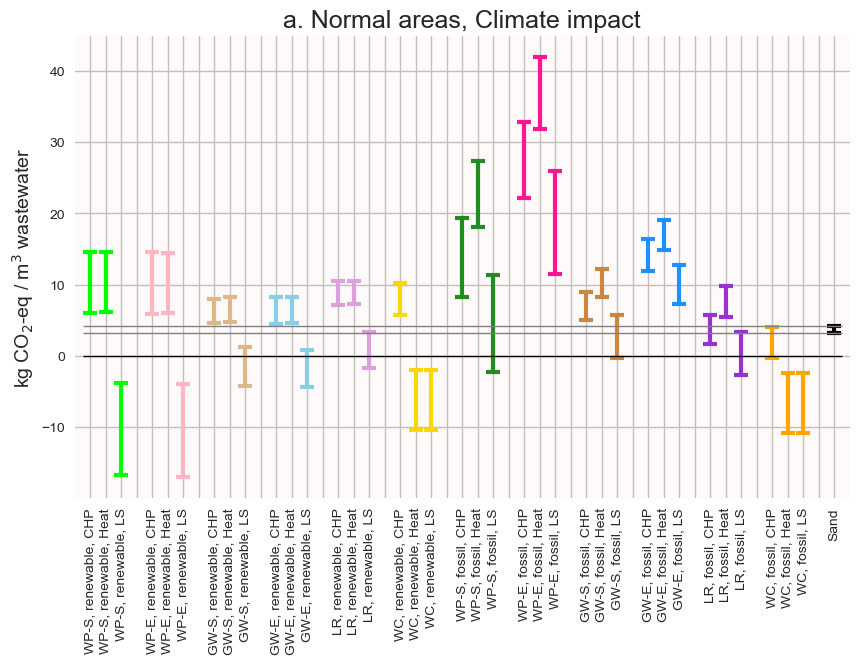

In [83]:
fig, ax = plt.subplots(figsize = (10,6))

# renewable

#ax.bar(1, BCBedNormalClimate_bc1andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andrenewableCHPmedian, x=1, yerr = BCBedNormalClimate_bc1andrenewableCHPerror, capsize=5,
  		  elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(2, BCBedNormalClimate_bc1andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andrenewableHeatmedian, x=2, yerr = BCBedNormalClimate_bc1andrenewableHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(3, BCBedNormalClimate_bc1andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andrenewableLSmedian, x=3, yerr = BCBedNormalClimate_bc1andrenewableLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lime')

#ax.bar(5, BCBedNormalClimate_bc2andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andrenewableCHPmedian, x=5, yerr = BCBedNormalClimate_bc2andrenewableCHPerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(6, BCBedNormalClimate_bc2andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andrenewableHeatmedian, x=6, yerr = BCBedNormalClimate_bc2andrenewableHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(7, BCBedNormalClimate_bc2andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andrenewableLSmedian, x=7, yerr = BCBedNormalClimate_bc2andrenewableLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')

#ax.bar(9, BCBedNormalClimate_bc3andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andrenewableCHPmedian, x=9, yerr = BCBedNormalClimate_bc3andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(10, BCBedNormalClimate_bc3andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andrenewableHeatmedian, x=10, yerr = BCBedNormalClimate_bc3andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(11, BCBedNormalClimate_bc3andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andrenewableLSmedian, x=11, yerr = BCBedNormalClimate_bc3andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')

#ax.bar(13, BCBedNormalClimate_bc4andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andrenewableCHPmedian, x=13, yerr = BCBedNormalClimate_bc4andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(14, BCBedNormalClimate_bc4andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andrenewableHeatmedian, x=14, yerr = BCBedNormalClimate_bc4andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(15, BCBedNormalClimate_bc4andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andrenewableLSmedian, x=15, yerr = BCBedNormalClimate_bc4andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')

#ax.bar(17, BCBedNormalClimate_bc5andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andrenewableCHPmedian, x=17, yerr = BCBedNormalClimate_bc5andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(18, BCBedNormalClimate_bc5andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andrenewableHeatmedian, x=18, yerr = BCBedNormalClimate_bc5andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(19, BCBedNormalClimate_bc5andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andrenewableLSmedian, x=19, yerr = BCBedNormalClimate_bc5andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')

#ax.bar(21, BCBedNormalClimate_bc7andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andrenewableCHPmedian, x=21, yerr = BCBedNormalClimate_bc7andrenewableCHPerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(22, BCBedNormalClimate_bc7andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andrenewableHeatmedian, x=22, yerr = BCBedNormalClimate_bc7andrenewableHeaterror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(23, BCBedNormalClimate_bc7andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andrenewableLSmedian, x=23, yerr = BCBedNormalClimate_bc7andrenewableLSerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')

# fossil

#ax.bar(25, BCBedNormalClimate_bc1andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andfossilCHPmedian, x=25, yerr = BCBedNormalClimate_bc1andfossilCHPerror, capsize=5,
  		  elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(26, BCBedNormalClimate_bc1andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andfossilHeatmedian, x=26, yerr = BCBedNormalClimate_bc1andfossilHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(27, BCBedNormalClimate_bc1andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andfossilLSmedian, x=27, yerr = BCBedNormalClimate_bc1andfossilLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(29, BCBedNormalClimate_bc2andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andfossilCHPmedian, x=29, yerr = BCBedNormalClimate_bc2andfossilCHPerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(30, BCBedNormalClimate_bc2andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andfossilHeatmedian, x=30, yerr = BCBedNormalClimate_bc2andfossilHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(31, BCBedNormalClimate_bc2andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andfossilLSmedian, x=31, yerr = BCBedNormalClimate_bc2andfossilLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')

#ax.bar(33, BCBedNormalClimate_bc3andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andfossilCHPmedian, x=33, yerr = BCBedNormalClimate_bc3andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(34, BCBedNormalClimate_bc3andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andfossilHeatmedian, x=34, yerr = BCBedNormalClimate_bc3andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(35, BCBedNormalClimate_bc3andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andfossilLSmedian, x=35, yerr = BCBedNormalClimate_bc3andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(37, BCBedNormalClimate_bc4andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andfossilCHPmedian, x=37, yerr = BCBedNormalClimate_bc4andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(38, BCBedNormalClimate_bc4andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andfossilHeatmedian, x=38, yerr = BCBedNormalClimate_bc4andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(39, BCBedNormalClimate_bc4andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andfossilLSmedian, x=39, yerr = BCBedNormalClimate_bc4andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')

#ax.bar(41, BCBedNormalClimate_bc5andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andfossilCHPmedian, x=41, yerr = BCBedNormalClimate_bc5andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(42, BCBedNormalClimate_bc5andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andfossilHeatmedian, x=42, yerr = BCBedNormalClimate_bc5andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(43, BCBedNormalClimate_bc5andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andfossilLSmedian, x=43, yerr = BCBedNormalClimate_bc5andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')

#ax.bar(45, BCBedNormalClimate_bc7andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andfossilCHPmedian, x=45, yerr = BCBedNormalClimate_bc7andfossilCHPerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(46, BCBedNormalClimate_bc7andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andfossilHeatmedian, x=46, yerr = BCBedNormalClimate_bc7andfossilHeaterror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(47, BCBedNormalClimate_bc7andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andfossilLSmedian, x=47, yerr = BCBedNormalClimate_bc7andfossilLSerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')

# sand

#ax.bar(49, Sand_Normal_medianClimate)
ax.errorbar(y=Sand_Normal_medianClimate, x=49, yerr = Sand_Normal_errorClimate, capsize=5,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('a. Normal areas, Climate impact', fontsize=18)
ax.set_xticks((range(1,50)))
ax.set_xticklabels(('WP-S, renewable, CHP','WP-S, renewable, Heat','WP-S, renewable, LS',
    '',
    'WP-E, renewable, CHP','WP-E, renewable, Heat','WP-E, renewable, LS',
    '',
    'GW-S, renewable, CHP','GW-S, renewable, Heat','GW-S, renewable, LS',
    '',
    'GW-E, renewable, CHP','GW-E, renewable, Heat','GW-E, renewable, LS',
    '',
    'LR, renewable, CHP','LR, renewable, Heat','LR, renewable, LS',
    '',
    'WC, renewable, CHP','WC, renewable, Heat','WC, renewable, LS',
    '',
    'WP-S, fossil, CHP', 'WP-S, fossil, Heat', 'WP-S, fossil, LS', 
    '',
    'WP-E, fossil, CHP', 'WP-E, fossil, Heat', 'WP-E, fossil, LS',
    '',
    'GW-S, fossil, CHP', 'GW-S, fossil, Heat', 'GW-S, fossil, LS',
    '',
    'GW-E, fossil, CHP', 'GW-E, fossil, Heat', 'GW-E, fossil, LS',
    '',
    'LR, fossil, CHP', 'LR, fossil, Heat','LR, fossil, LS', 
    '',
    'WC, fossil, CHP','WC, fossil, Heat','WC, fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)

ax.set_ylabel(climate_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=49.5, linewidth=1, color='black')
ax.set_xlim(0,50)

ax.set_facecolor('snow')
ax.grid(color='silver')

# ax.hlines(y=Sand_Normal_medianClimate, xmin=0, xmax=40, linewidth=1, color='r')
ax.hlines(y=Sand_Normal_medianClimate-Sand_Normal_errorClimate[0], xmin=0.5, xmax=49.5, linewidth=1, color='grey')
ax.hlines(y=Sand_Normal_medianClimate+Sand_Normal_errorClimate[1], xmin=0.5, xmax=49.5, linewidth=1, color='grey')

In [84]:
fig.savefig('climate_scenarios_normal', dpi=600, bbox_inches='tight')

##### climate - sensitive areas

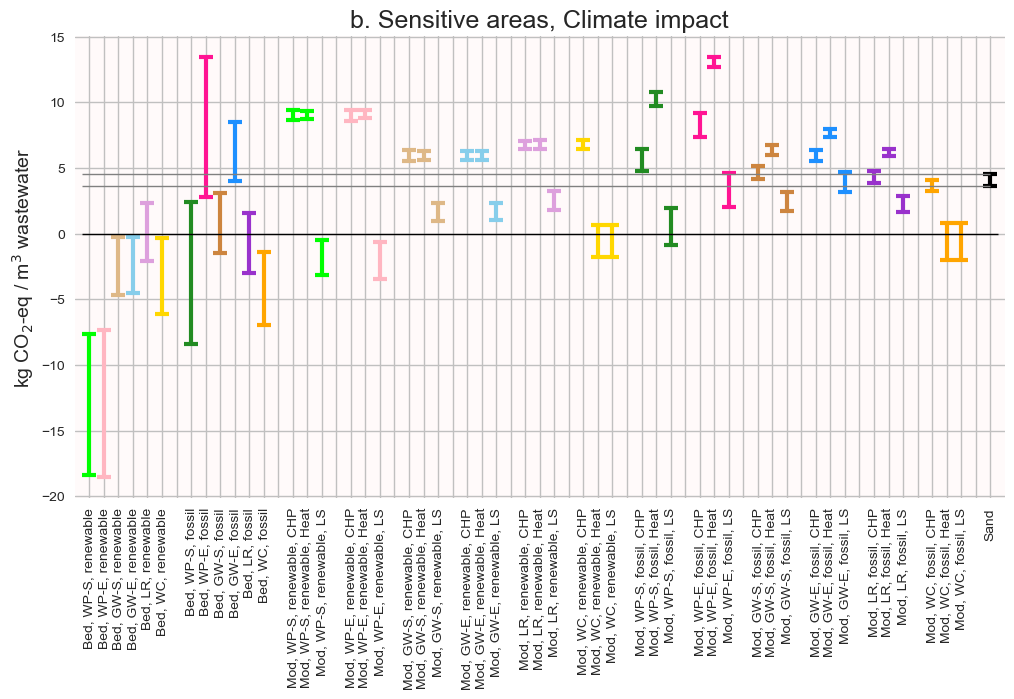

In [95]:
fig, ax = plt.subplots(figsize = (12,6))

# bed, renewable

#ax.bar(1, BCBedSensitiveClimate_bc1andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc1andrenewablemedian, x=1, yerr=BCBedSensitiveClimate_bc1andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(2, BCBedSensitiveClimate_bc2andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc2andrenewablemedian, x=2, yerr=BCBedSensitiveClimate_bc2andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(3, BCBedSensitiveClimate_bc3andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc3andrenewablemedian, x=3, yerr=BCBedSensitiveClimate_bc3andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(4, BCBedSensitiveClimate_bc4andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc4andrenewablemedian, x=4, yerr=BCBedSensitiveClimate_bc4andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(5, BCBedSensitiveClimate_bc5andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc5andrenewablemedian, x=5, yerr=BCBedSensitiveClimate_bc5andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(6, BCBedSensitiveClimate_bc7andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc7andrenewablemedian, x=6, yerr=BCBedSensitiveClimate_bc7andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')

# bed, fossil
#ax.bar(8, BCBedSensitiveClimate_bc1andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc1andfossilmedian, x=8, yerr=BCBedSensitiveClimate_bc1andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(9, BCBedSensitiveClimate_bc2andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc2andfossilmedian, x=9, yerr=BCBedSensitiveClimate_bc2andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(10, BCBedSensitiveClimate_bc3andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc3andfossilmedian, x=10, yerr=BCBedSensitiveClimate_bc3andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(11, BCBedSensitiveClimate_bc4andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc4andfossilmedian, x=11, yerr=BCBedSensitiveClimate_bc4andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(12, BCBedSensitiveClimate_bc5andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc5andfossilmedian, x=12, yerr=BCBedSensitiveClimate_bc5andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(13, BCBedSensitiveClimate_bc7andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc7andfossilmedian, x=13, yerr=BCBedSensitiveClimate_bc7andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')

## mod, renewable

#ax.bar(15, BCModSensitiveClimate_bc1andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andrenewableCHPmedian, x=15, yerr=BCModSensitiveClimate_bc1andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(16, BCModSensitiveClimate_bc1andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andrenewableHeatmedian, x=16, yerr=BCModSensitiveClimate_bc1andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(17, BCModSensitiveClimate_bc1andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andrenewableLSmedian, x=17, yerr=BCModSensitiveClimate_bc1andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')

#ax.bar(19, BCModSensitiveClimate_bc2andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andrenewableCHPmedian, x=19, yerr=BCModSensitiveClimate_bc2andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(20, BCModSensitiveClimate_bc2andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andrenewableHeatmedian, x=20, yerr=BCModSensitiveClimate_bc2andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(21, BCModSensitiveClimate_bc2andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andrenewableLSmedian, x=21, yerr=BCModSensitiveClimate_bc2andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')

#ax.bar(23, BCModSensitiveClimate_bc3andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andrenewableCHPmedian, x=23, yerr=BCModSensitiveClimate_bc3andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(24, BCModSensitiveClimate_bc3andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andrenewableHeatmedian, x=24, yerr=BCModSensitiveClimate_bc3andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(25, BCModSensitiveClimate_bc3andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andrenewableLSmedian, x=25, yerr=BCModSensitiveClimate_bc3andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')

#ax.bar(27, BCModSensitiveClimate_bc4andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andrenewableCHPmedian, x=27, yerr=BCModSensitiveClimate_bc4andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(28, BCModSensitiveClimate_bc4andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andrenewableHeatmedian, x=28, yerr=BCModSensitiveClimate_bc4andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(29, BCModSensitiveClimate_bc4andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andrenewableLSmedian, x=29, yerr=BCModSensitiveClimate_bc4andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')

#ax.bar(31, BCModSensitiveClimate_bc5andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andrenewableCHPmedian, x=31, yerr=BCModSensitiveClimate_bc5andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(32, BCModSensitiveClimate_bc5andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andrenewableHeatmedian, x=32, yerr=BCModSensitiveClimate_bc5andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(33, BCModSensitiveClimate_bc5andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andrenewableLSmedian, x=33, yerr=BCModSensitiveClimate_bc5andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')

#ax.bar(35, BCModSensitiveClimate_bc7andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andrenewableCHPmedian, x=35, yerr=BCModSensitiveClimate_bc7andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(36, BCModSensitiveClimate_bc7andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andrenewableHeatmedian, x=36, yerr=BCModSensitiveClimate_bc7andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(37, BCModSensitiveClimate_bc7andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andrenewableLSmedian, x=37, yerr=BCModSensitiveClimate_bc7andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')

## mod, fossil

#ax.bar(39, BCModSensitiveClimate_bc1andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andfossilCHPmedian, x=39, yerr=BCModSensitiveClimate_bc1andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(40, BCModSensitiveClimate_bc1andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andfossilHeatmedian, x=40, yerr=BCModSensitiveClimate_bc1andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(41, BCModSensitiveClimate_bc1andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andfossilLSmedian, x=41, yerr=BCModSensitiveClimate_bc1andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(43, BCModSensitiveClimate_bc2andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andfossilCHPmedian, x=43, yerr=BCModSensitiveClimate_bc2andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(44, BCModSensitiveClimate_bc2andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andfossilHeatmedian, x=44, yerr=BCModSensitiveClimate_bc2andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(45, BCModSensitiveClimate_bc2andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andfossilLSmedian, x=45, yerr=BCModSensitiveClimate_bc2andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')

#ax.bar(47, BCModSensitiveClimate_bc3andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andfossilCHPmedian, x=47, yerr=BCModSensitiveClimate_bc3andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(48, BCModSensitiveClimate_bc3andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andfossilHeatmedian, x=48, yerr=BCModSensitiveClimate_bc3andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(49, BCModSensitiveClimate_bc3andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andfossilLSmedian, x=49, yerr=BCModSensitiveClimate_bc3andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(51, BCModSensitiveClimate_bc4andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andfossilCHPmedian, x=51, yerr=BCModSensitiveClimate_bc4andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(52, BCModSensitiveClimate_bc4andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andfossilHeatmedian, x=52, yerr=BCModSensitiveClimate_bc4andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(53, BCModSensitiveClimate_bc4andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andfossilLSmedian, x=53, yerr=BCModSensitiveClimate_bc4andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')

#ax.bar(55, BCModSensitiveClimate_bc5andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andfossilCHPmedian, x=55, yerr=BCModSensitiveClimate_bc5andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(56, BCModSensitiveClimate_bc5andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andfossilHeatmedian, x=56, yerr=BCModSensitiveClimate_bc5andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(57, BCModSensitiveClimate_bc5andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andfossilLSmedian, x=57, yerr=BCModSensitiveClimate_bc5andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')

#ax.bar(59, BCModSensitiveClimate_bc7andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andfossilCHPmedian, x=59, yerr=BCModSensitiveClimate_bc7andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(60, BCModSensitiveClimate_bc7andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andfossilHeatmedian, x=60, yerr=BCModSensitiveClimate_bc7andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(61, BCModSensitiveClimate_bc7andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andfossilLSmedian, x=61, yerr=BCModSensitiveClimate_bc7andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')

## sand

#ax.bar(63, Sand_Sensitive_medianClimate)
ax.errorbar(y=Sand_Sensitive_medianClimate, x=63, yerr = Sand_Sensitive_errorClimate, capsize=5,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('b. Sensitive areas, Climate impact', fontsize=18)
ax.set_xticks((range(1,64)))
ax.set_xticklabels((
        'Bed, WP-S, renewable','Bed, WP-E, renewable','Bed, GW-S, renewable','Bed, GW-E, renewable',
    'Bed, LR, renewable','Bed, WC, renewable',
    '',
            'Bed, WP-S, fossil', 'Bed, WP-E, fossil', 'Bed, GW-S, fossil', 'Bed, GW-E, fossil', 'Bed, LR, fossil', 'Bed, WC, fossil',
    '',    
    'Mod, WP-S, renewable, CHP','Mod, WP-S, renewable, Heat','Mod, WP-S, renewable, LS',
    '',
    'Mod, WP-E, renewable, CHP','Mod, WP-E, renewable, Heat','Mod, WP-E, renewable, LS',
    '',
    'Mod, GW-S, renewable, CHP','Mod, GW-S, renewable, Heat','Mod, GW-S, renewable, LS',
    '',
    'Mod, GW-E, renewable, CHP','Mod, GW-E, renewable, Heat','Mod, GW-E, renewable, LS',
    '',
    'Mod, LR, renewable, CHP','Mod, LR, renewable, Heat','Mod, LR, renewable, LS',
    '',
    'Mod, WC, renewable, CHP','Mod, WC, renewable, Heat','Mod, WC, renewable, LS',
    '',
    'Mod, WP-S, fossil, CHP', 'Mod, WP-S, fossil, Heat', 'Mod, WP-S, fossil, LS', 
    '',
    'Mod, WP-E, fossil, CHP', 'Mod, WP-E, fossil, Heat', 'Mod, WP-E, fossil, LS',
    '',
    'Mod, GW-S, fossil, CHP', 'Mod, GW-S, fossil, Heat', 'Mod, GW-S, fossil, LS',
    '',
    'Mod, GW-E, fossil, CHP', 'Mod, GW-E, fossil, Heat', 'Mod, GW-E, fossil, LS',
    '',
    'Mod, LR, fossil, CHP', 'Mod, LR, fossil, Heat','Mod, LR, fossil, LS', 
    '',
    'Mod, WC, fossil, CHP','Mod, WC, fossil, Heat','Mod, WC, fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)
ax.set_ylabel(climate_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=63.5, linewidth=1, color='black')
#ax.vlines(x=14, ymin = -20, ymax=15, linewidth=0.5, color='black')
ax.set_xlim(0,64)
#ax.set_ylim(-20,15)

ax.set_facecolor('snow')
ax.grid(color='silver')

# ax.hlines(y=Sand_Sensitive_medianClimate, xmin=0, xmax=40, linewidth=2, color='r')
ax.hlines(y=Sand_Sensitive_medianClimate-Sand_Sensitive_errorClimate[0], xmin=0.5, xmax=63, linewidth=1, color='grey')
ax.hlines(y=Sand_Sensitive_medianClimate+Sand_Sensitive_errorClimate[1], xmin=0.5, xmax=63, linewidth=1, color='grey')

In [96]:
fig.savefig('climate_scenarios_sensitive', dpi=600, bbox_inches='tight')

##### eutroph - normal areas

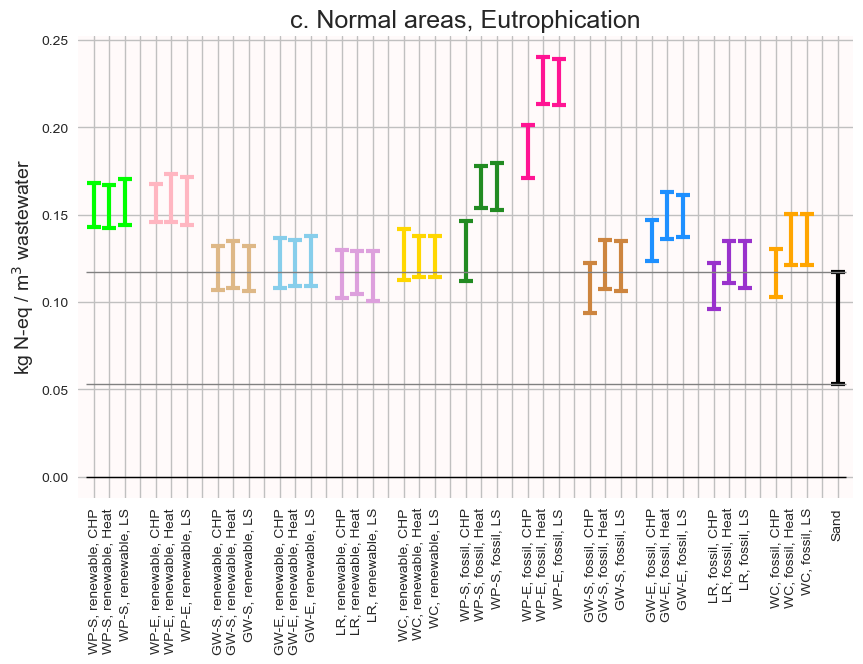

In [87]:
fig, ax = plt.subplots(figsize = (10,6))

# renewable

#ax.bar(1, BCBedNormalEutrophication_bc1andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andrenewableCHPmedian, x=1, yerr = BCBedNormalEutrophication_bc1andrenewableCHPerror, capsize=5,
  		  elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(2, BCBedNormalEutrophication_bc1andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andrenewableHeatmedian, x=2, yerr = BCBedNormalEutrophication_bc1andrenewableHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(3, BCBedNormalEutrophication_bc1andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andrenewableLSmedian, x=3, yerr = BCBedNormalEutrophication_bc1andrenewableLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lime')

#ax.bar(5, BCBedNormalEutrophication_bc2andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andrenewableCHPmedian, x=5, yerr = BCBedNormalEutrophication_bc2andrenewableCHPerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(6, BCBedNormalEutrophication_bc2andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andrenewableHeatmedian, x=6, yerr = BCBedNormalEutrophication_bc2andrenewableHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(7, BCBedNormalEutrophication_bc2andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andrenewableLSmedian, x=7, yerr = BCBedNormalEutrophication_bc2andrenewableLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')

#ax.bar(9, BCBedNormalEutrophication_bc3andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andrenewableCHPmedian, x=9, yerr = BCBedNormalEutrophication_bc3andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(10, BCBedNormalEutrophication_bc3andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andrenewableHeatmedian, x=10, yerr = BCBedNormalEutrophication_bc3andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(11, BCBedNormalEutrophication_bc3andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andrenewableLSmedian, x=11, yerr = BCBedNormalEutrophication_bc3andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')

#ax.bar(13, BCBedNormalEutrophication_bc4andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andrenewableCHPmedian, x=13, yerr = BCBedNormalEutrophication_bc4andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(14, BCBedNormalEutrophication_bc4andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andrenewableHeatmedian, x=14, yerr = BCBedNormalEutrophication_bc4andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(15, BCBedNormalEutrophication_bc4andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andrenewableLSmedian, x=15, yerr = BCBedNormalEutrophication_bc4andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')

#ax.bar(17, BCBedNormalEutrophication_bc5andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andrenewableCHPmedian, x=17, yerr = BCBedNormalEutrophication_bc5andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(18, BCBedNormalEutrophication_bc5andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andrenewableHeatmedian, x=18, yerr = BCBedNormalEutrophication_bc5andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(19, BCBedNormalEutrophication_bc5andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andrenewableLSmedian, x=19, yerr = BCBedNormalEutrophication_bc5andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')

#ax.bar(21, BCBedNormalEutrophication_bc7andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andrenewableCHPmedian, x=21, yerr = BCBedNormalEutrophication_bc7andrenewableCHPerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(22, BCBedNormalEutrophication_bc7andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andrenewableHeatmedian, x=22, yerr = BCBedNormalEutrophication_bc7andrenewableHeaterror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(23, BCBedNormalEutrophication_bc7andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andrenewableLSmedian, x=23, yerr = BCBedNormalEutrophication_bc7andrenewableLSerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')

# fossil

#ax.bar(25, BCBedNormalEutrophication_bc1andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andfossilCHPmedian, x=25, yerr = BCBedNormalEutrophication_bc1andfossilCHPerror, capsize=5,
  		  elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(26, BCBedNormalEutrophication_bc1andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andfossilHeatmedian, x=26, yerr = BCBedNormalEutrophication_bc1andfossilHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(27, BCBedNormalEutrophication_bc1andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andfossilLSmedian, x=27, yerr = BCBedNormalEutrophication_bc1andfossilLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(29, BCBedNormalEutrophication_bc2andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andfossilCHPmedian, x=29, yerr = BCBedNormalEutrophication_bc2andfossilCHPerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(30, BCBedNormalEutrophication_bc2andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andfossilHeatmedian, x=30, yerr = BCBedNormalEutrophication_bc2andfossilHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(31, BCBedNormalEutrophication_bc2andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andfossilLSmedian, x=31, yerr = BCBedNormalEutrophication_bc2andfossilLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')

#ax.bar(33, BCBedNormalEutrophication_bc3andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andfossilCHPmedian, x=33, yerr = BCBedNormalEutrophication_bc3andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(34, BCBedNormalEutrophication_bc3andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andfossilHeatmedian, x=34, yerr = BCBedNormalEutrophication_bc3andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(35, BCBedNormalEutrophication_bc3andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andfossilLSmedian, x=35, yerr = BCBedNormalEutrophication_bc3andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(37, BCBedNormalEutrophication_bc4andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andfossilCHPmedian, x=37, yerr = BCBedNormalEutrophication_bc4andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(38, BCBedNormalEutrophication_bc4andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andfossilHeatmedian, x=38, yerr = BCBedNormalEutrophication_bc4andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(39, BCBedNormalEutrophication_bc4andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andfossilLSmedian, x=39, yerr = BCBedNormalEutrophication_bc4andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')

#ax.bar(41, BCBedNormalEutrophication_bc5andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andfossilCHPmedian, x=41, yerr = BCBedNormalEutrophication_bc5andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(42, BCBedNormalEutrophication_bc5andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andfossilHeatmedian, x=42, yerr = BCBedNormalEutrophication_bc5andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(43, BCBedNormalEutrophication_bc5andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andfossilLSmedian, x=43, yerr = BCBedNormalEutrophication_bc5andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')

#ax.bar(45, BCBedNormalEutrophication_bc7andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andfossilCHPmedian, x=45, yerr = BCBedNormalEutrophication_bc7andfossilCHPerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(46, BCBedNormalEutrophication_bc7andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andfossilHeatmedian, x=46, yerr = BCBedNormalEutrophication_bc7andfossilHeaterror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(47, BCBedNormalEutrophication_bc7andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andfossilLSmedian, x=47, yerr = BCBedNormalEutrophication_bc7andfossilLSerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')

# sand

#ax.bar(49, Sand_Normal_medianEutroph)
ax.errorbar(y=Sand_Normal_medianEutroph, x=49, yerr = Sand_Normal_errorEutroph, capsize=5,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('c. Normal areas, Eutrophication', fontsize=18)
ax.set_xticks((range(1,50)))
ax.set_xticklabels(('WP-S, renewable, CHP','WP-S, renewable, Heat','WP-S, renewable, LS',
    '',
    'WP-E, renewable, CHP','WP-E, renewable, Heat','WP-E, renewable, LS',
    '',
    'GW-S, renewable, CHP','GW-S, renewable, Heat','GW-S, renewable, LS',
    '',
    'GW-E, renewable, CHP','GW-E, renewable, Heat','GW-E, renewable, LS',
    '',
    'LR, renewable, CHP','LR, renewable, Heat','LR, renewable, LS',
    '',
    'WC, renewable, CHP','WC, renewable, Heat','WC, renewable, LS',
    '',
    'WP-S, fossil, CHP', 'WP-S, fossil, Heat', 'WP-S, fossil, LS', 
    '',
    'WP-E, fossil, CHP', 'WP-E, fossil, Heat', 'WP-E, fossil, LS',
    '',
    'GW-S, fossil, CHP', 'GW-S, fossil, Heat', 'GW-S, fossil, LS',
    '',
    'GW-E, fossil, CHP', 'GW-E, fossil, Heat', 'GW-E, fossil, LS',
    '',
    'LR, fossil, CHP', 'LR, fossil, Heat','LR, fossil, LS', 
    '',
    'WC, fossil, CHP','WC, fossil, Heat','WC, fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)

ax.set_ylabel(eutroph_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=49.5, linewidth=1, color='black')
ax.set_xlim(0,50)

ax.set_facecolor('snow')
ax.grid(color='silver')

# ax.hlines(y=Sand_Normal_medianEutrophication, xmin=0, xmax=40, linewidth=1, color='r')
ax.hlines(y=Sand_Normal_medianEutroph-Sand_Normal_errorEutroph[0], xmin=0.5, xmax=49.5, linewidth=1, color='grey')
ax.hlines(y=Sand_Normal_medianEutroph+Sand_Normal_errorEutroph[1], xmin=0.5, xmax=49.5, linewidth=1, color='grey')

In [88]:
fig.savefig('eutroph_scenarios_normal', dpi=600, bbox_inches='tight')

##### eutroph - sensitive areas

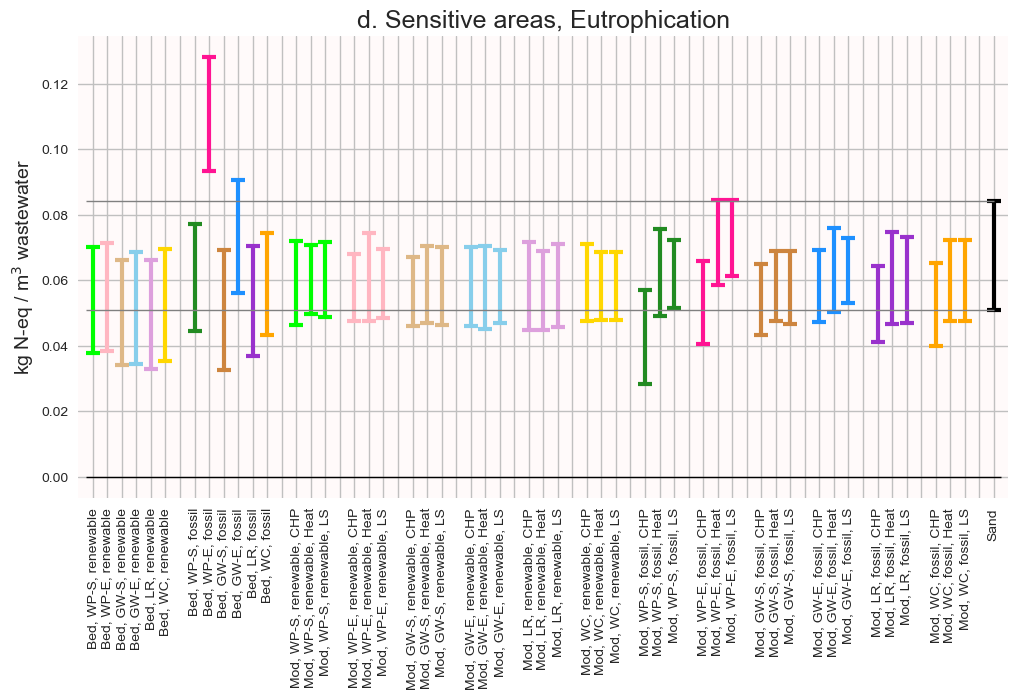

In [97]:
fig, ax = plt.subplots(figsize = (12,6))

# bed, renewable

#ax.bar(1, BCBedSensitiveEutrophication_bc1andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc1andrenewablemedian, x=1, yerr=BCBedSensitiveEutrophication_bc1andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(2, BCBedSensitiveEutrophication_bc2andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc2andrenewablemedian, x=2, yerr=BCBedSensitiveEutrophication_bc2andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(3, BCBedSensitiveEutrophication_bc3andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc3andrenewablemedian, x=3, yerr=BCBedSensitiveEutrophication_bc3andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(4, BCBedSensitiveEutrophication_bc4andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc4andrenewablemedian, x=4, yerr=BCBedSensitiveEutrophication_bc4andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(5, BCBedSensitiveEutrophication_bc5andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc5andrenewablemedian, x=5, yerr=BCBedSensitiveEutrophication_bc5andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(6, BCBedSensitiveEutrophication_bc7andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc7andrenewablemedian, x=6, yerr=BCBedSensitiveEutrophication_bc7andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')

# bed, fossil
#ax.bar(8, BCBedSensitiveEutrophication_bc1andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc1andfossilmedian, x=8, yerr=BCBedSensitiveEutrophication_bc1andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(9, BCBedSensitiveEutrophication_bc2andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc2andfossilmedian, x=9, yerr=BCBedSensitiveEutrophication_bc2andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(10, BCBedSensitiveEutrophication_bc3andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc3andfossilmedian, x=10, yerr=BCBedSensitiveEutrophication_bc3andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(11, BCBedSensitiveEutrophication_bc4andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc4andfossilmedian, x=11, yerr=BCBedSensitiveEutrophication_bc4andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(12, BCBedSensitiveEutrophication_bc5andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc5andfossilmedian, x=12, yerr=BCBedSensitiveEutrophication_bc5andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(13, BCBedSensitiveEutrophication_bc7andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc7andfossilmedian, x=13, yerr=BCBedSensitiveEutrophication_bc7andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')

## mod, renewable

#ax.bar(15, BCModSensitiveEutrophication_bc1andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andrenewableCHPmedian, x=15, yerr=BCModSensitiveEutrophication_bc1andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(16, BCModSensitiveEutrophication_bc1andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andrenewableHeatmedian, x=16, yerr=BCModSensitiveEutrophication_bc1andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(17, BCModSensitiveEutrophication_bc1andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andrenewableLSmedian, x=17, yerr=BCModSensitiveEutrophication_bc1andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')

#ax.bar(19, BCModSensitiveEutrophication_bc2andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andrenewableCHPmedian, x=19, yerr=BCModSensitiveEutrophication_bc2andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(20, BCModSensitiveEutrophication_bc2andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andrenewableHeatmedian, x=20, yerr=BCModSensitiveEutrophication_bc2andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(21, BCModSensitiveEutrophication_bc2andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andrenewableLSmedian, x=21, yerr=BCModSensitiveEutrophication_bc2andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')

#ax.bar(23, BCModSensitiveEutrophication_bc3andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andrenewableCHPmedian, x=23, yerr=BCModSensitiveEutrophication_bc3andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(24, BCModSensitiveEutrophication_bc3andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andrenewableHeatmedian, x=24, yerr=BCModSensitiveEutrophication_bc3andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(25, BCModSensitiveEutrophication_bc3andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andrenewableLSmedian, x=25, yerr=BCModSensitiveEutrophication_bc3andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')

#ax.bar(27, BCModSensitiveEutrophication_bc4andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andrenewableCHPmedian, x=27, yerr=BCModSensitiveEutrophication_bc4andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(28, BCModSensitiveEutrophication_bc4andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andrenewableHeatmedian, x=28, yerr=BCModSensitiveEutrophication_bc4andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(29, BCModSensitiveEutrophication_bc4andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andrenewableLSmedian, x=29, yerr=BCModSensitiveEutrophication_bc4andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')

#ax.bar(31, BCModSensitiveEutrophication_bc5andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andrenewableCHPmedian, x=31, yerr=BCModSensitiveEutrophication_bc5andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(32, BCModSensitiveEutrophication_bc5andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andrenewableHeatmedian, x=32, yerr=BCModSensitiveEutrophication_bc5andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(33, BCModSensitiveEutrophication_bc5andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andrenewableLSmedian, x=33, yerr=BCModSensitiveEutrophication_bc5andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')

#ax.bar(35, BCModSensitiveEutrophication_bc7andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andrenewableCHPmedian, x=35, yerr=BCModSensitiveEutrophication_bc7andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(36, BCModSensitiveEutrophication_bc7andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andrenewableHeatmedian, x=36, yerr=BCModSensitiveEutrophication_bc7andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(37, BCModSensitiveEutrophication_bc7andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andrenewableLSmedian, x=37, yerr=BCModSensitiveEutrophication_bc7andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')

## mod, fossil

#ax.bar(39, BCModSensitiveEutrophication_bc1andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andfossilCHPmedian, x=39, yerr=BCModSensitiveEutrophication_bc1andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(40, BCModSensitiveEutrophication_bc1andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andfossilHeatmedian, x=40, yerr=BCModSensitiveEutrophication_bc1andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(41, BCModSensitiveEutrophication_bc1andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andfossilLSmedian, x=41, yerr=BCModSensitiveEutrophication_bc1andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(43, BCModSensitiveEutrophication_bc2andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andfossilCHPmedian, x=43, yerr=BCModSensitiveEutrophication_bc2andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(44, BCModSensitiveEutrophication_bc2andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andfossilHeatmedian, x=44, yerr=BCModSensitiveEutrophication_bc2andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(45, BCModSensitiveEutrophication_bc2andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andfossilLSmedian, x=45, yerr=BCModSensitiveEutrophication_bc2andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')

#ax.bar(47, BCModSensitiveEutrophication_bc3andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andfossilCHPmedian, x=47, yerr=BCModSensitiveEutrophication_bc3andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(48, BCModSensitiveEutrophication_bc3andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andfossilHeatmedian, x=48, yerr=BCModSensitiveEutrophication_bc3andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(49, BCModSensitiveEutrophication_bc3andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andfossilLSmedian, x=49, yerr=BCModSensitiveEutrophication_bc3andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(51, BCModSensitiveEutrophication_bc4andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andfossilCHPmedian, x=51, yerr=BCModSensitiveEutrophication_bc4andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(52, BCModSensitiveEutrophication_bc4andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andfossilHeatmedian, x=52, yerr=BCModSensitiveEutrophication_bc4andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(53, BCModSensitiveEutrophication_bc4andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andfossilLSmedian, x=53, yerr=BCModSensitiveEutrophication_bc4andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')

#ax.bar(55, BCModSensitiveEutrophication_bc5andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andfossilCHPmedian, x=55, yerr=BCModSensitiveEutrophication_bc5andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(56, BCModSensitiveEutrophication_bc5andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andfossilHeatmedian, x=56, yerr=BCModSensitiveEutrophication_bc5andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(57, BCModSensitiveEutrophication_bc5andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andfossilLSmedian, x=57, yerr=BCModSensitiveEutrophication_bc5andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')

#ax.bar(59, BCModSensitiveEutrophication_bc7andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andfossilCHPmedian, x=59, yerr=BCModSensitiveEutrophication_bc7andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(60, BCModSensitiveEutrophication_bc7andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andfossilHeatmedian, x=60, yerr=BCModSensitiveEutrophication_bc7andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(61, BCModSensitiveEutrophication_bc7andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andfossilLSmedian, x=61, yerr=BCModSensitiveEutrophication_bc7andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')

## sand

#ax.bar(63, Sand_Sensitive_medianEutroph)
ax.errorbar(y=Sand_Sensitive_medianEutroph, x=63, yerr = Sand_Sensitive_errorEutroph, capsize=5,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('d. Sensitive areas, Eutrophication', fontsize=18)
ax.set_xticks((range(1,64)))
ax.set_xticklabels(('Bed, WP-S, renewable','Bed, WP-E, renewable','Bed, GW-S, renewable','Bed, GW-E, renewable',
    'Bed, LR, renewable','Bed, WC, renewable',
    '',
                            'Bed, WP-S, fossil', 'Bed, WP-E, fossil', 'Bed, GW-S, fossil', 'Bed, GW-E, fossil', 'Bed, LR, fossil', 'Bed, WC, fossil',
    '',
    'Mod, WP-S, renewable, CHP','Mod, WP-S, renewable, Heat','Mod, WP-S, renewable, LS',
    '',
    'Mod, WP-E, renewable, CHP','Mod, WP-E, renewable, Heat','Mod, WP-E, renewable, LS',
    '',
    'Mod, GW-S, renewable, CHP','Mod, GW-S, renewable, Heat','Mod, GW-S, renewable, LS',
    '',
    'Mod, GW-E, renewable, CHP','Mod, GW-E, renewable, Heat','Mod, GW-E, renewable, LS',
    '',
    'Mod, LR, renewable, CHP','Mod, LR, renewable, Heat','Mod, LR, renewable, LS',
    '',
    'Mod, WC, renewable, CHP','Mod, WC, renewable, Heat','Mod, WC, renewable, LS',
    '',
    'Mod, WP-S, fossil, CHP', 'Mod, WP-S, fossil, Heat', 'Mod, WP-S, fossil, LS', 
    '',
    'Mod, WP-E, fossil, CHP', 'Mod, WP-E, fossil, Heat', 'Mod, WP-E, fossil, LS',
    '',
    'Mod, GW-S, fossil, CHP', 'Mod, GW-S, fossil, Heat', 'Mod, GW-S, fossil, LS',
    '',
    'Mod, GW-E, fossil, CHP', 'Mod, GW-E, fossil, Heat', 'Mod, GW-E, fossil, LS',
    '',
    'Mod, LR, fossil, CHP', 'Mod, LR, fossil, Heat','Mod, LR, fossil, LS', 
    '',
    'Mod, WC, fossil, CHP','Mod, WC, fossil, Heat','Mod, WC, fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)
ax.set_ylabel(eutroph_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=63.5, linewidth=1, color='black')
ax.set_xlim(0,64)

ax.set_facecolor('snow')
ax.grid(color='silver')

# ax.hlines(y=Sand_Sensitive_medianEutroph, xmin=0, xmax=40, linewidth=2, color='r')
ax.hlines(y=Sand_Sensitive_medianEutroph-Sand_Sensitive_errorEutroph[0], xmin=0.5, xmax=63, linewidth=1, color='grey')
ax.hlines(y=Sand_Sensitive_medianEutroph+Sand_Sensitive_errorEutroph[1], xmin=0.5, xmax=63, linewidth=1, color='grey')

In [98]:
fig.savefig('eutroph_scenarios_sensitive', dpi=600, bbox_inches='tight')

##### acidification - normal areas

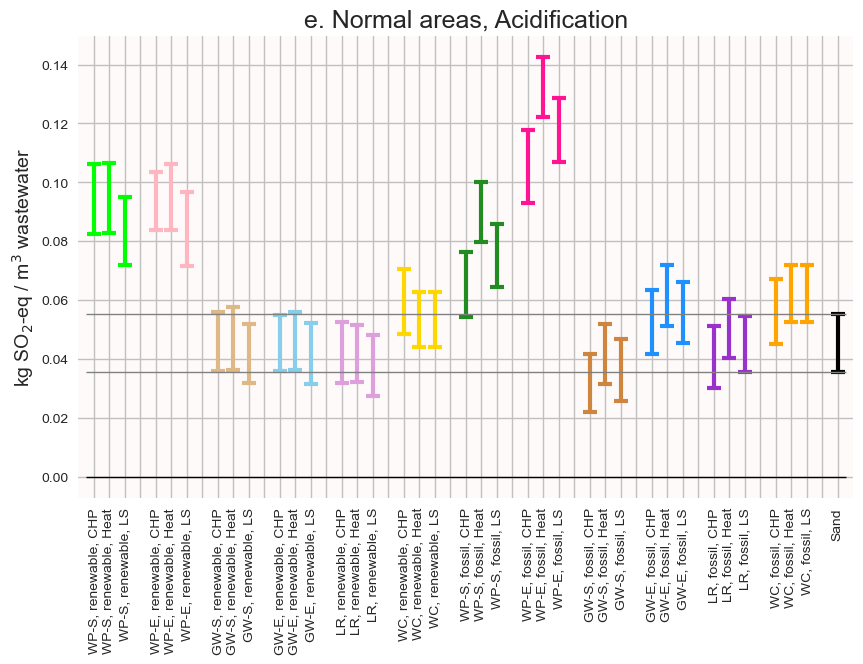

In [91]:
fig, ax = plt.subplots(figsize = (10,6))

# fossil

#ax.bar(1, BCBedNormalAcidification_bc1andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andrenewableCHPmedian, x=1, yerr = BCBedNormalAcidification_bc1andrenewableCHPerror, capsize=5,
  		  elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(2, BCBedNormalAcidification_bc1andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andrenewableHeatmedian, x=2, yerr = BCBedNormalAcidification_bc1andrenewableHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(3, BCBedNormalAcidification_bc1andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andrenewableLSmedian, x=3, yerr = BCBedNormalAcidification_bc1andrenewableLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lime')

#ax.bar(5, BCBedNormalAcidification_bc2andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andrenewableCHPmedian, x=5, yerr = BCBedNormalAcidification_bc2andrenewableCHPerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(6, BCBedNormalAcidification_bc2andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andrenewableHeatmedian, x=6, yerr = BCBedNormalAcidification_bc2andrenewableHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(7, BCBedNormalAcidification_bc2andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andrenewableLSmedian, x=7, yerr = BCBedNormalAcidification_bc2andrenewableLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='lightpink')

#ax.bar(9, BCBedNormalAcidification_bc3andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andrenewableCHPmedian, x=9, yerr = BCBedNormalAcidification_bc3andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(10, BCBedNormalAcidification_bc3andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andrenewableHeatmedian, x=10, yerr = BCBedNormalAcidification_bc3andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(11, BCBedNormalAcidification_bc3andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andrenewableLSmedian, x=11, yerr = BCBedNormalAcidification_bc3andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='burlywood')

#ax.bar(13, BCBedNormalAcidification_bc4andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andrenewableCHPmedian, x=13, yerr = BCBedNormalAcidification_bc4andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(14, BCBedNormalAcidification_bc4andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andrenewableHeatmedian, x=14, yerr = BCBedNormalAcidification_bc4andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(15, BCBedNormalAcidification_bc4andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andrenewableLSmedian, x=15, yerr = BCBedNormalAcidification_bc4andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='skyblue')

#ax.bar(17, BCBedNormalAcidification_bc5andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andrenewableCHPmedian, x=17, yerr = BCBedNormalAcidification_bc5andrenewableCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(18, BCBedNormalAcidification_bc5andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andrenewableHeatmedian, x=18, yerr = BCBedNormalAcidification_bc5andrenewableHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(19, BCBedNormalAcidification_bc5andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andrenewableLSmedian, x=19, yerr = BCBedNormalAcidification_bc5andrenewableLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='plum')

#ax.bar(21, BCBedNormalAcidification_bc7andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andrenewableCHPmedian, x=21, yerr = BCBedNormalAcidification_bc7andrenewableCHPerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(22, BCBedNormalAcidification_bc7andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andrenewableHeatmedian, x=22, yerr = BCBedNormalAcidification_bc7andrenewableHeaterror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(23, BCBedNormalAcidification_bc7andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andrenewableLSmedian, x=23, yerr = BCBedNormalAcidification_bc7andrenewableLSerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='gold')

# fossil

#ax.bar(25, BCBedNormalAcidification_bc1andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andfossilCHPmedian, x=25, yerr = BCBedNormalAcidification_bc1andfossilCHPerror, capsize=5,
  		  elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(26, BCBedNormalAcidification_bc1andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andfossilHeatmedian, x=26, yerr = BCBedNormalAcidification_bc1andfossilHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(27, BCBedNormalAcidification_bc1andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andfossilLSmedian, x=27, yerr = BCBedNormalAcidification_bc1andfossilLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(29, BCBedNormalAcidification_bc2andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andfossilCHPmedian, x=29, yerr = BCBedNormalAcidification_bc2andfossilCHPerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(30, BCBedNormalAcidification_bc2andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andfossilHeatmedian, x=30, yerr = BCBedNormalAcidification_bc2andfossilHeaterror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(31, BCBedNormalAcidification_bc2andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andfossilLSmedian, x=31, yerr = BCBedNormalAcidification_bc2andfossilLSerror, capsize=5,
  	  elinewidth=3, markeredgewidth=3, color='deeppink')

#ax.bar(33, BCBedNormalAcidification_bc3andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andfossilCHPmedian, x=33, yerr = BCBedNormalAcidification_bc3andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(34, BCBedNormalAcidification_bc3andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andfossilHeatmedian, x=34, yerr = BCBedNormalAcidification_bc3andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(35, BCBedNormalAcidification_bc3andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andfossilLSmedian, x=35, yerr = BCBedNormalAcidification_bc3andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(37, BCBedNormalAcidification_bc4andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andfossilCHPmedian, x=37, yerr = BCBedNormalAcidification_bc4andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(38, BCBedNormalAcidification_bc4andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andfossilHeatmedian, x=38, yerr = BCBedNormalAcidification_bc4andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(39, BCBedNormalAcidification_bc4andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andfossilLSmedian, x=39, yerr = BCBedNormalAcidification_bc4andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='dodgerblue')

#ax.bar(41, BCBedNormalAcidification_bc5andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andfossilCHPmedian, x=41, yerr = BCBedNormalAcidification_bc5andfossilCHPerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(42, BCBedNormalAcidification_bc5andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andfossilHeatmedian, x=42, yerr = BCBedNormalAcidification_bc5andfossilHeaterror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(43, BCBedNormalAcidification_bc5andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andfossilLSmedian, x=43, yerr = BCBedNormalAcidification_bc5andfossilLSerror, capsize=5,
        elinewidth=3, markeredgewidth=3, color='darkorchid')

#ax.bar(45, BCBedNormalAcidification_bc7andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andfossilCHPmedian, x=45, yerr = BCBedNormalAcidification_bc7andfossilCHPerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(46, BCBedNormalAcidification_bc7andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andfossilHeatmedian, x=46, yerr = BCBedNormalAcidification_bc7andfossilHeaterror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(47, BCBedNormalAcidification_bc7andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andfossilLSmedian, x=47, yerr = BCBedNormalAcidification_bc7andfossilLSerror, capsize=5,
    	elinewidth=3, markeredgewidth=3, color='orange')

# sand

#ax.bar(49, Sand_Normal_medianAcid)
ax.errorbar(y=Sand_Normal_medianAcid, x=49, yerr = Sand_Normal_errorAcid, capsize=5,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('e. Normal areas, Acidification', fontsize=18)
ax.set_xticks((range(1,50)))
ax.set_xticklabels(('WP-S, renewable, CHP','WP-S, renewable, Heat','WP-S, renewable, LS',
    '',
    'WP-E, renewable, CHP','WP-E, renewable, Heat','WP-E, renewable, LS',
    '',
    'GW-S, renewable, CHP','GW-S, renewable, Heat','GW-S, renewable, LS',
    '',
    'GW-E, renewable, CHP','GW-E, renewable, Heat','GW-E, renewable, LS',
    '',
    'LR, renewable, CHP','LR, renewable, Heat','LR, renewable, LS',
    '',
    'WC, renewable, CHP','WC, renewable, Heat','WC, renewable, LS',
    '',
    'WP-S, fossil, CHP', 'WP-S, fossil, Heat', 'WP-S, fossil, LS', 
    '',
    'WP-E, fossil, CHP', 'WP-E, fossil, Heat', 'WP-E, fossil, LS',
    '',
    'GW-S, fossil, CHP', 'GW-S, fossil, Heat', 'GW-S, fossil, LS',
    '',
    'GW-E, fossil, CHP', 'GW-E, fossil, Heat', 'GW-E, fossil, LS',
    '',
    'LR, fossil, CHP', 'LR, fossil, Heat','LR, fossil, LS', 
    '',
    'WC, fossil, CHP','WC, fossil, Heat','WC, fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)

ax.set_ylabel(acid_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=49.5, linewidth=1, color='black')
ax.set_xlim(0,50)

ax.set_facecolor('snow')
ax.grid(color='silver')

# ax.hlines(y=Sand_Normal_medianAcidification, xmin=0, xmax=40, linewidth=1, color='r')
ax.hlines(y=Sand_Normal_medianAcid-Sand_Normal_errorAcid[0], xmin=0.5, xmax=49.5, linewidth=1, color='grey')
ax.hlines(y=Sand_Normal_medianAcid+Sand_Normal_errorAcid[1], xmin=0.5, xmax=49.5, linewidth=1, color='grey')

In [92]:
fig.savefig('acid_scenarios_normal', dpi=600, bbox_inches='tight')

##### acidification - sensitive areas

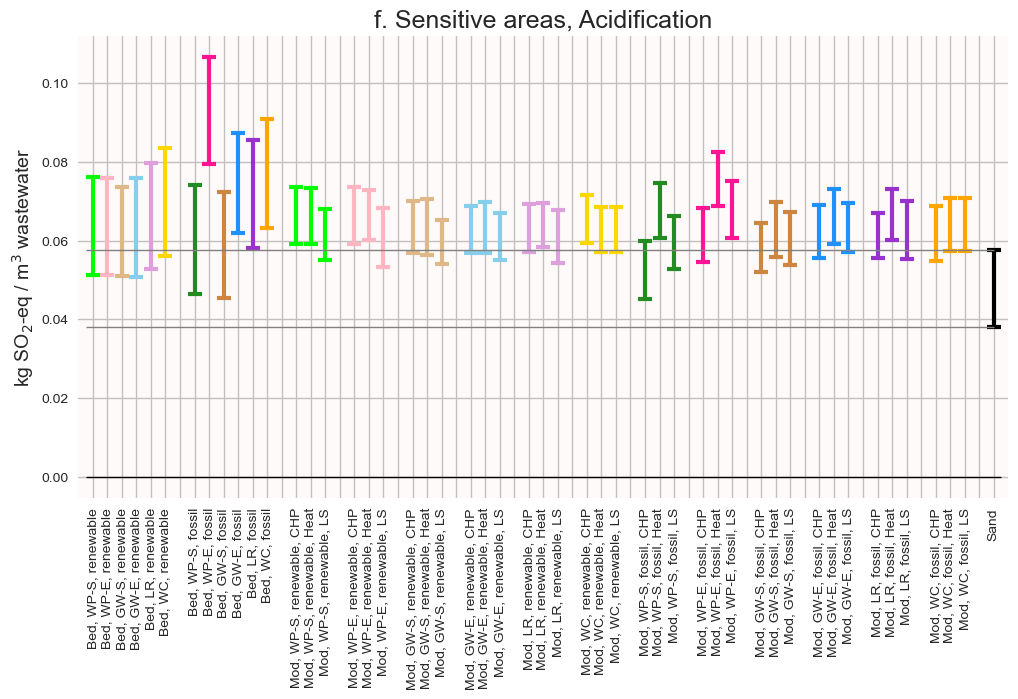

In [99]:
fig, ax = plt.subplots(figsize = (12,6))

# bed, renewable

#ax.bar(1, BCBedSensitiveAcidification_bc1andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc1andrenewablemedian, x=1, yerr=BCBedSensitiveAcidification_bc1andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(2, BCBedSensitiveAcidification_bc2andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc2andrenewablemedian, x=2, yerr=BCBedSensitiveAcidification_bc2andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(3, BCBedSensitiveAcidification_bc3andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc3andrenewablemedian, x=3, yerr=BCBedSensitiveAcidification_bc3andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(4, BCBedSensitiveAcidification_bc4andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc4andrenewablemedian, x=4, yerr=BCBedSensitiveAcidification_bc4andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(5, BCBedSensitiveAcidification_bc5andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc5andrenewablemedian, x=5, yerr=BCBedSensitiveAcidification_bc5andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(6, BCBedSensitiveAcidification_bc7andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc7andrenewablemedian, x=6, yerr=BCBedSensitiveAcidification_bc7andrenewableerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')

# bed, fossil
#ax.bar(8, BCBedSensitiveAcidification_bc1andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc1andfossilmedian, x=8, yerr=BCBedSensitiveAcidification_bc1andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(9, BCBedSensitiveAcidification_bc2andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc2andfossilmedian, x=9, yerr=BCBedSensitiveAcidification_bc2andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(10, BCBedSensitiveAcidification_bc3andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc3andfossilmedian, x=10, yerr=BCBedSensitiveAcidification_bc3andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(11, BCBedSensitiveAcidification_bc4andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc4andfossilmedian, x=11, yerr=BCBedSensitiveAcidification_bc4andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(12, BCBedSensitiveAcidification_bc5andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc5andfossilmedian, x=12, yerr=BCBedSensitiveAcidification_bc5andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(13, BCBedSensitiveAcidification_bc7andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc7andfossilmedian, x=13, yerr=BCBedSensitiveAcidification_bc7andfossilerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')

## mod, renewable

#ax.bar(15, BCModSensitiveAcidification_bc1andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andrenewableCHPmedian, x=15, yerr=BCModSensitiveAcidification_bc1andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(16, BCModSensitiveAcidification_bc1andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andrenewableHeatmedian, x=16, yerr=BCModSensitiveAcidification_bc1andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')
#ax.bar(17, BCModSensitiveAcidification_bc1andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andrenewableLSmedian, x=17, yerr=BCModSensitiveAcidification_bc1andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lime')

#ax.bar(19, BCModSensitiveAcidification_bc2andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andrenewableCHPmedian, x=19, yerr=BCModSensitiveAcidification_bc2andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(20, BCModSensitiveAcidification_bc2andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andrenewableHeatmedian, x=20, yerr=BCModSensitiveAcidification_bc2andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')
#ax.bar(21, BCModSensitiveAcidification_bc2andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andrenewableLSmedian, x=21, yerr=BCModSensitiveAcidification_bc2andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='lightpink')

#ax.bar(23, BCModSensitiveAcidification_bc3andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andrenewableCHPmedian, x=23, yerr=BCModSensitiveAcidification_bc3andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(24, BCModSensitiveAcidification_bc3andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andrenewableHeatmedian, x=24, yerr=BCModSensitiveAcidification_bc3andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')
#ax.bar(25, BCModSensitiveAcidification_bc3andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andrenewableLSmedian, x=25, yerr=BCModSensitiveAcidification_bc3andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='burlywood')

#ax.bar(27, BCModSensitiveAcidification_bc4andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andrenewableCHPmedian, x=27, yerr=BCModSensitiveAcidification_bc4andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(28, BCModSensitiveAcidification_bc4andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andrenewableHeatmedian, x=28, yerr=BCModSensitiveAcidification_bc4andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')
#ax.bar(29, BCModSensitiveAcidification_bc4andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andrenewableLSmedian, x=29, yerr=BCModSensitiveAcidification_bc4andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='skyblue')

#ax.bar(31, BCModSensitiveAcidification_bc5andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andrenewableCHPmedian, x=31, yerr=BCModSensitiveAcidification_bc5andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(32, BCModSensitiveAcidification_bc5andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andrenewableHeatmedian, x=32, yerr=BCModSensitiveAcidification_bc5andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')
#ax.bar(33, BCModSensitiveAcidification_bc5andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andrenewableLSmedian, x=33, yerr=BCModSensitiveAcidification_bc5andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='plum')

#ax.bar(35, BCModSensitiveAcidification_bc7andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andrenewableCHPmedian, x=35, yerr=BCModSensitiveAcidification_bc7andrenewableCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(36, BCModSensitiveAcidification_bc7andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andrenewableHeatmedian, x=36, yerr=BCModSensitiveAcidification_bc7andrenewableHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')
#ax.bar(37, BCModSensitiveAcidification_bc7andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andrenewableLSmedian, x=37, yerr=BCModSensitiveAcidification_bc7andrenewableLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='gold')

## mod, fossil

#ax.bar(39, BCModSensitiveAcidification_bc1andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andfossilCHPmedian, x=39, yerr=BCModSensitiveAcidification_bc1andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(40, BCModSensitiveAcidification_bc1andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andfossilHeatmedian, x=40, yerr=BCModSensitiveAcidification_bc1andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')
#ax.bar(41, BCModSensitiveAcidification_bc1andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andfossilLSmedian, x=41, yerr=BCModSensitiveAcidification_bc1andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='forestgreen')

#ax.bar(43, BCModSensitiveAcidification_bc2andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andfossilCHPmedian, x=43, yerr=BCModSensitiveAcidification_bc2andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(44, BCModSensitiveAcidification_bc2andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andfossilHeatmedian, x=44, yerr=BCModSensitiveAcidification_bc2andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')
#ax.bar(45, BCModSensitiveAcidification_bc2andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andfossilLSmedian, x=45, yerr=BCModSensitiveAcidification_bc2andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='deeppink')

#ax.bar(47, BCModSensitiveAcidification_bc3andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andfossilCHPmedian, x=47, yerr=BCModSensitiveAcidification_bc3andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(48, BCModSensitiveAcidification_bc3andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andfossilHeatmedian, x=48, yerr=BCModSensitiveAcidification_bc3andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')
#ax.bar(49, BCModSensitiveAcidification_bc3andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andfossilLSmedian, x=49, yerr=BCModSensitiveAcidification_bc3andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='peru')

#ax.bar(51, BCModSensitiveAcidification_bc4andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andfossilCHPmedian, x=51, yerr=BCModSensitiveAcidification_bc4andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(52, BCModSensitiveAcidification_bc4andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andfossilHeatmedian, x=52, yerr=BCModSensitiveAcidification_bc4andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')
#ax.bar(53, BCModSensitiveAcidification_bc4andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andfossilLSmedian, x=53, yerr=BCModSensitiveAcidification_bc4andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='dodgerblue')

#ax.bar(55, BCModSensitiveAcidification_bc5andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andfossilCHPmedian, x=55, yerr=BCModSensitiveAcidification_bc5andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(56, BCModSensitiveAcidification_bc5andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andfossilHeatmedian, x=56, yerr=BCModSensitiveAcidification_bc5andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')
#ax.bar(57, BCModSensitiveAcidification_bc5andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andfossilLSmedian, x=57, yerr=BCModSensitiveAcidification_bc5andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='darkorchid')

#ax.bar(59, BCModSensitiveAcidification_bc7andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andfossilCHPmedian, x=59, yerr=BCModSensitiveAcidification_bc7andfossilCHPerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(60, BCModSensitiveAcidification_bc7andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andfossilHeatmedian, x=60, yerr=BCModSensitiveAcidification_bc7andfossilHeaterror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')
#ax.bar(61, BCModSensitiveAcidification_bc7andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andfossilLSmedian, x=61, yerr=BCModSensitiveAcidification_bc7andfossilLSerror, capsize=5,
            elinewidth=3, markeredgewidth=3, color='orange')

## sand

#ax.bar(63, Sand_Sensitive_medianAcid)
ax.errorbar(y=Sand_Sensitive_medianAcid, x=63, yerr = Sand_Sensitive_errorAcid, capsize=5,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('f. Sensitive areas, Acidification', fontsize=18)
ax.set_xticks((range(1,64)))
ax.set_xticklabels((
    'Bed, WP-S, renewable','Bed, WP-E, renewable','Bed, GW-S, renewable','Bed, GW-E, renewable',
    'Bed, LR, renewable','Bed, WC, renewable',
    '',
            'Bed, WP-S, fossil', 'Bed, WP-E, fossil', 'Bed, GW-S, fossil', 'Bed, GW-E, fossil', 'Bed, LR, fossil', 'Bed, WC, fossil',
    '',
    'Mod, WP-S, renewable, CHP','Mod, WP-S, renewable, Heat','Mod, WP-S, renewable, LS',
    '',
    'Mod, WP-E, renewable, CHP','Mod, WP-E, renewable, Heat','Mod, WP-E, renewable, LS',
    '',
    'Mod, GW-S, renewable, CHP','Mod, GW-S, renewable, Heat','Mod, GW-S, renewable, LS',
    '',
    'Mod, GW-E, renewable, CHP','Mod, GW-E, renewable, Heat','Mod, GW-E, renewable, LS',
    '',
    'Mod, LR, renewable, CHP','Mod, LR, renewable, Heat','Mod, LR, renewable, LS',
    '',
    'Mod, WC, renewable, CHP','Mod, WC, renewable, Heat','Mod, WC, renewable, LS',
    '',
    'Mod, WP-S, fossil, CHP', 'Mod, WP-S, fossil, Heat', 'Mod, WP-S, fossil, LS', 
    '',
    'Mod, WP-E, fossil, CHP', 'Mod, WP-E, fossil, Heat', 'Mod, WP-E, fossil, LS',
    '',
    'Mod, GW-S, fossil, CHP', 'Mod, GW-S, fossil, Heat', 'Mod, GW-S, fossil, LS',
    '',
    'Mod, GW-E, fossil, CHP', 'Mod, GW-E, fossil, Heat', 'Mod, GW-E, fossil, LS',
    '',
    'Mod, LR, fossil, CHP', 'Mod, LR, fossil, Heat','Mod, LR, fossil, LS', 
    '',
    'Mod, WC, fossil, CHP','Mod, WC, fossil, Heat','Mod, WC, fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)
ax.set_ylabel(acid_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=63.5, linewidth=1, color='black')
ax.set_xlim(0,64)

ax.set_facecolor('snow')
ax.grid(color='silver')

# ax.hlines(y=Sand_Sensitive_medianAcid, xmin=0, xmax=40, linewidth=2, color='r')
ax.hlines(y=Sand_Sensitive_medianAcid-Sand_Sensitive_errorAcid[0], xmin=0.5, xmax=63, linewidth=1, color='grey')
ax.hlines(y=Sand_Sensitive_medianAcid+Sand_Sensitive_errorAcid[1], xmin=0.5, xmax=63, linewidth=1, color='grey')

In [100]:
fig.savefig('acid_scenarios_sensitive', dpi=600, bbox_inches='tight')

#### older scenario barcharts

##### BC Bed Normal

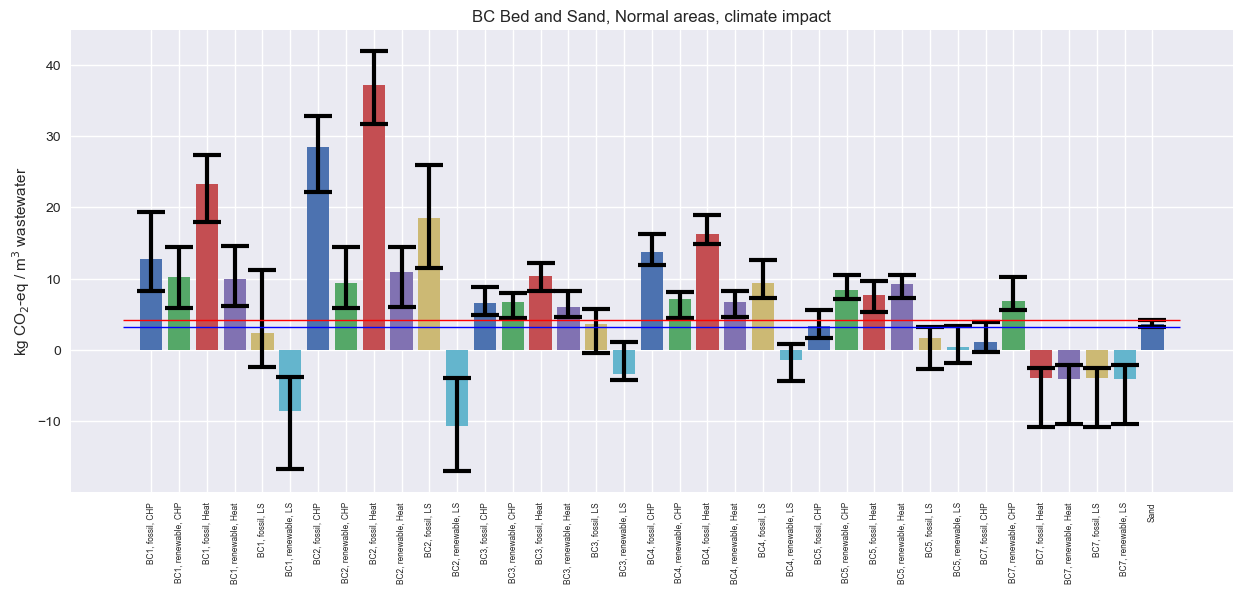

In [101]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCBedNormalClimate_bc1andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andfossilCHPmedian, x=1, yerr = BCBedNormalClimate_bc1andfossilCHPerror, capsize=10,
  		  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCBedNormalClimate_bc1andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andrenewableCHPmedian, x=2, yerr = BCBedNormalClimate_bc1andrenewableCHPerror, capsize=10,
  		  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCBedNormalClimate_bc1andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andfossilHeatmedian, x=3, yerr = BCBedNormalClimate_bc1andfossilHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCBedNormalClimate_bc1andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andrenewableHeatmedian, x=4, yerr = BCBedNormalClimate_bc1andrenewableHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCBedNormalClimate_bc1andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andfossilLSmedian, x=5, yerr = BCBedNormalClimate_bc1andfossilLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCBedNormalClimate_bc1andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc1andrenewableLSmedian, x=6, yerr = BCBedNormalClimate_bc1andrenewableLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCBedNormalClimate_bc2andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andfossilCHPmedian, x=7, yerr = BCBedNormalClimate_bc2andfossilCHPerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCBedNormalClimate_bc2andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andrenewableCHPmedian, x=8, yerr = BCBedNormalClimate_bc2andrenewableCHPerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCBedNormalClimate_bc2andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andfossilHeatmedian, x=9, yerr = BCBedNormalClimate_bc2andfossilHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCBedNormalClimate_bc2andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andrenewableHeatmedian, x=10, yerr = BCBedNormalClimate_bc2andrenewableHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCBedNormalClimate_bc2andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andfossilLSmedian, x=11, yerr = BCBedNormalClimate_bc2andfossilLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCBedNormalClimate_bc2andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc2andrenewableLSmedian, x=12, yerr = BCBedNormalClimate_bc2andrenewableLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, BCBedNormalClimate_bc3andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andfossilCHPmedian, x=13, yerr = BCBedNormalClimate_bc3andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(14, BCBedNormalClimate_bc3andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andrenewableCHPmedian, x=14, yerr = BCBedNormalClimate_bc3andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(15, BCBedNormalClimate_bc3andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andfossilHeatmedian, x=15, yerr = BCBedNormalClimate_bc3andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(16, BCBedNormalClimate_bc3andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andrenewableHeatmedian, x=16, yerr = BCBedNormalClimate_bc3andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(17, BCBedNormalClimate_bc3andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andfossilLSmedian, x=17, yerr = BCBedNormalClimate_bc3andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(18, BCBedNormalClimate_bc3andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc3andrenewableLSmedian, x=18, yerr = BCBedNormalClimate_bc3andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(19, BCBedNormalClimate_bc4andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andfossilCHPmedian, x=19, yerr = BCBedNormalClimate_bc4andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(20, BCBedNormalClimate_bc4andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andrenewableCHPmedian, x=20, yerr = BCBedNormalClimate_bc4andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(21, BCBedNormalClimate_bc4andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andfossilHeatmedian, x=21, yerr = BCBedNormalClimate_bc4andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(22, BCBedNormalClimate_bc4andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andrenewableHeatmedian, x=22, yerr = BCBedNormalClimate_bc4andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(23, BCBedNormalClimate_bc4andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andfossilLSmedian, x=23, yerr = BCBedNormalClimate_bc4andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(24, BCBedNormalClimate_bc4andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc4andrenewableLSmedian, x=24, yerr = BCBedNormalClimate_bc4andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(25, BCBedNormalClimate_bc5andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andfossilCHPmedian, x=25, yerr = BCBedNormalClimate_bc5andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(26, BCBedNormalClimate_bc5andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andrenewableCHPmedian, x=26, yerr = BCBedNormalClimate_bc5andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(27, BCBedNormalClimate_bc5andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andfossilHeatmedian, x=27, yerr = BCBedNormalClimate_bc5andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(28, BCBedNormalClimate_bc5andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andrenewableHeatmedian, x=28, yerr = BCBedNormalClimate_bc5andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(29, BCBedNormalClimate_bc5andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andfossilLSmedian, x=29, yerr = BCBedNormalClimate_bc5andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(30, BCBedNormalClimate_bc5andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc5andrenewableLSmedian, x=30, yerr = BCBedNormalClimate_bc5andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(31, BCBedNormalClimate_bc7andfossilCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andfossilCHPmedian, x=31, yerr = BCBedNormalClimate_bc7andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(32, BCBedNormalClimate_bc7andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andrenewableCHPmedian, x=32, yerr = BCBedNormalClimate_bc7andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(33, BCBedNormalClimate_bc7andfossilHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andfossilHeatmedian, x=33, yerr = BCBedNormalClimate_bc7andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(34, BCBedNormalClimate_bc7andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andrenewableHeatmedian, x=34, yerr = BCBedNormalClimate_bc7andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(35, BCBedNormalClimate_bc7andfossilLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andfossilLSmedian, x=35, yerr = BCBedNormalClimate_bc7andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(36, BCBedNormalClimate_bc7andrenewableLSmedian)
ax.errorbar(y=BCBedNormalClimate_bc7andrenewableLSmedian, x=36, yerr = BCBedNormalClimate_bc7andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(37, Sand_Normal_medianClimate)
ax.errorbar(y=Sand_Normal_medianClimate, x=37, yerr = Sand_Normal_errorClimate, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Bed and Sand, Normal areas, climate impact')
ax.set_xticks((range(1,38)))
ax.set_xticklabels(('BC1, fossil, CHP', 'BC1, renewable, CHP',
           		 'BC1, fossil, Heat', 'BC1, renewable, Heat',
           		 'BC1, fossil, LS', 'BC1, renewable, LS',
           		 'BC2, fossil, CHP', 'BC2, renewable, CHP',
           		 'BC2, fossil, Heat', 'BC2, renewable, Heat',
           		 'BC2, fossil, LS', 'BC2, renewable, LS',
           		 'BC3, fossil, CHP', 'BC3, renewable, CHP',
      			  'BC3, fossil, Heat', 'BC3, renewable, Heat',
      			  'BC3, fossil, LS', 'BC3, renewable, LS',
           		 'BC4, fossil, CHP', 'BC4, renewable, CHP',
      			  'BC4, fossil, Heat', 'BC4, renewable, Heat',
      			  'BC4, fossil, LS', 'BC4, renewable, LS',
           		 'BC5, fossil, CHP', 'BC5, renewable, CHP',
      			  'BC5, fossil, Heat', 'BC5, renewable, Heat',
      			  'BC5, fossil, LS', 'BC5, renewable, LS',
           		 'BC7, fossil, CHP', 'BC7, renewable, CHP',
      			  'BC7, fossil, Heat', 'BC7, renewable, Heat',
      			  'BC7, fossil, LS', 'BC7, renewable, LS',
           		 'Sand'), fontsize=6, rotation=90)

ax.set_ylabel(climate_label)

# ax.hlines(y=Sand_Normal_medianClimate, xmin=0, xmax=40, linewidth=1, color='r')
ax.hlines(y=Sand_Normal_medianClimate-Sand_Normal_errorClimate[0], xmin=0, xmax=38, linewidth=1, color='blue')
ax.hlines(y=Sand_Normal_medianClimate+Sand_Normal_errorClimate[1], xmin=0, xmax=38, linewidth=1, color='r')

In [102]:
fig.savefig('Scenario-BCBed-Normal-Climate', dpi=600, bbox_inches='tight')

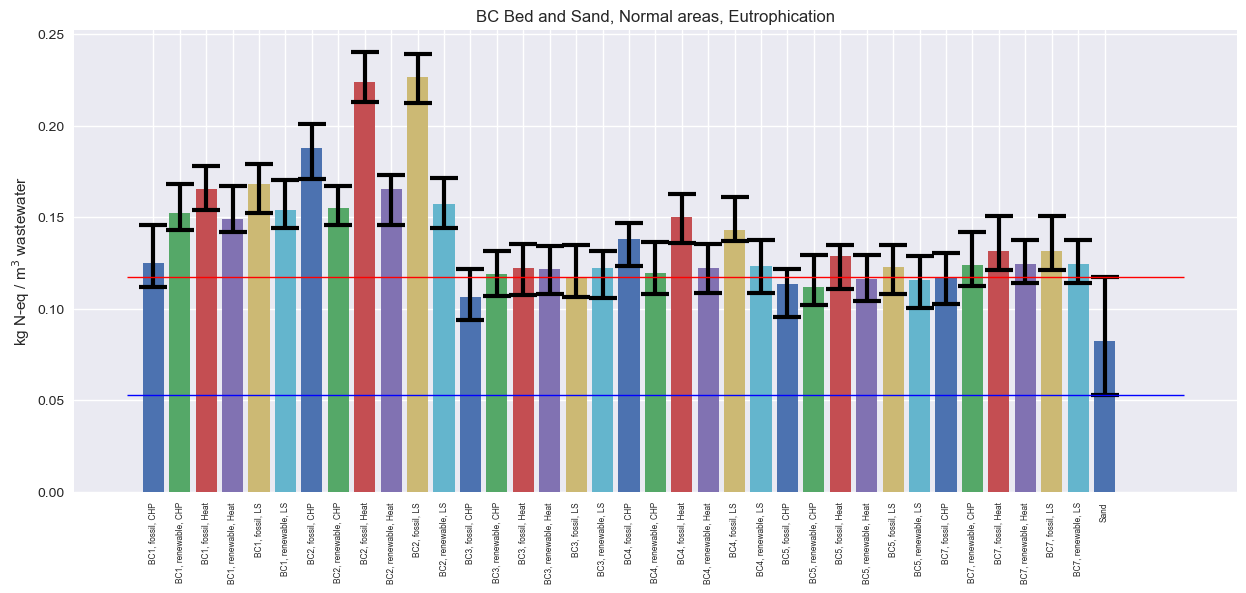

In [103]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCBedNormalEutrophication_bc1andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andfossilCHPmedian, x=1, yerr = BCBedNormalEutrophication_bc1andfossilCHPerror, capsize=10,
  		  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCBedNormalEutrophication_bc1andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andrenewableCHPmedian, x=2, yerr = BCBedNormalEutrophication_bc1andrenewableCHPerror, capsize=10,
  		  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCBedNormalEutrophication_bc1andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andfossilHeatmedian, x=3, yerr = BCBedNormalEutrophication_bc1andfossilHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCBedNormalEutrophication_bc1andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andrenewableHeatmedian, x=4, yerr = BCBedNormalEutrophication_bc1andrenewableHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCBedNormalEutrophication_bc1andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andfossilLSmedian, x=5, yerr = BCBedNormalEutrophication_bc1andfossilLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCBedNormalEutrophication_bc1andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc1andrenewableLSmedian, x=6, yerr = BCBedNormalEutrophication_bc1andrenewableLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCBedNormalEutrophication_bc2andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andfossilCHPmedian, x=7, yerr = BCBedNormalEutrophication_bc2andfossilCHPerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCBedNormalEutrophication_bc2andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andrenewableCHPmedian, x=8, yerr = BCBedNormalEutrophication_bc2andrenewableCHPerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCBedNormalEutrophication_bc2andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andfossilHeatmedian, x=9, yerr = BCBedNormalEutrophication_bc2andfossilHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCBedNormalEutrophication_bc2andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andrenewableHeatmedian, x=10, yerr = BCBedNormalEutrophication_bc2andrenewableHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCBedNormalEutrophication_bc2andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andfossilLSmedian, x=11, yerr = BCBedNormalEutrophication_bc2andfossilLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCBedNormalEutrophication_bc2andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc2andrenewableLSmedian, x=12, yerr = BCBedNormalEutrophication_bc2andrenewableLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, BCBedNormalEutrophication_bc3andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andfossilCHPmedian, x=13, yerr = BCBedNormalEutrophication_bc3andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(14, BCBedNormalEutrophication_bc3andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andrenewableCHPmedian, x=14, yerr = BCBedNormalEutrophication_bc3andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(15, BCBedNormalEutrophication_bc3andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andfossilHeatmedian, x=15, yerr = BCBedNormalEutrophication_bc3andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(16, BCBedNormalEutrophication_bc3andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andrenewableHeatmedian, x=16, yerr = BCBedNormalEutrophication_bc3andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(17, BCBedNormalEutrophication_bc3andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andfossilLSmedian, x=17, yerr = BCBedNormalEutrophication_bc3andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(18, BCBedNormalEutrophication_bc3andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc3andrenewableLSmedian, x=18, yerr = BCBedNormalEutrophication_bc3andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(19, BCBedNormalEutrophication_bc4andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andfossilCHPmedian, x=19, yerr = BCBedNormalEutrophication_bc4andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(20, BCBedNormalEutrophication_bc4andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andrenewableCHPmedian, x=20, yerr = BCBedNormalEutrophication_bc4andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(21, BCBedNormalEutrophication_bc4andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andfossilHeatmedian, x=21, yerr = BCBedNormalEutrophication_bc4andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(22, BCBedNormalEutrophication_bc4andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andrenewableHeatmedian, x=22, yerr = BCBedNormalEutrophication_bc4andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(23, BCBedNormalEutrophication_bc4andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andfossilLSmedian, x=23, yerr = BCBedNormalEutrophication_bc4andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(24, BCBedNormalEutrophication_bc4andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc4andrenewableLSmedian, x=24, yerr = BCBedNormalEutrophication_bc4andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(25, BCBedNormalEutrophication_bc5andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andfossilCHPmedian, x=25, yerr = BCBedNormalEutrophication_bc5andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(26, BCBedNormalEutrophication_bc5andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andrenewableCHPmedian, x=26, yerr = BCBedNormalEutrophication_bc5andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(27, BCBedNormalEutrophication_bc5andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andfossilHeatmedian, x=27, yerr = BCBedNormalEutrophication_bc5andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(28, BCBedNormalEutrophication_bc5andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andrenewableHeatmedian, x=28, yerr = BCBedNormalEutrophication_bc5andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(29, BCBedNormalEutrophication_bc5andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andfossilLSmedian, x=29, yerr = BCBedNormalEutrophication_bc5andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(30, BCBedNormalEutrophication_bc5andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc5andrenewableLSmedian, x=30, yerr = BCBedNormalEutrophication_bc5andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(31, BCBedNormalEutrophication_bc7andfossilCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andfossilCHPmedian, x=31, yerr = BCBedNormalEutrophication_bc7andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(32, BCBedNormalEutrophication_bc7andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andrenewableCHPmedian, x=32, yerr = BCBedNormalEutrophication_bc7andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(33, BCBedNormalEutrophication_bc7andfossilHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andfossilHeatmedian, x=33, yerr = BCBedNormalEutrophication_bc7andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(34, BCBedNormalEutrophication_bc7andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andrenewableHeatmedian, x=34, yerr = BCBedNormalEutrophication_bc7andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(35, BCBedNormalEutrophication_bc7andfossilLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andfossilLSmedian, x=35, yerr = BCBedNormalEutrophication_bc7andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(36, BCBedNormalEutrophication_bc7andrenewableLSmedian)
ax.errorbar(y=BCBedNormalEutrophication_bc7andrenewableLSmedian, x=36, yerr = BCBedNormalEutrophication_bc7andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(37, Sand_Normal_medianEutroph)
ax.errorbar(y=Sand_Normal_medianEutroph, x=37, yerr = Sand_Normal_errorEutroph, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Bed and Sand, Normal areas, Eutrophication')
ax.set_xticks((range(1,38)))
ax.set_xticklabels(('BC1, fossil, CHP', 'BC1, renewable, CHP',
           		 'BC1, fossil, Heat', 'BC1, renewable, Heat',
           		 'BC1, fossil, LS', 'BC1, renewable, LS',
           		 'BC2, fossil, CHP', 'BC2, renewable, CHP',
           		 'BC2, fossil, Heat', 'BC2, renewable, Heat',
           		 'BC2, fossil, LS', 'BC2, renewable, LS',
           		 'BC3, fossil, CHP', 'BC3, renewable, CHP',
      			  'BC3, fossil, Heat', 'BC3, renewable, Heat',
      			  'BC3, fossil, LS', 'BC3, renewable, LS',
           		 'BC4, fossil, CHP', 'BC4, renewable, CHP',
      			  'BC4, fossil, Heat', 'BC4, renewable, Heat',
      			  'BC4, fossil, LS', 'BC4, renewable, LS',
           		 'BC5, fossil, CHP', 'BC5, renewable, CHP',
      			  'BC5, fossil, Heat', 'BC5, renewable, Heat',
      			  'BC5, fossil, LS', 'BC5, renewable, LS',
           		 'BC7, fossil, CHP', 'BC7, renewable, CHP',
      			  'BC7, fossil, Heat', 'BC7, renewable, Heat',
      			  'BC7, fossil, LS', 'BC7, renewable, LS',
           		 'Sand'), fontsize=6, rotation=90)
ax.set_ylabel(eutroph_label)

# ax.hlines(y=Sand_Normal_medianEutroph, xmin=0, xmax=40, linewidth=2, color='r')
ax.hlines(y=Sand_Normal_medianEutroph-Sand_Normal_errorEutroph[0], xmin=0, xmax=40, linewidth=1, color='blue')
ax.hlines(y=Sand_Normal_medianEutroph+Sand_Normal_errorEutroph[1], xmin=0, xmax=40, linewidth=1, color='r')

In [104]:
fig.savefig('Scenario-BCBed-Normal-Eutroph', dpi=600, bbox_inches='tight')

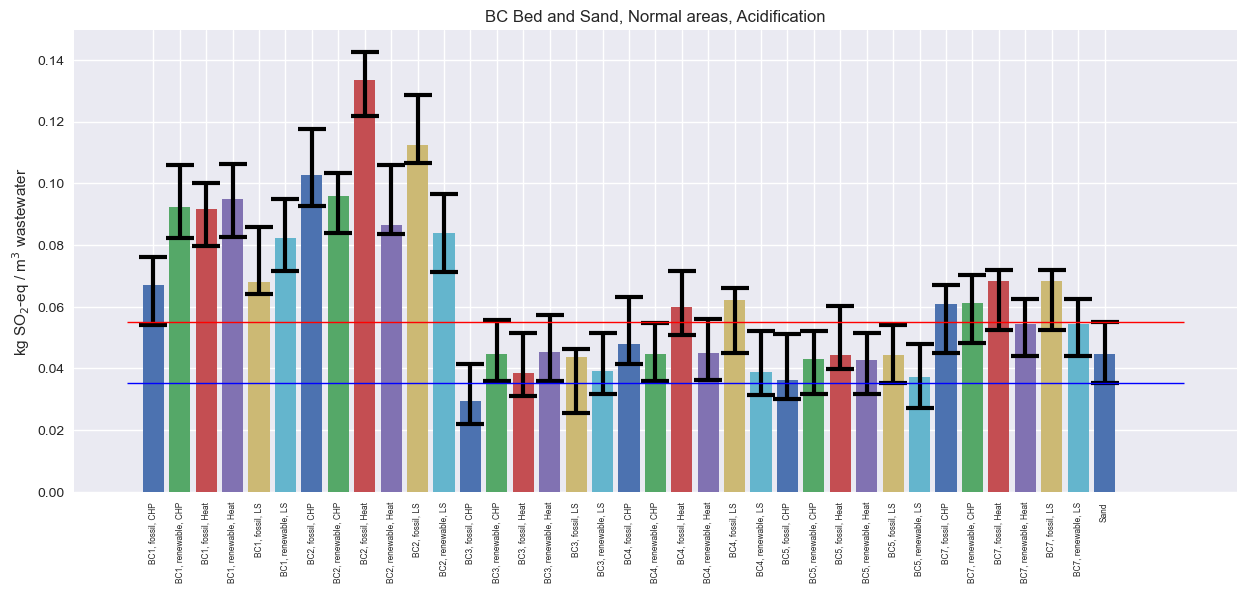

In [105]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCBedNormalAcidification_bc1andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andfossilCHPmedian, x=1, yerr = BCBedNormalAcidification_bc1andfossilCHPerror, capsize=10,
     	   elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCBedNormalAcidification_bc1andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andrenewableCHPmedian, x=2, yerr = BCBedNormalAcidification_bc1andrenewableCHPerror, capsize=10,
     	   elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCBedNormalAcidification_bc1andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andfossilHeatmedian, x=3, yerr = BCBedNormalAcidification_bc1andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCBedNormalAcidification_bc1andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andrenewableHeatmedian, x=4, yerr = BCBedNormalAcidification_bc1andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCBedNormalAcidification_bc1andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andfossilLSmedian, x=5, yerr = BCBedNormalAcidification_bc1andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCBedNormalAcidification_bc1andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc1andrenewableLSmedian, x=6, yerr = BCBedNormalAcidification_bc1andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCBedNormalAcidification_bc2andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andfossilCHPmedian, x=7, yerr = BCBedNormalAcidification_bc2andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCBedNormalAcidification_bc2andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andrenewableCHPmedian, x=8, yerr = BCBedNormalAcidification_bc2andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCBedNormalAcidification_bc2andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andfossilHeatmedian, x=9, yerr = BCBedNormalAcidification_bc2andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCBedNormalAcidification_bc2andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andrenewableHeatmedian, x=10, yerr = BCBedNormalAcidification_bc2andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCBedNormalAcidification_bc2andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andfossilLSmedian, x=11, yerr = BCBedNormalAcidification_bc2andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCBedNormalAcidification_bc2andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc2andrenewableLSmedian, x=12, yerr = BCBedNormalAcidification_bc2andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, BCBedNormalAcidification_bc3andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andfossilCHPmedian, x=13, yerr = BCBedNormalAcidification_bc3andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(14, BCBedNormalAcidification_bc3andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andrenewableCHPmedian, x=14, yerr = BCBedNormalAcidification_bc3andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(15, BCBedNormalAcidification_bc3andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andfossilHeatmedian, x=15, yerr = BCBedNormalAcidification_bc3andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(16, BCBedNormalAcidification_bc3andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andrenewableHeatmedian, x=16, yerr = BCBedNormalAcidification_bc3andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(17, BCBedNormalAcidification_bc3andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andfossilLSmedian, x=17, yerr = BCBedNormalAcidification_bc3andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(18, BCBedNormalAcidification_bc3andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc3andrenewableLSmedian, x=18, yerr = BCBedNormalAcidification_bc3andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(19, BCBedNormalAcidification_bc4andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andfossilCHPmedian, x=19, yerr = BCBedNormalAcidification_bc4andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(20, BCBedNormalAcidification_bc4andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andrenewableCHPmedian, x=20, yerr = BCBedNormalAcidification_bc4andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(21, BCBedNormalAcidification_bc4andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andfossilHeatmedian, x=21, yerr = BCBedNormalAcidification_bc4andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(22, BCBedNormalAcidification_bc4andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andrenewableHeatmedian, x=22, yerr = BCBedNormalAcidification_bc4andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(23, BCBedNormalAcidification_bc4andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andfossilLSmedian, x=23, yerr = BCBedNormalAcidification_bc4andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(24, BCBedNormalAcidification_bc4andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc4andrenewableLSmedian, x=24, yerr = BCBedNormalAcidification_bc4andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(25, BCBedNormalAcidification_bc5andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andfossilCHPmedian, x=25, yerr = BCBedNormalAcidification_bc5andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(26, BCBedNormalAcidification_bc5andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andrenewableCHPmedian, x=26, yerr = BCBedNormalAcidification_bc5andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(27, BCBedNormalAcidification_bc5andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andfossilHeatmedian, x=27, yerr = BCBedNormalAcidification_bc5andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(28, BCBedNormalAcidification_bc5andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andrenewableHeatmedian, x=28, yerr = BCBedNormalAcidification_bc5andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(29, BCBedNormalAcidification_bc5andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andfossilLSmedian, x=29, yerr = BCBedNormalAcidification_bc5andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(30, BCBedNormalAcidification_bc5andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc5andrenewableLSmedian, x=30, yerr = BCBedNormalAcidification_bc5andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(31, BCBedNormalAcidification_bc7andfossilCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andfossilCHPmedian, x=31, yerr = BCBedNormalAcidification_bc7andfossilCHPerror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(32, BCBedNormalAcidification_bc7andrenewableCHPmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andrenewableCHPmedian, x=32, yerr = BCBedNormalAcidification_bc7andrenewableCHPerror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(33, BCBedNormalAcidification_bc7andfossilHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andfossilHeatmedian, x=33, yerr = BCBedNormalAcidification_bc7andfossilHeaterror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(34, BCBedNormalAcidification_bc7andrenewableHeatmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andrenewableHeatmedian, x=34, yerr = BCBedNormalAcidification_bc7andrenewableHeaterror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(35, BCBedNormalAcidification_bc7andfossilLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andfossilLSmedian, x=35, yerr = BCBedNormalAcidification_bc7andfossilLSerror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(36, BCBedNormalAcidification_bc7andrenewableLSmedian)
ax.errorbar(y=BCBedNormalAcidification_bc7andrenewableLSmedian, x=36, yerr = BCBedNormalAcidification_bc7andrenewableLSerror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(37, Sand_Normal_medianAcid)
ax.errorbar(y=Sand_Normal_medianAcid, x=37, yerr = Sand_Normal_errorAcid, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Bed and Sand, Normal areas, Acidification')
ax.set_xticks((range(1,38)))
ax.set_xticklabels(('BC1, fossil, CHP', 'BC1, renewable, CHP',
      			  'BC1, fossil, Heat', 'BC1, renewable, Heat',
      			  'BC1, fossil, LS', 'BC1, renewable, LS',
      			  'BC2, fossil, CHP', 'BC2, renewable, CHP',
      			  'BC2, fossil, Heat', 'BC2, renewable, Heat',
      			  'BC2, fossil, LS', 'BC2, renewable, LS',
      			  'BC3, fossil, CHP', 'BC3, renewable, CHP',
 				   'BC3, fossil, Heat', 'BC3, renewable, Heat',
 				   'BC3, fossil, LS', 'BC3, renewable, LS',
      			  'BC4, fossil, CHP', 'BC4, renewable, CHP',
 				   'BC4, fossil, Heat', 'BC4, renewable, Heat',
 				   'BC4, fossil, LS', 'BC4, renewable, LS',
      			  'BC5, fossil, CHP', 'BC5, renewable, CHP',
 				   'BC5, fossil, Heat', 'BC5, renewable, Heat',
 				   'BC5, fossil, LS', 'BC5, renewable, LS',
      			  'BC7, fossil, CHP', 'BC7, renewable, CHP',
 				   'BC7, fossil, Heat', 'BC7, renewable, Heat',
 				   'BC7, fossil, LS', 'BC7, renewable, LS',
      			  'Sand'), fontsize=6, rotation=90)
ax.set_ylabel(acid_label)
# ax.hlines(y=Sand_Normal_medianAcid, xmin=0, xmax=40, linewidth=2, color='r')
ax.hlines(y=Sand_Normal_medianAcid-Sand_Normal_errorAcid[0], xmin=0, xmax=40, linewidth=1, color='blue')
ax.hlines(y=Sand_Normal_medianAcid+Sand_Normal_errorAcid[1], xmin=0, xmax=40, linewidth=1, color='r')


In [106]:
fig.savefig('Scenario-BCBed-Normal-Acid', dpi=600, bbox_inches='tight')

##### BC Mod Sensitive

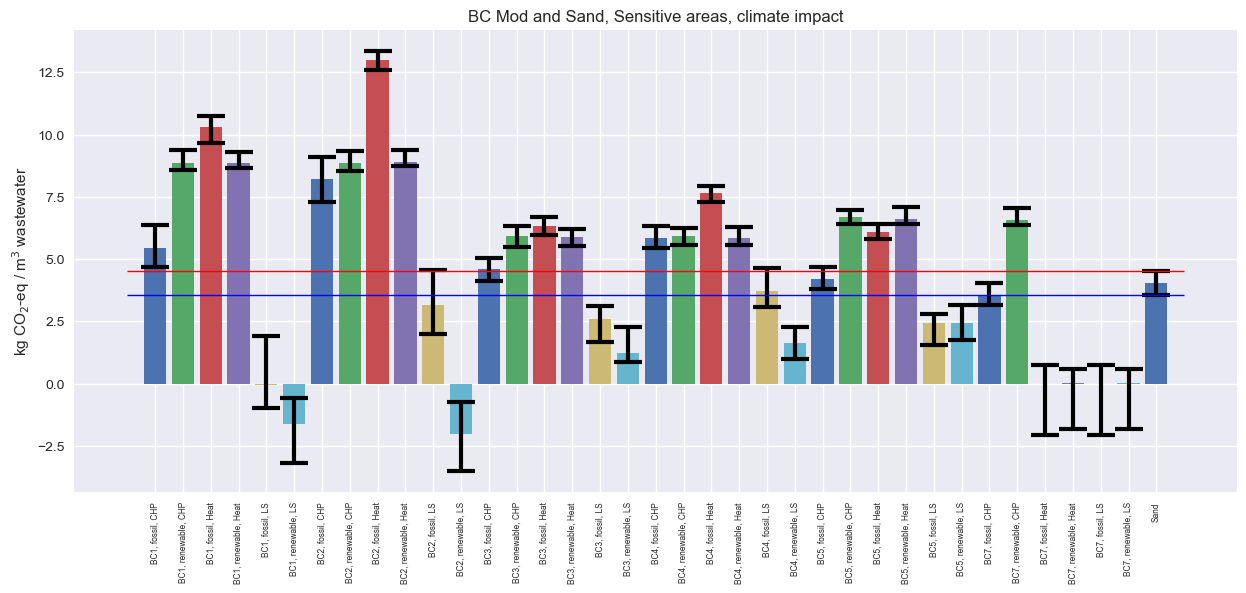

In [107]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCModSensitiveClimate_bc1andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andfossilCHPmedian, x=1, yerr = BCModSensitiveClimate_bc1andfossilCHPerror, capsize=10,
  		  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCModSensitiveClimate_bc1andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andrenewableCHPmedian, x=2, yerr = BCModSensitiveClimate_bc1andrenewableCHPerror, capsize=10,
  		  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCModSensitiveClimate_bc1andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andfossilHeatmedian, x=3, yerr = BCModSensitiveClimate_bc1andfossilHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCModSensitiveClimate_bc1andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andrenewableHeatmedian, x=4, yerr = BCModSensitiveClimate_bc1andrenewableHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCModSensitiveClimate_bc1andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andfossilLSmedian, x=5, yerr = BCModSensitiveClimate_bc1andfossilLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCModSensitiveClimate_bc1andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc1andrenewableLSmedian, x=6, yerr = BCModSensitiveClimate_bc1andrenewableLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCModSensitiveClimate_bc2andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andfossilCHPmedian, x=7, yerr = BCModSensitiveClimate_bc2andfossilCHPerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCModSensitiveClimate_bc2andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andrenewableCHPmedian, x=8, yerr = BCModSensitiveClimate_bc2andrenewableCHPerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCModSensitiveClimate_bc2andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andfossilHeatmedian, x=9, yerr = BCModSensitiveClimate_bc2andfossilHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCModSensitiveClimate_bc2andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andrenewableHeatmedian, x=10, yerr = BCModSensitiveClimate_bc2andrenewableHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCModSensitiveClimate_bc2andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andfossilLSmedian, x=11, yerr = BCModSensitiveClimate_bc2andfossilLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCModSensitiveClimate_bc2andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc2andrenewableLSmedian, x=12, yerr = BCModSensitiveClimate_bc2andrenewableLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, BCModSensitiveClimate_bc3andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andfossilCHPmedian, x=13, yerr = BCModSensitiveClimate_bc3andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(14, BCModSensitiveClimate_bc3andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andrenewableCHPmedian, x=14, yerr = BCModSensitiveClimate_bc3andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(15, BCModSensitiveClimate_bc3andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andfossilHeatmedian, x=15, yerr = BCModSensitiveClimate_bc3andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(16, BCModSensitiveClimate_bc3andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andrenewableHeatmedian, x=16, yerr = BCModSensitiveClimate_bc3andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(17, BCModSensitiveClimate_bc3andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andfossilLSmedian, x=17, yerr = BCModSensitiveClimate_bc3andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(18, BCModSensitiveClimate_bc3andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc3andrenewableLSmedian, x=18, yerr = BCModSensitiveClimate_bc3andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(19, BCModSensitiveClimate_bc4andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andfossilCHPmedian, x=19, yerr = BCModSensitiveClimate_bc4andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(20, BCModSensitiveClimate_bc4andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andrenewableCHPmedian, x=20, yerr = BCModSensitiveClimate_bc4andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(21, BCModSensitiveClimate_bc4andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andfossilHeatmedian, x=21, yerr = BCModSensitiveClimate_bc4andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(22, BCModSensitiveClimate_bc4andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andrenewableHeatmedian, x=22, yerr = BCModSensitiveClimate_bc4andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(23, BCModSensitiveClimate_bc4andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andfossilLSmedian, x=23, yerr = BCModSensitiveClimate_bc4andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(24, BCModSensitiveClimate_bc4andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc4andrenewableLSmedian, x=24, yerr = BCModSensitiveClimate_bc4andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(25, BCModSensitiveClimate_bc5andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andfossilCHPmedian, x=25, yerr = BCModSensitiveClimate_bc5andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(26, BCModSensitiveClimate_bc5andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andrenewableCHPmedian, x=26, yerr = BCModSensitiveClimate_bc5andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(27, BCModSensitiveClimate_bc5andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andfossilHeatmedian, x=27, yerr = BCModSensitiveClimate_bc5andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(28, BCModSensitiveClimate_bc5andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andrenewableHeatmedian, x=28, yerr = BCModSensitiveClimate_bc5andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(29, BCModSensitiveClimate_bc5andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andfossilLSmedian, x=29, yerr = BCModSensitiveClimate_bc5andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(30, BCModSensitiveClimate_bc5andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc5andrenewableLSmedian, x=30, yerr = BCModSensitiveClimate_bc5andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(31, BCModSensitiveClimate_bc7andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andfossilCHPmedian, x=31, yerr = BCModSensitiveClimate_bc7andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(32, BCModSensitiveClimate_bc7andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andrenewableCHPmedian, x=32, yerr = BCModSensitiveClimate_bc7andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(33, BCModSensitiveClimate_bc7andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andfossilHeatmedian, x=33, yerr = BCModSensitiveClimate_bc7andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(34, BCModSensitiveClimate_bc7andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andrenewableHeatmedian, x=34, yerr = BCModSensitiveClimate_bc7andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(35, BCModSensitiveClimate_bc7andfossilLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andfossilLSmedian, x=35, yerr = BCModSensitiveClimate_bc7andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(36, BCModSensitiveClimate_bc7andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveClimate_bc7andrenewableLSmedian, x=36, yerr = BCModSensitiveClimate_bc7andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(37, Sand_Sensitive_medianClimate)
ax.errorbar(y=Sand_Sensitive_medianClimate, x=37, yerr = Sand_Sensitive_errorClimate, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Mod and Sand, Sensitive areas, climate impact')
ax.set_xticks((range(1,38)))
ax.set_xticklabels(('BC1, fossil, CHP', 'BC1, renewable, CHP',
           		 'BC1, fossil, Heat', 'BC1, renewable, Heat',
           		 'BC1, fossil, LS', 'BC1, renewable, LS',
           		 'BC2, fossil, CHP', 'BC2, renewable, CHP',
           		 'BC2, fossil, Heat', 'BC2, renewable, Heat',
           		 'BC2, fossil, LS', 'BC2, renewable, LS',
           		 'BC3, fossil, CHP', 'BC3, renewable, CHP',
      			  'BC3, fossil, Heat', 'BC3, renewable, Heat',
      			  'BC3, fossil, LS', 'BC3, renewable, LS',
           		 'BC4, fossil, CHP', 'BC4, renewable, CHP',
      			  'BC4, fossil, Heat', 'BC4, renewable, Heat',
      			  'BC4, fossil, LS', 'BC4, renewable, LS',
           		 'BC5, fossil, CHP', 'BC5, renewable, CHP',
      			  'BC5, fossil, Heat', 'BC5, renewable, Heat',
      			  'BC5, fossil, LS', 'BC5, renewable, LS',
           		 'BC7, fossil, CHP', 'BC7, renewable, CHP',
      			  'BC7, fossil, Heat', 'BC7, renewable, Heat',
      			  'BC7, fossil, LS', 'BC7, renewable, LS',
           		 'Sand'), fontsize=6, rotation=90)
ax.set_ylabel(climate_label)

# ax.hlines(y=Sand_Sensitive_medianClimate, xmin=0, xmax=40, linewidth=2, color='r')
ax.hlines(y=Sand_Sensitive_medianClimate-Sand_Sensitive_errorClimate[0], xmin=0, xmax=38, linewidth=1, color='blue')
ax.hlines(y=Sand_Sensitive_medianClimate+Sand_Sensitive_errorClimate[1], xmin=0, xmax=38, linewidth=1, color='r')

In [108]:
fig.savefig('Scenario-BCMod-Climate', dpi=600, bbox_inches='tight')

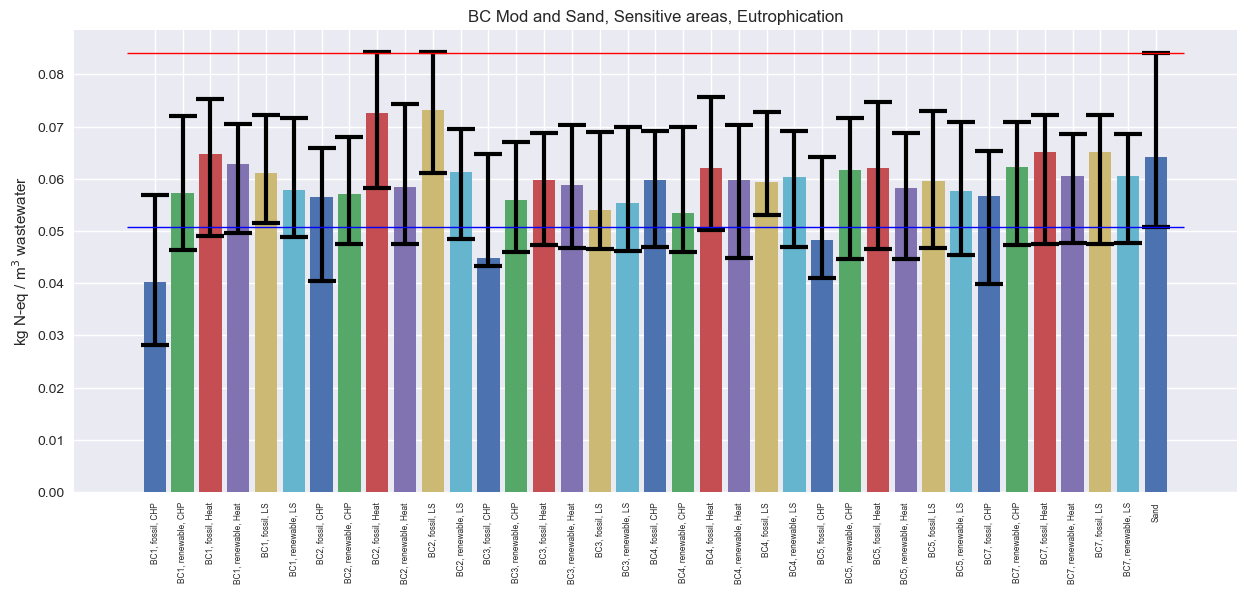

In [109]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCModSensitiveEutrophication_bc1andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andfossilCHPmedian, x=1, yerr = BCModSensitiveEutrophication_bc1andfossilCHPerror, capsize=10,
  		  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCModSensitiveEutrophication_bc1andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andrenewableCHPmedian, x=2, yerr = BCModSensitiveEutrophication_bc1andrenewableCHPerror, capsize=10,
  		  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCModSensitiveEutrophication_bc1andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andfossilHeatmedian, x=3, yerr = BCModSensitiveEutrophication_bc1andfossilHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCModSensitiveEutrophication_bc1andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andrenewableHeatmedian, x=4, yerr = BCModSensitiveEutrophication_bc1andrenewableHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCModSensitiveEutrophication_bc1andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andfossilLSmedian, x=5, yerr = BCModSensitiveEutrophication_bc1andfossilLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCModSensitiveEutrophication_bc1andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc1andrenewableLSmedian, x=6, yerr = BCModSensitiveEutrophication_bc1andrenewableLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCModSensitiveEutrophication_bc2andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andfossilCHPmedian, x=7, yerr = BCModSensitiveEutrophication_bc2andfossilCHPerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCModSensitiveEutrophication_bc2andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andrenewableCHPmedian, x=8, yerr = BCModSensitiveEutrophication_bc2andrenewableCHPerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCModSensitiveEutrophication_bc2andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andfossilHeatmedian, x=9, yerr = BCModSensitiveEutrophication_bc2andfossilHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCModSensitiveEutrophication_bc2andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andrenewableHeatmedian, x=10, yerr = BCModSensitiveEutrophication_bc2andrenewableHeaterror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCModSensitiveEutrophication_bc2andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andfossilLSmedian, x=11, yerr = BCModSensitiveEutrophication_bc2andfossilLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCModSensitiveEutrophication_bc2andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc2andrenewableLSmedian, x=12, yerr = BCModSensitiveEutrophication_bc2andrenewableLSerror, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, BCModSensitiveEutrophication_bc3andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andfossilCHPmedian, x=13, yerr = BCModSensitiveEutrophication_bc3andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(14, BCModSensitiveEutrophication_bc3andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andrenewableCHPmedian, x=14, yerr = BCModSensitiveEutrophication_bc3andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(15, BCModSensitiveEutrophication_bc3andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andfossilHeatmedian, x=15, yerr = BCModSensitiveEutrophication_bc3andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(16, BCModSensitiveEutrophication_bc3andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andrenewableHeatmedian, x=16, yerr = BCModSensitiveEutrophication_bc3andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(17, BCModSensitiveEutrophication_bc3andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andfossilLSmedian, x=17, yerr = BCModSensitiveEutrophication_bc3andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(18, BCModSensitiveEutrophication_bc3andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc3andrenewableLSmedian, x=18, yerr = BCModSensitiveEutrophication_bc3andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(19, BCModSensitiveEutrophication_bc4andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andfossilCHPmedian, x=19, yerr = BCModSensitiveEutrophication_bc4andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(20, BCModSensitiveEutrophication_bc4andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andrenewableCHPmedian, x=20, yerr = BCModSensitiveEutrophication_bc4andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(21, BCModSensitiveEutrophication_bc4andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andfossilHeatmedian, x=21, yerr = BCModSensitiveEutrophication_bc4andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(22, BCModSensitiveEutrophication_bc4andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andrenewableHeatmedian, x=22, yerr = BCModSensitiveEutrophication_bc4andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(23, BCModSensitiveEutrophication_bc4andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andfossilLSmedian, x=23, yerr = BCModSensitiveEutrophication_bc4andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(24, BCModSensitiveEutrophication_bc4andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc4andrenewableLSmedian, x=24, yerr = BCModSensitiveEutrophication_bc4andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(25, BCModSensitiveEutrophication_bc5andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andfossilCHPmedian, x=25, yerr = BCModSensitiveEutrophication_bc5andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(26, BCModSensitiveEutrophication_bc5andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andrenewableCHPmedian, x=26, yerr = BCModSensitiveEutrophication_bc5andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(27, BCModSensitiveEutrophication_bc5andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andfossilHeatmedian, x=27, yerr = BCModSensitiveEutrophication_bc5andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(28, BCModSensitiveEutrophication_bc5andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andrenewableHeatmedian, x=28, yerr = BCModSensitiveEutrophication_bc5andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(29, BCModSensitiveEutrophication_bc5andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andfossilLSmedian, x=29, yerr = BCModSensitiveEutrophication_bc5andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(30, BCModSensitiveEutrophication_bc5andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc5andrenewableLSmedian, x=30, yerr = BCModSensitiveEutrophication_bc5andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(31, BCModSensitiveEutrophication_bc7andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andfossilCHPmedian, x=31, yerr = BCModSensitiveEutrophication_bc7andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(32, BCModSensitiveEutrophication_bc7andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andrenewableCHPmedian, x=32, yerr = BCModSensitiveEutrophication_bc7andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(33, BCModSensitiveEutrophication_bc7andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andfossilHeatmedian, x=33, yerr = BCModSensitiveEutrophication_bc7andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(34, BCModSensitiveEutrophication_bc7andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andrenewableHeatmedian, x=34, yerr = BCModSensitiveEutrophication_bc7andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(35, BCModSensitiveEutrophication_bc7andfossilLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andfossilLSmedian, x=35, yerr = BCModSensitiveEutrophication_bc7andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(36, BCModSensitiveEutrophication_bc7andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveEutrophication_bc7andrenewableLSmedian, x=36, yerr = BCModSensitiveEutrophication_bc7andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(37, Sand_Sensitive_medianEutroph)
ax.errorbar(y=Sand_Sensitive_medianEutroph, x=37, yerr = Sand_Sensitive_errorEutroph, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Mod and Sand, Sensitive areas, Eutrophication')
ax.set_xticks((range(1,38)))
ax.set_xticklabels(('BC1, fossil, CHP', 'BC1, renewable, CHP',
           		 'BC1, fossil, Heat', 'BC1, renewable, Heat',
           		 'BC1, fossil, LS', 'BC1, renewable, LS',
           		 'BC2, fossil, CHP', 'BC2, renewable, CHP',
           		 'BC2, fossil, Heat', 'BC2, renewable, Heat',
           		 'BC2, fossil, LS', 'BC2, renewable, LS',
           		 'BC3, fossil, CHP', 'BC3, renewable, CHP',
      			  'BC3, fossil, Heat', 'BC3, renewable, Heat',
      			  'BC3, fossil, LS', 'BC3, renewable, LS',
           		 'BC4, fossil, CHP', 'BC4, renewable, CHP',
      			  'BC4, fossil, Heat', 'BC4, renewable, Heat',
      			  'BC4, fossil, LS', 'BC4, renewable, LS',
           		 'BC5, fossil, CHP', 'BC5, renewable, CHP',
      			  'BC5, fossil, Heat', 'BC5, renewable, Heat',
      			  'BC5, fossil, LS', 'BC5, renewable, LS',
           		 'BC7, fossil, CHP', 'BC7, renewable, CHP',
      			  'BC7, fossil, Heat', 'BC7, renewable, Heat',
      			  'BC7, fossil, LS', 'BC7, renewable, LS',
           		 'Sand'), fontsize=6, rotation=90)
ax.set_ylabel(eutroph_label)

ax.hlines(y=Sand_Sensitive_medianEutroph-Sand_Sensitive_errorEutroph[0], xmin=0, xmax=38, linewidth=1, color='blue')
ax.hlines(y=Sand_Sensitive_medianEutroph+Sand_Sensitive_errorEutroph[1], xmin=0, xmax=38, linewidth=1, color='r')
# ax.hlines(y=Sand_Sensitive_medianEutroph, xmin=0, xmax=40, linewidth=2, color='r')

In [110]:
fig.savefig('Scenario-BCMod-Eutroph', dpi=600, bbox_inches='tight')

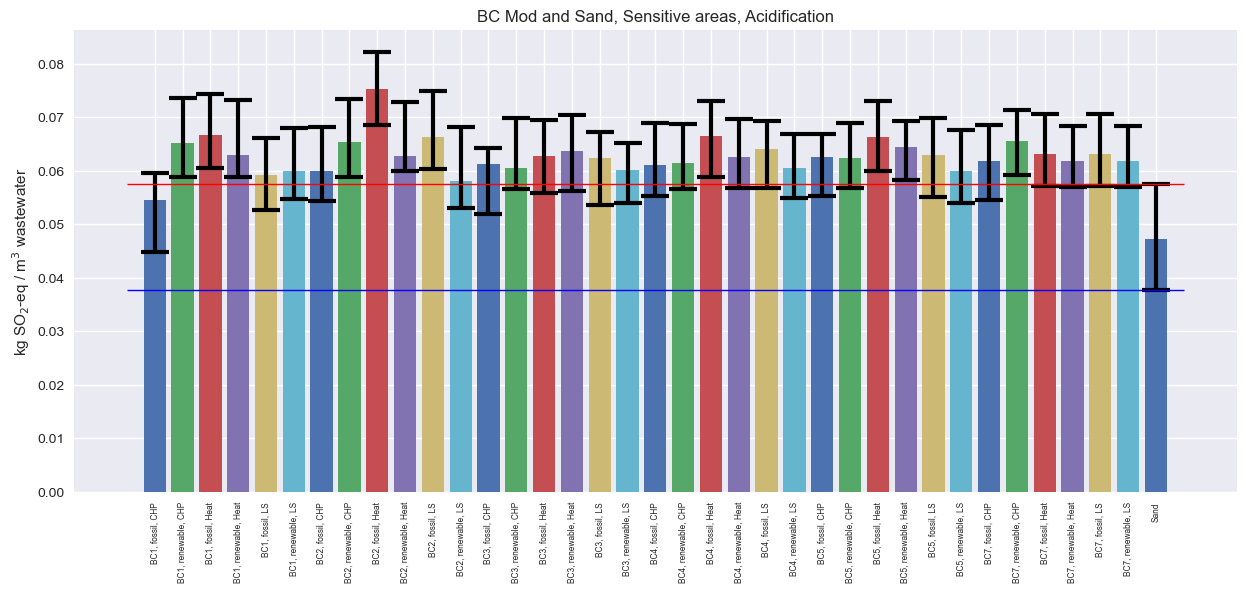

In [111]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCModSensitiveAcidification_bc1andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andfossilCHPmedian, x=1, yerr = BCModSensitiveAcidification_bc1andfossilCHPerror, capsize=10,
     	   elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCModSensitiveAcidification_bc1andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andrenewableCHPmedian, x=2, yerr = BCModSensitiveAcidification_bc1andrenewableCHPerror, capsize=10,
     	   elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCModSensitiveAcidification_bc1andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andfossilHeatmedian, x=3, yerr = BCModSensitiveAcidification_bc1andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCModSensitiveAcidification_bc1andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andrenewableHeatmedian, x=4, yerr = BCModSensitiveAcidification_bc1andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCModSensitiveAcidification_bc1andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andfossilLSmedian, x=5, yerr = BCModSensitiveAcidification_bc1andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCModSensitiveAcidification_bc1andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc1andrenewableLSmedian, x=6, yerr = BCModSensitiveAcidification_bc1andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCModSensitiveAcidification_bc2andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andfossilCHPmedian, x=7, yerr = BCModSensitiveAcidification_bc2andfossilCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCModSensitiveAcidification_bc2andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andrenewableCHPmedian, x=8, yerr = BCModSensitiveAcidification_bc2andrenewableCHPerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCModSensitiveAcidification_bc2andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andfossilHeatmedian, x=9, yerr = BCModSensitiveAcidification_bc2andfossilHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCModSensitiveAcidification_bc2andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andrenewableHeatmedian, x=10, yerr = BCModSensitiveAcidification_bc2andrenewableHeaterror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCModSensitiveAcidification_bc2andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andfossilLSmedian, x=11, yerr = BCModSensitiveAcidification_bc2andfossilLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCModSensitiveAcidification_bc2andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc2andrenewableLSmedian, x=12, yerr = BCModSensitiveAcidification_bc2andrenewableLSerror, capsize=10,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, BCModSensitiveAcidification_bc3andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andfossilCHPmedian, x=13, yerr = BCModSensitiveAcidification_bc3andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(14, BCModSensitiveAcidification_bc3andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andrenewableCHPmedian, x=14, yerr = BCModSensitiveAcidification_bc3andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(15, BCModSensitiveAcidification_bc3andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andfossilHeatmedian, x=15, yerr = BCModSensitiveAcidification_bc3andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(16, BCModSensitiveAcidification_bc3andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andrenewableHeatmedian, x=16, yerr = BCModSensitiveAcidification_bc3andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(17, BCModSensitiveAcidification_bc3andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andfossilLSmedian, x=17, yerr = BCModSensitiveAcidification_bc3andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(18, BCModSensitiveAcidification_bc3andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc3andrenewableLSmedian, x=18, yerr = BCModSensitiveAcidification_bc3andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(19, BCModSensitiveAcidification_bc4andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andfossilCHPmedian, x=19, yerr = BCModSensitiveAcidification_bc4andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(20, BCModSensitiveAcidification_bc4andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andrenewableCHPmedian, x=20, yerr = BCModSensitiveAcidification_bc4andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(21, BCModSensitiveAcidification_bc4andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andfossilHeatmedian, x=21, yerr = BCModSensitiveAcidification_bc4andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(22, BCModSensitiveAcidification_bc4andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andrenewableHeatmedian, x=22, yerr = BCModSensitiveAcidification_bc4andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(23, BCModSensitiveAcidification_bc4andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andfossilLSmedian, x=23, yerr = BCModSensitiveAcidification_bc4andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(24, BCModSensitiveAcidification_bc4andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc4andrenewableLSmedian, x=24, yerr = BCModSensitiveAcidification_bc4andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(25, BCModSensitiveAcidification_bc5andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andfossilCHPmedian, x=25, yerr = BCModSensitiveAcidification_bc5andfossilCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(26, BCModSensitiveAcidification_bc5andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andrenewableCHPmedian, x=26, yerr = BCModSensitiveAcidification_bc5andrenewableCHPerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(27, BCModSensitiveAcidification_bc5andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andfossilHeatmedian, x=27, yerr = BCModSensitiveAcidification_bc5andfossilHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(28, BCModSensitiveAcidification_bc5andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andrenewableHeatmedian, x=28, yerr = BCModSensitiveAcidification_bc5andrenewableHeaterror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(29, BCModSensitiveAcidification_bc5andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andfossilLSmedian, x=29, yerr = BCModSensitiveAcidification_bc5andfossilLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(30, BCModSensitiveAcidification_bc5andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc5andrenewableLSmedian, x=30, yerr = BCModSensitiveAcidification_bc5andrenewableLSerror, capsize=10,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(31, BCModSensitiveAcidification_bc7andfossilCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andfossilCHPmedian, x=31, yerr = BCModSensitiveAcidification_bc7andfossilCHPerror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(32, BCModSensitiveAcidification_bc7andrenewableCHPmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andrenewableCHPmedian, x=32, yerr = BCModSensitiveAcidification_bc7andrenewableCHPerror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(33, BCModSensitiveAcidification_bc7andfossilHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andfossilHeatmedian, x=33, yerr = BCModSensitiveAcidification_bc7andfossilHeaterror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(34, BCModSensitiveAcidification_bc7andrenewableHeatmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andrenewableHeatmedian, x=34, yerr = BCModSensitiveAcidification_bc7andrenewableHeaterror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(35, BCModSensitiveAcidification_bc7andfossilLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andfossilLSmedian, x=35, yerr = BCModSensitiveAcidification_bc7andfossilLSerror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(36, BCModSensitiveAcidification_bc7andrenewableLSmedian)
ax.errorbar(y=BCModSensitiveAcidification_bc7andrenewableLSmedian, x=36, yerr = BCModSensitiveAcidification_bc7andrenewableLSerror, capsize=10,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(37, Sand_Sensitive_medianAcid)
ax.errorbar(y=Sand_Sensitive_medianAcid, x=37, yerr = Sand_Sensitive_errorAcid, capsize=10,
  	  elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Mod and Sand, Sensitive areas, Acidification')
ax.set_xticks((range(1,38)))
ax.set_xticklabels(('BC1, fossil, CHP', 'BC1, renewable, CHP',
      			  'BC1, fossil, Heat', 'BC1, renewable, Heat',
      			  'BC1, fossil, LS', 'BC1, renewable, LS',
      			  'BC2, fossil, CHP', 'BC2, renewable, CHP',
      			  'BC2, fossil, Heat', 'BC2, renewable, Heat',
      			  'BC2, fossil, LS', 'BC2, renewable, LS',
      			  'BC3, fossil, CHP', 'BC3, renewable, CHP',
 				   'BC3, fossil, Heat', 'BC3, renewable, Heat',
 				   'BC3, fossil, LS', 'BC3, renewable, LS',
      			  'BC4, fossil, CHP', 'BC4, renewable, CHP',
 				   'BC4, fossil, Heat', 'BC4, renewable, Heat',
 				   'BC4, fossil, LS', 'BC4, renewable, LS',
      			  'BC5, fossil, CHP', 'BC5, renewable, CHP',
 				   'BC5, fossil, Heat', 'BC5, renewable, Heat',
 				   'BC5, fossil, LS', 'BC5, renewable, LS',
      			  'BC7, fossil, CHP', 'BC7, renewable, CHP',
 				   'BC7, fossil, Heat', 'BC7, renewable, Heat',
 				   'BC7, fossil, LS', 'BC7, renewable, LS',
      			  'Sand'), fontsize=6, rotation=90)
ax.set_ylabel(acid_label)

ax.hlines(y=Sand_Sensitive_medianAcid-Sand_Sensitive_errorAcid[0], xmin=0, xmax=38, linewidth=1, color='blue')
ax.hlines(y=Sand_Sensitive_medianAcid+Sand_Sensitive_errorAcid[1], xmin=0, xmax=38, linewidth=1, color='r')
# ax.hlines(y=Sand_Sensitive_medianAcid, xmin=0, xmax=40, linewidth=2, color='r')

In [112]:
fig.savefig('Scenario-BCMod-Acid', dpi=600, bbox_inches='tight')

##### BC Bed sensitive

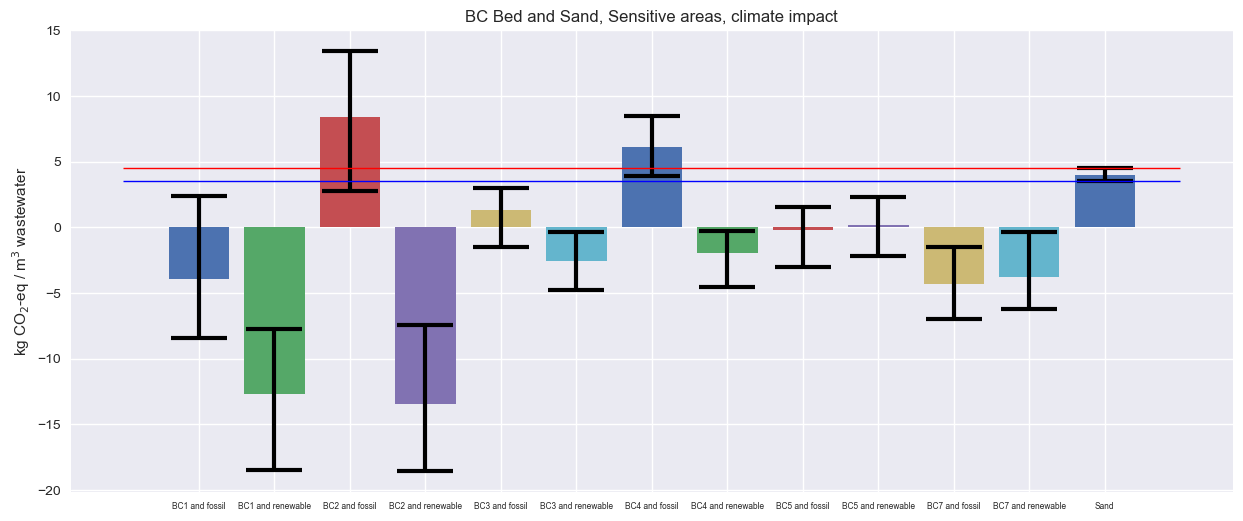

In [113]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCBedSensitiveClimate_bc1andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc1andfossilmedian, x=1, yerr = BCBedSensitiveClimate_bc1andfossilerror, capsize=20, 
            elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCBedSensitiveClimate_bc1andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc1andrenewablemedian, x=2, yerr = BCBedSensitiveClimate_bc1andrenewableerror, capsize=20, 
            elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCBedSensitiveClimate_bc2andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc2andfossilmedian, x=3, yerr = BCBedSensitiveClimate_bc2andfossilerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCBedSensitiveClimate_bc2andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc2andrenewablemedian, x=4, yerr = BCBedSensitiveClimate_bc2andrenewableerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCBedSensitiveClimate_bc3andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc3andfossilmedian, x=5, yerr = BCBedSensitiveClimate_bc3andfossilerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCBedSensitiveClimate_bc3andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc3andrenewablemedian, x=6, yerr = BCBedSensitiveClimate_bc3andrenewableerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCBedSensitiveClimate_bc4andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc4andfossilmedian, x=7, yerr = BCBedSensitiveClimate_bc4andfossilerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCBedSensitiveClimate_bc4andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc4andrenewablemedian, x=8, yerr = BCBedSensitiveClimate_bc4andrenewableerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCBedSensitiveClimate_bc5andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc5andfossilmedian, x=9, yerr = BCBedSensitiveClimate_bc5andfossilerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCBedSensitiveClimate_bc5andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc5andrenewablemedian, x=10, yerr = BCBedSensitiveClimate_bc5andrenewableerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCBedSensitiveClimate_bc7andfossilmedian)
ax.errorbar(y=BCBedSensitiveClimate_bc7andfossilmedian, x=11, yerr = BCBedSensitiveClimate_bc7andfossilerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCBedSensitiveClimate_bc7andrenewablemedian)
ax.errorbar(y=BCBedSensitiveClimate_bc7andrenewablemedian, x=12, yerr = BCBedSensitiveClimate_bc7andrenewableerror, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, Sand_Sensitive_medianClimate)
ax.errorbar(y=Sand_Sensitive_medianClimate, x=13, yerr = Sand_Sensitive_errorClimate, capsize=20,
        elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Bed and Sand, Sensitive areas, climate impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13))
ax.set_xticklabels(('BC1 and fossil', 'BC1 and renewable', 'BC2 and fossil', 'BC2 and renewable',
                    'BC3 and fossil', 'BC3 and renewable', 'BC4 and fossil', 'BC4 and renewable',
                    'BC5 and fossil', 'BC5 and renewable', 'BC7 and fossil', 'BC7 and renewable', 'Sand'), fontsize=6)
ax.set_ylabel(climate_label)

# ax.hlines(y=Sand_Sensitive_medianClimate, xmin=0, xmax=14, linewidth=2, color='r')
ax.hlines(y=Sand_Sensitive_medianClimate-Sand_Sensitive_errorClimate[0], xmin=0, xmax=14, linewidth=1, color='blue')
ax.hlines(y=Sand_Sensitive_medianClimate+Sand_Sensitive_errorClimate[1], xmin=0, xmax=14, linewidth=1, color='r')

In [114]:
fig.savefig('Scenario-BCBed-Sens-Climate', dpi=600, bbox_inches='tight')

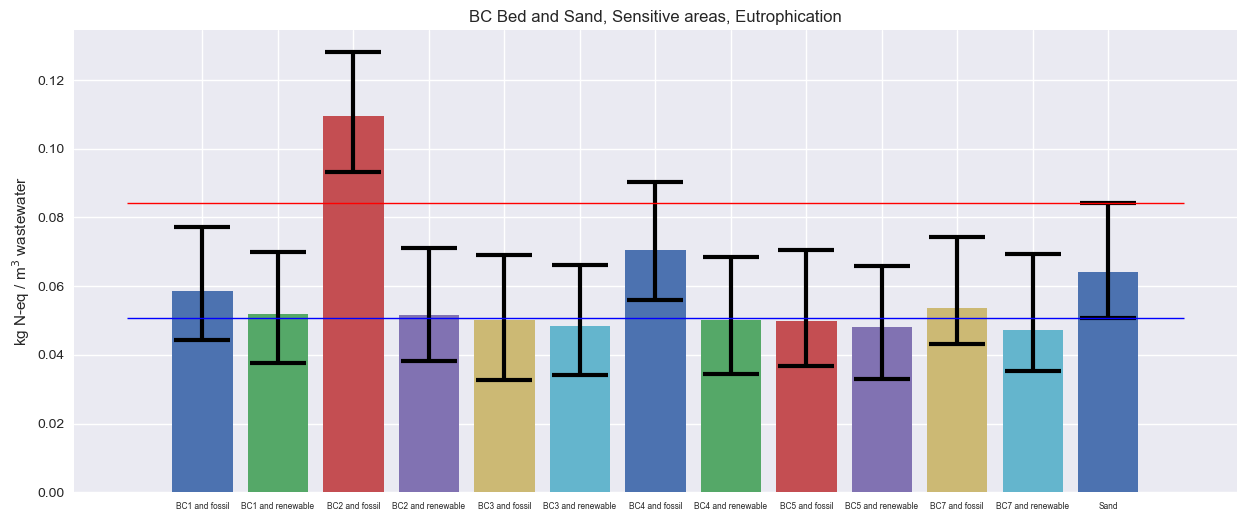

In [115]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCBedSensitiveEutrophication_bc1andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc1andfossilmedian, x=1, yerr = BCBedSensitiveEutrophication_bc1andfossilerror, capsize=20,
        	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCBedSensitiveEutrophication_bc1andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc1andrenewablemedian, x=2, yerr = BCBedSensitiveEutrophication_bc1andrenewableerror, capsize=20,
        	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCBedSensitiveEutrophication_bc2andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc2andfossilmedian, x=3, yerr = BCBedSensitiveEutrophication_bc2andfossilerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCBedSensitiveEutrophication_bc2andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc2andrenewablemedian, x=4, yerr = BCBedSensitiveEutrophication_bc2andrenewableerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCBedSensitiveEutrophication_bc3andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc3andfossilmedian, x=5, yerr = BCBedSensitiveEutrophication_bc3andfossilerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCBedSensitiveEutrophication_bc3andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc3andrenewablemedian, x=6, yerr = BCBedSensitiveEutrophication_bc3andrenewableerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCBedSensitiveEutrophication_bc4andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc4andfossilmedian, x=7, yerr = BCBedSensitiveEutrophication_bc4andfossilerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCBedSensitiveEutrophication_bc4andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc4andrenewablemedian, x=8, yerr = BCBedSensitiveEutrophication_bc4andrenewableerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCBedSensitiveEutrophication_bc5andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc5andfossilmedian, x=9, yerr = BCBedSensitiveEutrophication_bc5andfossilerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCBedSensitiveEutrophication_bc5andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc5andrenewablemedian, x=10, yerr = BCBedSensitiveEutrophication_bc5andrenewableerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCBedSensitiveEutrophication_bc7andfossilmedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc7andfossilmedian, x=11, yerr = BCBedSensitiveEutrophication_bc7andfossilerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCBedSensitiveEutrophication_bc7andrenewablemedian)
ax.errorbar(y=BCBedSensitiveEutrophication_bc7andrenewablemedian, x=12, yerr = BCBedSensitiveEutrophication_bc7andrenewableerror, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, Sand_Sensitive_medianEutroph)
ax.errorbar(y=Sand_Sensitive_medianEutroph, x=13, yerr = Sand_Sensitive_errorEutroph, capsize=20,
    	elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Bed and Sand, Sensitive areas, Eutrophication')
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13))
ax.set_xticklabels(('BC1 and fossil', 'BC1 and renewable', 'BC2 and fossil', 'BC2 and renewable',
                	'BC3 and fossil', 'BC3 and renewable', 'BC4 and fossil', 'BC4 and renewable',
                	'BC5 and fossil', 'BC5 and renewable', 'BC7 and fossil', 'BC7 and renewable', 'Sand'), fontsize=6)
ax.set_ylabel(eutroph_label)

# ax.hlines(y=Sand_Sensitive_medianEutroph, xmin=0, xmax=14, linewidth=2, color='r')
ax.hlines(y=Sand_Sensitive_medianEutroph-Sand_Sensitive_errorEutroph[0], xmin=0, xmax=14, linewidth=1, color='blue')
ax.hlines(y=Sand_Sensitive_medianEutroph+Sand_Sensitive_errorEutroph[1], xmin=0, xmax=14, linewidth=1, color='r')

In [116]:
fig.savefig('Scenario-BCBed-Sens-Eutroph', dpi=600, bbox_inches='tight')

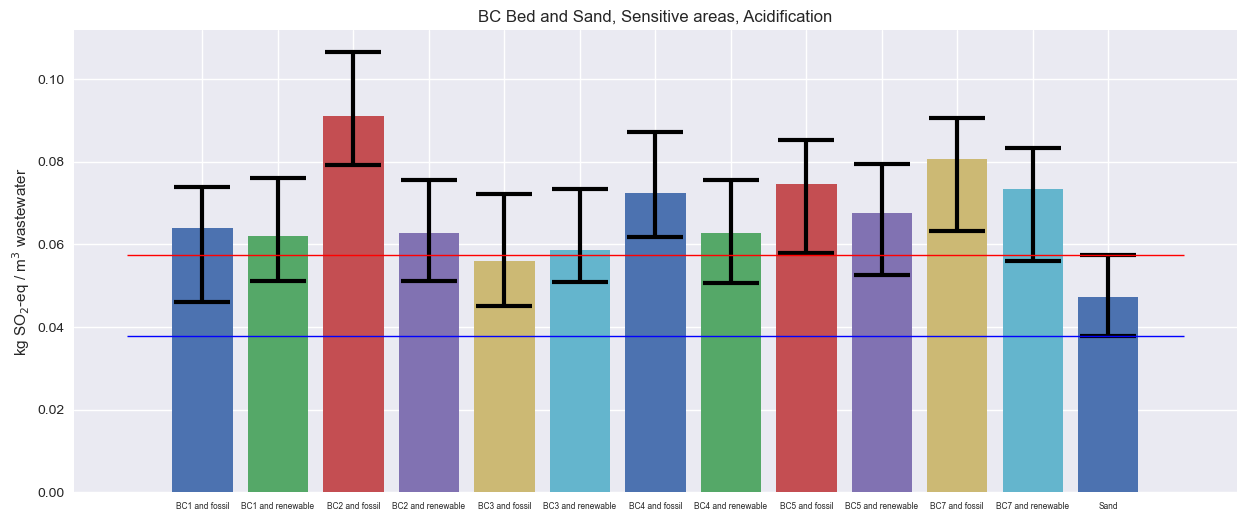

In [117]:
fig, ax = plt.subplots(figsize = (15,6))

ax.bar(1, BCBedSensitiveAcidification_bc1andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc1andfossilmedian, x=1, yerr = BCBedSensitiveAcidification_bc1andfossilerror, capsize=20,
   		 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(2, BCBedSensitiveAcidification_bc1andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc1andrenewablemedian, x=2, yerr = BCBedSensitiveAcidification_bc1andrenewableerror, capsize=20,
   		 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(3, BCBedSensitiveAcidification_bc2andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc2andfossilmedian, x=3, yerr = BCBedSensitiveAcidification_bc2andfossilerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(4, BCBedSensitiveAcidification_bc2andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc2andrenewablemedian, x=4, yerr = BCBedSensitiveAcidification_bc2andrenewableerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(5, BCBedSensitiveAcidification_bc3andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc3andfossilmedian, x=5, yerr = BCBedSensitiveAcidification_bc3andfossilerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(6, BCBedSensitiveAcidification_bc3andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc3andrenewablemedian, x=6, yerr = BCBedSensitiveAcidification_bc3andrenewableerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(7, BCBedSensitiveAcidification_bc4andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc4andfossilmedian, x=7, yerr = BCBedSensitiveAcidification_bc4andfossilerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(8, BCBedSensitiveAcidification_bc4andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc4andrenewablemedian, x=8, yerr = BCBedSensitiveAcidification_bc4andrenewableerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(9, BCBedSensitiveAcidification_bc5andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc5andfossilmedian, x=9, yerr = BCBedSensitiveAcidification_bc5andfossilerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(10, BCBedSensitiveAcidification_bc5andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc5andrenewablemedian, x=10, yerr = BCBedSensitiveAcidification_bc5andrenewableerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(11, BCBedSensitiveAcidification_bc7andfossilmedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc7andfossilmedian, x=11, yerr = BCBedSensitiveAcidification_bc7andfossilerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(12, BCBedSensitiveAcidification_bc7andrenewablemedian)
ax.errorbar(y=BCBedSensitiveAcidification_bc7andrenewablemedian, x=12, yerr = BCBedSensitiveAcidification_bc7andrenewableerror, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.bar(13, Sand_Sensitive_medianAcid)
ax.errorbar(y=Sand_Sensitive_medianAcid, x=13, yerr = Sand_Sensitive_errorAcid, capsize=20,
   	 elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('BC Bed and Sand, Sensitive areas, Acidification')
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13))
ax.set_xticklabels(('BC1 and fossil', 'BC1 and renewable', 'BC2 and fossil', 'BC2 and renewable',
           		 'BC3 and fossil', 'BC3 and renewable', 'BC4 and fossil', 'BC4 and renewable',
           		 'BC5 and fossil', 'BC5 and renewable', 'BC7 and fossil', 'BC7 and renewable', 'Sand'), fontsize=6)
ax.set_ylabel(acid_label)

# ax.hlines(y=Sand_Sensitive_medianAcid, xmin=0, xmax=14, linewidth=2, color='r')
ax.hlines(y=Sand_Sensitive_medianAcid-Sand_Sensitive_errorAcid[0], xmin=0, xmax=14, linewidth=1, color='blue')
ax.hlines(y=Sand_Sensitive_medianAcid+Sand_Sensitive_errorAcid[1], xmin=0, xmax=14, linewidth=1, color='r')

In [118]:
fig.savefig('Scenario-BCBed-Sens-Acid', dpi=600, bbox_inches='tight')

## Sobol

In [175]:
BCBed_Normal = findActivity("BCBed Normal System", db_name=USER_DB)
BCBed_Sensitive = findActivity("BCBed Sensitive System", db_name=USER_DB)
BCMod_Sensitive = findActivity("BCMod Sensitive System", db_name=USER_DB)
Sand_Normal = findActivity("Sand Normal System", db_name=USER_DB)
Sand_Sensitive = findActivity("Sand Sensitive System", db_name=USER_DB)

In [173]:
from lca_algebraic.stats import incer_stochastic_matrix_return

In [174]:
sob1, problem1 = incer_stochastic_matrix_return(BCBed_Normal, all_methods, n=1000)
sob2, problem2 = incer_stochastic_matrix_return(BCBed_Sensitive, all_methods, n=1000)
sob3, problem3 = incer_stochastic_matrix_return(BCMod_Sensitive, all_methods, n=1000)
sob4, problem4 = incer_stochastic_matrix_return(Sand_Normal, all_methods, n=1000)
sob5, problem5 = incer_stochastic_matrix_return(Sand_Sensitive, all_methods, n=1000)

Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')


In [176]:
sob_df1 = pd.DataFrame()
sob_df2 = pd.DataFrame()
sob_df3 = pd.DataFrame()
sob_df4 = pd.DataFrame()
sob_df5 = pd.DataFrame()

In [177]:
sob_df1_round = pd.DataFrame()
sob_df2_round = pd.DataFrame()
sob_df3_round = pd.DataFrame()
sob_df4_round = pd.DataFrame()
sob_df5_round = pd.DataFrame()

In [178]:
sob_list = [sob1, sob2, sob3, sob4, sob5]
problem_list = [problem1, problem2, problem3, problem4, problem5]
sob_df_list = [sob_df1, sob_df2, sob_df3, sob_df4, sob_df5]
sob_df_list_round = [sob_df1_round, sob_df2_round, sob_df3_round, sob_df4_round, sob_df5_round]

In [179]:
for sob, names, df, df_round in zip(sob_list, problem_list, sob_df_list, sob_df_list_round): # for every scenario
    for s, name in zip(sob.s1, names['names']): # and every sobol & name
        df[name] = s
        df_round[name] = [str(round(s[0], 2))]

In [180]:
sob_df2

BCStability  BOD5RemovalSludge  BOD5removalBCBedSensitive  BODremovalPAC  \
0      0.09817           0.000000                   0.000000       0.000000   
1      0.00000          -0.000105                   0.000437       0.000004   
2      0.00000           0.000000                   0.000000       0.000000   

     CH4air  CO2air  NremovalBCBedSensitive  NremovalSludge  PorgInPoutBC  \
0  0.000487     0.0                0.001058       -0.000017  0.000000e+00   
1  0.000000     0.0                0.105296        0.003388  2.067884e-08   
2  0.000000     0.0                0.255513        0.023334  0.000000e+00   

   PremovalBCBed  PremovalPAC  TransportDistanceFilter  TransportDistanceST  \
0       0.000000     0.000000                 0.000641            -0.000004   
1       0.036345     0.021577                -0.000019            -0.000001   
2       0.000000     0.000000                -0.000145            -0.000004   

   bc_Seqswitch_param  elec_switch_param  heat_switch_param  
0            0.330653           0.149956           0.060622  
1            0.341317           0.229217          -0.000408  
2            0.215556           0.217231           0.019490

In [181]:
sob_df2_round

BCStability BOD5RemovalSludge BOD5removalBCBedSensitive BODremovalPAC  \
0         0.1               0.0                       0.0           0.0   

  CH4air CO2air NremovalBCBedSensitive NremovalSludge PorgInPoutBC  \
0    0.0    0.0                    0.0           -0.0          0.0   

  PremovalBCBed PremovalPAC TransportDistanceFilter TransportDistanceST  \
0           0.0         0.0                     0.0                -0.0   

  bc_Seqswitch_param elec_switch_param heat_switch_param  
0               0.33              0.15              0.06

In [207]:
with pd.ExcelWriter('456.xlsx') as writer:  
    sob_df1.to_excel(writer, sheet_name='Sheet_name_1')
    sob_df2.to_excel(writer, sheet_name='Sheet_name_2')
    sob_df3.to_excel(writer, sheet_name='Sheet_name_3')
    sob_df4.to_excel(writer, sheet_name='Sheet_name_4')
    sob_df5.to_excel(writer, sheet_name='Sheet_name_5')

## compare to recommendations

define export_df before running this

from the dataframes - calculate the total BOD, N and P removal, for all filters

- Normal: 90% reduction of BOD and a 70% reduction of P
- Sensitive: 90% reduction of P and 50% reduction of N 

Step 1: find the params we need

BC Bed Normal: BOD5in, BOD5RemovalSludge, BOD5removalBCBedNormal; Ntotin, NremovalSludge, NremovalBCBedNormal; Ptotin, PremovalSludge, PremovalBCBed, PremovalBCimpreg - BC impreg always 0.9

BC Bed Sensitive: BOD5in, BOD5RemovalSludge, BODremovalPAC, BOD5removalBCBedSensitive; Ntotin, NremovalSludge, NremovalBCBedSensitive; Ptotin, PremovalPAC, PremovalBCBed

BC Mod: BOD5in, BOD5RemovalSludge, BODremovalPAC, BOD5removalBCMod; Ntotin, NremovalSludge, NremovalBCMod; Ptotin, PremovalPAC, PremovalBCmod - BOD5 removal BC Mod also a constant (0.9)

Sand Normal: BOD5in, BOD5RemovalSludge, BOD5removalSand; Ntotin, NremovalSludge, NremovalSand; Ptotin, PremovalSludge, PremovalSand

Sand Sensitive: BOD5in, BOD5RemovalSludge, BODremovalPAC, BOD5removalSand; Ntotin, NremovalSludge, NremovalSand; Ptotin, PremovalPAC, PremovalSand

In [338]:
# save results in arrays
BCBedNormalBOD = [100-100*(1-x)*(1-y) for x, y in zip(export_df['BOD5RemovalSludge'], export_df['BOD5removalBCBedNormal'])]
BCBedNormalN = [100-100*(1-x)*(1-y) for x, y in zip(export_df['NremovalSludge'], export_df['NremovalBCBedNormal'])]
BCBedNormalP = [100-100*(1-x)*(1-y)*(0.1) for x, y in zip(export_df['PremovalSludge'], export_df['PremovalBCBed'])]

In [339]:
min(BCBedNormalBOD)

83.6342357521858

In [340]:
max(BCBedNormalBOD)

95.99075610409491

In [341]:
min(BCBedNormalN)

5.159671399928627

In [342]:
max(BCBedNormalN)

33.58569350373

In [343]:
min(BCBedNormalP)

93.54602160096168

In [344]:
max(BCBedNormalP)

99.69543667912482

BC Bed Sensitive

In [353]:
BCBedSensitiveBOD = [100-100*(1-x+y)*(1-z) for x, y,z in zip(export_df['BOD5RemovalSludge'],export_df['BODremovalPAC'], 
                                                             export_df['BOD5removalBCBedSensitive'])]
BCBedSensitiveN = [100-100*(1-x)*(1-y) for x, y in zip(export_df['NremovalSludge'], export_df['NremovalBCBedSensitive'])]
BCBedSensitiveP = [100-100*(1-x)*(1-y)*(0.1) for x, y in zip(export_df['PremovalPAC'], export_df['PremovalBCBed'])]

In [354]:
min(BCBedSensitiveBOD)

89.98595084893145

In [355]:
max(BCBedSensitiveBOD)

97.73858091008104

In [356]:
min(BCBedSensitiveN)

61.12576912716031

In [357]:
max(BCBedSensitiveN)

85.47042812779546

In [358]:
min(BCBedSensitiveP)

98.04121560299396

In [359]:
max(BCBedSensitiveP)

99.98639698255062

BC Mod

In [361]:
BCModBOD = [100-100*(1-x+y)*(0.1) for x, y in zip(export_df['BOD5RemovalSludge'],export_df['BODremovalPAC'])]
BCModN = [100-100*(1-x)*(1-y) for x, y in zip(export_df['NremovalSludge'], export_df['NremovalBCMod'])]
BCModP = [100-100*(1-x)*(1-y)*(0.1) for x, y in zip(export_df['PremovalPAC'], export_df['PremovalBCmod'])]

In [362]:
min(BCModBOD)

89.8735775756836

In [363]:
max(BCModBOD)

94.48506317138671

In [364]:
min(BCModN)

62.08944072108715

In [365]:
max(BCModN)

74.47223671060055

In [366]:
min(BCModP)

97.68335838334635

In [367]:
max(BCModP)

99.78940376287326

Seems reasonable!

## Other stuff

### import/export parameters

In [7]:
loadParams()

0


In [5]:
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group
def ExportProjectParameters(f='ProjectParamExport.xlsx'):
    params = { i:p.dict for i,p in enumerate(ProjectParameter.select() )}
    pd.DataFrame.from_dict(params).to_excel('ProjectParamExport.xlsx')

def LoadProjectParameters(f='ProjectParamExport.xlsx'):
    df = pd.read_excel('ProjectParamExport.xlsx', index_col=0) # OBS OBS
    paramDict = df.to_dict(orient='dict')
    paramList = [v for k,v in paramDict.items()]
    bw2.parameters.new_project_parameters(paramList, overwrite=True)
    bw2.parameters.recalculate()

In [7]:
ExportProjectParameters()

In [8]:
project = 'wwt_new'
bw2.projects.set_current(project)

In [9]:
loadParams()

0


In [6]:
LoadProjectParameters(f='ProjectParametersUppsala')

ValueError: Global parameter BiocharYield does not have a numeric value: None